### CRNN 모델
이미지 입력  ===> 텍스트 출력 알고리즘

[1] 데이터 준비 <hr>

In [1]:
import string
import matplotlib.pyplot as plt
import glob
import tqdm
from PIL import Image

In [3]:
### 데이터 저장 경로
DATA_DIR = '../DATA/samples/'
MODEL_DIR = '../Models/'

import os
if not os.path.exists('MODEL_DIR'):
    os.mkdir(MODEL_DIR)

In [6]:
glob.glob(DATA_DIR+"*.png")

['../DATA/samples\\226md.png',
 '../DATA/samples\\22d5n.png',
 '../DATA/samples\\2356g.png',
 '../DATA/samples\\23mdg.png',
 '../DATA/samples\\23n88.png',
 '../DATA/samples\\243mm.png',
 '../DATA/samples\\244e2.png',
 '../DATA/samples\\245y5.png',
 '../DATA/samples\\24f6w.png',
 '../DATA/samples\\24pew.png',
 '../DATA/samples\\25257.png',
 '../DATA/samples\\253dc.png',
 '../DATA/samples\\25egp.png',
 '../DATA/samples\\25m6p.png',
 '../DATA/samples\\25p2m.png',
 '../DATA/samples\\25w53.png',
 '../DATA/samples\\264m5.png',
 '../DATA/samples\\268g2.png',
 '../DATA/samples\\28348.png',
 '../DATA/samples\\28x47.png',
 '../DATA/samples\\2b827.png',
 '../DATA/samples\\2bg48.png',
 '../DATA/samples\\2cegf.png',
 '../DATA/samples\\2cg58.png',
 '../DATA/samples\\2cgyx.png',
 '../DATA/samples\\2en7g.png',
 '../DATA/samples\\2enf4.png',
 '../DATA/samples\\2fxgd.png',
 '../DATA/samples\\2g783.png',
 '../DATA/samples\\2g7nm.png',
 '../DATA/samples\\2gyb6.png',
 '../DATA/samples\\2mg87.png',
 '../DAT

SELECT_IMG : ../DATA/samples\226md.png


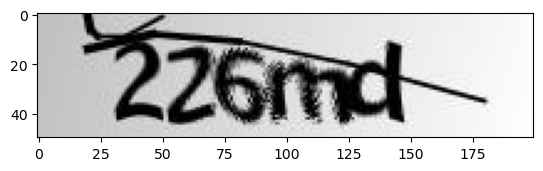

In [5]:
###  이미지 1개 경로 확인
img_file = glob.glob( DATA_DIR+"*.png")[0]  
print(f'SELECT_IMG : {img_file}')

img_file = Image.open(img_file) 
plt.imshow(img_file)
plt.show()

[2] 데이터 셋 준비 <hr>

[2-2] 데이터셋 클래스 정의 

In [7]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [8]:
# 문자로부터 BOW 생성 함수
def get_BOW(corpus):
   # 공백문자 <pad> => 0으로 설정
   BOW = {"<pad>":0}

   # corpus 문자들을 이용해 BOW에 고유번호 추가
   for letter in corpus:
       if letter not in BOW.keys():
           BOW[letter] = len(BOW.keys())
   return BOW

In [9]:
string.punctuation, string.ascii_letters, string.digits

('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~',
 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ',
 '0123456789')

In [10]:
get_BOW(string.ascii_letters+string.digits)

{'<pad>': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 'A': 27,
 'B': 28,
 'C': 29,
 'D': 30,
 'E': 31,
 'F': 32,
 'G': 33,
 'H': 34,
 'I': 35,
 'J': 36,
 'K': 37,
 'L': 38,
 'M': 39,
 'N': 40,
 'O': 41,
 'P': 42,
 'Q': 43,
 'R': 44,
 'S': 45,
 'T': 46,
 'U': 47,
 'V': 48,
 'W': 49,
 'X': 50,
 'Y': 51,
 'Z': 52,
 '0': 53,
 '1': 54,
 '2': 55,
 '3': 56,
 '4': 57,
 '5': 58,
 '6': 59,
 '7': 60,
 '8': 61,
 '9': 62}

In [11]:
### ==> 데이터셋 클래스 
class Captcha(Dataset):
   def __init__(self, pth, train=True):
       # 소문자와 숫자만 정답으로 이용
       self.corpus = string.ascii_lowercase + string.digits
       self.BOW = get_BOW(self.corpus)

       # 불러올 이미지 파일 경로
       self.imgfiles = glob.glob(pth+"*.png")
       self.imgfiles = [filename.replace("\\", "/") for filename in self.imgfiles ]
       print(f'self.imgfiles => {self.imgfiles}')
       
       # 학습 데이터셋 : 테스트 데이터셋 = 80 : 20
       self.train = train
       self.trainset = self.imgfiles[:int(len(self.imgfiles)*0.8)]
       self.testset = self.imgfiles[int(len(self.imgfiles)*0.8):]

   # 문자와 숫자를 고유번호로 치환
   def get_seq(self, line):
       label = []
       for letter in line:
           label.append(self.BOW[letter])
       return label

   def __len__(self):
       if self.train:
           return len(self.trainset)
       else:
           return len(self.testset)

   def __getitem__(self, i):
       if self.train:
           # png파일 >> RGB파일 변환
           data = Image.open(self.trainset[i]).convert("RGB")
           # './data/samples\\226md.png'
           label = self.trainset[i].split("/")[-1]
           
           # 파일이름에서 확장자 제거
           label = label.split(".png")[0]
           
           # 정답 : 문자열을 BOW 순열로 변환
           label = self.get_seq(label)
           
           # 데이터 : ndarray 변환 (H,W,C)
           data = np.array(data).astype(np.float32)
           
           # 파이토치는 채널 가장 앞으로
           data = np.transpose(data, (2, 0, 1))
           label = np.array(label)

           return data, label

       else:
           data = Image.open(self.testset[i]).convert("RGB")
           label = self.testset[i].split("/")[-1]
           label = label.split(".png")[0]
           label = self.get_seq(label)

           data = np.array(data).astype(np.float32)
           label = np.array(label)

           return data, label

In [12]:
ALL_DS = Captcha(pth=DATA_DIR)
len(ALL_DS.trainset), len(ALL_DS.testset)

self.imgfiles => ['../DATA/samples/226md.png', '../DATA/samples/22d5n.png', '../DATA/samples/2356g.png', '../DATA/samples/23mdg.png', '../DATA/samples/23n88.png', '../DATA/samples/243mm.png', '../DATA/samples/244e2.png', '../DATA/samples/245y5.png', '../DATA/samples/24f6w.png', '../DATA/samples/24pew.png', '../DATA/samples/25257.png', '../DATA/samples/253dc.png', '../DATA/samples/25egp.png', '../DATA/samples/25m6p.png', '../DATA/samples/25p2m.png', '../DATA/samples/25w53.png', '../DATA/samples/264m5.png', '../DATA/samples/268g2.png', '../DATA/samples/28348.png', '../DATA/samples/28x47.png', '../DATA/samples/2b827.png', '../DATA/samples/2bg48.png', '../DATA/samples/2cegf.png', '../DATA/samples/2cg58.png', '../DATA/samples/2cgyx.png', '../DATA/samples/2en7g.png', '../DATA/samples/2enf4.png', '../DATA/samples/2fxgd.png', '../DATA/samples/2g783.png', '../DATA/samples/2g7nm.png', '../DATA/samples/2gyb6.png', '../DATA/samples/2mg87.png', '../DATA/samples/2mpnn.png', '../DATA/samples/2n73f.pn

(832, 208)

[3] 모델 클래스 정의 <hr>

In [13]:
### ==> 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
# 3X5 크기의 커널을 이용
class BasicBlock(nn.Module):
   def __init__(self, in_channels, out_channels, kernel_size=(3, 5), stride=(2, 1)):
       super(BasicBlock, self).__init__()

       self.c1 = nn.Conv2d(in_channels=in_channels,
                           out_channels=out_channels,
                           kernel_size=kernel_size,
                           stride=stride)
       
       self.c2 = nn.Conv2d(in_channels=out_channels,
                           out_channels=out_channels,
                           kernel_size=(3, 3), padding=1)

       self.downsample = nn.Conv2d(in_channels=in_channels,
                                   out_channels=out_channels,
                                   kernel_size=kernel_size,
                                   stride=stride)

       self.bn1 = nn.BatchNorm2d(num_features=out_channels)
       self.bn2 = nn.BatchNorm2d(num_features=out_channels)

       self.relu = nn.ReLU()

   def forward(self, x):
       x_ = x
       x = self.c1(x)
       x = self.bn1(x)
       x = self.relu(x)
       x = self.c2(x)
       x = self.bn2(x)

       x_ = self.downsample(x_)

       x += x_
       x = self.relu(x)

       return x

In [15]:
class CRNN(nn.Module):
   def __init__(self, output_size):
       super(CRNN, self).__init__()

       # CNN층 정의
       self.c1 = BasicBlock(in_channels=3, out_channels=64)
       self.c2 = BasicBlock(in_channels=64, out_channels=64)
       self.c3 = BasicBlock(in_channels=64, out_channels=64)
       self.c4 = BasicBlock(in_channels=64, out_channels=64)
       self.c5 = nn.Conv2d(64, 64, kernel_size=(2, 5))

       # 텍스트 정보 추출할 GRU층
       self.gru = nn.GRU(64, 64, batch_first=False)

       # 분류 위한 MLP층
       self.fc1 = nn.Linear(in_features=64, out_features=128)
       self.fc2 = nn.Linear(in_features=128, out_features=output_size) #37(a~z0~9)
       self.relu = nn.ReLU()

   def forward(self, x):
       # 입력텐서의 모양(B, 3, 50, 200)
       x = self.c1(x)
       x = self.c2(x)
       x = self.c3(x)
       x = self.c4(x)
       x = self.c5(x)
       # 특징 추출 후 텐서의 모양(B, 64, 1, 180)
       # (1, 180)이미지 특징맵 데이터 64개 
       
       # (B, K=64, F=180)으로 모양 변경
       x = x.view(x.shape[0], 64, -1)
       
       # (B, F=180, K=64)로 모양 변경
       x = x.permute(2, 0, 1)

       # GRU로 시계열 정보 추출(B, SL, HS)
       x, _ = self.gru(x)
       # X=(SL, B, H), _=(L, B, HS)

       # FC층으로 각 픽셀 분류
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)

       # CTC 손실 계산을 위해 로그 소프트맥스를 이용
       x = F.log_softmax(x, dim=-1)

       return x

- [3] 학습 준비 <hr>

In [16]:
from torch.optim.adam import Adam

In [17]:
### 학습 관련 하이퍼파라미터
EPOCHS = 100
BATCH_SIZE = 8

### 실행 디바이스
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TRAIN_DS = Captcha(pth=DATA_DIR)
LOADER = DataLoader(TRAIN_DS, batch_size=BATCH_SIZE)
print(f'len(TRAIN_DS.BOW)=====>\{len(TRAIN_DS.BOW)}')

MODEL = CRNN(output_size=len(TRAIN_DS.BOW)).to(DEVICE)
print(f'MODEL DESC=====>\{MODEL}')

OPTIMIZER = Adam(MODEL.parameters(), lr=0.0001)

self.imgfiles => ['../DATA/samples/226md.png', '../DATA/samples/22d5n.png', '../DATA/samples/2356g.png', '../DATA/samples/23mdg.png', '../DATA/samples/23n88.png', '../DATA/samples/243mm.png', '../DATA/samples/244e2.png', '../DATA/samples/245y5.png', '../DATA/samples/24f6w.png', '../DATA/samples/24pew.png', '../DATA/samples/25257.png', '../DATA/samples/253dc.png', '../DATA/samples/25egp.png', '../DATA/samples/25m6p.png', '../DATA/samples/25p2m.png', '../DATA/samples/25w53.png', '../DATA/samples/264m5.png', '../DATA/samples/268g2.png', '../DATA/samples/28348.png', '../DATA/samples/28x47.png', '../DATA/samples/2b827.png', '../DATA/samples/2bg48.png', '../DATA/samples/2cegf.png', '../DATA/samples/2cg58.png', '../DATA/samples/2cgyx.png', '../DATA/samples/2en7g.png', '../DATA/samples/2enf4.png', '../DATA/samples/2fxgd.png', '../DATA/samples/2g783.png', '../DATA/samples/2g7nm.png', '../DATA/samples/2gyb6.png', '../DATA/samples/2mg87.png', '../DATA/samples/2mpnn.png', '../DATA/samples/2n73f.pn

In [18]:
### ===> 학습 진행 함수 
def training(model, optim, epochs):
    for epoch in range(200):
        iterator = tqdm.tqdm(LOADER)

        # 정답에 사용할 label
        for data, label in iterator:
            optim.zero_grad()
            preds = model(data.to(DEVICE))  # CRNN의 출력값
            print(f'preds=> {preds.shape}, {preds.ndim}D')
        
            # 시계열 단위 크기 지정 
            print(f'preds.size(0) => {preds.size(0)}')
            preds_size = torch.IntTensor([preds.size(0)] * BATCH_SIZE).to(DEVICE)
            print(f'preds_size=> {preds_size.shape}, {preds_size.ndim}D\n{preds_size}')
            
            # 정답의 모양을 나타내는 변수
            target_len = torch.IntTensor([len(txt) for txt in label]).to(DEVICE)
            print(f'target_len=> {target_len.shape}, {target_len.ndim}D\n {target_len}')

            # 손실 계산
            loss = nn.CTCLoss(blank=0)(preds, label.to(DEVICE), preds_size, target_len)

            # W, b 업데이트  
            loss.backward()   
            optim.step()

            iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}") 
     
    torch.save(model.state_dict(), f"{epoch}_CRNN.pth")

In [140]:
training(MODEL, OPTIMIZER, EPOCHS)

  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:118.8232650756836:   1%|          | 1/104 [00:00<01:18,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:116.0352783203125:   2%|▏         | 2/104 [00:01<01:12,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:113.71208190917969:   3%|▎         | 3/104 [00:02<01:20,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:109.8376693725586:   4%|▍         | 4/104 [00:03<01:24,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:107.64208221435547:   5%|▍         | 5/104 [00:03<01:16,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:105.99213409423828:   6%|▌         | 6/104 [00:04<01:07,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:103.837890625:   7%|▋         | 7/104 [00:05<01:05,  1.48it/s]     

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:101.43022918701172:   8%|▊         | 8/104 [00:05<01:01,  1.57it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:99.68412780761719:   9%|▊         | 9/104 [00:06<01:00,  1.57it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:97.24583435058594:  10%|▉         | 10/104 [00:07<01:02,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:94.87210083007812:  11%|█         | 11/104 [00:07<00:57,  1.62it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:92.81549072265625:  12%|█▏        | 12/104 [00:08<00:59,  1.55it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:90.01972961425781:  12%|█▎        | 13/104 [00:08<00:58,  1.56it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:88.23712158203125:  13%|█▎        | 14/104 [00:09<00:56,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:85.4330062866211:  14%|█▍        | 15/104 [00:10<00:58,  1.53it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:83.91136932373047:  15%|█▌        | 16/104 [00:10<00:55,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:82.4134750366211:  16%|█▋        | 17/104 [00:11<00:54,  1.61it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:80.85931396484375:  17%|█▋        | 18/104 [00:11<00:53,  1.61it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:79.48519897460938:  18%|█▊        | 19/104 [00:12<01:00,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:77.9341812133789:  19%|█▉        | 20/104 [00:13<01:02,  1.35it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:76.97090148925781:  20%|██        | 21/104 [00:14<01:02,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:75.56928253173828:  21%|██        | 22/104 [00:15<00:59,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:74.03826904296875:  22%|██▏       | 23/104 [00:15<00:55,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:72.90170288085938:  23%|██▎       | 24/104 [00:16<00:55,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:71.84754180908203:  24%|██▍       | 25/104 [00:17<00:59,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:71.06475067138672:  25%|██▌       | 26/104 [00:17<00:57,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:69.5921401977539:  26%|██▌       | 27/104 [00:18<00:56,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:68.28822326660156:  27%|██▋       | 28/104 [00:19<00:58,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:67.25634002685547:  28%|██▊       | 29/104 [00:20<00:57,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:66.2215347290039:  29%|██▉       | 30/104 [00:21<01:00,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:65.5318832397461:  30%|██▉       | 31/104 [00:22<00:57,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:64.55977630615234:  31%|███       | 32/104 [00:22<00:57,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:63.74192810058594:  32%|███▏      | 33/104 [00:23<00:57,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:62.91796875:  33%|███▎      | 34/104 [00:24<00:57,  1.21it/s]      

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:62.10567092895508:  34%|███▎      | 35/104 [00:25<00:52,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:61.392147064208984:  35%|███▍      | 36/104 [00:25<00:49,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:60.57283401489258:  36%|███▌      | 37/104 [00:26<00:46,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:59.60825729370117:  37%|███▋      | 38/104 [00:27<00:45,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:58.81698226928711:  38%|███▊      | 39/104 [00:28<00:49,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:57.94527053833008:  38%|███▊      | 40/104 [00:28<00:50,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:56.938297271728516:  39%|███▉      | 41/104 [00:29<00:47,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:56.317501068115234:  40%|████      | 42/104 [00:30<00:46,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:55.37527084350586:  41%|████▏     | 43/104 [00:30<00:44,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:54.6306037902832:  42%|████▏     | 44/104 [00:31<00:40,  1.47it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:53.6338996887207:  43%|████▎     | 45/104 [00:32<00:43,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:53.008975982666016:  44%|████▍     | 46/104 [00:33<00:40,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:52.164703369140625:  45%|████▌     | 47/104 [00:33<00:38,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:51.39854049682617:  46%|████▌     | 48/104 [00:34<00:37,  1.50it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:50.502830505371094:  47%|████▋     | 49/104 [00:34<00:37,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:49.82741928100586:  48%|████▊     | 50/104 [00:36<00:43,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:48.83871078491211:  49%|████▉     | 51/104 [00:37<00:45,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:48.051753997802734:  50%|█████     | 52/104 [00:37<00:40,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:47.15132141113281:  51%|█████     | 53/104 [00:39<00:49,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:46.44611358642578:  52%|█████▏    | 54/104 [00:40<00:48,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:45.72165298461914:  53%|█████▎    | 55/104 [00:40<00:43,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:44.886722564697266:  54%|█████▍    | 56/104 [00:41<00:41,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:44.30010223388672:  55%|█████▍    | 57/104 [00:42<00:37,  1.24it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:43.379722595214844:  56%|█████▌    | 58/104 [00:42<00:36,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:42.6923713684082:  57%|█████▋    | 59/104 [00:43<00:34,  1.31it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:41.90868377685547:  58%|█████▊    | 60/104 [00:44<00:30,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:41.237796783447266:  59%|█████▊    | 61/104 [00:44<00:30,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:40.55978775024414:  60%|█████▉    | 62/104 [00:45<00:29,  1.41it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:39.94304656982422:  61%|██████    | 63/104 [00:46<00:28,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:39.26694869995117:  62%|██████▏   | 64/104 [00:47<00:36,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:38.6148567199707:  62%|██████▎   | 65/104 [00:49<00:41,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:37.701026916503906:  63%|██████▎   | 66/104 [00:50<00:46,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:37.00620651245117:  64%|██████▍   | 67/104 [00:51<00:40,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:36.392486572265625:  65%|██████▌   | 68/104 [00:52<00:34,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:35.71164321899414:  66%|██████▋   | 69/104 [00:52<00:31,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:35.11442565917969:  67%|██████▋   | 70/104 [00:54<00:34,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:34.458045959472656:  68%|██████▊   | 71/104 [00:55<00:38,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:33.67427062988281:  69%|██████▉   | 72/104 [00:56<00:32,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:33.054100036621094:  70%|███████   | 73/104 [00:59<00:47,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:32.421871185302734:  71%|███████   | 74/104 [01:00<00:45,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:31.816926956176758:  72%|███████▏  | 75/104 [01:01<00:39,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:31.16863441467285:  73%|███████▎  | 76/104 [01:02<00:32,  1.17s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:30.625370025634766:  74%|███████▍  | 77/104 [01:03<00:27,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:29.992828369140625:  75%|███████▌  | 78/104 [01:03<00:24,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:29.45757484436035:  76%|███████▌  | 79/104 [01:04<00:20,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:28.83425521850586:  77%|███████▋  | 80/104 [01:05<00:19,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:28.361726760864258:  78%|███████▊  | 81/104 [01:05<00:18,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:27.750896453857422:  79%|███████▉  | 82/104 [01:06<00:17,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:27.12791633605957:  80%|███████▉  | 83/104 [01:07<00:17,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:26.584884643554688:  81%|████████  | 84/104 [01:09<00:20,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:25.951345443725586:  82%|████████▏ | 85/104 [01:09<00:18,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:25.463470458984375:  83%|████████▎ | 86/104 [01:12<00:24,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:24.904361724853516:  84%|████████▎ | 87/104 [01:13<00:22,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:24.286985397338867:  85%|████████▍ | 88/104 [01:14<00:19,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:23.828826904296875:  86%|████████▌ | 89/104 [01:15<00:17,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:23.41037368774414:  87%|████████▋ | 90/104 [01:16<00:14,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:22.587879180908203:  88%|████████▊ | 91/104 [01:17<00:14,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:22.299144744873047:  88%|████████▊ | 92/104 [01:18<00:11,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:21.863988876342773:  89%|████████▉ | 93/104 [01:18<00:10,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:21.410898208618164:  90%|█████████ | 94/104 [01:19<00:08,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:21.20437240600586:  91%|█████████▏| 95/104 [01:20<00:07,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:20.68012237548828:  92%|█████████▏| 96/104 [01:21<00:06,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:20.435386657714844:  93%|█████████▎| 97/104 [01:23<00:07,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:19.94013214111328:  94%|█████████▍| 98/104 [01:24<00:06,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:19.544300079345703:  95%|█████████▌| 99/104 [01:25<00:06,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:19.142749786376953:  96%|█████████▌| 100/104 [01:26<00:04,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:18.728513717651367:  97%|█████████▋| 101/104 [01:27<00:03,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:18.173498153686523:  98%|█████████▊| 102/104 [01:29<00:02,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch1 loss:17.933303833007812:  99%|█████████▉| 103/104 [01:30<00:01,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:17.164072036743164:   1%|          | 1/104 [00:01<02:25,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:16.845212936401367:   2%|▏         | 2/104 [00:02<02:15,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:16.69684410095215:   3%|▎         | 3/104 [00:03<01:58,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:16.308509826660156:   4%|▍         | 4/104 [00:04<01:46,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:15.865832328796387:   5%|▍         | 5/104 [00:05<01:45,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:15.616415023803711:   6%|▌         | 6/104 [00:07<02:04,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:15.240856170654297:   7%|▋         | 7/104 [00:08<01:56,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:14.917274475097656:   8%|▊         | 8/104 [00:09<02:05,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:14.783775329589844:   9%|▊         | 9/104 [00:11<01:58,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:14.386003494262695:  10%|▉         | 10/104 [00:12<02:02,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:14.050341606140137:  11%|█         | 11/104 [00:13<01:54,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:13.8596773147583:  12%|█▏        | 12/104 [00:15<02:06,  1.37s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:13.481822967529297:  12%|█▎        | 13/104 [00:16<02:05,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:13.610664367675781:  13%|█▎        | 14/104 [00:17<01:59,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:13.514406204223633:  14%|█▍        | 15/104 [00:19<01:58,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:13.381906509399414:  15%|█▌        | 16/104 [00:20<02:10,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:12.946074485778809:  16%|█▋        | 17/104 [00:22<01:59,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:12.623086929321289:  17%|█▋        | 18/104 [00:23<01:50,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:12.357673645019531:  18%|█▊        | 19/104 [00:24<01:39,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:11.868885040283203:  19%|█▉        | 20/104 [00:25<01:40,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:11.903815269470215:  20%|██        | 21/104 [00:28<02:31,  1.83s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:11.664743423461914:  21%|██        | 22/104 [00:30<02:32,  1.87s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:11.428497314453125:  22%|██▏       | 23/104 [00:31<02:07,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:11.245399475097656:  23%|██▎       | 24/104 [00:32<01:49,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:10.911913871765137:  24%|██▍       | 25/104 [00:33<01:38,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:10.836912155151367:  25%|██▌       | 26/104 [00:34<01:25,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:10.567866325378418:  26%|██▌       | 27/104 [00:34<01:15,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:10.381153106689453:  27%|██▋       | 28/104 [00:35<01:11,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:10.256224632263184:  28%|██▊       | 29/104 [00:36<01:08,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:9.953912734985352:  29%|██▉       | 30/104 [00:37<01:03,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:9.947386741638184:  30%|██▉       | 31/104 [00:37<00:58,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:9.675276756286621:  31%|███       | 32/104 [00:38<00:57,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:9.57552719116211:  32%|███▏      | 33/104 [00:39<00:55,  1.27it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:9.507570266723633:  33%|███▎      | 34/104 [00:40<00:59,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:9.510873794555664:  34%|███▎      | 35/104 [00:41<00:59,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:9.538690567016602:  35%|███▍      | 36/104 [00:42<00:56,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:9.460790634155273:  36%|███▌      | 37/104 [00:42<00:55,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:9.193184852600098:  37%|███▋      | 38/104 [00:43<00:52,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:9.135794639587402:  38%|███▊      | 39/104 [00:44<00:48,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:8.943096160888672:  38%|███▊      | 40/104 [00:44<00:47,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:8.627120971679688:  39%|███▉      | 41/104 [00:45<00:46,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:8.743708610534668:  40%|████      | 42/104 [00:46<00:44,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:8.492975234985352:  41%|████▏     | 43/104 [00:47<00:44,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:8.470434188842773:  42%|████▏     | 44/104 [00:47<00:40,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:8.181747436523438:  43%|████▎     | 45/104 [00:48<00:40,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:8.280512809753418:  44%|████▍     | 46/104 [00:49<00:43,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:8.123968124389648:  45%|████▌     | 47/104 [00:50<00:42,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:8.077451705932617:  46%|████▌     | 48/104 [00:50<00:39,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:7.918436527252197:  47%|████▋     | 49/104 [00:51<00:41,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:7.961645126342773:  48%|████▊     | 50/104 [00:52<00:42,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:7.743192672729492:  49%|████▉     | 51/104 [00:53<00:41,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:7.714837074279785:  50%|█████     | 52/104 [00:53<00:37,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:7.511198043823242:  51%|█████     | 53/104 [00:54<00:35,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:7.496344089508057:  52%|█████▏    | 54/104 [00:55<00:34,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:7.437684059143066:  53%|█████▎    | 55/104 [00:55<00:33,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:7.245133399963379:  54%|█████▍    | 56/104 [00:56<00:33,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:7.331287860870361:  55%|█████▍    | 57/104 [00:57<00:32,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:7.07267951965332:  56%|█████▌    | 58/104 [00:57<00:30,  1.53it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:7.00322151184082:  57%|█████▋    | 59/104 [00:58<00:29,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.865638256072998:  58%|█████▊    | 60/104 [00:58<00:28,  1.55it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.8715009689331055:  59%|█████▊    | 61/104 [00:59<00:28,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.835658073425293:  60%|█████▉    | 62/104 [01:00<00:26,  1.57it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.8541741371154785:  61%|██████    | 63/104 [01:00<00:25,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.839262962341309:  62%|██████▏   | 64/104 [01:01<00:26,  1.54it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.845602512359619:  62%|██████▎   | 65/104 [01:02<00:24,  1.57it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.546777725219727:  63%|██████▎   | 66/104 [01:02<00:25,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.459826469421387:  64%|██████▍   | 67/104 [01:03<00:24,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.49962854385376:  65%|██████▌   | 68/104 [01:04<00:23,  1.54it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.448771953582764:  66%|██████▋   | 69/104 [01:04<00:22,  1.56it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.459564208984375:  67%|██████▋   | 70/104 [01:05<00:21,  1.57it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.435980796813965:  68%|██████▊   | 71/104 [01:06<00:21,  1.54it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.223711967468262:  69%|██████▉   | 72/104 [01:06<00:20,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.199812889099121:  70%|███████   | 73/104 [01:07<00:19,  1.62it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.173112869262695:  71%|███████   | 74/104 [01:07<00:18,  1.59it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.163926124572754:  72%|███████▏  | 75/104 [01:08<00:18,  1.57it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.080158233642578:  73%|███████▎  | 76/104 [01:09<00:18,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.083658218383789:  74%|███████▍  | 77/104 [01:09<00:17,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.998847007751465:  75%|███████▌  | 78/104 [01:10<00:16,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:6.011525630950928:  76%|███████▌  | 79/104 [01:11<00:15,  1.57it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.897634506225586:  77%|███████▋  | 80/104 [01:11<00:14,  1.62it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.947082042694092:  78%|███████▊  | 81/104 [01:12<00:14,  1.64it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.867060661315918:  79%|███████▉  | 82/104 [01:13<00:13,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.755921363830566:  80%|███████▉  | 83/104 [01:13<00:12,  1.63it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.706521034240723:  81%|████████  | 84/104 [01:14<00:12,  1.62it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.5787529945373535:  82%|████████▏ | 85/104 [01:14<00:11,  1.65it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.60792875289917:  83%|████████▎ | 86/104 [01:15<00:11,  1.61it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.54537296295166:  84%|████████▎ | 87/104 [01:16<00:11,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.39095401763916:  85%|████████▍ | 88/104 [01:16<00:09,  1.61it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.3947038650512695:  86%|████████▌ | 89/104 [01:17<00:09,  1.64it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.440224647521973:  87%|████████▋ | 90/104 [01:17<00:08,  1.60it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.043527126312256:  88%|████████▊ | 91/104 [01:18<00:07,  1.68it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.2320756912231445:  88%|████████▊ | 92/104 [01:19<00:07,  1.63it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.203896522521973:  89%|████████▉ | 93/104 [01:19<00:06,  1.66it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.1698079109191895:  90%|█████████ | 94/104 [01:20<00:05,  1.67it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.356330871582031:  91%|█████████▏| 95/104 [01:20<00:05,  1.63it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.251712799072266:  92%|█████████▏| 96/104 [01:21<00:04,  1.70it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.408296585083008:  93%|█████████▎| 97/104 [01:22<00:04,  1.63it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.28660249710083:  94%|█████████▍| 98/104 [01:22<00:03,  1.63it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.253917217254639:  95%|█████████▌| 99/104 [01:23<00:02,  1.68it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.237764835357666:  96%|█████████▌| 100/104 [01:24<00:02,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.173747539520264:  97%|█████████▋| 101/104 [01:24<00:01,  1.68it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:4.953475475311279:  98%|█████████▊| 102/104 [01:25<00:01,  1.59it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch2 loss:5.05271053314209:  99%|█████████▉| 103/104 [01:25<00:00,  1.53it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.987023830413818:   1%|          | 1/104 [00:00<01:02,  1.65it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:5.011462211608887:   2%|▏         | 2/104 [00:01<00:58,  1.74it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:5.137072563171387:   3%|▎         | 3/104 [00:01<00:58,  1.71it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:5.04777717590332:   4%|▍         | 4/104 [00:02<00:59,  1.69it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.905685901641846:   5%|▍         | 5/104 [00:02<00:59,  1.68it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.951794624328613:   6%|▌         | 6/104 [00:03<00:58,  1.68it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.845107078552246:   7%|▋         | 7/104 [00:04<00:57,  1.68it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.8043694496154785:   8%|▊         | 8/104 [00:04<00:55,  1.73it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.947624683380127:   9%|▊         | 9/104 [00:05<00:53,  1.77it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.79863166809082:  10%|▉         | 10/104 [00:05<00:54,  1.71it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.706897258758545:  11%|█         | 11/104 [00:06<00:54,  1.72it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.751741409301758:  12%|█▏        | 12/104 [00:07<00:53,  1.72it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.6419453620910645:  12%|█▎        | 13/104 [00:07<00:53,  1.69it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.971911430358887:  13%|█▎        | 14/104 [00:08<00:53,  1.69it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:5.084843635559082:  14%|█▍        | 15/104 [00:08<00:52,  1.70it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:5.166046142578125:  15%|█▌        | 16/104 [00:09<00:52,  1.68it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.952974319458008:  16%|█▋        | 17/104 [00:10<00:52,  1.67it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.835374355316162:  17%|█▋        | 18/104 [00:10<00:51,  1.68it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.787672519683838:  18%|█▊        | 19/104 [00:11<00:49,  1.72it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.54754114151001:  19%|█▉        | 20/104 [00:11<00:49,  1.71it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.74704647064209:  20%|██        | 21/104 [00:12<00:48,  1.72it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.697338104248047:  21%|██        | 22/104 [00:12<00:48,  1.69it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.666518688201904:  22%|██▏       | 23/104 [00:13<00:49,  1.64it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.606770992279053:  23%|██▎       | 24/104 [00:14<00:47,  1.69it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.464090347290039:  24%|██▍       | 25/104 [00:14<00:49,  1.61it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.575619220733643:  25%|██▌       | 26/104 [00:15<00:47,  1.63it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.446924209594727:  26%|██▌       | 27/104 [00:16<00:47,  1.63it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.4123334884643555:  27%|██▋       | 28/104 [00:16<00:47,  1.59it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.425741195678711:  28%|██▊       | 29/104 [00:17<00:47,  1.57it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.301901340484619:  29%|██▉       | 30/104 [00:17<00:45,  1.62it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.418966770172119:  30%|██▉       | 31/104 [00:18<00:44,  1.63it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.279164791107178:  31%|███       | 32/104 [00:19<00:43,  1.66it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.312918186187744:  32%|███▏      | 33/104 [00:19<00:44,  1.61it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.385492324829102:  33%|███▎      | 34/104 [00:20<00:42,  1.66it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.5139851570129395:  34%|███▎      | 35/104 [00:20<00:40,  1.70it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.6427154541015625:  35%|███▍      | 36/104 [00:21<00:42,  1.61it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.690678596496582:  36%|███▌      | 37/104 [00:22<00:39,  1.68it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.564670085906982:  37%|███▋      | 38/104 [00:22<00:41,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.5960845947265625:  38%|███▊      | 39/104 [00:23<00:40,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.529148578643799:  38%|███▊      | 40/104 [00:24<00:38,  1.65it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.338498115539551:  39%|███▉      | 41/104 [00:24<00:38,  1.64it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.540773868560791:  40%|████      | 42/104 [00:25<00:37,  1.67it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.403228282928467:  41%|████▏     | 43/104 [00:26<00:41,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.453118324279785:  42%|████▏     | 44/104 [00:26<00:38,  1.54it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.257920742034912:  43%|████▎     | 45/104 [00:27<00:36,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.460005760192871:  44%|████▍     | 46/104 [00:27<00:37,  1.54it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.413590431213379:  45%|████▌     | 47/104 [00:28<00:36,  1.57it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.4279069900512695:  46%|████▌     | 48/104 [00:29<00:36,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.370134353637695:  47%|████▋     | 49/104 [00:29<00:35,  1.55it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.486370086669922:  48%|████▊     | 50/104 [00:30<00:33,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.361598014831543:  49%|████▉     | 51/104 [00:31<00:32,  1.62it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.400443077087402:  50%|█████     | 52/104 [00:31<00:32,  1.61it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.306934356689453:  51%|█████     | 53/104 [00:32<00:32,  1.57it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.338778018951416:  52%|█████▏    | 54/104 [00:32<00:32,  1.55it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.3451032638549805:  53%|█████▎    | 55/104 [00:33<00:30,  1.58it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.246271133422852:  54%|█████▍    | 56/104 [00:34<00:30,  1.55it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.385166645050049:  55%|█████▍    | 57/104 [00:34<00:30,  1.56it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.218171119689941:  56%|█████▌    | 58/104 [00:35<00:29,  1.57it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.201269149780273:  57%|█████▋    | 59/104 [00:36<00:29,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.144136905670166:  58%|█████▊    | 60/104 [00:36<00:28,  1.55it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.201045513153076:  59%|█████▊    | 61/104 [00:37<00:28,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.21127986907959:  60%|█████▉    | 62/104 [00:38<00:28,  1.46it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.282832622528076:  61%|██████    | 63/104 [00:38<00:28,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.332363128662109:  62%|██████▏   | 64/104 [00:39<00:28,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.389836311340332:  62%|██████▎   | 65/104 [00:40<00:25,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.146978378295898:  63%|██████▎   | 66/104 [00:41<00:26,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.130855560302734:  64%|██████▍   | 67/104 [00:41<00:24,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.201768398284912:  65%|██████▌   | 68/104 [00:42<00:26,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.195531368255615:  66%|██████▋   | 69/104 [00:43<00:24,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.261693000793457:  67%|██████▋   | 70/104 [00:43<00:23,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.280801773071289:  68%|██████▊   | 71/104 [00:44<00:23,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.101072311401367:  69%|██████▉   | 72/104 [00:45<00:21,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.156368255615234:  70%|███████   | 73/104 [00:45<00:21,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.150605201721191:  71%|███████   | 74/104 [00:46<00:20,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.199565410614014:  72%|███████▏  | 75/104 [00:47<00:19,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.166627407073975:  73%|███████▎  | 76/104 [00:47<00:19,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.190567970275879:  74%|███████▍  | 77/104 [00:48<00:18,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.142141342163086:  75%|███████▌  | 78/104 [00:49<00:18,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.197948455810547:  76%|███████▌  | 79/104 [00:50<00:17,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.104744911193848:  77%|███████▋  | 80/104 [00:50<00:16,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.191203594207764:  78%|███████▊  | 81/104 [00:51<00:15,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.148946762084961:  79%|███████▉  | 82/104 [00:52<00:15,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.067137718200684:  80%|███████▉  | 83/104 [00:52<00:15,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.037081718444824:  81%|████████  | 84/104 [00:53<00:14,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:3.9778940677642822:  82%|████████▏ | 85/104 [00:54<00:15,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.052029132843018:  83%|████████▎ | 86/104 [00:55<00:14,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:3.9968221187591553:  84%|████████▎ | 87/104 [00:56<00:13,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:3.888158082962036:  85%|████████▍ | 88/104 [00:56<00:12,  1.33it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:3.922168016433716:  86%|████████▌ | 89/104 [00:57<00:11,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:3.9898595809936523:  87%|████████▋ | 90/104 [00:58<00:10,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:3.649399995803833:  88%|████████▊ | 91/104 [00:59<00:09,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:3.867088556289673:  88%|████████▊ | 92/104 [00:59<00:09,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:3.8691632747650146:  89%|████████▉ | 93/104 [01:00<00:08,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:3.8290443420410156:  90%|█████████ | 94/104 [01:01<00:07,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:3.991429567337036:  91%|█████████▏| 95/104 [01:02<00:07,  1.27it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:3.934680938720703:  92%|█████████▏| 96/104 [01:03<00:06,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.093687057495117:  93%|█████████▎| 97/104 [01:03<00:05,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.005182266235352:  94%|█████████▍| 98/104 [01:04<00:04,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.0041913986206055:  95%|█████████▌| 99/104 [01:05<00:03,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:4.003775119781494:  96%|█████████▌| 100/104 [01:06<00:03,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:3.969635248184204:  97%|█████████▋| 101/104 [01:07<00:02,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:3.7775626182556152:  98%|█████████▊| 102/104 [01:08<00:01,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch3 loss:3.8674261569976807:  99%|█████████▉| 103/104 [01:08<00:00,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8962113857269287:   1%|          | 1/104 [00:00<01:20,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.963467836380005:   2%|▏         | 2/104 [00:01<01:24,  1.21it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:4.05824613571167:   3%|▎         | 3/104 [00:02<01:20,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.9961137771606445:   4%|▍         | 4/104 [00:03<01:23,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.885472059249878:   5%|▍         | 5/104 [00:04<01:25,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.960233688354492:   6%|▌         | 6/104 [00:05<01:24,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.848841428756714:   7%|▋         | 7/104 [00:05<01:23,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.853322982788086:   8%|▊         | 8/104 [00:06<01:22,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.9937334060668945:   9%|▊         | 9/104 [00:07<01:21,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8778223991394043:  10%|▉         | 10/104 [00:08<01:18,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.799138069152832:  11%|█         | 11/104 [00:09<01:17,  1.21it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8397364616394043:  12%|█▏        | 12/104 [00:10<01:18,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.796407699584961:  12%|█▎        | 13/104 [00:11<01:21,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:4.063788414001465:  13%|█▎        | 14/104 [00:11<01:17,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:4.1552734375:  14%|█▍        | 15/104 [00:12<01:14,  1.19it/s]     

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:4.233742713928223:  15%|█▌        | 16/104 [00:13<01:15,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:4.071301460266113:  16%|█▋        | 17/104 [00:14<01:20,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.973431348800659:  17%|█▋        | 18/104 [00:15<01:16,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.958139181137085:  18%|█▊        | 19/104 [00:16<01:14,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8013665676116943:  19%|█▉        | 20/104 [00:17<01:16,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.966897487640381:  20%|██        | 21/104 [00:18<01:14,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.937019109725952:  21%|██        | 22/104 [00:18<01:08,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.9438812732696533:  22%|██▏       | 23/104 [00:19<01:05,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8439784049987793:  23%|██▎       | 24/104 [00:20<01:03,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7441556453704834:  24%|██▍       | 25/104 [00:21<01:02,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.898513078689575:  25%|██▌       | 26/104 [00:21<00:58,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7692291736602783:  26%|██▌       | 27/104 [00:22<00:58,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7450904846191406:  27%|██▋       | 28/104 [00:23<00:54,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7547249794006348:  28%|██▊       | 29/104 [00:24<00:56,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.6818957328796387:  29%|██▉       | 30/104 [00:24<00:56,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7715373039245605:  30%|██▉       | 31/104 [00:25<00:54,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.6478092670440674:  31%|███       | 32/104 [00:26<00:51,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.690521717071533:  32%|███▏      | 33/104 [00:27<00:52,  1.35it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.777561664581299:  33%|███▎      | 34/104 [00:27<00:51,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8856072425842285:  34%|███▎      | 35/104 [00:28<00:48,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.9876017570495605:  35%|███▍      | 36/104 [00:29<00:47,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:4.0535478591918945:  36%|███▌      | 37/104 [00:29<00:45,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.9653873443603516:  37%|███▋      | 38/104 [00:30<00:46,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.975611686706543:  38%|███▊      | 39/104 [00:31<00:47,  1.36it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.9441282749176025:  38%|███▊      | 40/104 [00:31<00:44,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7910449504852295:  39%|███▉      | 41/104 [00:32<00:45,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.9649055004119873:  40%|████      | 42/104 [00:33<00:43,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8610332012176514:  41%|████▏     | 43/104 [00:34<00:43,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.888380765914917:  42%|████▏     | 44/104 [00:34<00:41,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.6950578689575195:  43%|████▎     | 45/104 [00:35<00:40,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.908735513687134:  44%|████▍     | 46/104 [00:36<00:38,  1.49it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.898939371109009:  45%|████▌     | 47/104 [00:36<00:40,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8834402561187744:  46%|████▌     | 48/104 [00:37<00:42,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.850541591644287:  47%|████▋     | 49/104 [00:38<00:40,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.9589898586273193:  48%|████▊     | 50/104 [00:39<00:38,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.863356113433838:  49%|████▉     | 51/104 [00:39<00:36,  1.44it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8977272510528564:  50%|█████     | 52/104 [00:40<00:36,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8515448570251465:  51%|█████     | 53/104 [00:40<00:34,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.857422351837158:  52%|█████▏    | 54/104 [00:41<00:32,  1.54it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8616790771484375:  53%|█████▎    | 55/104 [00:42<00:31,  1.56it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7985455989837646:  54%|█████▍    | 56/104 [00:42<00:30,  1.56it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.91896653175354:  55%|█████▍    | 57/104 [00:43<00:33,  1.39it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7873058319091797:  56%|█████▌    | 58/104 [00:44<00:32,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.772346258163452:  57%|█████▋    | 59/104 [00:45<00:30,  1.48it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7455661296844482:  58%|█████▊    | 60/104 [00:45<00:29,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7859349250793457:  59%|█████▊    | 61/104 [00:46<00:28,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7868239879608154:  60%|█████▉    | 62/104 [00:47<00:28,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.853785753250122:  61%|██████    | 63/104 [00:47<00:26,  1.54it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.9138264656066895:  62%|██████▏   | 64/104 [00:48<00:24,  1.62it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.9685730934143066:  62%|██████▎   | 65/104 [00:48<00:24,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7450175285339355:  63%|██████▎   | 66/104 [00:49<00:23,  1.62it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.762362480163574:  64%|██████▍   | 67/104 [00:50<00:22,  1.62it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.812242269515991:  65%|██████▌   | 68/104 [00:50<00:23,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8046412467956543:  66%|██████▋   | 69/104 [00:51<00:22,  1.59it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.878612995147705:  67%|██████▋   | 70/104 [00:52<00:21,  1.55it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8908560276031494:  68%|██████▊   | 71/104 [00:52<00:20,  1.58it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7120954990386963:  69%|██████▉   | 72/104 [00:53<00:19,  1.61it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8089237213134766:  70%|███████   | 73/104 [00:53<00:19,  1.55it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7807443141937256:  71%|███████   | 74/104 [00:54<00:18,  1.63it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.846818208694458:  72%|███████▏  | 75/104 [00:55<00:17,  1.63it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8322865962982178:  73%|███████▎  | 76/104 [00:55<00:17,  1.58it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8394248485565186:  74%|███████▍  | 77/104 [00:56<00:16,  1.64it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.795612335205078:  75%|███████▌  | 78/104 [00:57<00:16,  1.55it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8615100383758545:  76%|███████▌  | 79/104 [00:57<00:15,  1.58it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.759145975112915:  77%|███████▋  | 80/104 [00:58<00:14,  1.61it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8525822162628174:  78%|███████▊  | 81/104 [00:58<00:14,  1.62it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.8151450157165527:  79%|███████▉  | 82/104 [00:59<00:13,  1.69it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7342207431793213:  80%|███████▉  | 83/104 [00:59<00:12,  1.66it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.6899213790893555:  81%|████████  | 84/104 [01:00<00:12,  1.63it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.6791536808013916:  82%|████████▏ | 85/104 [01:01<00:11,  1.69it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.767993450164795:  83%|████████▎ | 86/104 [01:01<00:11,  1.63it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.690034866333008:  84%|████████▎ | 87/104 [01:02<00:10,  1.68it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.6066672801971436:  85%|████████▍ | 88/104 [01:02<00:09,  1.69it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.642880916595459:  86%|████████▌ | 89/104 [01:04<00:11,  1.36it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7037856578826904:  87%|████████▋ | 90/104 [01:04<00:09,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.4060001373291016:  88%|████████▊ | 91/104 [01:05<00:08,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.6193020343780518:  88%|████████▊ | 92/104 [01:05<00:07,  1.55it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.636348009109497:  89%|████████▉ | 93/104 [01:06<00:06,  1.58it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.556157112121582:  90%|█████████ | 94/104 [01:07<00:06,  1.65it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.672807455062866:  91%|█████████▏| 95/104 [01:07<00:05,  1.62it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.6342062950134277:  92%|█████████▏| 96/104 [01:08<00:04,  1.63it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7690837383270264:  93%|█████████▎| 97/104 [01:08<00:04,  1.68it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.697277784347534:  94%|█████████▍| 98/104 [01:09<00:03,  1.72it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.7124788761138916:  95%|█████████▌| 99/104 [01:09<00:02,  1.71it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.6996607780456543:  96%|█████████▌| 100/104 [01:10<00:02,  1.62it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.6803500652313232:  97%|█████████▋| 101/104 [01:11<00:01,  1.63it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.5105509757995605:  98%|█████████▊| 102/104 [01:11<00:01,  1.64it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch4 loss:3.5612621307373047:  99%|█████████▉| 103/104 [01:12<00:00,  1.68it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6533472537994385:   1%|          | 1/104 [00:00<00:58,  1.77it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7416536808013916:   2%|▏         | 2/104 [00:01<01:01,  1.67it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.790177345275879:   3%|▎         | 3/104 [00:01<01:01,  1.64it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7397618293762207:   4%|▍         | 4/104 [00:02<00:56,  1.76it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6446311473846436:   5%|▍         | 5/104 [00:02<00:58,  1.68it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7344729900360107:   6%|▌         | 6/104 [00:03<00:56,  1.75it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6045024394989014:   7%|▋         | 7/104 [00:04<00:56,  1.73it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6420722007751465:   8%|▊         | 8/104 [00:04<01:00,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7548558712005615:   9%|▊         | 9/104 [00:05<00:56,  1.68it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.663438320159912:  10%|▉         | 10/104 [00:05<00:55,  1.69it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.5864484310150146:  11%|█         | 11/104 [00:06<00:54,  1.71it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6089630126953125:  12%|█▏        | 12/104 [00:07<00:52,  1.76it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.618896722793579:  12%|█▎        | 13/104 [00:07<01:01,  1.48it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.809343099594116:  13%|█▎        | 14/104 [00:08<01:01,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.868225574493408:  14%|█▍        | 15/104 [00:09<01:03,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.9268505573272705:  15%|█▌        | 16/104 [00:10<01:03,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.8055310249328613:  16%|█▋        | 17/104 [00:11<01:08,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7175087928771973:  17%|█▋        | 18/104 [00:11<01:06,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7232789993286133:  18%|█▊        | 19/104 [00:12<01:07,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.632336378097534:  19%|█▉        | 20/104 [00:13<01:09,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7509405612945557:  20%|██        | 21/104 [00:14<01:08,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.728221893310547:  21%|██        | 22/104 [00:15<01:07,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7604494094848633:  22%|██▏       | 23/104 [00:15<01:05,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6161413192749023:  23%|██▎       | 24/104 [00:16<01:02,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.549532175064087:  24%|██▍       | 25/104 [00:17<01:00,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7356436252593994:  25%|██▌       | 26/104 [00:18<00:59,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.604926109313965:  26%|██▌       | 27/104 [00:18<00:54,  1.40it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.58268666267395:  27%|██▋       | 28/104 [00:19<00:56,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.579956293106079:  28%|██▊       | 29/104 [00:20<00:52,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.547055959701538:  29%|██▉       | 30/104 [00:20<00:52,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.5971078872680664:  30%|██▉       | 31/104 [00:21<00:52,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.487145185470581:  31%|███       | 32/104 [00:22<00:49,  1.45it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.528364658355713:  32%|███▏      | 33/104 [00:22<00:49,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6212515830993652:  33%|███▎      | 34/104 [00:23<00:49,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.696173667907715:  34%|███▎      | 35/104 [00:24<00:49,  1.39it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7624833583831787:  35%|███▍      | 36/104 [00:25<00:46,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.838222026824951:  36%|███▌      | 37/104 [00:25<00:46,  1.45it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.777477502822876:  37%|███▋      | 38/104 [00:26<00:43,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.759828567504883:  38%|███▊      | 39/104 [00:27<00:43,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.761012077331543:  38%|███▊      | 40/104 [00:27<00:43,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6365833282470703:  39%|███▉      | 41/104 [00:28<00:42,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7725419998168945:  40%|████      | 42/104 [00:29<00:42,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.697359085083008:  41%|████▏     | 43/104 [00:29<00:40,  1.50it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6959898471832275:  42%|████▏     | 44/104 [00:30<00:46,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.4982781410217285:  43%|████▎     | 45/104 [00:33<01:18,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.714022159576416:  44%|████▍     | 46/104 [00:37<01:56,  2.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.734556198120117:  45%|████▌     | 47/104 [00:38<01:41,  1.79s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6856584548950195:  46%|████▌     | 48/104 [00:39<01:25,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.670076608657837:  47%|████▋     | 49/104 [00:40<01:15,  1.36s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7632455825805664:  48%|████▊     | 50/104 [00:41<01:06,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.692931890487671:  49%|████▉     | 51/104 [00:41<00:57,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.720005989074707:  50%|█████     | 52/104 [00:42<00:52,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.711520195007324:  51%|█████     | 53/104 [00:43<00:46,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.688075542449951:  52%|█████▏    | 54/104 [00:44<00:48,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.686367988586426:  53%|█████▎    | 55/104 [00:45<00:43,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6503236293792725:  54%|█████▍    | 56/104 [00:46<00:45,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7469942569732666:  55%|█████▍    | 57/104 [00:47<00:44,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6434977054595947:  56%|█████▌    | 58/104 [00:47<00:41,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6291489601135254:  57%|█████▋    | 59/104 [00:48<00:40,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.628012180328369:  58%|█████▊    | 60/104 [00:49<00:40,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.644866943359375:  59%|█████▊    | 61/104 [00:51<00:44,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.634366273880005:  60%|█████▉    | 62/104 [00:52<00:40,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6899566650390625:  61%|██████    | 63/104 [00:52<00:38,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7540361881256104:  62%|██████▏   | 64/104 [00:53<00:37,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.801548719406128:  62%|██████▎   | 65/104 [00:54<00:36,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.5957894325256348:  63%|██████▎   | 66/104 [00:55<00:35,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6431362628936768:  64%|██████▍   | 67/104 [00:57<00:40,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.669924259185791:  65%|██████▌   | 68/104 [00:58<00:43,  1.22s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6573846340179443:  66%|██████▋   | 69/104 [00:59<00:39,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7309188842773438:  67%|██████▋   | 70/104 [01:00<00:34,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7308123111724854:  68%|██████▊   | 71/104 [01:01<00:31,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.5551061630249023:  69%|██████▉   | 72/104 [01:01<00:28,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6834402084350586:  70%|███████   | 73/104 [01:02<00:26,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.632570743560791:  71%|███████   | 74/104 [01:03<00:27,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.708467721939087:  72%|███████▏  | 75/104 [01:04<00:27,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.707744836807251:  73%|███████▎  | 76/104 [01:05<00:25,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.696626901626587:  74%|███████▍  | 77/104 [01:06<00:23,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.65645432472229:  75%|███████▌  | 78/104 [01:07<00:22,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.728626251220703:  76%|███████▌  | 79/104 [01:08<00:21,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.616710662841797:  77%|███████▋  | 80/104 [01:08<00:21,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.7134628295898438:  78%|███████▊  | 81/104 [01:09<00:20,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6775670051574707:  79%|███████▉  | 82/104 [01:10<00:19,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.596312999725342:  80%|███████▉  | 83/104 [01:11<00:19,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.534813404083252:  81%|████████  | 84/104 [01:12<00:18,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.5680646896362305:  82%|████████▏ | 85/104 [01:13<00:17,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6661627292633057:  83%|████████▎ | 86/104 [01:14<00:16,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.5680978298187256:  84%|████████▎ | 87/104 [01:15<00:15,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.507110595703125:  85%|████████▍ | 88/104 [01:16<00:17,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.5409138202667236:  86%|████████▌ | 89/104 [01:18<00:17,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.5919957160949707:  87%|████████▋ | 90/104 [01:19<00:16,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.334899425506592:  88%|████████▊ | 91/104 [01:20<00:15,  1.15s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.537336587905884:  88%|████████▊ | 92/104 [01:21<00:13,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.5693490505218506:  89%|████████▉ | 93/104 [01:22<00:11,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.446282386779785:  90%|█████████ | 94/104 [01:23<00:10,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.524078130722046:  91%|█████████▏| 95/104 [01:24<00:09,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.4928205013275146:  92%|█████████▏| 96/104 [01:25<00:08,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.6017909049987793:  93%|█████████▎| 97/104 [01:26<00:07,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.545203924179077:  94%|█████████▍| 98/104 [01:27<00:06,  1.00s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.5742626190185547:  95%|█████████▌| 99/104 [01:28<00:04,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.5442843437194824:  96%|█████████▌| 100/104 [01:29<00:04,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.537869453430176:  97%|█████████▋| 101/104 [01:30<00:02,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.3951025009155273:  98%|█████████▊| 102/104 [01:31<00:01,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch5 loss:3.4032771587371826:  99%|█████████▉| 103/104 [01:32<00:00,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.548905611038208:   1%|          | 1/104 [00:00<01:29,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6504411697387695:   2%|▏         | 2/104 [00:01<01:28,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.657869815826416:   3%|▎         | 3/104 [00:02<01:44,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6158084869384766:   4%|▍         | 4/104 [00:03<01:34,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.532576560974121:   5%|▍         | 5/104 [00:04<01:34,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6351091861724854:   6%|▌         | 6/104 [00:05<01:27,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.490312099456787:   7%|▋         | 7/104 [00:06<01:29,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5560665130615234:   8%|▊         | 8/104 [00:07<01:24,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.637159824371338:   9%|▊         | 9/104 [00:08<01:21,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.568376064300537:  10%|▉         | 10/104 [00:08<01:17,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.4932351112365723:  11%|█         | 11/104 [00:09<01:19,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.4994919300079346:  12%|█▏        | 12/104 [00:10<01:22,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5524213314056396:  12%|█▎        | 13/104 [00:11<01:20,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6765780448913574:  13%|█▎        | 14/104 [00:12<01:21,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.7085092067718506:  14%|█▍        | 15/104 [00:13<01:19,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.744946002960205:  15%|█▌        | 16/104 [00:14<01:13,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6585755348205566:  16%|█▋        | 17/104 [00:14<01:11,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5790417194366455:  17%|█▋        | 18/104 [00:15<01:10,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6023688316345215:  18%|█▊        | 19/104 [00:16<01:10,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5622313022613525:  19%|█▉        | 20/104 [00:17<01:08,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6378185749053955:  20%|██        | 21/104 [00:18<01:06,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.618436574935913:  21%|██        | 22/104 [00:18<01:05,  1.25it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.670154571533203:  22%|██▏       | 23/104 [00:19<01:03,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.491044521331787:  23%|██▎       | 24/104 [00:20<01:02,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.4525675773620605:  24%|██▍       | 25/104 [00:21<01:00,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6627204418182373:  25%|██▌       | 26/104 [00:21<00:58,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5364253520965576:  26%|██▌       | 27/104 [00:22<00:58,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.515488386154175:  27%|██▋       | 28/104 [00:23<00:57,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5014026165008545:  28%|██▊       | 29/104 [00:24<00:56,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5001726150512695:  29%|██▉       | 30/104 [00:25<00:59,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5129435062408447:  30%|██▉       | 31/104 [00:25<00:58,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.4186222553253174:  31%|███       | 32/104 [00:26<00:55,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.455605983734131:  32%|███▏      | 33/104 [00:27<00:54,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5525994300842285:  33%|███▎      | 34/104 [00:28<00:51,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5956015586853027:  34%|███▎      | 35/104 [00:28<00:49,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6296842098236084:  35%|███▍      | 36/104 [00:29<00:48,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.712024450302124:  36%|███▌      | 37/104 [00:30<00:47,  1.41it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6720526218414307:  37%|███▋      | 38/104 [00:30<00:46,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6299476623535156:  38%|███▊      | 39/104 [00:31<00:47,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6620543003082275:  38%|███▊      | 40/104 [00:32<00:45,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5597634315490723:  39%|███▉      | 41/104 [00:32<00:43,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.660677433013916:  40%|████      | 42/104 [00:33<00:43,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.610696792602539:  41%|████▏     | 43/104 [00:34<00:42,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.583627223968506:  42%|████▏     | 44/104 [00:34<00:41,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.3833227157592773:  43%|████▎     | 45/104 [00:35<00:40,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.596839427947998:  44%|████▍     | 46/104 [00:36<00:43,  1.35it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6423633098602295:  45%|████▌     | 47/104 [00:37<00:41,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5669479370117188:  46%|████▌     | 48/104 [00:38<00:41,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5645968914031982:  47%|████▋     | 49/104 [00:38<00:39,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6422247886657715:  48%|████▊     | 50/104 [00:39<00:38,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5945188999176025:  49%|████▉     | 51/104 [00:40<00:36,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6169769763946533:  50%|█████     | 52/104 [00:40<00:37,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6369564533233643:  51%|█████     | 53/104 [00:41<00:35,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5887539386749268:  52%|█████▏    | 54/104 [00:42<00:34,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5827577114105225:  53%|█████▎    | 55/104 [00:42<00:33,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.566572666168213:  54%|█████▍    | 56/104 [00:43<00:33,  1.44it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.642132520675659:  55%|█████▍    | 57/104 [00:44<00:33,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.561415433883667:  56%|█████▌    | 58/104 [00:44<00:31,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.549241304397583:  57%|█████▋    | 59/104 [00:45<00:30,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5695605278015137:  58%|█████▊    | 60/104 [00:46<00:30,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5640158653259277:  59%|█████▊    | 61/104 [00:46<00:29,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.545304775238037:  60%|█████▉    | 62/104 [00:47<00:29,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5886003971099854:  61%|██████    | 63/104 [00:48<00:30,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6541378498077393:  62%|██████▏   | 64/104 [00:49<00:28,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6949243545532227:  62%|██████▎   | 65/104 [00:49<00:26,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.506364345550537:  63%|██████▎   | 66/104 [00:50<00:26,  1.41it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.57928204536438:  64%|██████▍   | 67/104 [00:51<00:25,  1.44it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5874221324920654:  65%|██████▌   | 68/104 [00:51<00:24,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5704381465911865:  66%|██████▋   | 69/104 [00:52<00:23,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.639549732208252:  67%|██████▋   | 70/104 [00:53<00:21,  1.55it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.627584934234619:  68%|██████▊   | 71/104 [00:53<00:22,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.4591898918151855:  69%|██████▉   | 72/104 [00:54<00:20,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.608524799346924:  70%|███████   | 73/104 [00:55<00:20,  1.55it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.540707588195801:  71%|███████   | 74/104 [00:55<00:19,  1.56it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6215322017669678:  72%|███████▏  | 75/104 [00:56<00:18,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6309938430786133:  73%|███████▎  | 76/104 [00:57<00:18,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.605219841003418:  74%|███████▍  | 77/104 [00:57<00:17,  1.51it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5700511932373047:  75%|███████▌  | 78/104 [00:58<00:17,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.646390914916992:  76%|███████▌  | 79/104 [00:58<00:16,  1.55it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5279808044433594:  77%|███████▋  | 80/104 [00:59<00:16,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.625871181488037:  78%|███████▊  | 81/104 [01:00<00:15,  1.44it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.591404438018799:  79%|███████▉  | 82/104 [01:01<00:14,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.511246681213379:  80%|███████▉  | 83/104 [01:01<00:13,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.4348697662353516:  81%|████████  | 84/104 [01:02<00:12,  1.57it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.504850387573242:  82%|████████▏ | 85/104 [01:02<00:12,  1.57it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.6082682609558105:  83%|████████▎ | 86/104 [01:03<00:11,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.4975969791412354:  84%|████████▎ | 87/104 [01:04<00:11,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.4556527137756348:  85%|████████▍ | 88/104 [01:04<00:10,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.485265016555786:  86%|████████▌ | 89/104 [01:05<00:09,  1.58it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5269558429718018:  87%|████████▋ | 90/104 [01:06<00:08,  1.62it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.306619882583618:  88%|████████▊ | 91/104 [01:06<00:08,  1.56it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.495884418487549:  88%|████████▊ | 92/104 [01:07<00:07,  1.59it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.5420114994049072:  89%|████████▉ | 93/104 [01:08<00:07,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.38150954246521:  90%|█████████ | 94/104 [01:08<00:06,  1.54it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.432486057281494:  91%|█████████▏| 95/104 [01:09<00:05,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.4007797241210938:  92%|█████████▏| 96/104 [01:10<00:05,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.486475706100464:  93%|█████████▎| 97/104 [01:10<00:04,  1.52it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.4438095092773438:  94%|█████████▍| 98/104 [01:11<00:03,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.4841134548187256:  95%|█████████▌| 99/104 [01:11<00:03,  1.59it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.437088966369629:  96%|█████████▌| 100/104 [01:12<00:02,  1.59it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.44160532951355:  97%|█████████▋| 101/104 [01:13<00:01,  1.51it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.328723907470703:  98%|█████████▊| 102/104 [01:13<00:01,  1.57it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch6 loss:3.298401355743408:  99%|█████████▉| 103/104 [01:14<00:00,  1.58it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.485300064086914:   1%|          | 1/104 [00:00<01:03,  1.62it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.593501091003418:   2%|▏         | 2/104 [00:01<01:04,  1.58it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5694243907928467:   3%|▎         | 3/104 [00:02<01:18,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.533175230026245:   4%|▍         | 4/104 [00:02<01:10,  1.42it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4594149589538574:   5%|▍         | 5/104 [00:03<01:06,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5720040798187256:   6%|▌         | 6/104 [00:04<01:07,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.419128894805908:   7%|▋         | 7/104 [00:04<01:03,  1.53it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5067625045776367:   8%|▊         | 8/104 [00:05<01:02,  1.55it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5576400756835938:   9%|▊         | 9/104 [00:05<01:01,  1.55it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5085055828094482:  10%|▉         | 10/104 [00:06<00:58,  1.59it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4363763332366943:  11%|█         | 11/104 [00:07<01:00,  1.55it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.431279182434082:  12%|█▏        | 12/104 [00:07<00:57,  1.61it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5143542289733887:  12%|█▎        | 13/104 [00:08<01:06,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.589651584625244:  13%|█▎        | 14/104 [00:09<01:03,  1.42it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.603489637374878:  14%|█▍        | 15/104 [00:10<01:00,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.619129180908203:  15%|█▌        | 16/104 [00:10<01:00,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5596978664398193:  16%|█▋        | 17/104 [00:11<00:57,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4877138137817383:  17%|█▋        | 18/104 [00:12<00:57,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5249876976013184:  18%|█▊        | 19/104 [00:12<00:55,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5191965103149414:  19%|█▉        | 20/104 [00:13<01:00,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5602917671203613:  20%|██        | 21/104 [00:14<00:56,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.541717052459717:  21%|██        | 22/104 [00:14<00:58,  1.39it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.6067821979522705:  22%|██▏       | 23/104 [00:15<00:56,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4056620597839355:  23%|██▎       | 24/104 [00:16<00:54,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.3894169330596924:  24%|██▍       | 25/104 [00:17<00:57,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.6145758628845215:  25%|██▌       | 26/104 [00:17<00:53,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4981701374053955:  26%|██▌       | 27/104 [00:18<00:53,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4788477420806885:  27%|██▋       | 28/104 [00:19<00:52,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4561824798583984:  28%|██▊       | 29/104 [00:19<00:49,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4772634506225586:  29%|██▉       | 30/104 [00:20<00:49,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4594900608062744:  30%|██▉       | 31/104 [00:21<00:52,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.3815085887908936:  31%|███       | 32/104 [00:21<00:53,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.413139820098877:  32%|███▏      | 33/104 [00:22<00:49,  1.42it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5130043029785156:  33%|███▎      | 34/104 [00:23<00:50,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.52911376953125:  34%|███▎      | 35/104 [00:23<00:47,  1.46it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5380210876464844:  35%|███▍      | 36/104 [00:24<00:45,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.6238160133361816:  36%|███▌      | 37/104 [00:25<00:47,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5979981422424316:  37%|███▋      | 38/104 [00:25<00:44,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.537476062774658:  38%|███▊      | 39/104 [00:26<00:44,  1.45it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.596458673477173:  38%|███▊      | 40/104 [00:27<00:43,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5094730854034424:  39%|███▉      | 41/104 [00:28<00:43,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.581894636154175:  40%|████      | 42/104 [00:28<00:43,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.552410364151001:  41%|████▏     | 43/104 [00:29<00:42,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5052008628845215:  42%|████▏     | 44/104 [00:30<00:41,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.3055965900421143:  43%|████▎     | 45/104 [00:31<00:45,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.513434410095215:  44%|████▍     | 46/104 [00:31<00:44,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5774600505828857:  45%|████▌     | 47/104 [00:32<00:41,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4846749305725098:  46%|████▌     | 48/104 [00:33<00:41,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.491651773452759:  47%|████▋     | 49/104 [00:33<00:39,  1.40it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.555391311645508:  48%|████▊     | 50/104 [00:34<00:38,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5263168811798096:  49%|████▉     | 51/104 [00:35<00:39,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5473573207855225:  50%|█████     | 52/104 [00:36<00:38,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5859079360961914:  51%|█████     | 53/104 [00:36<00:37,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.519273042678833:  52%|█████▏    | 54/104 [00:37<00:37,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5114846229553223:  53%|█████▎    | 55/104 [00:38<00:37,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5079360008239746:  54%|█████▍    | 56/104 [00:39<00:36,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5669314861297607:  55%|█████▍    | 57/104 [00:40<00:35,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5033366680145264:  56%|█████▌    | 58/104 [00:40<00:33,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4946377277374268:  57%|█████▋    | 59/104 [00:41<00:37,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.531269073486328:  58%|█████▊    | 60/104 [00:42<00:36,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.506908416748047:  59%|█████▊    | 61/104 [00:43<00:34,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.483900547027588:  60%|█████▉    | 62/104 [00:43<00:32,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.515658378601074:  61%|██████    | 63/104 [00:44<00:31,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5808064937591553:  62%|██████▏   | 64/104 [00:45<00:31,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.6164746284484863:  62%|██████▎   | 65/104 [00:46<00:30,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4436988830566406:  63%|██████▎   | 66/104 [00:47<00:28,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.536128520965576:  64%|██████▍   | 67/104 [00:47<00:27,  1.33it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5314972400665283:  65%|██████▌   | 68/104 [00:48<00:28,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5113208293914795:  66%|██████▋   | 69/104 [00:49<00:27,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5734589099884033:  67%|██████▋   | 70/104 [00:50<00:26,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5519537925720215:  68%|██████▊   | 71/104 [00:50<00:25,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.3942670822143555:  69%|██████▉   | 72/104 [00:52<00:27,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5540077686309814:  70%|███████   | 73/104 [00:52<00:26,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.476104259490967:  71%|███████   | 74/104 [00:53<00:24,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5575811862945557:  72%|███████▏  | 75/104 [00:54<00:23,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.573556423187256:  73%|███████▎  | 76/104 [00:55<00:23,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.537879228591919:  74%|███████▍  | 77/104 [00:56<00:23,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.508793830871582:  75%|███████▌  | 78/104 [00:57<00:21,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5871927738189697:  76%|███████▌  | 79/104 [00:57<00:20,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4658071994781494:  77%|███████▋  | 80/104 [00:58<00:19,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5628273487091064:  78%|███████▊  | 81/104 [00:59<00:20,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5300872325897217:  79%|███████▉  | 82/104 [01:00<00:18,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4526290893554688:  80%|███████▉  | 83/104 [01:01<00:18,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.36503005027771:  81%|████████  | 84/104 [01:02<00:18,  1.09it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4628076553344727:  82%|████████▏ | 85/104 [01:03<00:17,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5679008960723877:  83%|████████▎ | 86/104 [01:04<00:16,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4523704051971436:  84%|████████▎ | 87/104 [01:05<00:16,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4255199432373047:  85%|████████▍ | 88/104 [01:06<00:16,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4499311447143555:  86%|████████▌ | 89/104 [01:07<00:14,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4835875034332275:  87%|████████▋ | 90/104 [01:08<00:14,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.2945964336395264:  88%|████████▊ | 91/104 [01:09<00:13,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.470033884048462:  88%|████████▊ | 92/104 [01:10<00:11,  1.00it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.5281455516815186:  89%|████████▉ | 93/104 [01:11<00:11,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.338649272918701:  90%|█████████ | 94/104 [01:12<00:09,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.3745040893554688:  91%|█████████▏| 95/104 [01:13<00:09,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.3368561267852783:  92%|█████████▏| 96/104 [01:14<00:07,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.403482675552368:  93%|█████████▎| 97/104 [01:15<00:07,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.372743844985962:  94%|█████████▍| 98/104 [01:16<00:06,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.4210636615753174:  95%|█████████▌| 99/104 [01:17<00:05,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.3590943813323975:  96%|█████████▌| 100/104 [01:18<00:04,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.372149705886841:  97%|█████████▋| 101/104 [01:19<00:03,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.2892322540283203:  98%|█████████▊| 102/104 [01:20<00:02,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch7 loss:3.2272539138793945:  99%|█████████▉| 103/104 [01:21<00:01,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.442075252532959:   1%|          | 1/104 [00:00<01:41,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5514323711395264:   2%|▏         | 2/104 [00:01<01:32,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5060651302337646:   3%|▎         | 3/104 [00:02<01:32,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4734063148498535:   4%|▍         | 4/104 [00:03<01:27,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4068562984466553:   5%|▍         | 5/104 [00:04<01:30,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5263872146606445:   6%|▌         | 6/104 [00:05<01:28,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.3717684745788574:   7%|▋         | 7/104 [00:06<01:25,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.474585771560669:   8%|▊         | 8/104 [00:07<01:22,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4992964267730713:   9%|▊         | 9/104 [00:08<01:25,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.465916395187378:  10%|▉         | 10/104 [00:09<01:31,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.3975367546081543:  11%|█         | 11/104 [00:10<01:25,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.386108160018921:  12%|█▏        | 12/104 [00:10<01:23,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4867491722106934:  12%|█▎        | 13/104 [00:11<01:19,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5307140350341797:  13%|█▎        | 14/104 [00:12<01:20,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5349156856536865:  14%|█▍        | 15/104 [00:13<01:14,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5329272747039795:  15%|█▌        | 16/104 [00:14<01:14,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4921040534973145:  16%|█▋        | 17/104 [00:15<01:17,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.426373243331909:  17%|█▋        | 18/104 [00:16<01:14,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4738378524780273:  18%|█▊        | 19/104 [00:16<01:11,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.487394332885742:  19%|█▉        | 20/104 [00:17<01:11,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5036299228668213:  20%|██        | 21/104 [00:18<01:09,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4840595722198486:  21%|██        | 22/104 [00:19<01:08,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.556627035140991:  22%|██▏       | 23/104 [00:20<01:07,  1.21it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.345170497894287:  23%|██▎       | 24/104 [00:21<01:18,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.3452136516571045:  24%|██▍       | 25/104 [00:22<01:18,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.576868772506714:  25%|██▌       | 26/104 [00:23<01:13,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4740078449249268:  26%|██▌       | 27/104 [00:24<01:08,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.456782817840576:  27%|██▋       | 28/104 [00:24<01:03,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.42834734916687:  28%|██▊       | 29/104 [00:25<01:04,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4628584384918213:  29%|██▉       | 30/104 [00:26<00:59,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4224376678466797:  30%|██▉       | 31/104 [00:27<00:55,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.3599541187286377:  31%|███       | 32/104 [00:27<00:53,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.3860623836517334:  32%|███▏      | 33/104 [00:28<00:54,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.487523317337036:  33%|███▎      | 34/104 [00:29<00:52,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4829113483428955:  34%|███▎      | 35/104 [00:29<00:50,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4743263721466064:  35%|███▍      | 36/104 [00:30<00:49,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5607800483703613:  36%|███▌      | 37/104 [00:31<00:46,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5433216094970703:  37%|███▋      | 38/104 [00:32<00:49,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.470478057861328:  38%|███▊      | 39/104 [00:33<00:51,  1.27it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.550936222076416:  38%|███▊      | 40/104 [00:33<00:49,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.472979784011841:  39%|███▉      | 41/104 [00:34<00:46,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.524369478225708:  40%|████      | 42/104 [00:35<00:45,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.510246515274048:  41%|████▏     | 43/104 [00:35<00:44,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.448789358139038:  42%|████▏     | 44/104 [00:36<00:42,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.252460479736328:  43%|████▎     | 45/104 [00:37<00:40,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.452436685562134:  44%|████▍     | 46/104 [00:37<00:39,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.52882719039917:  45%|████▌     | 47/104 [00:38<00:40,  1.40it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4266128540039062:  46%|████▌     | 48/104 [00:39<00:39,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.43965744972229:  47%|████▋     | 49/104 [00:40<00:39,  1.39it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.492008924484253:  48%|████▊     | 50/104 [00:41<00:44,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4771130084991455:  49%|████▉     | 51/104 [00:41<00:41,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4990110397338867:  50%|█████     | 52/104 [00:42<00:39,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5476253032684326:  51%|█████     | 53/104 [00:43<00:36,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.468351125717163:  52%|█████▏    | 54/104 [00:43<00:35,  1.42it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4609029293060303:  53%|█████▎    | 55/104 [00:44<00:34,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4641332626342773:  54%|█████▍    | 56/104 [00:45<00:33,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5110630989074707:  55%|█████▍    | 57/104 [00:45<00:32,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4593496322631836:  56%|█████▌    | 58/104 [00:46<00:33,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4547536373138428:  57%|█████▋    | 59/104 [00:47<00:31,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5025947093963623:  58%|█████▊    | 60/104 [00:48<00:33,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.463623046875:  59%|█████▊    | 61/104 [00:49<00:38,  1.10it/s]    

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.439695119857788:  60%|█████▉    | 62/104 [00:50<00:41,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4614195823669434:  61%|██████    | 63/104 [00:51<00:36,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5250253677368164:  62%|██████▏   | 64/104 [00:52<00:33,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.55717396736145:  62%|██████▎   | 65/104 [00:52<00:31,  1.23it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.398139715194702:  63%|██████▎   | 66/104 [00:53<00:28,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5038352012634277:  64%|██████▍   | 67/104 [00:54<00:26,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4917612075805664:  65%|██████▌   | 68/104 [00:54<00:26,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4697680473327637:  66%|██████▋   | 69/104 [00:55<00:23,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5236082077026367:  67%|██████▋   | 70/104 [00:56<00:23,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.495375156402588:  68%|██████▊   | 71/104 [00:56<00:22,  1.47it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.349806308746338:  69%|██████▉   | 72/104 [00:57<00:21,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.511591672897339:  70%|███████   | 73/104 [00:58<00:21,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4294135570526123:  71%|███████   | 74/104 [00:58<00:21,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.508559226989746:  72%|███████▏  | 75/104 [00:59<00:20,  1.41it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.528024435043335:  73%|███████▎  | 76/104 [01:00<00:18,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4868087768554688:  74%|███████▍  | 77/104 [01:00<00:17,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.464000940322876:  75%|███████▌  | 78/104 [01:01<00:16,  1.54it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5427043437957764:  76%|███████▌  | 79/104 [01:01<00:15,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4212241172790527:  77%|███████▋  | 80/104 [01:02<00:15,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.5158472061157227:  78%|███████▊  | 81/104 [01:03<00:14,  1.54it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4851016998291016:  79%|███████▉  | 82/104 [01:03<00:14,  1.57it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.411360025405884:  80%|███████▉  | 83/104 [01:04<00:15,  1.39it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.3159408569335938:  81%|████████  | 84/104 [01:05<00:13,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4330191612243652:  82%|████████▏ | 85/104 [01:06<00:12,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.537057876586914:  83%|████████▎ | 86/104 [01:06<00:12,  1.50it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.422563314437866:  84%|████████▎ | 87/104 [01:07<00:11,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4071028232574463:  85%|████████▍ | 88/104 [01:08<00:10,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4258015155792236:  86%|████████▌ | 89/104 [01:08<00:09,  1.54it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.452988624572754:  87%|████████▋ | 90/104 [01:09<00:09,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.2896182537078857:  88%|████████▊ | 91/104 [01:10<00:08,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.4517154693603516:  88%|████████▊ | 92/104 [01:10<00:07,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.519092082977295:  89%|████████▉ | 93/104 [01:11<00:07,  1.55it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.309108018875122:  90%|█████████ | 94/104 [01:12<00:07,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.3383851051330566:  91%|█████████▏| 95/104 [01:12<00:06,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.292205810546875:  92%|█████████▏| 96/104 [01:13<00:05,  1.48it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.344451665878296:  93%|█████████▎| 97/104 [01:14<00:04,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.3232312202453613:  94%|█████████▍| 98/104 [01:14<00:03,  1.57it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.376293420791626:  95%|█████████▌| 99/104 [01:15<00:03,  1.40it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.3024933338165283:  96%|█████████▌| 100/104 [01:16<00:02,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.3217618465423584:  97%|█████████▋| 101/104 [01:17<00:02,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.26611065864563:  98%|█████████▊| 102/104 [01:17<00:01,  1.45it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch8 loss:3.179746150970459:  99%|█████████▉| 103/104 [01:18<00:00,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4111504554748535:   1%|          | 1/104 [00:00<01:04,  1.61it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.5180294513702393:   2%|▏         | 2/104 [00:01<01:09,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.46004581451416:   3%|▎         | 3/104 [00:01<01:06,  1.53it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.429313898086548:   4%|▍         | 4/104 [00:02<01:05,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.3678293228149414:   5%|▍         | 5/104 [00:03<01:06,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.491520643234253:   6%|▌         | 6/104 [00:03<01:05,  1.50it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.339296817779541:   7%|▋         | 7/104 [00:04<01:03,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.451678991317749:   8%|▊         | 8/104 [00:05<01:03,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.45559024810791:   9%|▊         | 9/104 [00:06<01:05,  1.46it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.433980703353882:  10%|▉         | 10/104 [00:06<01:09,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.3692831993103027:  11%|█         | 11/104 [00:07<01:07,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.355276107788086:  12%|█▏        | 12/104 [00:08<01:03,  1.45it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4638218879699707:  12%|█▎        | 13/104 [00:08<01:01,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.490079402923584:  13%|█▎        | 14/104 [00:09<01:00,  1.48it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4908738136291504:  14%|█▍        | 15/104 [00:10<01:02,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.475283622741699:  15%|█▌        | 16/104 [00:10<01:00,  1.46it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.446085214614868:  16%|█▋        | 17/104 [00:11<00:57,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.385077476501465:  17%|█▋        | 18/104 [00:12<01:00,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.43941330909729:  18%|█▊        | 19/104 [00:12<00:58,  1.45it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4614291191101074:  19%|█▉        | 20/104 [00:13<01:03,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.461526870727539:  20%|██        | 21/104 [00:14<00:59,  1.39it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4399571418762207:  21%|██        | 22/104 [00:15<00:58,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.515575408935547:  22%|██▏       | 23/104 [00:16<01:01,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.3018100261688232:  23%|██▎       | 24/104 [00:16<00:59,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.3131794929504395:  24%|██▍       | 25/104 [00:17<00:57,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.5450263023376465:  25%|██▌       | 26/104 [00:18<00:54,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4570846557617188:  26%|██▌       | 27/104 [00:18<00:56,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4423296451568604:  27%|██▋       | 28/104 [00:19<00:53,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4103307723999023:  28%|██▊       | 29/104 [00:20<00:56,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.451482057571411:  29%|██▉       | 30/104 [00:21<00:57,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.395625591278076:  30%|██▉       | 31/104 [00:22<00:57,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.3464934825897217:  31%|███       | 32/104 [00:22<00:54,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.3675713539123535:  32%|███▏      | 33/104 [00:23<00:56,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4695188999176025:  33%|███▎      | 34/104 [00:24<00:56,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4499990940093994:  34%|███▎      | 35/104 [00:25<00:59,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4306278228759766:  35%|███▍      | 36/104 [00:26<00:58,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.515918493270874:  36%|███▌      | 37/104 [00:27<00:58,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.502620220184326:  37%|███▋      | 38/104 [00:28<00:56,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4223225116729736:  38%|███▊      | 39/104 [00:29<01:00,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.5185904502868652:  38%|███▊      | 40/104 [00:29<00:53,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.444918632507324:  39%|███▉      | 41/104 [00:30<00:52,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.482114553451538:  40%|████      | 42/104 [00:31<00:48,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4787299633026123:  41%|████▏     | 43/104 [00:32<00:50,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4079740047454834:  42%|████▏     | 44/104 [00:32<00:47,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.2159461975097656:  43%|████▎     | 45/104 [00:33<00:45,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4075191020965576:  44%|████▍     | 46/104 [00:34<00:45,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4916329383850098:  45%|████▌     | 47/104 [00:35<00:45,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.3852198123931885:  46%|████▌     | 48/104 [00:35<00:43,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.402170181274414:  47%|████▋     | 49/104 [00:37<00:49,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4459714889526367:  48%|████▊     | 50/104 [00:37<00:45,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.441089391708374:  49%|████▉     | 51/104 [00:38<00:46,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.464761972427368:  50%|█████     | 52/104 [00:39<00:42,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.517658233642578:  51%|█████     | 53/104 [00:40<00:42,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.429943561553955:  52%|█████▏    | 54/104 [00:41<00:42,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.424274444580078:  53%|█████▎    | 55/104 [00:42<00:41,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.430544137954712:  54%|█████▍    | 56/104 [00:42<00:38,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.469017744064331:  55%|█████▍    | 57/104 [00:43<00:38,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.425039529800415:  56%|█████▌    | 58/104 [00:44<00:42,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4244799613952637:  57%|█████▋    | 59/104 [00:45<00:41,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.479295253753662:  58%|█████▊    | 60/104 [00:46<00:38,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.429659605026245:  59%|█████▊    | 61/104 [00:47<00:38,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.407039165496826:  60%|█████▉    | 62/104 [00:48<00:36,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.420614719390869:  61%|██████    | 63/104 [00:49<00:36,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4822614192962646:  62%|██████▏   | 64/104 [00:50<00:35,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.5121490955352783:  62%|██████▎   | 65/104 [00:51<00:35,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.364421844482422:  63%|██████▎   | 66/104 [00:52<00:36,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4780757427215576:  64%|██████▍   | 67/104 [00:52<00:33,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.462508201599121:  65%|██████▌   | 68/104 [00:54<00:35,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4398550987243652:  66%|██████▋   | 69/104 [00:54<00:33,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.48537540435791:  67%|██████▋   | 70/104 [00:55<00:32,  1.03it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.453080415725708:  68%|██████▊   | 71/104 [00:56<00:30,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.3188860416412354:  69%|██████▉   | 72/104 [00:57<00:31,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4776675701141357:  70%|███████   | 73/104 [00:59<00:31,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.395143985748291:  71%|███████   | 74/104 [01:00<00:33,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.470487356185913:  72%|███████▏  | 75/104 [01:01<00:33,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4915249347686768:  73%|███████▎  | 76/104 [01:02<00:31,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.447985887527466:  74%|███████▍  | 77/104 [01:03<00:31,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.430727243423462:  75%|███████▌  | 78/104 [01:05<00:30,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.5085997581481934:  76%|███████▌  | 79/104 [01:06<00:28,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.38885760307312:  77%|███████▋  | 80/104 [01:07<00:28,  1.19s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.480337142944336:  78%|███████▊  | 81/104 [01:08<00:26,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.451643705368042:  79%|███████▉  | 82/104 [01:09<00:24,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.381951093673706:  80%|███████▉  | 83/104 [01:10<00:22,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.2812044620513916:  81%|████████  | 84/104 [01:11<00:21,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4107778072357178:  82%|████████▏ | 85/104 [01:12<00:20,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.5122194290161133:  83%|████████▎ | 86/104 [01:13<00:20,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4021029472351074:  84%|████████▎ | 87/104 [01:14<00:18,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.395092248916626:  85%|████████▍ | 88/104 [01:15<00:16,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.408043622970581:  86%|████████▌ | 89/104 [01:16<00:15,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4302961826324463:  87%|████████▋ | 90/104 [01:17<00:14,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.2871689796447754:  88%|████████▊ | 91/104 [01:18<00:13,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.4373326301574707:  88%|████████▊ | 92/104 [01:19<00:12,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.5111567974090576:  89%|████████▉ | 93/104 [01:20<00:10,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.2878031730651855:  90%|█████████ | 94/104 [01:21<00:09,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.315232276916504:  91%|█████████▏| 95/104 [01:22<00:08,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.26057505607605:  92%|█████████▏| 96/104 [01:23<00:08,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.3028273582458496:  93%|█████████▎| 97/104 [01:24<00:06,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.288707971572876:  94%|█████████▍| 98/104 [01:25<00:05,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.3438234329223633:  95%|█████████▌| 99/104 [01:26<00:04,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.261570453643799:  96%|█████████▌| 100/104 [01:27<00:03,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.285055637359619:  97%|█████████▋| 101/104 [01:28<00:02,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.2521090507507324:  98%|█████████▊| 102/104 [01:28<00:01,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch9 loss:3.1478285789489746:  99%|█████████▉| 103/104 [01:29<00:00,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.387897253036499:   1%|          | 1/104 [00:01<02:01,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.490689277648926:   2%|▏         | 2/104 [00:02<01:43,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.42629075050354:   3%|▎         | 3/104 [00:02<01:33,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.3964898586273193:   4%|▍         | 4/104 [00:03<01:26,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.338216543197632:   5%|▍         | 5/104 [00:04<01:22,  1.21it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.463928461074829:   6%|▌         | 6/104 [00:05<01:17,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.3158600330352783:   7%|▋         | 7/104 [00:06<01:20,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4338302612304688:   8%|▊         | 8/104 [00:06<01:17,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4225101470947266:   9%|▊         | 9/104 [00:07<01:16,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4091567993164062:  10%|▉         | 10/104 [00:08<01:13,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.347442150115967:  11%|█         | 11/104 [00:09<01:20,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.3329648971557617:  12%|█▏        | 12/104 [00:10<01:14,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4435224533081055:  12%|█▎        | 13/104 [00:10<01:12,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.460904598236084:  13%|█▎        | 14/104 [00:11<01:09,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4619832038879395:  14%|█▍        | 15/104 [00:12<01:10,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.436805486679077:  15%|█▌        | 16/104 [00:13<01:07,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4142274856567383:  16%|█▋        | 17/104 [00:13<01:06,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.3564515113830566:  17%|█▋        | 18/104 [00:14<01:05,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4150683879852295:  18%|█▊        | 19/104 [00:15<01:04,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4392197132110596:  19%|█▉        | 20/104 [00:16<01:09,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.429912567138672:  20%|██        | 21/104 [00:17<01:05,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.40615177154541:  21%|██        | 22/104 [00:17<01:03,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4820475578308105:  22%|██▏       | 23/104 [00:18<01:02,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.270127773284912:  23%|██▎       | 24/104 [00:19<01:01,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.2891831398010254:  24%|██▍       | 25/104 [00:20<00:59,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.517554759979248:  25%|██▌       | 26/104 [00:20<00:58,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4438531398773193:  26%|██▌       | 27/104 [00:21<00:57,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.431703805923462:  27%|██▋       | 28/104 [00:22<00:55,  1.38it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.397646427154541:  28%|██▊       | 29/104 [00:23<00:59,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.441119432449341:  29%|██▉       | 30/104 [00:23<00:55,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.3755099773406982:  30%|██▉       | 31/104 [00:24<00:52,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.336869239807129:  31%|███       | 32/104 [00:25<00:52,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.353884696960449:  32%|███▏      | 33/104 [00:25<00:49,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4554338455200195:  33%|███▎      | 34/104 [00:26<00:51,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4257495403289795:  34%|███▎      | 35/104 [00:27<00:50,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4006400108337402:  35%|███▍      | 36/104 [00:28<00:48,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.483938694000244:  36%|███▌      | 37/104 [00:28<00:48,  1.39it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.472266435623169:  37%|███▋      | 38/104 [00:29<00:46,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.387840986251831:  38%|███▊      | 39/104 [00:30<00:50,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.494767427444458:  38%|███▊      | 40/104 [00:31<00:47,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4225215911865234:  39%|███▉      | 41/104 [00:31<00:46,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.450927972793579:  40%|████      | 42/104 [00:32<00:44,  1.41it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.454705238342285:  41%|████▏     | 43/104 [00:33<00:42,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.378303050994873:  42%|████▏     | 44/104 [00:33<00:43,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.1902518272399902:  43%|████▎     | 45/104 [00:34<00:41,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.374169111251831:  44%|████▍     | 46/104 [00:35<00:40,  1.44it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4629855155944824:  45%|████▌     | 47/104 [00:35<00:38,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.355064630508423:  46%|████▌     | 48/104 [00:36<00:42,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.374718189239502:  47%|████▋     | 49/104 [00:37<00:40,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4126155376434326:  48%|████▊     | 50/104 [00:38<00:38,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4143972396850586:  49%|████▉     | 51/104 [00:38<00:35,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4396984577178955:  50%|█████     | 52/104 [00:39<00:34,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4936511516571045:  51%|█████     | 53/104 [00:40<00:34,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.400299549102783:  52%|█████▏    | 54/104 [00:40<00:33,  1.49it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.397092819213867:  53%|█████▎    | 55/104 [00:41<00:33,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.404480457305908:  54%|█████▍    | 56/104 [00:42<00:31,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.437187433242798:  55%|█████▍    | 57/104 [00:42<00:33,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.3979573249816895:  56%|█████▌    | 58/104 [00:43<00:32,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4009058475494385:  57%|█████▋    | 59/104 [00:44<00:31,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.459519863128662:  58%|█████▊    | 60/104 [00:44<00:29,  1.49it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.402515172958374:  59%|█████▊    | 61/104 [00:45<00:28,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.382352590560913:  60%|█████▉    | 62/104 [00:46<00:27,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.3897035121917725:  61%|██████    | 63/104 [00:46<00:27,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4496030807495117:  62%|██████▏   | 64/104 [00:47<00:28,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4780218601226807:  62%|██████▎   | 65/104 [00:48<00:26,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.339134454727173:  63%|██████▎   | 66/104 [00:49<00:27,  1.40it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4567291736602783:  64%|██████▍   | 67/104 [00:49<00:25,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4402191638946533:  65%|██████▌   | 68/104 [00:50<00:25,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.417607545852661:  66%|██████▋   | 69/104 [00:51<00:24,  1.44it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.455841302871704:  67%|██████▋   | 70/104 [00:51<00:23,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.421583414077759:  68%|██████▊   | 71/104 [00:52<00:22,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.296700954437256:  69%|██████▉   | 72/104 [00:53<00:20,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4503848552703857:  70%|███████   | 73/104 [00:53<00:21,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.36962628364563:  71%|███████   | 74/104 [00:54<00:21,  1.37it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4408435821533203:  72%|███████▏  | 75/104 [00:55<00:19,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4624860286712646:  73%|███████▎  | 76/104 [00:55<00:19,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4186317920684814:  74%|███████▍  | 77/104 [00:56<00:18,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4056334495544434:  75%|███████▌  | 78/104 [00:57<00:18,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.482099771499634:  76%|███████▌  | 79/104 [00:57<00:16,  1.48it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.364978313446045:  77%|███████▋  | 80/104 [00:58<00:15,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.453256845474243:  78%|███████▊  | 81/104 [00:59<00:14,  1.56it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.426525592803955:  79%|███████▉  | 82/104 [00:59<00:14,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.3606276512145996:  80%|███████▉  | 83/104 [01:00<00:15,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.2561824321746826:  81%|████████  | 84/104 [01:01<00:14,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.393369436264038:  82%|████████▏ | 85/104 [01:02<00:13,  1.44it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.4917211532592773:  83%|████████▎ | 86/104 [01:02<00:12,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.387148380279541:  84%|████████▎ | 87/104 [01:03<00:11,  1.49it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.3863556385040283:  85%|████████▍ | 88/104 [01:04<00:11,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.3940320014953613:  86%|████████▌ | 89/104 [01:04<00:09,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.412611246109009:  87%|████████▋ | 90/104 [01:05<00:09,  1.50it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.285038471221924:  88%|████████▊ | 91/104 [01:06<00:08,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.425206184387207:  88%|████████▊ | 92/104 [01:06<00:08,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.5029845237731934:  89%|████████▉ | 93/104 [01:07<00:07,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.2715773582458496:  90%|█████████ | 94/104 [01:08<00:07,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.2991600036621094:  91%|█████████▏| 95/104 [01:09<00:06,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.2375736236572266:  92%|█████████▏| 96/104 [01:09<00:05,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.273420572280884:  93%|█████████▎| 97/104 [01:10<00:05,  1.38it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.2642855644226074:  94%|█████████▍| 98/104 [01:11<00:04,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.319577932357788:  95%|█████████▌| 99/104 [01:11<00:03,  1.46it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.231912851333618:  96%|█████████▌| 100/104 [01:12<00:02,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.2581019401550293:  97%|█████████▋| 101/104 [01:13<00:02,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.2426068782806396:  98%|█████████▊| 102/104 [01:13<00:01,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch10 loss:3.1256797313690186:  99%|█████████▉| 103/104 [01:14<00:00,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.369687080383301:   1%|          | 1/104 [00:00<01:04,  1.60it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4681966304779053:   2%|▏         | 2/104 [00:01<01:16,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4012796878814697:   3%|▎         | 3/104 [00:02<01:13,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3717846870422363:   4%|▍         | 4/104 [00:02<01:14,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.315357208251953:   5%|▍         | 5/104 [00:03<01:10,  1.41it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4416635036468506:   6%|▌         | 6/104 [00:04<01:27,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.2978453636169434:   7%|▋         | 7/104 [00:05<01:27,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4188730716705322:   8%|▊         | 8/104 [00:06<01:18,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3972790241241455:   9%|▊         | 9/104 [00:07<01:14,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3893063068389893:  10%|▉         | 10/104 [00:07<01:14,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.329625368118286:  11%|█         | 11/104 [00:08<01:13,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3156676292419434:  12%|█▏        | 12/104 [00:09<01:11,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.42527174949646:  12%|█▎        | 13/104 [00:10<01:07,  1.36it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.438904047012329:  13%|█▎        | 14/104 [00:10<01:10,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4419970512390137:  14%|█▍        | 15/104 [00:11<01:07,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4106571674346924:  15%|█▌        | 16/104 [00:12<01:07,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.391418218612671:  16%|█▋        | 17/104 [00:13<01:04,  1.35it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.335620403289795:  17%|█▋        | 18/104 [00:14<01:09,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3966827392578125:  18%|█▊        | 19/104 [00:14<01:05,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.420011520385742:  19%|█▉        | 20/104 [00:15<01:05,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4059436321258545:  20%|██        | 21/104 [00:16<01:03,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3803346157073975:  21%|██        | 22/104 [00:17<01:02,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4551141262054443:  22%|██▏       | 23/104 [00:17<01:04,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.2464559078216553:  23%|██▎       | 24/104 [00:18<01:03,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.2706429958343506:  24%|██▍       | 25/104 [00:19<01:01,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4940104484558105:  25%|██▌       | 26/104 [00:20<01:06,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4326066970825195:  26%|██▌       | 27/104 [00:21<01:02,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4228463172912598:  27%|██▋       | 28/104 [00:22<01:01,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3877108097076416:  28%|██▊       | 29/104 [00:22<01:00,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.431208848953247:  29%|██▉       | 30/104 [00:23<00:58,  1.27it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3599090576171875:  30%|██▉       | 31/104 [00:24<01:00,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3288350105285645:  31%|███       | 32/104 [00:25<00:57,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.342874526977539:  32%|███▏      | 33/104 [00:26<00:58,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.443467378616333:  33%|███▎      | 34/104 [00:27<01:03,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4071500301361084:  34%|███▎      | 35/104 [00:28<01:00,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3796486854553223:  35%|███▍      | 36/104 [00:29<01:02,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.460907220840454:  36%|███▌      | 37/104 [00:29<00:59,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.44946026802063:  37%|███▋      | 38/104 [00:30<00:59,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.363053321838379:  38%|███▊      | 39/104 [00:31<00:56,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.476458787918091:  38%|███▊      | 40/104 [00:32<00:57,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4042563438415527:  39%|███▉      | 41/104 [00:33<00:55,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4277729988098145:  40%|████      | 42/104 [00:34<00:58,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4361305236816406:  41%|████▏     | 43/104 [00:35<00:55,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.356569766998291:  42%|████▏     | 44/104 [00:36<00:57,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.171508312225342:  43%|████▎     | 45/104 [00:37<00:55,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.349203586578369:  44%|████▍     | 46/104 [00:38<00:54,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4408230781555176:  45%|████▌     | 47/104 [00:39<00:54,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3325142860412598:  46%|████▌     | 48/104 [00:40<00:52,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.354212760925293:  47%|████▋     | 49/104 [00:41<00:52,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3883917331695557:  48%|████▊     | 50/104 [00:42<00:54,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.394350290298462:  49%|████▉     | 51/104 [00:43<00:54,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.420614004135132:  50%|█████     | 52/104 [00:44<00:54,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.474184036254883:  51%|█████     | 53/104 [00:45<00:50,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.377072811126709:  52%|█████▏    | 54/104 [00:46<00:52,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3764801025390625:  53%|█████▎    | 55/104 [00:47<00:49,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.384094715118408:  54%|█████▍    | 56/104 [00:48<00:48,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.413041114807129:  55%|█████▍    | 57/104 [00:49<00:47,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3766064643859863:  56%|█████▌    | 58/104 [00:50<00:52,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3822689056396484:  57%|█████▋    | 59/104 [00:51<00:48,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4425106048583984:  58%|█████▊    | 60/104 [00:52<00:47,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3806498050689697:  59%|█████▊    | 61/104 [00:53<00:45,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.363262891769409:  60%|█████▉    | 62/104 [00:54<00:43,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.366147994995117:  61%|██████    | 63/104 [00:55<00:41,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.424771547317505:  62%|██████▏   | 64/104 [00:56<00:41,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.452273368835449:  62%|██████▎   | 65/104 [00:58<00:41,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3199281692504883:  63%|██████▎   | 66/104 [00:59<00:44,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4386818408966064:  64%|██████▍   | 67/104 [01:00<00:40,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.422762632369995:  65%|██████▌   | 68/104 [01:01<00:38,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.400498390197754:  66%|██████▋   | 69/104 [01:02<00:36,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.432957649230957:  67%|██████▋   | 70/104 [01:03<00:35,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3982536792755127:  68%|██████▊   | 71/104 [01:04<00:35,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.280207395553589:  69%|██████▉   | 72/104 [01:05<00:32,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4284985065460205:  70%|███████   | 73/104 [01:06<00:30,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3503482341766357:  71%|███████   | 74/104 [01:07<00:28,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.417748212814331:  72%|███████▏  | 75/104 [01:08<00:29,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4396376609802246:  73%|███████▎  | 76/104 [01:09<00:27,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.396531820297241:  74%|███████▍  | 77/104 [01:10<00:25,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.386399030685425:  75%|███████▌  | 78/104 [01:11<00:25,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4612903594970703:  76%|███████▌  | 79/104 [01:12<00:25,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3470282554626465:  77%|███████▋  | 80/104 [01:13<00:23,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4324259757995605:  78%|███████▊  | 81/104 [01:14<00:21,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.407475233078003:  79%|███████▉  | 82/104 [01:14<00:20,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3448147773742676:  80%|███████▉  | 83/104 [01:15<00:19,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.237771987915039:  81%|████████  | 84/104 [01:16<00:17,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3792386054992676:  82%|████████▏ | 85/104 [01:17<00:16,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4746615886688232:  83%|████████▎ | 86/104 [01:18<00:15,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3754398822784424:  84%|████████▎ | 87/104 [01:19<00:14,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.379157781600952:  85%|████████▍ | 88/104 [01:19<00:13,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.382331609725952:  86%|████████▌ | 89/104 [01:20<00:11,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3982715606689453:  87%|████████▋ | 90/104 [01:21<00:11,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.282226085662842:  88%|████████▊ | 91/104 [01:22<00:11,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.4145455360412598:  88%|████████▊ | 92/104 [01:23<00:09,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.494260311126709:  89%|████████▉ | 93/104 [01:24<00:08,  1.24it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.258568048477173:  90%|█████████ | 94/104 [01:24<00:08,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.286876916885376:  91%|█████████▏| 95/104 [01:25<00:07,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.220362901687622:  92%|█████████▏| 96/104 [01:26<00:06,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.2524194717407227:  93%|█████████▎| 97/104 [01:27<00:05,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.2465362548828125:  94%|█████████▍| 98/104 [01:27<00:04,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.3009300231933594:  95%|█████████▌| 99/104 [01:28<00:04,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.210268020629883:  96%|█████████▌| 100/104 [01:29<00:03,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.238039016723633:  97%|█████████▋| 101/104 [01:30<00:02,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.235090494155884:  98%|█████████▊| 102/104 [01:31<00:01,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch11 loss:3.109633684158325:  99%|█████████▉| 103/104 [01:31<00:00,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.355051279067993:   1%|          | 1/104 [00:00<01:11,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4498202800750732:   2%|▏         | 2/104 [00:01<01:05,  1.55it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.382578134536743:   3%|▎         | 3/104 [00:02<01:20,  1.25it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3529975414276123:   4%|▍         | 4/104 [00:03<01:24,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.2974984645843506:   5%|▍         | 5/104 [00:03<01:20,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.42352557182312:   6%|▌         | 6/104 [00:04<01:15,  1.30it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.283277988433838:   7%|▋         | 7/104 [00:05<01:13,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4057867527008057:   8%|▊         | 8/104 [00:06<01:17,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.377847194671631:   9%|▊         | 9/104 [00:07<01:15,  1.27it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.373094320297241:  10%|▉         | 10/104 [00:07<01:08,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3146069049835205:  11%|█         | 11/104 [00:08<01:07,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3014321327209473:  12%|█▏        | 12/104 [00:09<01:05,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.408982515335083:  12%|█▎        | 13/104 [00:09<01:06,  1.38it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.421649217605591:  13%|█▎        | 14/104 [00:10<01:05,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4272921085357666:  14%|█▍        | 15/104 [00:11<01:03,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.392343044281006:  15%|█▌        | 16/104 [00:12<01:07,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3744442462921143:  16%|█▋        | 17/104 [00:12<01:03,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3197171688079834:  17%|█▋        | 18/104 [00:13<01:03,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.382016658782959:  18%|█▊        | 19/104 [00:14<00:59,  1.42it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.403480052947998:  19%|█▉        | 20/104 [00:14<00:57,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.387559175491333:  20%|██        | 21/104 [00:15<00:57,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.360663414001465:  21%|██        | 22/104 [00:16<00:55,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4338200092315674:  22%|██▏       | 23/104 [00:16<00:57,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.2283871173858643:  23%|██▎       | 24/104 [00:17<01:00,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.255952835083008:  24%|██▍       | 25/104 [00:18<00:59,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4741320610046387:  25%|██▌       | 26/104 [00:19<00:54,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4226105213165283:  26%|██▌       | 27/104 [00:19<00:54,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4147520065307617:  27%|██▋       | 28/104 [00:20<00:52,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3791701793670654:  28%|██▊       | 29/104 [00:21<00:50,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4216630458831787:  29%|██▉       | 30/104 [00:21<00:53,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.347414255142212:  30%|██▉       | 31/104 [00:22<00:50,  1.46it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3213512897491455:  31%|███       | 32/104 [00:23<00:54,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3333988189697266:  32%|███▏      | 33/104 [00:24<00:55,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4327950477600098:  33%|███▎      | 34/104 [00:24<00:53,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3922629356384277:  34%|███▎      | 35/104 [00:25<00:48,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.364445209503174:  35%|███▍      | 36/104 [00:26<00:52,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4439852237701416:  36%|███▌      | 37/104 [00:27<00:49,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4320907592773438:  37%|███▋      | 38/104 [00:27<00:47,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.345033884048462:  38%|███▊      | 39/104 [00:28<00:45,  1.44it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4618053436279297:  38%|███▊      | 40/104 [00:29<00:46,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.389158248901367:  39%|███▉      | 41/104 [00:30<00:46,  1.35it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.410395622253418:  40%|████      | 42/104 [00:30<00:44,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.421586513519287:  41%|████▏     | 43/104 [00:31<00:43,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.340510129928589:  42%|████▏     | 44/104 [00:31<00:40,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.1573102474212646:  43%|████▎     | 45/104 [00:32<00:39,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.330343008041382:  44%|████▍     | 46/104 [00:33<00:40,  1.42it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4235668182373047:  45%|████▌     | 47/104 [00:34<00:47,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3151979446411133:  46%|████▌     | 48/104 [00:35<00:42,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.338557004928589:  47%|████▋     | 49/104 [00:35<00:39,  1.38it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3706164360046387:  48%|████▊     | 50/104 [00:36<00:38,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.379026412963867:  49%|████▉     | 51/104 [00:37<00:37,  1.40it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4055657386779785:  50%|█████     | 52/104 [00:37<00:36,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4582760334014893:  51%|█████     | 53/104 [00:38<00:33,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3587512969970703:  52%|█████▏    | 54/104 [00:39<00:32,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3605527877807617:  53%|█████▎    | 55/104 [00:39<00:32,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3680291175842285:  54%|█████▍    | 56/104 [00:40<00:30,  1.57it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.394740581512451:  55%|█████▍    | 57/104 [00:41<00:33,  1.39it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3597655296325684:  56%|█████▌    | 58/104 [00:41<00:32,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3673768043518066:  57%|█████▋    | 59/104 [00:42<00:31,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4278433322906494:  58%|█████▊    | 60/104 [00:43<00:30,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3630106449127197:  59%|█████▊    | 61/104 [00:44<00:30,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.348159074783325:  60%|█████▉    | 62/104 [00:44<00:28,  1.48it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.34809947013855:  61%|██████    | 63/104 [00:45<00:27,  1.50it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.405947208404541:  62%|██████▏   | 64/104 [00:45<00:25,  1.54it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.43289852142334:  62%|██████▎   | 65/104 [00:46<00:27,  1.41it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3051397800445557:  63%|██████▎   | 66/104 [00:47<00:26,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4233245849609375:  64%|██████▍   | 67/104 [00:48<00:24,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.40877103805542:  65%|██████▌   | 68/104 [00:48<00:23,  1.53it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3868253231048584:  66%|██████▋   | 69/104 [00:49<00:22,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.4151840209960938:  67%|██████▋   | 70/104 [00:50<00:22,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3810031414031982:  68%|██████▊   | 71/104 [00:50<00:22,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.267519235610962:  69%|██████▉   | 72/104 [00:51<00:23,  1.39it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.411058187484741:  70%|███████   | 73/104 [00:52<00:22,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.335625171661377:  71%|███████   | 74/104 [00:52<00:20,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3996944427490234:  72%|███████▏  | 75/104 [00:53<00:20,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.421786308288574:  73%|███████▎  | 76/104 [00:54<00:19,  1.47it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3798418045043945:  74%|███████▍  | 77/104 [00:54<00:17,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3713817596435547:  75%|███████▌  | 78/104 [00:55<00:17,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.444784641265869:  76%|███████▌  | 79/104 [00:56<00:16,  1.54it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.333202838897705:  77%|███████▋  | 80/104 [00:56<00:16,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.416241407394409:  78%|███████▊  | 81/104 [00:57<00:15,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.392801523208618:  79%|███████▉  | 82/104 [00:58<00:16,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3327572345733643:  80%|███████▉  | 83/104 [00:59<00:14,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.223891019821167:  81%|████████  | 84/104 [00:59<00:13,  1.44it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3674774169921875:  82%|████████▏ | 85/104 [01:00<00:13,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.460453510284424:  83%|████████▎ | 86/104 [01:01<00:12,  1.48it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3656797409057617:  84%|████████▎ | 87/104 [01:01<00:11,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.372584581375122:  85%|████████▍ | 88/104 [01:02<00:10,  1.46it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.372222423553467:  86%|████████▌ | 89/104 [01:03<00:11,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.3862671852111816:  87%|████████▋ | 90/104 [01:04<00:11,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.278463125228882:  88%|████████▊ | 91/104 [01:05<00:10,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.404944658279419:  88%|████████▊ | 92/104 [01:05<00:09,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.485208034515381:  89%|████████▉ | 93/104 [01:06<00:08,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.2477192878723145:  90%|█████████ | 94/104 [01:07<00:07,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.2767765522003174:  91%|█████████▏| 95/104 [01:08<00:06,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.2071423530578613:  92%|█████████▏| 96/104 [01:08<00:05,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.237117290496826:  93%|█████████▎| 97/104 [01:09<00:04,  1.42it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.233252763748169:  94%|█████████▍| 98/104 [01:10<00:04,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.2862462997436523:  95%|█████████▌| 99/104 [01:11<00:03,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.1942758560180664:  96%|█████████▌| 100/104 [01:11<00:02,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.222842216491699:  97%|█████████▋| 101/104 [01:12<00:02,  1.39it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.228362798690796:  98%|█████████▊| 102/104 [01:13<00:01,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch12 loss:3.097498655319214:  99%|█████████▉| 103/104 [01:13<00:00,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3430755138397217:   1%|          | 1/104 [00:00<01:10,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.434920310974121:   2%|▏         | 2/104 [00:01<01:08,  1.48it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3684427738189697:   3%|▎         | 3/104 [00:02<01:27,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3385047912597656:   4%|▍         | 4/104 [00:03<01:20,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.283431053161621:   5%|▍         | 5/104 [00:03<01:17,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.4086802005767822:   6%|▌         | 6/104 [00:04<01:18,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.271151542663574:   7%|▋         | 7/104 [00:05<01:15,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3942205905914307:   8%|▊         | 8/104 [00:06<01:13,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3627283573150635:   9%|▊         | 9/104 [00:06<01:12,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3596363067626953:  10%|▉         | 10/104 [00:07<01:08,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.301717519760132:  11%|█         | 11/104 [00:08<01:19,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.289313554763794:  12%|█▏        | 12/104 [00:09<01:15,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.394627332687378:  12%|█▎        | 13/104 [00:10<01:14,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.4078102111816406:  13%|█▎        | 14/104 [00:10<01:09,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.4159114360809326:  14%|█▍        | 15/104 [00:11<01:10,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3791043758392334:  15%|█▌        | 16/104 [00:12<01:10,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.361372470855713:  16%|█▋        | 17/104 [00:13<01:10,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.307076930999756:  17%|█▋        | 18/104 [00:14<01:13,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3698794841766357:  18%|█▊        | 19/104 [00:15<01:14,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.38938045501709:  19%|█▉        | 20/104 [00:16<01:15,  1.11it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.373278856277466:  20%|██        | 21/104 [00:17<01:13,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3456499576568604:  21%|██        | 22/104 [00:17<01:10,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.417113780975342:  22%|██▏       | 23/104 [00:18<01:09,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.2143523693084717:  23%|██▎       | 24/104 [00:19<01:09,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.244049072265625:  24%|██▍       | 25/104 [00:20<01:12,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.457590103149414:  25%|██▌       | 26/104 [00:21<01:12,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.4135043621063232:  26%|██▌       | 27/104 [00:22<01:13,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.40700626373291:  27%|██▋       | 28/104 [00:23<01:18,  1.04s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.371398687362671:  28%|██▊       | 29/104 [00:24<01:15,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.4125516414642334:  29%|██▉       | 30/104 [00:25<01:11,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3371193408966064:  30%|██▉       | 31/104 [00:26<01:11,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3139944076538086:  31%|███       | 32/104 [00:27<01:12,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.324899673461914:  32%|███▏      | 33/104 [00:28<01:11,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.423100471496582:  33%|███▎      | 34/104 [00:29<01:08,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.379962205886841:  34%|███▎      | 35/104 [00:30<01:06,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.352959394454956:  35%|███▍      | 36/104 [00:31<01:05,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.431225538253784:  36%|███▌      | 37/104 [00:32<01:02,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.4185776710510254:  37%|███▋      | 38/104 [00:33<01:03,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.331664562225342:  38%|███▊      | 39/104 [00:34<01:06,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.4496853351593018:  38%|███▊      | 40/104 [00:35<01:10,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.376569986343384:  39%|███▉      | 41/104 [00:37<01:08,  1.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.397214412689209:  40%|████      | 42/104 [00:38<01:05,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.4100279808044434:  41%|████▏     | 43/104 [00:38<01:03,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3284547328948975:  42%|████▏     | 44/104 [00:40<01:01,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.146207332611084:  43%|████▎     | 45/104 [00:41<01:02,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.315958261489868:  44%|████▍     | 46/104 [00:42<01:03,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.4100050926208496:  45%|████▌     | 47/104 [00:43<01:07,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.301668643951416:  46%|████▌     | 48/104 [00:44<01:06,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.326301097869873:  47%|████▋     | 49/104 [00:46<01:04,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.357372283935547:  48%|████▊     | 50/104 [00:47<01:03,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3670654296875:  49%|████▉     | 51/104 [00:48<01:05,  1.23s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.393341064453125:  50%|█████     | 52/104 [00:49<01:03,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.445167303085327:  51%|█████     | 53/104 [00:51<01:03,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.344259023666382:  52%|█████▏    | 54/104 [00:52<01:06,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3480610847473145:  53%|█████▎    | 55/104 [00:53<01:01,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3552491664886475:  54%|█████▍    | 56/104 [00:54<01:00,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.380814552307129:  55%|█████▍    | 57/104 [00:56<00:59,  1.27s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3464837074279785:  56%|█████▌    | 58/104 [00:57<00:55,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3553924560546875:  57%|█████▋    | 59/104 [00:58<00:52,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.415273666381836:  58%|█████▊    | 60/104 [00:59<00:51,  1.17s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3488078117370605:  59%|█████▊    | 61/104 [01:00<00:52,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3359498977661133:  60%|█████▉    | 62/104 [01:01<00:48,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.334158182144165:  61%|██████    | 63/104 [01:03<00:48,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.391627550125122:  62%|██████▏   | 64/104 [01:04<00:44,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.418276309967041:  62%|██████▎   | 65/104 [01:05<00:41,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.2935731410980225:  63%|██████▎   | 66/104 [01:06<00:40,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.4102327823638916:  64%|██████▍   | 67/104 [01:06<00:37,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.397362232208252:  65%|██████▌   | 68/104 [01:08<00:38,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3755993843078613:  66%|██████▋   | 69/104 [01:09<00:36,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.401304244995117:  67%|██████▋   | 70/104 [01:10<00:35,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.368173837661743:  68%|██████▊   | 71/104 [01:11<00:32,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.257493495941162:  69%|██████▉   | 72/104 [01:11<00:30,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.397202253341675:  70%|███████   | 73/104 [01:13<00:30,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3242220878601074:  71%|███████   | 74/104 [01:13<00:28,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3855056762695312:  72%|███████▏  | 75/104 [01:15<00:29,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.407839775085449:  73%|███████▎  | 76/104 [01:16<00:27,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.367128849029541:  74%|███████▍  | 77/104 [01:17<00:27,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.35945725440979:  75%|███████▌  | 78/104 [01:17<00:24,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.4315919876098633:  76%|███████▌  | 79/104 [01:18<00:22,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.322347402572632:  77%|███████▋  | 80/104 [01:19<00:20,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.4035542011260986:  78%|███████▊  | 81/104 [01:20<00:20,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3813042640686035:  79%|███████▉  | 82/104 [01:21<00:20,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.323306083679199:  80%|███████▉  | 83/104 [01:22<00:18,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.2132296562194824:  81%|████████  | 84/104 [01:23<00:17,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3575527667999268:  82%|████████▏ | 85/104 [01:23<00:16,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.448657751083374:  83%|████████▎ | 86/104 [01:24<00:15,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3572030067443848:  84%|████████▎ | 87/104 [01:25<00:14,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3662729263305664:  85%|████████▍ | 88/104 [01:26<00:14,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.363309860229492:  86%|████████▌ | 89/104 [01:27<00:13,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3759922981262207:  87%|████████▋ | 90/104 [01:28<00:11,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.273820161819458:  88%|████████▊ | 91/104 [01:28<00:11,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.3962085247039795:  88%|████████▊ | 92/104 [01:29<00:10,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.4760894775390625:  89%|████████▉ | 93/104 [01:30<00:09,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.2384791374206543:  90%|█████████ | 94/104 [01:31<00:08,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.268146276473999:  91%|█████████▏| 95/104 [01:32<00:06,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.1967649459838867:  92%|█████████▏| 96/104 [01:33<00:06,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.225740432739258:  93%|█████████▎| 97/104 [01:33<00:05,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.2229933738708496:  94%|█████████▍| 98/104 [01:34<00:04,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.274470329284668:  95%|█████████▌| 99/104 [01:35<00:03,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.1822993755340576:  96%|█████████▌| 100/104 [01:36<00:03,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.2111098766326904:  97%|█████████▋| 101/104 [01:36<00:02,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.221984624862671:  98%|█████████▊| 102/104 [01:37<00:01,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch13 loss:3.088024377822876:  99%|█████████▉| 103/104 [01:38<00:00,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3331804275512695:   1%|          | 1/104 [00:00<01:18,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.4228479862213135:   2%|▏         | 2/104 [00:01<01:17,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.357628107070923:   3%|▎         | 3/104 [00:02<01:15,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3271732330322266:   4%|▍         | 4/104 [00:02<01:13,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.272261619567871:   5%|▍         | 5/104 [00:03<01:14,  1.33it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3965542316436768:   6%|▌         | 6/104 [00:04<01:17,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.2609612941741943:   7%|▋         | 7/104 [00:05<01:15,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.384002923965454:   8%|▊         | 8/104 [00:06<01:13,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3508408069610596:   9%|▊         | 9/104 [00:06<01:12,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3483641147613525:  10%|▉         | 10/104 [00:07<01:11,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.290619373321533:  11%|█         | 11/104 [00:08<01:11,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.2788641452789307:  12%|█▏        | 12/104 [00:09<01:10,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3821873664855957:  12%|█▎        | 13/104 [00:10<01:14,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.396568536758423:  13%|█▎        | 14/104 [00:10<01:09,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.406773567199707:  14%|█▍        | 15/104 [00:11<01:08,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3692448139190674:  15%|█▌        | 16/104 [00:12<01:04,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.35099458694458:  16%|█▋        | 17/104 [00:12<01:00,  1.43it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.2967796325683594:  17%|█▋        | 18/104 [00:13<01:01,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.359642267227173:  18%|█▊        | 19/104 [00:14<00:58,  1.45it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.37742018699646:  19%|█▉        | 20/104 [00:15<01:05,  1.27it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3620505332946777:  20%|██        | 21/104 [00:15<01:01,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.334102153778076:  21%|██        | 22/104 [00:16<01:02,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.404020309448242:  22%|██▏       | 23/104 [00:17<00:58,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.203274726867676:  23%|██▎       | 24/104 [00:17<00:56,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.234194278717041:  24%|██▍       | 25/104 [00:18<00:56,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.443964719772339:  25%|██▌       | 26/104 [00:19<00:53,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.405181407928467:  26%|██▌       | 27/104 [00:20<00:57,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3995468616485596:  27%|██▋       | 28/104 [00:20<00:54,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3641576766967773:  28%|██▊       | 29/104 [00:21<00:54,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.4039666652679443:  29%|██▉       | 30/104 [00:22<00:51,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.328446626663208:  30%|██▉       | 31/104 [00:23<00:54,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.306751251220703:  31%|███       | 32/104 [00:23<00:52,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.317133665084839:  32%|███▏      | 33/104 [00:24<00:54,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.4142839908599854:  33%|███▎      | 34/104 [00:25<00:54,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.369575023651123:  34%|███▎      | 35/104 [00:26<00:51,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3439512252807617:  35%|███▍      | 36/104 [00:26<00:49,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.421328544616699:  36%|███▌      | 37/104 [00:27<00:46,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.4078586101531982:  37%|███▋      | 38/104 [00:28<00:46,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3215320110321045:  38%|███▊      | 39/104 [00:28<00:44,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.4394729137420654:  38%|███▊      | 40/104 [00:29<00:48,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3660154342651367:  39%|███▉      | 41/104 [00:30<00:45,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.387030839920044:  40%|████      | 42/104 [00:30<00:43,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.4007081985473633:  41%|████▏     | 43/104 [00:31<00:42,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3192532062530518:  42%|████▏     | 44/104 [00:32<00:40,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.1372785568237305:  43%|████▎     | 45/104 [00:33<00:40,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3048741817474365:  44%|████▍     | 46/104 [00:33<00:41,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3992362022399902:  45%|████▌     | 47/104 [00:34<00:40,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.2909016609191895:  46%|████▌     | 48/104 [00:35<00:38,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3164875507354736:  47%|████▋     | 49/104 [00:35<00:38,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3473172187805176:  48%|████▊     | 50/104 [00:36<00:38,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.357482671737671:  49%|████▉     | 51/104 [00:37<00:36,  1.45it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3832201957702637:  50%|█████     | 52/104 [00:37<00:35,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.4343295097351074:  51%|█████     | 53/104 [00:38<00:38,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.332791328430176:  52%|█████▏    | 54/104 [00:39<00:38,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.338111162185669:  53%|█████▎    | 55/104 [00:40<00:34,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.34496808052063:  54%|█████▍    | 56/104 [00:40<00:33,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3702025413513184:  55%|█████▍    | 57/104 [00:41<00:31,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.335925817489624:  56%|█████▌    | 58/104 [00:42<00:32,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.34567928314209:  57%|█████▋    | 59/104 [00:43<00:34,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.4046061038970947:  58%|█████▊    | 60/104 [00:43<00:31,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3373610973358154:  59%|█████▊    | 61/104 [00:44<00:30,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.32590651512146:  60%|█████▉    | 62/104 [00:45<00:28,  1.46it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3232998847961426:  61%|██████    | 63/104 [00:45<00:28,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.38065242767334:  62%|██████▏   | 64/104 [00:46<00:26,  1.49it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.4071743488311768:  62%|██████▎   | 65/104 [00:47<00:26,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.2843542098999023:  63%|██████▎   | 66/104 [00:47<00:27,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3991148471832275:  64%|██████▍   | 67/104 [00:48<00:27,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.387911796569824:  65%|██████▌   | 68/104 [00:49<00:26,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.366119384765625:  66%|██████▋   | 69/104 [00:50<00:26,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3903510570526123:  67%|██████▋   | 70/104 [00:50<00:24,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3585309982299805:  68%|██████▊   | 71/104 [00:51<00:23,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.2493960857391357:  69%|██████▉   | 72/104 [00:52<00:23,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3861935138702393:  70%|███████   | 73/104 [00:53<00:24,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3152706623077393:  71%|███████   | 74/104 [00:53<00:22,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.374267339706421:  72%|███████▏  | 75/104 [00:54<00:20,  1.41it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3968682289123535:  73%|███████▎  | 76/104 [00:55<00:22,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.357299566268921:  74%|███████▍  | 77/104 [00:56<00:20,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3498377799987793:  75%|███████▌  | 78/104 [00:56<00:19,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.4209516048431396:  76%|███████▌  | 79/104 [00:57<00:18,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.313649892807007:  77%|███████▋  | 80/104 [00:58<00:17,  1.39it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.393523693084717:  78%|███████▊  | 81/104 [00:59<00:18,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.372105598449707:  79%|███████▉  | 82/104 [00:59<00:16,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3156843185424805:  80%|███████▉  | 83/104 [01:00<00:15,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.204883098602295:  81%|████████  | 84/104 [01:01<00:15,  1.33it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.349113702774048:  82%|████████▏ | 85/104 [01:02<00:14,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.4388906955718994:  83%|████████▎ | 86/104 [01:03<00:13,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3496503829956055:  84%|████████▎ | 87/104 [01:03<00:13,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3601303100585938:  85%|████████▍ | 88/104 [01:04<00:12,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.355374813079834:  86%|████████▌ | 89/104 [01:05<00:11,  1.27it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3670828342437744:  87%|████████▋ | 90/104 [01:06<00:10,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.2685770988464355:  88%|████████▊ | 91/104 [01:06<00:09,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.3882033824920654:  88%|████████▊ | 92/104 [01:07<00:08,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.4672305583953857:  89%|████████▉ | 93/104 [01:08<00:08,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.2305407524108887:  90%|█████████ | 94/104 [01:09<00:07,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.260667562484741:  91%|█████████▏| 95/104 [01:10<00:07,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.1884937286376953:  92%|█████████▏| 96/104 [01:10<00:06,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.217043161392212:  93%|█████████▎| 97/104 [01:11<00:05,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.2148470878601074:  94%|█████████▍| 98/104 [01:12<00:04,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.2649147510528564:  95%|█████████▌| 99/104 [01:13<00:03,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.1731438636779785:  96%|█████████▌| 100/104 [01:14<00:03,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.2019107341766357:  97%|█████████▋| 101/104 [01:14<00:02,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.215886116027832:  98%|█████████▊| 102/104 [01:15<00:01,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch14 loss:3.0804600715637207:  99%|█████████▉| 103/104 [01:16<00:00,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.324941635131836:   1%|          | 1/104 [00:00<01:28,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.413066864013672:   2%|▏         | 2/104 [00:01<01:19,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.349243640899658:   3%|▎         | 3/104 [00:02<01:21,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.318164348602295:   4%|▍         | 4/104 [00:03<01:19,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.2633283138275146:   5%|▍         | 5/104 [00:04<01:31,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.386630058288574:   6%|▌         | 6/104 [00:05<01:28,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.252431869506836:   7%|▋         | 7/104 [00:06<01:26,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3750977516174316:   8%|▊         | 8/104 [00:06<01:21,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.341411590576172:   9%|▊         | 9/104 [00:07<01:20,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3388702869415283:  10%|▉         | 10/104 [00:08<01:16,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.2811050415039062:  11%|█         | 11/104 [00:09<01:17,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.2698590755462646:  12%|█▏        | 12/104 [00:10<01:22,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3715124130249023:  12%|█▎        | 13/104 [00:11<01:20,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.387382745742798:  13%|█▎        | 14/104 [00:12<01:21,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3992648124694824:  14%|█▍        | 15/104 [00:12<01:18,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.361690044403076:  15%|█▌        | 16/104 [00:13<01:20,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3425698280334473:  16%|█▋        | 17/104 [00:14<01:22,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.288252353668213:  17%|█▋        | 18/104 [00:15<01:22,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.350942850112915:  18%|█▊        | 19/104 [00:17<01:24,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3673324584960938:  19%|█▉        | 20/104 [00:17<01:21,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.353100299835205:  20%|██        | 21/104 [00:18<01:20,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3250954151153564:  21%|██        | 22/104 [00:19<01:20,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.393683433532715:  22%|██▏       | 23/104 [00:20<01:19,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.1943516731262207:  23%|██▎       | 24/104 [00:21<01:14,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.225888252258301:  24%|██▍       | 25/104 [00:23<01:22,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.4327950477600098:  25%|██▌       | 26/104 [00:23<01:17,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3975985050201416:  26%|██▌       | 27/104 [00:25<01:21,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3924567699432373:  27%|██▋       | 28/104 [00:26<01:18,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3574395179748535:  28%|██▊       | 29/104 [00:27<01:19,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3959782123565674:  29%|██▉       | 30/104 [00:28<01:14,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3210086822509766:  30%|██▉       | 31/104 [00:29<01:13,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.2996819019317627:  31%|███       | 32/104 [00:30<01:21,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3100383281707764:  32%|███▏      | 33/104 [00:31<01:20,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.4063446521759033:  33%|███▎      | 34/104 [00:32<01:17,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3607048988342285:  34%|███▎      | 35/104 [00:33<01:16,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.336653709411621:  35%|███▍      | 36/104 [00:34<01:13,  1.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.4134774208068848:  36%|███▌      | 37/104 [00:36<01:15,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.39919376373291:  37%|███▋      | 38/104 [00:37<01:12,  1.10s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3136579990386963:  38%|███▊      | 39/104 [00:38<01:17,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.4307498931884766:  38%|███▊      | 40/104 [00:39<01:14,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3571066856384277:  39%|███▉      | 41/104 [00:40<01:08,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3790602684020996:  40%|████      | 42/104 [00:41<01:08,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3930842876434326:  41%|████▏     | 43/104 [00:42<01:04,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.312091588973999:  42%|████▏     | 44/104 [00:43<01:02,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.12995982170105:  43%|████▎     | 45/104 [00:44<01:06,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.296229362487793:  44%|████▍     | 46/104 [00:45<01:02,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3906047344207764:  45%|████▌     | 47/104 [00:46<01:01,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.2822439670562744:  46%|████▌     | 48/104 [00:47<00:58,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.308450698852539:  47%|████▋     | 49/104 [00:48<00:54,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3395466804504395:  48%|████▊     | 50/104 [00:49<00:53,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3496673107147217:  49%|████▉     | 51/104 [00:50<00:49,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.374748945236206:  50%|█████     | 52/104 [00:51<00:53,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.4253029823303223:  51%|█████     | 53/104 [00:53<00:56,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3236658573150635:  52%|█████▏    | 54/104 [00:53<00:50,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.330070734024048:  53%|█████▎    | 55/104 [00:54<00:47,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.336606979370117:  54%|█████▍    | 56/104 [00:55<00:44,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3620288372039795:  55%|█████▍    | 57/104 [00:56<00:49,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3274717330932617:  56%|█████▌    | 58/104 [00:57<00:46,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.337745428085327:  57%|█████▋    | 59/104 [00:58<00:43,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3956058025360107:  58%|█████▊    | 60/104 [00:59<00:42,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3281641006469727:  59%|█████▊    | 61/104 [01:00<00:39,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3174915313720703:  60%|█████▉    | 62/104 [01:01<00:38,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3147802352905273:  61%|██████    | 63/104 [01:02<00:35,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3720977306365967:  62%|██████▏   | 64/104 [01:03<00:38,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.398653268814087:  62%|██████▎   | 65/104 [01:04<00:36,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.276909112930298:  63%|██████▎   | 66/104 [01:05<00:33,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.389702081680298:  64%|██████▍   | 67/104 [01:05<00:33,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3800055980682373:  65%|██████▌   | 68/104 [01:06<00:31,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.358001470565796:  66%|██████▋   | 69/104 [01:07<00:29,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.381629705429077:  67%|██████▋   | 70/104 [01:08<00:29,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3511743545532227:  68%|██████▊   | 71/104 [01:09<00:28,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.242748975753784:  69%|██████▉   | 72/104 [01:10<00:26,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.377399444580078:  70%|███████   | 73/104 [01:10<00:25,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3081603050231934:  71%|███████   | 74/104 [01:11<00:24,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.365248918533325:  72%|███████▏  | 75/104 [01:12<00:24,  1.21it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.388148546218872:  73%|███████▎  | 76/104 [01:13<00:24,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.349565267562866:  74%|███████▍  | 77/104 [01:14<00:24,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3419649600982666:  75%|███████▌  | 78/104 [01:15<00:21,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.4123260974884033:  76%|███████▌  | 79/104 [01:15<00:20,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.306607484817505:  77%|███████▋  | 80/104 [01:16<00:19,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3854987621307373:  78%|███████▊  | 81/104 [01:17<00:18,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3646233081817627:  79%|███████▉  | 82/104 [01:18<00:17,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.309373140335083:  80%|███████▉  | 83/104 [01:19<00:19,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.1982531547546387:  81%|████████  | 84/104 [01:20<00:17,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3419253826141357:  82%|████████▏ | 85/104 [01:20<00:15,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.4307894706726074:  83%|████████▎ | 86/104 [01:21<00:14,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.342859983444214:  84%|████████▎ | 87/104 [01:22<00:13,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3542070388793945:  85%|████████▍ | 88/104 [01:23<00:12,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.348310708999634:  86%|████████▌ | 89/104 [01:24<00:12,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3593244552612305:  87%|████████▋ | 90/104 [01:24<00:10,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.2630374431610107:  88%|████████▊ | 91/104 [01:25<00:10,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.3809120655059814:  88%|████████▊ | 92/104 [01:26<00:10,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.4588677883148193:  89%|████████▉ | 93/104 [01:27<00:09,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.2237119674682617:  90%|█████████ | 94/104 [01:28<00:08,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.2541770935058594:  91%|█████████▏| 95/104 [01:29<00:07,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.181805372238159:  92%|█████████▏| 96/104 [01:29<00:06,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.2102293968200684:  93%|█████████▎| 97/104 [01:30<00:05,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.2082443237304688:  94%|█████████▍| 98/104 [01:31<00:04,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.2570879459381104:  95%|█████████▌| 99/104 [01:32<00:03,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.166013479232788:  96%|█████████▌| 100/104 [01:32<00:03,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.1945486068725586:  97%|█████████▋| 101/104 [01:33<00:02,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.2101004123687744:  98%|█████████▊| 102/104 [01:34<00:01,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch15 loss:3.0743167400360107:  99%|█████████▉| 103/104 [01:35<00:00,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.318047523498535:   1%|          | 1/104 [00:00<01:06,  1.55it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.4050850868225098:   2%|▏         | 2/104 [00:01<01:10,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3426315784454346:   3%|▎         | 3/104 [00:02<01:12,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.310906410217285:   4%|▍         | 4/104 [00:03<01:21,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.2561144828796387:   5%|▍         | 5/104 [00:03<01:13,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3785226345062256:   6%|▌         | 6/104 [00:04<01:14,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.245337963104248:   7%|▋         | 7/104 [00:05<01:12,  1.33it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.367422342300415:   8%|▊         | 8/104 [00:05<01:09,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.333875894546509:   9%|▊         | 9/104 [00:06<01:06,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.330869674682617:  10%|▉         | 10/104 [00:07<01:04,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.2729711532592773:  11%|█         | 11/104 [00:07<01:02,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.2621517181396484:  12%|█▏        | 12/104 [00:08<01:08,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.362470865249634:  12%|█▎        | 13/104 [00:09<01:08,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.379868984222412:  13%|█▎        | 14/104 [00:10<01:04,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.393007516860962:  14%|█▍        | 15/104 [00:10<01:02,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3557748794555664:  15%|█▌        | 16/104 [00:11<01:05,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.335616111755371:  16%|█▋        | 17/104 [00:12<01:03,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.2811200618743896:  17%|█▋        | 18/104 [00:13<01:05,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3435404300689697:  18%|█▊        | 19/104 [00:13<01:01,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3588433265686035:  19%|█▉        | 20/104 [00:14<00:59,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.345879077911377:  20%|██        | 21/104 [00:15<00:59,  1.40it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3179593086242676:  21%|██        | 22/104 [00:16<01:01,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3854146003723145:  22%|██▏       | 23/104 [00:16<00:57,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.187077283859253:  23%|██▎       | 24/104 [00:17<01:01,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.218777894973755:  24%|██▍       | 25/104 [00:18<01:01,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.4236748218536377:  25%|██▌       | 26/104 [00:19<00:59,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3907599449157715:  26%|██▌       | 27/104 [00:19<00:56,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.38588547706604:  27%|██▋       | 28/104 [00:20<00:54,  1.40it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3512701988220215:  28%|██▊       | 29/104 [00:21<00:52,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3887088298797607:  29%|██▉       | 30/104 [00:22<00:56,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3146045207977295:  30%|██▉       | 31/104 [00:22<00:56,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.2929699420928955:  31%|███       | 32/104 [00:23<00:51,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3036022186279297:  32%|███▏      | 33/104 [00:24<00:50,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.399258613586426:  33%|███▎      | 34/104 [00:24<00:51,  1.36it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3530678749084473:  34%|███▎      | 35/104 [00:25<00:51,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3306100368499756:  35%|███▍      | 36/104 [00:26<00:49,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.407100200653076:  36%|███▌      | 37/104 [00:26<00:46,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3920886516571045:  37%|███▋      | 38/104 [00:27<00:46,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3073837757110596:  38%|███▊      | 39/104 [00:28<00:48,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.4232983589172363:  38%|███▊      | 40/104 [00:29<00:48,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3495397567749023:  39%|███▉      | 41/104 [00:29<00:45,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.372729778289795:  40%|████      | 42/104 [00:30<00:45,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3867735862731934:  41%|████▏     | 43/104 [00:31<00:44,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3064184188842773:  42%|████▏     | 44/104 [00:32<00:46,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.1238648891448975:  43%|████▎     | 45/104 [00:33<00:46,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.2893991470336914:  44%|████▍     | 46/104 [00:33<00:44,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3836092948913574:  45%|████▌     | 47/104 [00:34<00:42,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.275195837020874:  46%|████▌     | 48/104 [00:35<00:42,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3017613887786865:  47%|████▋     | 49/104 [00:36<00:41,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3334271907806396:  48%|████▊     | 50/104 [00:36<00:39,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3431718349456787:  49%|████▉     | 51/104 [00:37<00:43,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.367598295211792:  50%|█████     | 52/104 [00:38<00:41,  1.25it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.4177610874176025:  51%|█████     | 53/104 [00:39<00:39,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3163652420043945:  52%|█████▏    | 54/104 [00:39<00:36,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.323481321334839:  53%|█████▎    | 55/104 [00:40<00:36,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3297319412231445:  54%|█████▍    | 56/104 [00:41<00:34,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3556783199310303:  55%|█████▍    | 57/104 [00:42<00:38,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.320626974105835:  56%|█████▌    | 58/104 [00:43<00:39,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3311960697174072:  57%|█████▋    | 59/104 [00:44<00:37,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3880422115325928:  58%|█████▊    | 60/104 [00:44<00:35,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3207175731658936:  59%|█████▊    | 61/104 [00:45<00:33,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3103690147399902:  60%|█████▉    | 62/104 [00:46<00:31,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3079943656921387:  61%|██████    | 63/104 [00:47<00:33,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3653404712677:  62%|██████▏   | 64/104 [00:47<00:31,  1.27it/s]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3920037746429443:  62%|██████▎   | 65/104 [00:48<00:32,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.270777463912964:  63%|██████▎   | 66/104 [00:49<00:31,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3817567825317383:  64%|██████▍   | 67/104 [00:50<00:29,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.373326539993286:  65%|██████▌   | 68/104 [00:51<00:27,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3509562015533447:  66%|██████▋   | 69/104 [00:52<00:28,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.374570846557617:  67%|██████▋   | 70/104 [00:52<00:27,  1.25it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.345442295074463:  68%|██████▊   | 71/104 [00:53<00:26,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.2372453212738037:  69%|██████▉   | 72/104 [00:54<00:24,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3703179359436035:  70%|███████   | 73/104 [00:55<00:26,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.302433490753174:  71%|███████   | 74/104 [00:56<00:24,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.357945203781128:  72%|███████▏  | 75/104 [00:57<00:25,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.381124496459961:  73%|███████▎  | 76/104 [00:57<00:23,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.343360662460327:  74%|███████▍  | 77/104 [00:58<00:22,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3354601860046387:  75%|███████▌  | 78/104 [00:59<00:21,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.405273199081421:  76%|███████▌  | 79/104 [01:00<00:20,  1.21it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.300812005996704:  77%|███████▋  | 80/104 [01:01<00:20,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.379032850265503:  78%|███████▊  | 81/104 [01:02<00:19,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.358422040939331:  79%|███████▉  | 82/104 [01:03<00:21,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3040850162506104:  80%|███████▉  | 83/104 [01:04<00:19,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.1929025650024414:  81%|████████  | 84/104 [01:05<00:18,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3358044624328613:  82%|████████▏ | 85/104 [01:05<00:16,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.424067497253418:  83%|████████▎ | 86/104 [01:06<00:17,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3367884159088135:  84%|████████▎ | 87/104 [01:07<00:15,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3485798835754395:  85%|████████▍ | 88/104 [01:08<00:14,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3420250415802:  86%|████████▌ | 89/104 [01:09<00:13,  1.10it/s]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.3525190353393555:  87%|████████▋ | 90/104 [01:10<00:12,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.257493495941162:  88%|████████▊ | 91/104 [01:11<00:11,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.374311685562134:  88%|████████▊ | 92/104 [01:12<00:11,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.451159954071045:  89%|████████▉ | 93/104 [01:13<00:10,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.2178499698638916:  90%|█████████ | 94/104 [01:14<00:09,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.2485597133636475:  91%|█████████▏| 95/104 [01:15<00:08,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.176342248916626:  92%|█████████▏| 96/104 [01:15<00:07,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.2047595977783203:  93%|█████████▎| 97/104 [01:17<00:06,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.2028121948242188:  94%|█████████▍| 98/104 [01:18<00:05,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.2506160736083984:  95%|█████████▌| 99/104 [01:19<00:04,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.1603336334228516:  96%|█████████▌| 100/104 [01:20<00:04,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.1885862350463867:  97%|█████████▋| 101/104 [01:21<00:03,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.2047088146209717:  98%|█████████▊| 102/104 [01:22<00:02,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch16 loss:3.069260597229004:  99%|█████████▉| 103/104 [01:23<00:01,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.312232255935669:   1%|          | 1/104 [00:00<01:39,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3985414505004883:   2%|▏         | 2/104 [00:01<01:39,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3373379707336426:   3%|▎         | 3/104 [00:03<01:42,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.304966926574707:   4%|▍         | 4/104 [00:04<01:45,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.2502355575561523:   5%|▍         | 5/104 [00:05<01:58,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3718597888946533:   6%|▌         | 6/104 [00:06<01:51,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.239478588104248:   7%|▋         | 7/104 [00:07<01:46,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3609085083007812:   8%|▊         | 8/104 [00:09<01:57,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.327810287475586:   9%|▊         | 9/104 [00:10<01:53,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3241329193115234:  10%|▉         | 10/104 [00:11<01:48,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.2660720348358154:  11%|█         | 11/104 [00:12<01:50,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.2555859088897705:  12%|█▏        | 12/104 [00:13<01:45,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.354827642440796:  12%|█▎        | 13/104 [00:14<01:40,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.373670816421509:  13%|█▎        | 14/104 [00:15<01:36,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.387744188308716:  14%|█▍        | 15/104 [00:16<01:31,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3510403633117676:  15%|█▌        | 16/104 [00:17<01:40,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.329805374145508:  16%|█▋        | 17/104 [00:18<01:34,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.2751083374023438:  17%|█▋        | 18/104 [00:19<01:29,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.337237596511841:  18%|█▊        | 19/104 [00:21<01:33,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3516948223114014:  19%|█▉        | 20/104 [00:21<01:25,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3399860858917236:  20%|██        | 21/104 [00:22<01:21,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3121888637542725:  21%|██        | 22/104 [00:24<01:28,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3786938190460205:  22%|██▏       | 23/104 [00:24<01:21,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.181047201156616:  23%|██▎       | 24/104 [00:25<01:17,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.212651491165161:  24%|██▍       | 25/104 [00:26<01:12,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.4161789417266846:  25%|██▌       | 26/104 [00:27<01:11,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3846595287323:  26%|██▌       | 27/104 [00:28<01:08,  1.13it/s]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3799197673797607:  27%|██▋       | 28/104 [00:29<01:11,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.345712184906006:  28%|██▊       | 29/104 [00:30<01:06,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.382155418395996:  29%|██▉       | 30/104 [00:31<01:11,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.309062957763672:  30%|██▉       | 31/104 [00:32<01:06,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.286719560623169:  31%|███       | 32/104 [00:33<01:04,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.2978360652923584:  32%|███▏      | 33/104 [00:34<01:06,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.393028974533081:  33%|███▎      | 34/104 [00:34<01:04,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3464841842651367:  34%|███▎      | 35/104 [00:35<01:01,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3255457878112793:  35%|███▍      | 36/104 [00:36<00:57,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.401854991912842:  36%|███▌      | 37/104 [00:37<00:57,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.386198043823242:  37%|███▋      | 38/104 [00:38<00:55,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3022825717926025:  38%|███▊      | 39/104 [00:39<00:58,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.4168946743011475:  38%|███▊      | 40/104 [00:39<00:54,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3431169986724854:  39%|███▉      | 41/104 [00:40<00:56,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.367619752883911:  40%|████      | 42/104 [00:41<00:51,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3814992904663086:  41%|████▏     | 43/104 [00:42<00:50,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3018250465393066:  42%|████▏     | 44/104 [00:43<00:51,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.118720531463623:  43%|████▎     | 45/104 [00:44<00:50,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.2839207649230957:  44%|████▍     | 46/104 [00:44<00:47,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.377869129180908:  45%|████▌     | 47/104 [00:45<00:47,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.269399642944336:  46%|████▌     | 48/104 [00:46<00:43,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.296105146408081:  47%|████▋     | 49/104 [00:47<00:43,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3285257816314697:  48%|████▊     | 50/104 [00:48<00:44,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.337689161300659:  49%|████▉     | 51/104 [00:49<00:43,  1.21it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3615500926971436:  50%|█████     | 52/104 [00:49<00:42,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.4114480018615723:  51%|█████     | 53/104 [00:50<00:41,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.310476541519165:  52%|█████▏    | 54/104 [00:51<00:39,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.318016529083252:  53%|█████▎    | 55/104 [00:52<00:38,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3240408897399902:  54%|█████▍    | 56/104 [00:53<00:39,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.350651741027832:  55%|█████▍    | 57/104 [00:53<00:38,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3149874210357666:  56%|█████▌    | 58/104 [00:54<00:35,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3257734775543213:  57%|█████▋    | 59/104 [00:55<00:33,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.381711959838867:  58%|█████▊    | 60/104 [00:56<00:33,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.314680337905884:  59%|█████▊    | 61/104 [00:56<00:32,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.30426287651062:  60%|█████▉    | 62/104 [00:57<00:34,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3025290966033936:  61%|██████    | 63/104 [00:58<00:33,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3598837852478027:  62%|██████▏   | 64/104 [00:59<00:32,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3867270946502686:  62%|██████▎   | 65/104 [01:00<00:30,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.2656452655792236:  63%|██████▎   | 66/104 [01:00<00:29,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3750507831573486:  64%|██████▍   | 67/104 [01:01<00:27,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3676364421844482:  65%|██████▌   | 68/104 [01:02<00:28,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3448362350463867:  66%|██████▋   | 69/104 [01:03<00:26,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.368774652481079:  67%|██████▋   | 70/104 [01:03<00:25,  1.33it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3409104347229004:  68%|██████▊   | 71/104 [01:04<00:24,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.232637405395508:  69%|██████▉   | 72/104 [01:05<00:23,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.364569902420044:  70%|███████   | 73/104 [01:05<00:22,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.297746181488037:  71%|███████   | 74/104 [01:07<00:25,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.351958990097046:  72%|███████▏  | 75/104 [01:07<00:22,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.375380277633667:  73%|███████▎  | 76/104 [01:08<00:20,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3382954597473145:  74%|███████▍  | 77/104 [01:09<00:19,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3300416469573975:  75%|███████▌  | 78/104 [01:09<00:19,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3994860649108887:  76%|███████▌  | 79/104 [01:10<00:19,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.296015739440918:  77%|███████▋  | 80/104 [01:11<00:18,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.37375545501709:  78%|███████▊  | 81/104 [01:12<00:16,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.353236436843872:  79%|███████▉  | 82/104 [01:12<00:16,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.299586057662964:  80%|███████▉  | 83/104 [01:13<00:15,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.188523054122925:  81%|████████  | 84/104 [01:14<00:13,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3305718898773193:  82%|████████▏ | 85/104 [01:15<00:15,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.4184789657592773:  83%|████████▎ | 86/104 [01:15<00:14,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3313727378845215:  84%|████████▎ | 87/104 [01:16<00:12,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.343388080596924:  85%|████████▍ | 88/104 [01:17<00:11,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3364803791046143:  86%|████████▌ | 89/104 [01:18<00:11,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.3465735912323:  87%|████████▋ | 90/104 [01:18<00:09,  1.40it/s]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.252204179763794:  88%|████████▊ | 91/104 [01:19<00:10,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.368387222290039:  88%|████████▊ | 92/104 [01:20<00:08,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.444197177886963:  89%|████████▉ | 93/104 [01:20<00:07,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.2128307819366455:  90%|█████████ | 94/104 [01:21<00:07,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.2437098026275635:  91%|█████████▏| 95/104 [01:22<00:06,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.171828269958496:  92%|█████████▏| 96/104 [01:23<00:06,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.200270175933838:  93%|█████████▎| 97/104 [01:24<00:05,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.198254346847534:  94%|█████████▍| 98/104 [01:24<00:04,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.245218276977539:  95%|█████████▌| 99/104 [01:25<00:03,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.155698537826538:  96%|█████████▌| 100/104 [01:26<00:02,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.183661460876465:  97%|█████████▋| 101/104 [01:26<00:02,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.1997745037078857:  98%|█████████▊| 102/104 [01:27<00:01,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch17 loss:3.0650410652160645:  99%|█████████▉| 103/104 [01:28<00:00,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3073136806488037:   1%|          | 1/104 [00:00<01:16,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3931071758270264:   2%|▏         | 2/104 [00:01<01:11,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.333024263381958:   3%|▎         | 3/104 [00:02<01:18,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.300016403198242:   4%|▍         | 4/104 [00:02<01:12,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.2453839778900146:   5%|▍         | 5/104 [00:03<01:14,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3663570880889893:   6%|▌         | 6/104 [00:04<01:09,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.2346646785736084:   7%|▋         | 7/104 [00:05<01:09,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3554015159606934:   8%|▊         | 8/104 [00:05<01:06,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.322896957397461:   9%|▊         | 9/104 [00:06<01:11,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3184654712677:  10%|▉         | 10/104 [00:07<01:10,  1.33it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.2602179050445557:  11%|█         | 11/104 [00:08<01:08,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.250039577484131:  12%|█▏        | 12/104 [00:08<01:07,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3483879566192627:  12%|█▎        | 13/104 [00:09<01:06,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.368536949157715:  13%|█▎        | 14/104 [00:10<01:05,  1.38it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3832762241363525:  14%|█▍        | 15/104 [00:11<01:08,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3471713066101074:  15%|█▌        | 16/104 [00:11<01:06,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3248860836029053:  16%|█▋        | 17/104 [00:12<01:02,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.27000093460083:  17%|█▋        | 18/104 [00:13<01:03,  1.35it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3318581581115723:  18%|█▊        | 19/104 [00:13<01:02,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.345690965652466:  19%|█▉        | 20/104 [00:14<01:07,  1.24it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3351266384124756:  20%|██        | 21/104 [00:15<01:04,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3074605464935303:  21%|██        | 22/104 [00:16<01:03,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.37314510345459:  22%|██▏       | 23/104 [00:17<00:59,  1.35it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.175971031188965:  23%|██▎       | 24/104 [00:17<01:01,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.2072930335998535:  24%|██▍       | 25/104 [00:18<00:57,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.40999698638916:  25%|██▌       | 26/104 [00:19<01:02,  1.25it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3792967796325684:  26%|██▌       | 27/104 [00:20<00:59,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3746414184570312:  27%|██▋       | 28/104 [00:21<00:59,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3407974243164062:  28%|██▊       | 29/104 [00:21<01:02,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.376368522644043:  29%|██▉       | 30/104 [00:22<00:59,  1.24it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3043010234832764:  30%|██▉       | 31/104 [00:23<00:57,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.2810380458831787:  31%|███       | 32/104 [00:24<01:01,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.292742967605591:  32%|███▏      | 33/104 [00:25<00:58,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3876099586486816:  33%|███▎      | 34/104 [00:25<00:56,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3408026695251465:  34%|███▎      | 35/104 [00:26<00:54,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.321258783340454:  35%|███▍      | 36/104 [00:27<00:52,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3974688053131104:  36%|███▌      | 37/104 [00:28<00:59,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3812711238861084:  37%|███▋      | 38/104 [00:29<00:55,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.298043727874756:  38%|███▊      | 39/104 [00:30<00:52,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.4114060401916504:  38%|███▊      | 40/104 [00:30<00:51,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3376078605651855:  39%|███▉      | 41/104 [00:31<00:50,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.363443613052368:  40%|████      | 42/104 [00:32<00:49,  1.24it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3770594596862793:  41%|████▏     | 43/104 [00:33<00:51,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.298055410385132:  42%|████▏     | 44/104 [00:34<00:50,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.1143510341644287:  43%|████▎     | 45/104 [00:35<00:50,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.2794559001922607:  44%|████▍     | 46/104 [00:35<00:48,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3731162548065186:  45%|████▌     | 47/104 [00:36<00:46,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.264580011367798:  46%|████▌     | 48/104 [00:37<00:45,  1.24it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.291261672973633:  47%|████▋     | 49/104 [00:38<00:49,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3245303630828857:  48%|████▊     | 50/104 [00:39<00:47,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.333005666732788:  49%|████▉     | 51/104 [00:40<00:44,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3564226627349854:  50%|█████     | 52/104 [00:41<00:44,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.406120538711548:  51%|█████     | 53/104 [00:42<00:46,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3056514263153076:  52%|█████▏    | 54/104 [00:43<00:45,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.31341290473938:  53%|█████▎    | 55/104 [00:43<00:43,  1.12it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3192479610443115:  54%|█████▍    | 56/104 [00:45<00:46,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3466312885284424:  55%|█████▍    | 57/104 [00:45<00:45,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.310298204421997:  56%|█████▌    | 58/104 [00:46<00:41,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3212363719940186:  57%|█████▋    | 59/104 [00:47<00:41,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.376418352127075:  58%|█████▊    | 60/104 [00:49<00:53,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.309727907180786:  59%|█████▊    | 61/104 [00:52<01:18,  1.83s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.298997163772583:  60%|█████▉    | 62/104 [00:54<01:17,  1.85s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.298058271408081:  61%|██████    | 63/104 [00:56<01:08,  1.67s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3554112911224365:  62%|██████▏   | 64/104 [00:57<01:06,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3824574947357178:  62%|██████▎   | 65/104 [00:59<01:09,  1.78s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.261328935623169:  63%|██████▎   | 66/104 [01:01<01:07,  1.78s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.369382619857788:  64%|██████▍   | 67/104 [01:02<01:00,  1.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.362790107727051:  65%|██████▌   | 68/104 [01:05<01:04,  1.80s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.339481830596924:  66%|██████▋   | 69/104 [01:06<00:57,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.363943099975586:  67%|██████▋   | 70/104 [01:07<00:53,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3372244834899902:  68%|██████▊   | 71/104 [01:09<00:50,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.228766679763794:  69%|██████▉   | 72/104 [01:10<00:46,  1.44s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.359832286834717:  70%|███████   | 73/104 [01:11<00:42,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.2938807010650635:  71%|███████   | 74/104 [01:12<00:40,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3469715118408203:  72%|███████▏  | 75/104 [01:13<00:35,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.370584011077881:  73%|███████▎  | 76/104 [01:15<00:35,  1.28s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.334076404571533:  74%|███████▍  | 77/104 [01:19<00:57,  2.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3254826068878174:  75%|███████▌  | 78/104 [01:23<01:08,  2.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.394681692123413:  76%|███████▌  | 79/104 [01:24<00:55,  2.22s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.2919960021972656:  77%|███████▋  | 80/104 [01:25<00:47,  1.97s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.369387626647949:  78%|███████▊  | 81/104 [01:27<00:41,  1.80s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3488428592681885:  79%|███████▉  | 82/104 [01:28<00:35,  1.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.2957282066345215:  80%|███████▉  | 83/104 [01:33<00:57,  2.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.1848838329315186:  81%|████████  | 84/104 [01:35<00:46,  2.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.326145648956299:  82%|████████▏ | 85/104 [01:36<00:38,  2.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.4137964248657227:  83%|████████▎ | 86/104 [01:37<00:31,  1.77s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.326610803604126:  84%|████████▎ | 87/104 [01:39<00:28,  1.67s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3386693000793457:  85%|████████▍ | 88/104 [01:40<00:23,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3316195011138916:  86%|████████▌ | 89/104 [01:41<00:20,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.3413889408111572:  87%|████████▋ | 90/104 [01:42<00:20,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.2473130226135254:  88%|████████▊ | 91/104 [01:44<00:19,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.363121509552002:  88%|████████▊ | 92/104 [01:45<00:17,  1.44s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.4379944801330566:  89%|████████▉ | 93/104 [01:47<00:17,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.208540439605713:  90%|█████████ | 94/104 [01:49<00:15,  1.57s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.2395412921905518:  91%|█████████▏| 95/104 [01:50<00:13,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.1680727005004883:  92%|█████████▏| 96/104 [01:51<00:11,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.1965155601501465:  93%|█████████▎| 97/104 [01:53<00:10,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.194392204284668:  94%|█████████▍| 98/104 [01:54<00:08,  1.38s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.2406864166259766:  95%|█████████▌| 99/104 [01:55<00:06,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.151850938796997:  96%|█████████▌| 100/104 [01:56<00:05,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.179539203643799:  97%|█████████▋| 101/104 [01:58<00:03,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.195338726043701:  98%|█████████▊| 102/104 [01:59<00:02,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch18 loss:3.0614874362945557:  99%|█████████▉| 103/104 [02:00<00:01,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.303144693374634:   1%|          | 1/104 [00:01<02:36,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3885793685913086:   2%|▏         | 2/104 [00:02<02:10,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.329462766647339:   3%|▎         | 3/104 [00:03<02:03,  1.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.2958436012268066:   4%|▍         | 4/104 [00:04<02:00,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.241318464279175:   5%|▍         | 5/104 [00:06<01:56,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3617753982543945:   6%|▌         | 6/104 [00:07<01:55,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.2307114601135254:   7%|▋         | 7/104 [00:08<01:53,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.35076904296875:   8%|▊         | 8/104 [00:09<01:48,  1.13s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3188705444335938:   9%|▊         | 9/104 [00:10<01:52,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3136816024780273:  10%|▉         | 10/104 [00:11<01:50,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.255246877670288:  11%|█         | 11/104 [00:12<01:41,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.2453486919403076:  12%|█▏        | 12/104 [00:13<01:42,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3429601192474365:  12%|█▎        | 13/104 [00:15<01:45,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.364243268966675:  13%|█▎        | 14/104 [00:17<02:08,  1.43s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3794686794281006:  14%|█▍        | 15/104 [00:18<02:04,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3439602851867676:  15%|█▌        | 16/104 [00:19<01:51,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3207030296325684:  16%|█▋        | 17/104 [00:20<01:31,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.265636444091797:  17%|█▋        | 18/104 [00:21<01:26,  1.00s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3272693157196045:  18%|█▊        | 19/104 [00:22<01:27,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.340627908706665:  19%|█▉        | 20/104 [00:22<01:21,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.331080198287964:  20%|██        | 21/104 [00:24<01:26,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.303528308868408:  21%|██        | 22/104 [00:25<01:20,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3685054779052734:  22%|██▏       | 23/104 [00:25<01:15,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.171656608581543:  23%|██▎       | 24/104 [00:26<01:08,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.2026519775390625:  24%|██▍       | 25/104 [00:27<01:04,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.4048428535461426:  25%|██▌       | 26/104 [00:27<01:00,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.37460994720459:  26%|██▌       | 27/104 [00:28<00:56,  1.37it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3700356483459473:  27%|██▋       | 28/104 [00:29<00:56,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.336519956588745:  28%|██▊       | 29/104 [00:29<00:53,  1.41it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3713021278381348:  29%|██▉       | 30/104 [00:30<00:51,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.30023455619812:  30%|██▉       | 31/104 [00:31<00:49,  1.46it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.2759392261505127:  31%|███       | 32/104 [00:32<00:50,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.2883059978485107:  32%|███▏      | 33/104 [00:32<00:51,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.382936716079712:  33%|███▎      | 34/104 [00:33<00:49,  1.41it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3358898162841797:  34%|███▎      | 35/104 [00:34<00:47,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3176026344299316:  35%|███▍      | 36/104 [00:34<00:48,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3937785625457764:  36%|███▌      | 37/104 [00:35<00:44,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3771002292633057:  37%|███▋      | 38/104 [00:35<00:42,  1.56it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.294480085372925:  38%|███▊      | 39/104 [00:36<00:46,  1.39it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.4066970348358154:  38%|███▊      | 40/104 [00:37<00:47,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3328840732574463:  39%|███▉      | 41/104 [00:38<00:46,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3599820137023926:  40%|████      | 42/104 [00:39<00:43,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.373304843902588:  41%|████▏     | 43/104 [00:39<00:44,  1.38it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.2949023246765137:  42%|████▏     | 44/104 [00:40<00:42,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.1106112003326416:  43%|████▎     | 45/104 [00:41<00:46,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.275749683380127:  44%|████▍     | 46/104 [00:42<00:46,  1.25it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3691272735595703:  45%|████▌     | 47/104 [00:43<00:44,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.260519504547119:  46%|████▌     | 48/104 [00:44<00:49,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.2871015071868896:  47%|████▋     | 49/104 [00:45<00:50,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.321228265762329:  48%|████▊     | 50/104 [00:46<00:50,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3290019035339355:  49%|████▉     | 51/104 [00:46<00:47,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3520612716674805:  50%|█████     | 52/104 [00:47<00:45,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.401599645614624:  51%|█████     | 53/104 [00:48<00:40,  1.25it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.301670789718628:  52%|█████▏    | 54/104 [00:49<00:38,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3095104694366455:  53%|█████▎    | 55/104 [00:49<00:36,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3152172565460205:  54%|█████▍    | 56/104 [00:50<00:37,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3433446884155273:  55%|█████▍    | 57/104 [00:51<00:38,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.306370735168457:  56%|█████▌    | 58/104 [00:52<00:34,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3174092769622803:  57%|█████▋    | 59/104 [00:52<00:33,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3719608783721924:  58%|█████▊    | 60/104 [00:53<00:30,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3056185245513916:  59%|█████▊    | 61/104 [00:54<00:32,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.294442892074585:  60%|█████▉    | 62/104 [00:55<00:32,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.294355630874634:  61%|██████    | 63/104 [00:55<00:31,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3516712188720703:  62%|██████▏   | 64/104 [00:56<00:30,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3789308071136475:  62%|██████▎   | 65/104 [00:57<00:28,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.2576353549957275:  63%|██████▎   | 66/104 [00:57<00:27,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3645803928375244:  64%|██████▍   | 67/104 [00:58<00:25,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.358621835708618:  65%|██████▌   | 68/104 [00:59<00:24,  1.45it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.334789991378784:  66%|██████▋   | 69/104 [00:59<00:23,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3598949909210205:  67%|██████▋   | 70/104 [01:00<00:23,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3342032432556152:  68%|██████▊   | 71/104 [01:01<00:23,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.225494146347046:  69%|██████▉   | 72/104 [01:02<00:22,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3558857440948486:  70%|███████   | 73/104 [01:02<00:21,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.290649652481079:  71%|███████   | 74/104 [01:03<00:20,  1.46it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.34279203414917:  72%|███████▏  | 75/104 [01:04<00:20,  1.42it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.36655592918396:  73%|███████▎  | 76/104 [01:04<00:20,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.330519914627075:  74%|███████▍  | 77/104 [01:05<00:19,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3216168880462646:  75%|███████▌  | 78/104 [01:06<00:19,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.390648603439331:  76%|███████▌  | 79/104 [01:07<00:18,  1.35it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.2886128425598145:  77%|███████▋  | 80/104 [01:07<00:17,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3657290935516357:  78%|███████▊  | 81/104 [01:08<00:17,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3450770378112793:  79%|███████▉  | 82/104 [01:09<00:15,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.292405605316162:  80%|███████▉  | 83/104 [01:10<00:15,  1.36it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.1818230152130127:  81%|████████  | 84/104 [01:10<00:14,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3223636150360107:  82%|████████▏ | 85/104 [01:11<00:14,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.4098424911499023:  83%|████████▎ | 86/104 [01:12<00:13,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3224518299102783:  84%|████████▎ | 87/104 [01:13<00:12,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.334491491317749:  85%|████████▍ | 88/104 [01:13<00:11,  1.35it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3273870944976807:  86%|████████▌ | 89/104 [01:14<00:10,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.336881637573242:  87%|████████▋ | 90/104 [01:15<00:09,  1.42it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.2429256439208984:  88%|████████▊ | 91/104 [01:15<00:08,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.3584983348846436:  88%|████████▊ | 92/104 [01:16<00:08,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.4325318336486816:  89%|████████▉ | 93/104 [01:17<00:07,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.2048985958099365:  90%|█████████ | 94/104 [01:18<00:07,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.2359659671783447:  91%|█████████▏| 95/104 [01:18<00:06,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.164915084838867:  92%|█████████▏| 96/104 [01:19<00:05,  1.40it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.1933085918426514:  93%|█████████▎| 97/104 [01:20<00:05,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.191100835800171:  94%|█████████▍| 98/104 [01:21<00:04,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.2368457317352295:  95%|█████████▌| 99/104 [01:22<00:04,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.148590564727783:  96%|█████████▌| 100/104 [01:23<00:03,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.176053285598755:  97%|█████████▋| 101/104 [01:23<00:02,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.1913888454437256:  98%|█████████▊| 102/104 [01:24<00:01,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch19 loss:3.058455228805542:  99%|█████████▉| 103/104 [01:25<00:00,  1.24it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.299600601196289:   1%|          | 1/104 [00:00<01:13,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3847830295562744:   2%|▏         | 2/104 [00:01<01:23,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.326467990875244:   3%|▎         | 3/104 [00:02<01:17,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.292276382446289:   4%|▍         | 4/104 [00:03<01:15,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2378883361816406:   5%|▍         | 5/104 [00:03<01:14,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3579330444335938:   6%|▌         | 6/104 [00:04<01:15,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2274627685546875:   7%|▋         | 7/104 [00:05<01:13,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.34689998626709:   8%|▊         | 8/104 [00:06<01:15,  1.28it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3155524730682373:   9%|▊         | 9/104 [00:07<01:22,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3096377849578857:  10%|▉         | 10/104 [00:08<01:30,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2510147094726562:  11%|█         | 11/104 [00:09<01:26,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.241379976272583:  12%|█▏        | 12/104 [00:10<01:21,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3383638858795166:  12%|█▎        | 13/104 [00:10<01:18,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.360609531402588:  13%|█▎        | 14/104 [00:11<01:17,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.376206874847412:  14%|█▍        | 15/104 [00:12<01:15,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.341251850128174:  15%|█▌        | 16/104 [00:13<01:12,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3171067237854004:  16%|█▋        | 17/104 [00:14<01:12,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.261884927749634:  17%|█▋        | 18/104 [00:15<01:15,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3233282566070557:  18%|█▊        | 19/104 [00:16<01:15,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3363537788391113:  19%|█▉        | 20/104 [00:16<01:12,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.327693223953247:  20%|██        | 21/104 [00:17<01:16,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3002195358276367:  21%|██        | 22/104 [00:18<01:15,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.364562511444092:  22%|██▏       | 23/104 [00:19<01:14,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.1679439544677734:  23%|██▎       | 24/104 [00:20<01:14,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.1985905170440674:  24%|██▍       | 25/104 [00:21<01:15,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.4005236625671387:  25%|██▌       | 26/104 [00:22<01:17,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.370574951171875:  26%|██▌       | 27/104 [00:23<01:13,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3660998344421387:  27%|██▋       | 28/104 [00:24<01:11,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.33284592628479:  28%|██▊       | 29/104 [00:25<01:10,  1.07it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.366912841796875:  29%|██▉       | 30/104 [00:26<01:06,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2967629432678223:  30%|██▉       | 31/104 [00:27<01:07,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2714462280273438:  31%|███       | 32/104 [00:28<01:10,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2844645977020264:  32%|███▏      | 33/104 [00:29<01:08,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3789238929748535:  33%|███▎      | 34/104 [00:30<01:03,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.331634044647217:  34%|███▎      | 35/104 [00:30<00:59,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3144686222076416:  35%|███▍      | 36/104 [00:31<00:59,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3906421661376953:  36%|███▌      | 37/104 [00:32<00:59,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3735523223876953:  37%|███▋      | 38/104 [00:33<01:01,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2914252281188965:  38%|███▊      | 39/104 [00:34<01:00,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.4026341438293457:  38%|███▊      | 40/104 [00:35<01:01,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.328805685043335:  39%|███▉      | 41/104 [00:36<01:04,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3570716381073:  40%|████      | 42/104 [00:38<01:09,  1.12s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.370120048522949:  41%|████▏     | 43/104 [00:39<01:12,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2922399044036865:  42%|████▏     | 44/104 [00:40<01:06,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.107384204864502:  43%|████▎     | 45/104 [00:41<01:01,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.27264404296875:  44%|████▍     | 46/104 [00:42<00:59,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.365756034851074:  45%|████▌     | 47/104 [00:43<00:53,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2570688724517822:  46%|████▌     | 48/104 [00:44<00:54,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2835006713867188:  47%|████▋     | 49/104 [00:44<00:49,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.318477153778076:  48%|████▊     | 50/104 [00:45<00:45,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3255465030670166:  49%|████▉     | 51/104 [00:46<00:42,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.348320960998535:  50%|█████     | 52/104 [00:46<00:39,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3977606296539307:  51%|█████     | 53/104 [00:47<00:38,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2983157634735107:  52%|█████▏    | 54/104 [00:48<00:42,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3061635494232178:  53%|█████▎    | 55/104 [00:49<00:39,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.311772108078003:  54%|█████▍    | 56/104 [00:50<00:37,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.340623140335083:  55%|█████▍    | 57/104 [00:51<00:41,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3030202388763428:  56%|█████▌    | 58/104 [00:52<00:39,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3141732215881348:  57%|█████▋    | 59/104 [00:52<00:35,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3682050704956055:  58%|█████▊    | 60/104 [00:53<00:32,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.302168846130371:  59%|█████▊    | 61/104 [00:54<00:31,  1.35it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2904646396636963:  60%|█████▉    | 62/104 [00:55<00:33,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2912323474884033:  61%|██████    | 63/104 [00:55<00:31,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.348501443862915:  62%|██████▏   | 64/104 [00:56<00:28,  1.40it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3759806156158447:  62%|██████▎   | 65/104 [00:57<00:28,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.254481315612793:  63%|██████▎   | 66/104 [00:57<00:28,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3604846000671387:  64%|██████▍   | 67/104 [00:58<00:28,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.35504150390625:  65%|██████▌   | 68/104 [00:59<00:25,  1.39it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3306949138641357:  66%|██████▋   | 69/104 [01:00<00:26,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3564348220825195:  67%|██████▋   | 70/104 [01:00<00:24,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3316738605499268:  68%|██████▊   | 71/104 [01:01<00:22,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2227301597595215:  69%|██████▉   | 72/104 [01:02<00:23,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.352567672729492:  70%|███████   | 73/104 [01:02<00:22,  1.36it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.287929058074951:  71%|███████   | 74/104 [01:03<00:21,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.339226245880127:  72%|███████▏  | 75/104 [01:04<00:21,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3631131649017334:  73%|███████▎  | 76/104 [01:05<00:22,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3274779319763184:  74%|███████▍  | 77/104 [01:06<00:21,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3183274269104004:  75%|███████▌  | 78/104 [01:06<00:20,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3872342109680176:  76%|███████▌  | 79/104 [01:07<00:17,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2857351303100586:  77%|███████▋  | 80/104 [01:08<00:17,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.362633228302002:  78%|███████▊  | 81/104 [01:09<00:17,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.341837167739868:  79%|███████▉  | 82/104 [01:09<00:17,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2895493507385254:  80%|███████▉  | 83/104 [01:10<00:15,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.1792032718658447:  81%|████████  | 84/104 [01:11<00:14,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3191425800323486:  82%|████████▏ | 85/104 [01:11<00:13,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.4065003395080566:  83%|████████▎ | 86/104 [01:12<00:12,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3188581466674805:  84%|████████▎ | 87/104 [01:13<00:12,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.33083438873291:  85%|████████▍ | 88/104 [01:13<00:11,  1.44it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.323720932006836:  86%|████████▌ | 89/104 [01:14<00:10,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.3329529762268066:  87%|████████▋ | 90/104 [01:15<00:09,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2390730381011963:  88%|████████▊ | 91/104 [01:15<00:08,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.354478597640991:  88%|████████▊ | 92/104 [01:16<00:08,  1.47it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.427764654159546:  89%|████████▉ | 93/104 [01:17<00:07,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2017791271209717:  90%|█████████ | 94/104 [01:17<00:06,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2328929901123047:  91%|█████████▏| 95/104 [01:18<00:06,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.162238597869873:  92%|█████████▏| 96/104 [01:19<00:06,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.1905500888824463:  93%|█████████▎| 97/104 [01:20<00:06,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.188277006149292:  94%|█████████▍| 98/104 [01:21<00:05,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.2335314750671387:  95%|█████████▌| 99/104 [01:22<00:03,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.145782709121704:  96%|█████████▌| 100/104 [01:23<00:03,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.173060178756714:  97%|█████████▋| 101/104 [01:24<00:02,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.1879255771636963:  98%|█████████▊| 102/104 [01:24<00:01,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch20 loss:3.0558526515960693:  99%|█████████▉| 103/104 [01:25<00:00,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.2965612411499023:   1%|          | 1/104 [00:00<01:08,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3815760612487793:   2%|▏         | 2/104 [00:01<01:04,  1.59it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.323939800262451:   3%|▎         | 3/104 [00:01<01:02,  1.62it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.289199113845825:   4%|▍         | 4/104 [00:02<01:04,  1.54it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.2349610328674316:   5%|▍         | 5/104 [00:03<01:04,  1.55it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3546628952026367:   6%|▌         | 6/104 [00:03<01:00,  1.61it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.2247776985168457:   7%|▋         | 7/104 [00:04<01:07,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3436503410339355:   8%|▊         | 8/104 [00:05<01:04,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3127808570861816:   9%|▊         | 9/104 [00:05<01:02,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.306204319000244:  10%|▉         | 10/104 [00:06<01:00,  1.56it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.2473974227905273:  11%|█         | 11/104 [00:07<00:59,  1.55it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.238013982772827:  12%|█▏        | 12/104 [00:07<00:57,  1.59it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3344309329986572:  12%|█▎        | 13/104 [00:08<00:57,  1.59it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3575146198272705:  13%|█▎        | 14/104 [00:09<01:01,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3734042644500732:  14%|█▍        | 15/104 [00:10<01:06,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.338930130004883:  15%|█▌        | 16/104 [00:10<01:01,  1.44it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.313988447189331:  16%|█▋        | 17/104 [00:11<00:58,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.258634567260742:  17%|█▋        | 18/104 [00:11<00:56,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3199620246887207:  18%|█▊        | 19/104 [00:12<00:56,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.332725763320923:  19%|█▉        | 20/104 [00:13<00:55,  1.53it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.324824810028076:  20%|██        | 21/104 [00:13<00:52,  1.57it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.2973971366882324:  21%|██        | 22/104 [00:14<00:53,  1.54it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.361192464828491:  22%|██▏       | 23/104 [00:15<01:00,  1.33it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.164726972579956:  23%|██▎       | 24/104 [00:16<00:58,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.195038080215454:  24%|██▍       | 25/104 [00:16<00:54,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3968474864959717:  25%|██▌       | 26/104 [00:17<00:57,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.367110252380371:  26%|██▌       | 27/104 [00:18<00:56,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3627536296844482:  27%|██▋       | 28/104 [00:19<00:56,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3297150135040283:  28%|██▊       | 29/104 [00:19<00:54,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3631582260131836:  29%|██▉       | 30/104 [00:20<00:52,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.29380202293396:  30%|██▉       | 31/104 [00:21<00:56,  1.30it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.2675225734710693:  31%|███       | 32/104 [00:22<00:55,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.281172752380371:  32%|███▏      | 33/104 [00:23<00:58,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3754913806915283:  33%|███▎      | 34/104 [00:23<00:53,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3279402256011963:  34%|███▎      | 35/104 [00:24<00:49,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3117856979370117:  35%|███▍      | 36/104 [00:25<00:52,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.387953996658325:  36%|███▌      | 37/104 [00:26<00:52,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3705129623413086:  37%|███▋      | 38/104 [00:26<00:54,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.2888052463531494:  38%|███▊      | 39/104 [00:27<00:54,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3991317749023438:  38%|███▊      | 40/104 [00:29<01:00,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.32527494430542:  39%|███▉      | 41/104 [00:29<00:57,  1.10it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3546009063720703:  40%|████      | 42/104 [00:30<00:56,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3674070835113525:  41%|████▏     | 43/104 [00:31<00:56,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.2899856567382812:  42%|████▏     | 44/104 [00:32<00:53,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.10459303855896:  43%|████▎     | 45/104 [00:33<00:50,  1.17it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.2699899673461914:  44%|████▍     | 46/104 [00:34<00:49,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.362868070602417:  45%|████▌     | 47/104 [00:35<00:49,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.2541027069091797:  46%|████▌     | 48/104 [00:35<00:48,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.280372142791748:  47%|████▋     | 49/104 [00:36<00:45,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.31613826751709:  48%|████▊     | 50/104 [00:37<00:41,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3225629329681396:  49%|████▉     | 51/104 [00:38<00:40,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.345123052597046:  50%|█████     | 52/104 [00:38<00:39,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.394470691680908:  51%|█████     | 53/104 [00:39<00:40,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.2954559326171875:  52%|█████▏    | 54/104 [00:40<00:39,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3032798767089844:  53%|█████▎    | 55/104 [00:41<00:39,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.308798313140869:  54%|█████▍    | 56/104 [00:42<00:41,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3383309841156006:  55%|█████▍    | 57/104 [00:43<00:39,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3001699447631836:  56%|█████▌    | 58/104 [00:43<00:36,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3114075660705566:  57%|█████▋    | 59/104 [00:44<00:34,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3650310039520264:  58%|█████▊    | 60/104 [00:45<00:34,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.299231767654419:  59%|█████▊    | 61/104 [00:46<00:34,  1.25it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.286987781524658:  60%|█████▉    | 62/104 [00:47<00:36,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.288564920425415:  61%|██████    | 63/104 [00:48<00:37,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.345782518386841:  62%|██████▏   | 64/104 [00:49<00:36,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3734629154205322:  62%|██████▎   | 65/104 [00:50<00:35,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.2517619132995605:  63%|██████▎   | 66/104 [00:50<00:33,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3569698333740234:  64%|██████▍   | 67/104 [00:51<00:31,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3519339561462402:  65%|██████▌   | 68/104 [00:52<00:29,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3270933628082275:  66%|██████▋   | 69/104 [00:53<00:29,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3534481525421143:  67%|██████▋   | 70/104 [00:54<00:29,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3295300006866455:  68%|██████▊   | 71/104 [00:55<00:29,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.220372438430786:  69%|██████▉   | 72/104 [00:56<00:30,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3497378826141357:  70%|███████   | 73/104 [00:57<00:28,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.285621404647827:  71%|███████   | 74/104 [00:57<00:26,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.336169481277466:  72%|███████▏  | 75/104 [00:58<00:25,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3601508140563965:  73%|███████▎  | 76/104 [00:59<00:24,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.32485032081604:  74%|███████▍  | 77/104 [01:00<00:23,  1.15it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.315493106842041:  75%|███████▌  | 78/104 [01:01<00:24,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.384317636489868:  76%|███████▌  | 79/104 [01:02<00:23,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.283273220062256:  77%|███████▋  | 80/104 [01:03<00:23,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.359952449798584:  78%|███████▊  | 81/104 [01:04<00:22,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.339020013809204:  79%|███████▉  | 82/104 [01:05<00:20,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.287067413330078:  80%|███████▉  | 83/104 [01:06<00:19,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.1769583225250244:  81%|████████  | 84/104 [01:07<00:19,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3163840770721436:  82%|████████▏ | 85/104 [01:08<00:19,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.4036505222320557:  83%|████████▎ | 86/104 [01:09<00:18,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.315765142440796:  84%|████████▎ | 87/104 [01:10<00:16,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.327686309814453:  85%|████████▍ | 88/104 [01:11<00:15,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3205668926239014:  86%|████████▌ | 89/104 [01:12<00:14,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3295540809631348:  87%|████████▋ | 90/104 [01:13<00:13,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.2357521057128906:  88%|████████▊ | 91/104 [01:14<00:11,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.3510000705718994:  88%|████████▊ | 92/104 [01:15<00:12,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.423610210418701:  89%|████████▉ | 93/104 [01:17<00:13,  1.27s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.1991231441497803:  90%|█████████ | 94/104 [01:18<00:12,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.230248212814331:  91%|█████████▏| 95/104 [01:19<00:10,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.159956693649292:  92%|█████████▏| 96/104 [01:20<00:09,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.18812894821167:  93%|█████████▎| 97/104 [01:21<00:07,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.1858153343200684:  94%|█████████▍| 98/104 [01:22<00:05,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.2306816577911377:  95%|█████████▌| 99/104 [01:23<00:05,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.1433401107788086:  96%|█████████▌| 100/104 [01:24<00:04,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.170459747314453:  97%|█████████▋| 101/104 [01:25<00:03,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.184889554977417:  98%|█████████▊| 102/104 [01:26<00:02,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch21 loss:3.0536069869995117:  99%|█████████▉| 103/104 [01:27<00:01,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.293976068496704:   1%|          | 1/104 [00:00<01:25,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.378842353820801:   2%|▏         | 2/104 [00:01<01:26,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3217740058898926:   3%|▎         | 3/104 [00:02<01:18,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2865231037139893:   4%|▍         | 4/104 [00:03<01:26,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2324411869049072:   5%|▍         | 5/104 [00:04<01:22,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3518710136413574:   6%|▌         | 6/104 [00:05<01:25,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2225427627563477:   7%|▋         | 7/104 [00:06<01:30,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3409264087677:   8%|▊         | 8/104 [00:07<01:29,  1.07it/s]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.310460329055786:   9%|▊         | 9/104 [00:07<01:22,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.303279161453247:  10%|▉         | 10/104 [00:08<01:18,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.244281053543091:  11%|█         | 11/104 [00:09<01:13,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2351512908935547:  12%|█▏        | 12/104 [00:09<01:09,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3310725688934326:  12%|█▎        | 13/104 [00:10<01:09,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.354846715927124:  13%|█▎        | 14/104 [00:11<01:11,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3709771633148193:  14%|█▍        | 15/104 [00:12<01:15,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3369264602661133:  15%|█▌        | 16/104 [00:13<01:24,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.311271905899048:  16%|█▋        | 17/104 [00:14<01:17,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2558064460754395:  17%|█▋        | 18/104 [00:15<01:18,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.317039966583252:  18%|█▊        | 19/104 [00:16<01:11,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3296353816986084:  19%|█▉        | 20/104 [00:16<01:07,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.322378396987915:  20%|██        | 21/104 [00:17<01:06,  1.24it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2949821949005127:  21%|██        | 22/104 [00:18<01:07,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3582916259765625:  22%|██▏       | 23/104 [00:19<01:06,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.1619064807891846:  23%|██▎       | 24/104 [00:20<01:02,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.191943645477295:  24%|██▍       | 25/104 [00:20<00:58,  1.35it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3936972618103027:  25%|██▌       | 26/104 [00:21<00:54,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3641560077667236:  26%|██▌       | 27/104 [00:22<00:54,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.359952211380005:  27%|██▋       | 28/104 [00:22<00:53,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.327073335647583:  28%|██▊       | 29/104 [00:23<00:50,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.359938383102417:  29%|██▉       | 30/104 [00:24<00:52,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.291295051574707:  30%|██▉       | 31/104 [00:24<00:50,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2641103267669678:  31%|███       | 32/104 [00:25<00:51,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2783591747283936:  32%|███▏      | 33/104 [00:26<00:51,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3725709915161133:  33%|███▎      | 34/104 [00:27<00:54,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.324716091156006:  34%|███▎      | 35/104 [00:27<00:50,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3094561100006104:  35%|███▍      | 36/104 [00:28<00:49,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.385646343231201:  36%|███▌      | 37/104 [00:29<00:49,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3678958415985107:  37%|███▋      | 38/104 [00:29<00:46,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.286512613296509:  38%|███▊      | 39/104 [00:30<00:44,  1.45it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.396111249923706:  38%|███▊      | 40/104 [00:31<00:42,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3222057819366455:  39%|███▉      | 41/104 [00:31<00:43,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3524882793426514:  40%|████      | 42/104 [00:32<00:42,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3650827407836914:  41%|████▏     | 43/104 [00:33<00:42,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2880501747131348:  42%|████▏     | 44/104 [00:34<00:45,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.1021604537963867:  43%|████▎     | 45/104 [00:35<00:46,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2676963806152344:  44%|████▍     | 46/104 [00:35<00:45,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3603782653808594:  45%|████▌     | 47/104 [00:36<00:43,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2515265941619873:  46%|████▌     | 48/104 [00:37<00:40,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.277655601501465:  47%|████▋     | 49/104 [00:37<00:38,  1.41it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.314136505126953:  48%|████▊     | 50/104 [00:38<00:40,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3199756145477295:  49%|████▉     | 51/104 [00:39<00:38,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3423540592193604:  50%|█████     | 52/104 [00:39<00:36,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.391646385192871:  51%|█████     | 53/104 [00:40<00:34,  1.48it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.293003797531128:  52%|█████▏    | 54/104 [00:41<00:33,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.300764322280884:  53%|█████▎    | 55/104 [00:42<00:37,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.306241989135742:  54%|█████▍    | 56/104 [00:43<00:39,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3363823890686035:  55%|█████▍    | 57/104 [00:44<00:39,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.297701835632324:  56%|█████▌    | 58/104 [00:44<00:38,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3090226650238037:  57%|█████▋    | 59/104 [00:45<00:37,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.362300395965576:  58%|█████▊    | 60/104 [00:46<00:35,  1.25it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.296720266342163:  59%|█████▊    | 61/104 [00:47<00:34,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2839303016662598:  60%|█████▉    | 62/104 [00:48<00:32,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2862746715545654:  61%|██████    | 63/104 [00:48<00:32,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3434250354766846:  62%|██████▏   | 64/104 [00:49<00:30,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3713109493255615:  62%|██████▎   | 65/104 [00:50<00:31,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2494077682495117:  63%|██████▎   | 66/104 [00:51<00:30,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.353938102722168:  64%|██████▍   | 67/104 [00:52<00:30,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3492534160614014:  65%|██████▌   | 68/104 [00:52<00:28,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3239235877990723:  66%|██████▋   | 69/104 [00:53<00:28,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.350860595703125:  67%|██████▋   | 70/104 [00:54<00:27,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.327690362930298:  68%|██████▊   | 71/104 [00:55<00:25,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2183640003204346:  69%|██████▉   | 72/104 [00:55<00:23,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.347304105758667:  70%|███████   | 73/104 [00:56<00:23,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2836501598358154:  71%|███████   | 74/104 [00:57<00:23,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.333507776260376:  72%|███████▏  | 75/104 [00:58<00:25,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3575687408447266:  73%|███████▎  | 76/104 [00:59<00:24,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3225574493408203:  74%|███████▍  | 77/104 [01:00<00:24,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3130412101745605:  75%|███████▌  | 78/104 [01:01<00:21,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3818042278289795:  76%|███████▌  | 79/104 [01:01<00:20,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2811458110809326:  77%|███████▋  | 80/104 [01:02<00:20,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.357633590698242:  78%|███████▊  | 81/104 [01:03<00:19,  1.21it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.336556911468506:  79%|███████▉  | 82/104 [01:04<00:19,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.284926414489746:  80%|███████▉  | 83/104 [01:05<00:17,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.174994707107544:  81%|████████  | 84/104 [01:06<00:15,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.314026117324829:  82%|████████▏ | 85/104 [01:06<00:14,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.4011921882629395:  83%|████████▎ | 86/104 [01:07<00:13,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3131165504455566:  84%|████████▎ | 87/104 [01:08<00:12,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.324995517730713:  85%|████████▍ | 88/104 [01:08<00:12,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.317854881286621:  86%|████████▌ | 89/104 [01:09<00:12,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.326601266860962:  87%|████████▋ | 90/104 [01:10<00:11,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.2329154014587402:  88%|████████▊ | 91/104 [01:11<00:10,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.3480002880096436:  88%|████████▊ | 92/104 [01:12<00:09,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.420010566711426:  89%|████████▉ | 93/104 [01:12<00:08,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.196847677230835:  90%|█████████ | 94/104 [01:13<00:07,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.227982759475708:  91%|█████████▏| 95/104 [01:14<00:06,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.1580007076263428:  92%|█████████▏| 96/104 [01:15<00:06,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.1860103607177734:  93%|█████████▎| 97/104 [01:16<00:05,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.1836795806884766:  94%|█████████▍| 98/104 [01:16<00:04,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.228189468383789:  95%|█████████▌| 99/104 [01:17<00:04,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.1411945819854736:  96%|█████████▌| 100/104 [01:18<00:03,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.168182849884033:  97%|█████████▋| 101/104 [01:19<00:02,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.1822550296783447:  98%|█████████▊| 102/104 [01:20<00:01,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch22 loss:3.0516533851623535:  99%|█████████▉| 103/104 [01:21<00:00,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.291743516921997:   1%|          | 1/104 [00:01<02:04,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3765110969543457:   2%|▏         | 2/104 [00:02<01:46,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.319899320602417:   3%|▎         | 3/104 [00:03<01:51,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.284179449081421:   4%|▍         | 4/104 [00:04<01:47,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.230262517929077:   5%|▍         | 5/104 [00:05<01:40,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3494462966918945:   6%|▌         | 6/104 [00:06<01:37,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2206876277923584:   7%|▋         | 7/104 [00:07<01:36,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3386330604553223:   8%|▊         | 8/104 [00:08<01:37,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3084864616394043:   9%|▊         | 9/104 [00:09<01:37,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3007638454437256:  10%|▉         | 10/104 [00:10<01:46,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2415883541107178:  11%|█         | 11/104 [00:11<01:45,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.232689142227173:  12%|█▏        | 12/104 [00:12<01:38,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3281590938568115:  12%|█▎        | 13/104 [00:13<01:38,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.352544069290161:  13%|█▎        | 14/104 [00:14<01:37,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.368863105773926:  14%|█▍        | 15/104 [00:16<01:45,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.335181713104248:  15%|█▌        | 16/104 [00:17<01:43,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.308884620666504:  16%|█▋        | 17/104 [00:18<01:38,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2533137798309326:  17%|█▋        | 18/104 [00:19<01:31,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.314516544342041:  18%|█▊        | 19/104 [00:20<01:30,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.326997995376587:  19%|█▉        | 20/104 [00:21<01:27,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3202860355377197:  20%|██        | 21/104 [00:22<01:28,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.292915105819702:  21%|██        | 22/104 [00:23<01:26,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3557684421539307:  22%|██▏       | 23/104 [00:24<01:21,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.1594347953796387:  23%|██▎       | 24/104 [00:25<01:21,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.189246654510498:  24%|██▍       | 25/104 [00:26<01:27,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3909831047058105:  25%|██▌       | 26/104 [00:28<01:32,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3616526126861572:  26%|██▌       | 27/104 [00:29<01:23,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.357607126235962:  27%|██▋       | 28/104 [00:29<01:14,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.324857473373413:  28%|██▊       | 29/104 [00:30<01:12,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3571994304656982:  29%|██▉       | 30/104 [00:31<01:09,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2891757488250732:  30%|██▉       | 31/104 [00:32<01:08,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.261152505874634:  31%|███       | 32/104 [00:33<01:12,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.275968074798584:  32%|███▏      | 33/104 [00:34<01:09,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3700766563415527:  33%|███▎      | 34/104 [00:35<01:03,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3219006061553955:  34%|███▎      | 35/104 [00:36<01:02,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3074491024017334:  35%|███▍      | 36/104 [00:37<01:00,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3836543560028076:  36%|███▌      | 37/104 [00:38<01:00,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3656179904937744:  37%|███▋      | 38/104 [00:38<00:54,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2845215797424316:  38%|███▊      | 39/104 [00:39<00:51,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3934857845306396:  38%|███▊      | 40/104 [00:40<00:50,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3195114135742188:  39%|███▉      | 41/104 [00:41<00:50,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3506662845611572:  40%|████      | 42/104 [00:41<00:47,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.363101005554199:  41%|████▏     | 43/104 [00:42<00:47,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2863707542419434:  42%|████▏     | 44/104 [00:43<00:47,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.1000258922576904:  43%|████▎     | 45/104 [00:44<00:48,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2657058238983154:  44%|████▍     | 46/104 [00:45<00:46,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.358224868774414:  45%|████▌     | 47/104 [00:46<00:47,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2492806911468506:  46%|████▌     | 48/104 [00:46<00:45,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.275273084640503:  47%|████▋     | 49/104 [00:47<00:45,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3124141693115234:  48%|████▊     | 50/104 [00:48<00:43,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.317734479904175:  49%|████▉     | 51/104 [00:49<00:45,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.339970588684082:  50%|█████     | 52/104 [00:50<00:42,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3892078399658203:  51%|█████     | 53/104 [00:50<00:41,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2908546924591064:  52%|█████▏    | 54/104 [00:51<00:39,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2985825538635254:  53%|█████▎    | 55/104 [00:52<00:37,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.304008960723877:  54%|█████▍    | 56/104 [00:53<00:36,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.334709644317627:  55%|█████▍    | 57/104 [00:53<00:36,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.295553684234619:  56%|█████▌    | 58/104 [00:54<00:38,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3069746494293213:  57%|█████▋    | 59/104 [00:55<00:37,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.359971046447754:  58%|█████▊    | 60/104 [00:56<00:35,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2945353984832764:  59%|█████▊    | 61/104 [00:57<00:34,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.281238555908203:  60%|█████▉    | 62/104 [00:57<00:31,  1.33it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.284261465072632:  61%|██████    | 63/104 [00:58<00:30,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.341365337371826:  62%|██████▏   | 64/104 [00:59<00:31,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.369436025619507:  62%|██████▎   | 65/104 [01:00<00:32,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2473626136779785:  63%|██████▎   | 66/104 [01:01<00:30,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3513033390045166:  64%|██████▍   | 67/104 [01:01<00:27,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3469157218933105:  65%|██████▌   | 68/104 [01:02<00:26,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3211255073547363:  66%|██████▋   | 69/104 [01:03<00:25,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.348593235015869:  67%|██████▋   | 70/104 [01:03<00:24,  1.38it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3261072635650635:  68%|██████▊   | 71/104 [01:04<00:26,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2166574001312256:  69%|██████▉   | 72/104 [01:05<00:24,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3452064990997314:  70%|███████   | 73/104 [01:06<00:22,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2819504737854004:  71%|███████   | 74/104 [01:06<00:21,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.331188678741455:  72%|███████▏  | 75/104 [01:07<00:20,  1.40it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.355314016342163:  73%|███████▎  | 76/104 [01:08<00:20,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3205409049987793:  74%|███████▍  | 77/104 [01:09<00:19,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3109021186828613:  75%|███████▌  | 78/104 [01:09<00:18,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3796169757843018:  76%|███████▌  | 79/104 [01:10<00:17,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2793068885803223:  77%|███████▋  | 80/104 [01:11<00:17,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.355595111846924:  78%|███████▊  | 81/104 [01:11<00:16,  1.38it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.334394693374634:  79%|███████▉  | 82/104 [01:12<00:16,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2830698490142822:  80%|███████▉  | 83/104 [01:13<00:15,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.173283100128174:  81%|████████  | 84/104 [01:14<00:14,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3119893074035645:  82%|████████▏ | 85/104 [01:15<00:15,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3990941047668457:  83%|████████▎ | 86/104 [01:15<00:13,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3108551502227783:  84%|████████▎ | 87/104 [01:16<00:12,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3227272033691406:  85%|████████▍ | 88/104 [01:17<00:11,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3155415058135986:  86%|████████▌ | 89/104 [01:18<00:11,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.3240418434143066:  87%|████████▋ | 90/104 [01:18<00:10,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.2305219173431396:  88%|████████▊ | 91/104 [01:19<00:09,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.345426559448242:  88%|████████▊ | 92/104 [01:20<00:09,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.4168765544891357:  89%|████████▉ | 93/104 [01:20<00:08,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.194912910461426:  90%|█████████ | 94/104 [01:21<00:07,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.226006269454956:  91%|█████████▏| 95/104 [01:22<00:06,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.1563241481781006:  92%|█████████▏| 96/104 [01:23<00:05,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.184134006500244:  93%|█████████▎| 97/104 [01:23<00:04,  1.47it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.181809425354004:  94%|█████████▍| 98/104 [01:24<00:04,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.225990056991577:  95%|█████████▌| 99/104 [01:25<00:03,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.1392898559570312:  96%|█████████▌| 100/104 [01:25<00:02,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.16618013381958:  97%|█████████▋| 101/104 [01:26<00:02,  1.38it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.179960012435913:  98%|█████████▊| 102/104 [01:27<00:01,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch23 loss:3.049931526184082:  99%|█████████▉| 103/104 [01:27<00:00,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2898287773132324:   1%|          | 1/104 [00:00<01:18,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3745126724243164:   2%|▏         | 2/104 [00:01<01:07,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.318281888961792:   3%|▎         | 3/104 [00:02<01:07,  1.49it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.282108783721924:   4%|▍         | 4/104 [00:02<01:09,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.228346347808838:   5%|▍         | 5/104 [00:03<01:08,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.347357749938965:   6%|▌         | 6/104 [00:04<01:07,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.21911883354187:   7%|▋         | 7/104 [00:04<01:11,  1.36it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.336693525314331:   8%|▊         | 8/104 [00:05<01:12,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3068020343780518:   9%|▊         | 9/104 [00:06<01:06,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2985966205596924:  10%|▉         | 10/104 [00:06<01:02,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2392420768737793:  11%|█         | 11/104 [00:07<01:01,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.230569839477539:  12%|█▏        | 12/104 [00:08<01:04,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.325634241104126:  12%|█▎        | 13/104 [00:09<01:08,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.350538969039917:  13%|█▎        | 14/104 [00:10<01:12,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.36704421043396:  14%|█▍        | 15/104 [00:11<01:15,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3336470127105713:  15%|█▌        | 16/104 [00:11<01:09,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.30678129196167:  16%|█▋        | 17/104 [00:12<01:07,  1.29it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2511322498321533:  17%|█▋        | 18/104 [00:13<01:08,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3123250007629395:  18%|█▊        | 19/104 [00:14<01:11,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3247287273406982:  19%|█▉        | 20/104 [00:15<01:15,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3184916973114014:  20%|██        | 21/104 [00:16<01:14,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.291109561920166:  21%|██        | 22/104 [00:17<01:17,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3535618782043457:  22%|██▏       | 23/104 [00:18<01:21,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.1572446823120117:  23%|██▎       | 24/104 [00:19<01:19,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.1868762969970703:  24%|██▍       | 25/104 [00:20<01:18,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3886163234710693:  25%|██▌       | 26/104 [00:21<01:15,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3595221042633057:  26%|██▌       | 27/104 [00:22<01:14,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3556559085845947:  27%|██▋       | 28/104 [00:23<01:14,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.322996139526367:  28%|██▊       | 29/104 [00:24<01:12,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.354872941970825:  29%|██▉       | 30/104 [00:25<01:09,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2873764038085938:  30%|██▉       | 31/104 [00:25<01:08,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2585952281951904:  31%|███       | 32/104 [00:26<01:07,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2739341259002686:  32%|███▏      | 33/104 [00:27<01:02,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3679358959198:  33%|███▎      | 34/104 [00:28<01:02,  1.11it/s]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3194315433502197:  34%|███▎      | 35/104 [00:29<01:02,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3056960105895996:  35%|███▍      | 36/104 [00:30<01:00,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.381920576095581:  36%|███▌      | 37/104 [00:31<00:58,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3636348247528076:  37%|███▋      | 38/104 [00:32<01:02,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.282771110534668:  38%|███▊      | 39/104 [00:33<01:05,  1.00s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.391205310821533:  38%|███▊      | 40/104 [00:34<01:02,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.317147970199585:  39%|███▉      | 41/104 [00:35<01:02,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3490846157073975:  40%|████      | 42/104 [00:36<00:58,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.361387014389038:  41%|████▏     | 43/104 [00:37<00:56,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2849225997924805:  42%|████▏     | 44/104 [00:37<00:53,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.0981481075286865:  43%|████▎     | 45/104 [00:38<00:53,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2639520168304443:  44%|████▍     | 46/104 [00:39<00:50,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.356341600418091:  45%|████▌     | 47/104 [00:40<00:49,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2473199367523193:  46%|████▌     | 48/104 [00:41<00:48,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2731902599334717:  47%|████▋     | 49/104 [00:42<00:47,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3109312057495117:  48%|████▊     | 50/104 [00:43<00:47,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3157780170440674:  49%|████▉     | 51/104 [00:43<00:45,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.337883710861206:  50%|█████     | 52/104 [00:44<00:45,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3870813846588135:  51%|█████     | 53/104 [00:45<00:43,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.28898286819458:  52%|█████▏    | 54/104 [00:46<00:42,  1.19it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2966620922088623:  53%|█████▎    | 55/104 [00:47<00:41,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3020482063293457:  54%|█████▍    | 56/104 [00:48<00:39,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.333249092102051:  55%|█████▍    | 57/104 [00:49<00:39,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2936933040618896:  56%|█████▌    | 58/104 [00:50<00:43,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3051891326904297:  57%|█████▋    | 59/104 [00:51<00:47,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.357947826385498:  58%|█████▊    | 60/104 [00:52<00:47,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.292630672454834:  59%|█████▊    | 61/104 [00:53<00:44,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.278837203979492:  60%|█████▉    | 62/104 [00:54<00:41,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.282501459121704:  61%|██████    | 63/104 [00:55<00:38,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.339547872543335:  62%|██████▏   | 64/104 [00:56<00:38,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.367793321609497:  62%|██████▎   | 65/104 [00:57<00:38,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2455790042877197:  63%|██████▎   | 66/104 [00:58<00:35,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3489861488342285:  64%|██████▍   | 67/104 [00:59<00:34,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.344867467880249:  65%|██████▌   | 68/104 [01:00<00:36,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.318647623062134:  66%|██████▋   | 69/104 [01:01<00:34,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.346609592437744:  67%|██████▋   | 70/104 [01:02<00:33,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.324718952178955:  68%|██████▊   | 71/104 [01:03<00:34,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2151944637298584:  69%|██████▉   | 72/104 [01:04<00:33,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3433642387390137:  70%|███████   | 73/104 [01:05<00:30,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2805025577545166:  71%|███████   | 74/104 [01:06<00:29,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.329148054122925:  72%|███████▏  | 75/104 [01:07<00:29,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.353341579437256:  73%|███████▎  | 76/104 [01:08<00:27,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3187665939331055:  74%|███████▍  | 77/104 [01:09<00:26,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.309030294418335:  75%|███████▌  | 78/104 [01:10<00:29,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.377690315246582:  76%|███████▌  | 79/104 [01:11<00:29,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.277695894241333:  77%|███████▋  | 80/104 [01:13<00:31,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3538012504577637:  78%|███████▊  | 81/104 [01:14<00:29,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.332491159439087:  79%|███████▉  | 82/104 [01:16<00:28,  1.30s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.281461477279663:  80%|███████▉  | 83/104 [01:17<00:28,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.171766519546509:  81%|████████  | 84/104 [01:18<00:25,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.310241222381592:  82%|████████▏ | 85/104 [01:20<00:24,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.397270679473877:  83%|████████▎ | 86/104 [01:20<00:21,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.308912754058838:  84%|████████▎ | 87/104 [01:22<00:20,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.32080078125:  85%|████████▍ | 88/104 [01:23<00:19,  1.22s/it]    

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3135502338409424:  86%|████████▌ | 89/104 [01:24<00:17,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.321807622909546:  87%|████████▋ | 90/104 [01:25<00:15,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.228505849838257:  88%|████████▊ | 91/104 [01:27<00:15,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.3432109355926514:  88%|████████▊ | 92/104 [01:27<00:13,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.414142370223999:  89%|████████▉ | 93/104 [01:28<00:12,  1.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.1932525634765625:  90%|█████████ | 94/104 [01:29<00:10,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.224317789077759:  91%|█████████▏| 95/104 [01:30<00:09,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.154853582382202:  92%|█████████▏| 96/104 [01:31<00:07,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.182462215423584:  93%|█████████▎| 97/104 [01:32<00:07,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.180159330368042:  94%|█████████▍| 98/104 [01:34<00:06,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.2240450382232666:  95%|█████████▌| 99/104 [01:35<00:05,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.13759183883667:  96%|█████████▌| 100/104 [01:36<00:04,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.164407968521118:  97%|█████████▋| 101/104 [01:37<00:03,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.177964448928833:  98%|█████████▊| 102/104 [01:38<00:02,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch24 loss:3.048428773880005:  99%|█████████▉| 103/104 [01:39<00:01,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2881927490234375:   1%|          | 1/104 [00:01<02:24,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.372804880142212:   2%|▏         | 2/104 [00:02<02:25,  1.43s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3168673515319824:   3%|▎         | 3/104 [00:03<02:08,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.280296802520752:   4%|▍         | 4/104 [00:04<01:51,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2266969680786133:   5%|▍         | 5/104 [00:05<01:41,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.345522880554199:   6%|▌         | 6/104 [00:06<01:39,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2178008556365967:   7%|▋         | 7/104 [00:07<01:33,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.335038900375366:   8%|▊         | 8/104 [00:08<01:28,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.30535626411438:   9%|▊         | 9/104 [00:09<01:25,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.296717643737793:  10%|▉         | 10/104 [00:10<01:28,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2371840476989746:  11%|█         | 11/104 [00:11<01:26,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.22872257232666:  12%|█▏        | 12/104 [00:12<01:28,  1.04it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3234243392944336:  12%|█▎        | 13/104 [00:13<01:26,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3487765789031982:  13%|█▎        | 14/104 [00:14<01:25,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3654415607452393:  14%|█▍        | 15/104 [00:15<01:26,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3323023319244385:  15%|█▌        | 16/104 [00:15<01:23,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.304919958114624:  16%|█▋        | 17/104 [00:16<01:18,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2492024898529053:  17%|█▋        | 18/104 [00:17<01:23,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.310407876968384:  18%|█▊        | 19/104 [00:19<01:45,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3227429389953613:  19%|█▉        | 20/104 [00:20<01:38,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3169288635253906:  20%|██        | 21/104 [00:22<01:44,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.289539337158203:  21%|██        | 22/104 [00:23<01:45,  1.29s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.351630687713623:  22%|██▏       | 23/104 [00:24<01:35,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.1553053855895996:  23%|██▎       | 24/104 [00:25<01:27,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.1847949028015137:  24%|██▍       | 25/104 [00:26<01:21,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3865480422973633:  25%|██▌       | 26/104 [00:27<01:22,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.357701063156128:  26%|██▌       | 27/104 [00:28<01:18,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.354015588760376:  27%|██▋       | 28/104 [00:29<01:18,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3214309215545654:  28%|██▊       | 29/104 [00:30<01:14,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.352886915206909:  29%|██▉       | 30/104 [00:31<01:10,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.285839319229126:  30%|██▉       | 31/104 [00:32<01:08,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2563729286193848:  31%|███       | 32/104 [00:32<01:06,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2721939086914062:  32%|███▏      | 33/104 [00:34<01:09,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3661043643951416:  33%|███▎      | 34/104 [00:35<01:22,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.31726336479187:  34%|███▎      | 35/104 [00:36<01:16,  1.11s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3041858673095703:  35%|███▍      | 36/104 [00:37<01:11,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3804240226745605:  36%|███▌      | 37/104 [00:38<01:06,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.361905574798584:  37%|███▋      | 38/104 [00:39<01:05,  1.00it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.28125:  38%|███▊      | 39/104 [00:40<01:05,  1.00s/it]          

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.389220952987671:  38%|███▊      | 40/104 [00:41<01:05,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.315045118331909:  39%|███▉      | 41/104 [00:42<01:04,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.347688674926758:  40%|████      | 42/104 [00:43<01:07,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3598861694335938:  41%|████▏     | 43/104 [00:45<01:14,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.283653736114502:  42%|████▏     | 44/104 [00:46<01:13,  1.22s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.0964715480804443:  43%|████▎     | 45/104 [00:47<01:10,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.262392044067383:  44%|████▍     | 46/104 [00:48<01:04,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.354694128036499:  45%|████▌     | 47/104 [00:49<01:00,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.245636463165283:  46%|████▌     | 48/104 [00:50<00:56,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2714107036590576:  47%|████▋     | 49/104 [00:51<00:54,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.309670925140381:  48%|████▊     | 50/104 [00:52<00:54,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.314131498336792:  49%|████▉     | 51/104 [00:53<00:52,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3361055850982666:  50%|█████     | 52/104 [00:54<00:50,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.385268211364746:  51%|█████     | 53/104 [00:55<00:49,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2873153686523438:  52%|█████▏    | 54/104 [00:56<00:49,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.294957399368286:  53%|█████▎    | 55/104 [00:57<00:48,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3003220558166504:  54%|█████▍    | 56/104 [00:58<00:47,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3319687843322754:  55%|█████▍    | 57/104 [00:59<00:46,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2920525074005127:  56%|█████▌    | 58/104 [01:00<00:44,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.303637981414795:  57%|█████▋    | 59/104 [01:01<00:43,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3561668395996094:  58%|█████▊    | 60/104 [01:02<00:46,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2909300327301025:  59%|█████▊    | 61/104 [01:03<00:46,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2766759395599365:  60%|█████▉    | 62/104 [01:04<00:44,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2809205055236816:  61%|██████    | 63/104 [01:05<00:42,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.337916135787964:  62%|██████▏   | 64/104 [01:06<00:42,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3663158416748047:  62%|██████▎   | 65/104 [01:07<00:40,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2439870834350586:  63%|██████▎   | 66/104 [01:08<00:39,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3469185829162598:  64%|██████▍   | 67/104 [01:09<00:38,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3430533409118652:  65%|██████▌   | 68/104 [01:10<00:37,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3164162635803223:  66%|██████▋   | 69/104 [01:11<00:36,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3448164463043213:  67%|██████▋   | 70/104 [01:12<00:35,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.323481321334839:  68%|██████▊   | 71/104 [01:13<00:34,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.213907241821289:  69%|██████▉   | 72/104 [01:14<00:32,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.34171986579895:  70%|███████   | 73/104 [01:15<00:31,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2793149948120117:  71%|███████   | 74/104 [01:17<00:32,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.327425003051758:  72%|███████▏  | 75/104 [01:18<00:31,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3516693115234375:  73%|███████▎  | 76/104 [01:19<00:30,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3172881603240967:  74%|███████▍  | 77/104 [01:20<00:30,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.307467222213745:  75%|███████▌  | 78/104 [01:21<00:28,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3760602474212646:  76%|███████▌  | 79/104 [01:22<00:27,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.276289939880371:  77%|███████▋  | 80/104 [01:23<00:25,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3521902561187744:  78%|███████▊  | 81/104 [01:24<00:24,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3307862281799316:  79%|███████▉  | 82/104 [01:25<00:22,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2800416946411133:  80%|███████▉  | 83/104 [01:26<00:21,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.1704156398773193:  81%|████████  | 84/104 [01:28<00:25,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3087053298950195:  82%|████████▏ | 85/104 [01:29<00:23,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3956708908081055:  83%|████████▎ | 86/104 [01:30<00:21,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3072144985198975:  84%|████████▎ | 87/104 [01:31<00:19,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3191423416137695:  85%|████████▍ | 88/104 [01:33<00:18,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.311793565750122:  86%|████████▌ | 89/104 [01:34<00:16,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.3198046684265137:  87%|████████▋ | 90/104 [01:34<00:14,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2267541885375977:  88%|████████▊ | 91/104 [01:35<00:13,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.341235876083374:  88%|████████▊ | 92/104 [01:37<00:12,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.411654233932495:  89%|████████▉ | 93/104 [01:38<00:11,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.191791296005249:  90%|█████████ | 94/104 [01:39<00:11,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.222797393798828:  91%|█████████▏| 95/104 [01:40<00:10,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.1535398960113525:  92%|█████████▏| 96/104 [01:41<00:08,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.1809420585632324:  93%|█████████▎| 97/104 [01:42<00:07,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.1786837577819824:  94%|█████████▍| 98/104 [01:43<00:05,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.2222766876220703:  95%|█████████▌| 99/104 [01:44<00:04,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.136042356491089:  96%|█████████▌| 100/104 [01:44<00:03,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.162789821624756:  97%|█████████▋| 101/104 [01:46<00:02,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.1761679649353027:  98%|█████████▊| 102/104 [01:47<00:02,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch25 loss:3.047067165374756:  99%|█████████▉| 103/104 [01:48<00:00,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2869789600372314:   1%|          | 1/104 [00:00<01:28,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3715085983276367:   2%|▏         | 2/104 [00:01<01:25,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.315850019454956:   3%|▎         | 3/104 [00:02<01:33,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2788515090942383:   4%|▍         | 4/104 [00:03<01:31,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2253475189208984:   5%|▍         | 5/104 [00:04<01:39,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.343945264816284:   6%|▌         | 6/104 [00:05<01:38,  1.00s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2166621685028076:   7%|▋         | 7/104 [00:07<01:54,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3336105346679688:   8%|▊         | 8/104 [00:08<02:03,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3040971755981445:   9%|▊         | 9/104 [00:10<02:17,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2950761318206787:  10%|▉         | 10/104 [00:11<02:04,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2353904247283936:  11%|█         | 11/104 [00:12<01:54,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.227123498916626:  12%|█▏        | 12/104 [00:13<01:43,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.321476936340332:  12%|█▎        | 13/104 [00:14<01:32,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.347219467163086:  13%|█▎        | 14/104 [00:15<01:23,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3640341758728027:  14%|█▍        | 15/104 [00:15<01:16,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.331092357635498:  15%|█▌        | 16/104 [00:16<01:15,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3032660484313965:  16%|█▋        | 17/104 [00:17<01:19,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.247487783432007:  17%|█▋        | 18/104 [00:18<01:12,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3087048530578613:  18%|█▊        | 19/104 [00:19<01:08,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.321026086807251:  19%|█▉        | 20/104 [00:19<01:04,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3155510425567627:  20%|██        | 21/104 [00:20<01:02,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.288156270980835:  21%|██        | 22/104 [00:21<01:06,  1.24it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3498897552490234:  22%|██▏       | 23/104 [00:22<01:04,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.1535403728485107:  23%|██▎       | 24/104 [00:22<01:00,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.182918071746826:  24%|██▍       | 25/104 [00:23<01:01,  1.27it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3846206665039062:  25%|██▌       | 26/104 [00:24<01:02,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.35599684715271:  26%|██▌       | 27/104 [00:25<00:59,  1.29it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.352431297302246:  27%|██▋       | 28/104 [00:26<01:00,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.319838047027588:  28%|██▊       | 29/104 [00:26<00:59,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3502564430236816:  29%|██▉       | 30/104 [00:27<00:59,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2838664054870605:  30%|██▉       | 31/104 [00:28<00:58,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2508816719055176:  31%|███       | 32/104 [00:29<00:54,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.272231340408325:  32%|███▏      | 33/104 [00:30<00:55,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3738691806793213:  33%|███▎      | 34/104 [00:30<00:56,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.317056655883789:  34%|███▎      | 35/104 [00:31<01:00,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.305549144744873:  35%|███▍      | 36/104 [00:32<00:56,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.37971830368042:  36%|███▌      | 37/104 [00:33<00:52,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.361384868621826:  37%|███▋      | 38/104 [00:34<00:51,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.280289888381958:  38%|███▊      | 39/104 [00:34<00:47,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.387821674346924:  38%|███▊      | 40/104 [00:35<00:53,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3128185272216797:  39%|███▉      | 41/104 [00:36<00:53,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.346147060394287:  40%|████      | 42/104 [00:37<00:52,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.358522891998291:  41%|████▏     | 43/104 [00:38<00:49,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.282496452331543:  42%|████▏     | 44/104 [00:38<00:46,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.095215320587158:  43%|████▎     | 45/104 [00:39<00:42,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2609212398529053:  44%|████▍     | 46/104 [00:40<00:44,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.35306715965271:  45%|████▌     | 47/104 [00:41<00:42,  1.33it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2442355155944824:  46%|████▌     | 48/104 [00:41<00:39,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2699999809265137:  47%|████▋     | 49/104 [00:42<00:38,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3086655139923096:  48%|████▊     | 50/104 [00:43<00:39,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3126516342163086:  49%|████▉     | 51/104 [00:43<00:38,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.334277629852295:  50%|█████     | 52/104 [00:44<00:39,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3831918239593506:  51%|█████     | 53/104 [00:45<00:36,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.285813570022583:  52%|█████▏    | 54/104 [00:46<00:34,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2934272289276123:  53%|█████▎    | 55/104 [00:46<00:33,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2988240718841553:  54%|█████▍    | 56/104 [00:47<00:31,  1.51it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3308310508728027:  55%|█████▍    | 57/104 [00:47<00:31,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2906322479248047:  56%|█████▌    | 58/104 [00:48<00:32,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.302269220352173:  57%|█████▋    | 59/104 [00:49<00:30,  1.49it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3544418811798096:  58%|█████▊    | 60/104 [00:50<00:30,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.289656639099121:  59%|█████▊    | 61/104 [00:50<00:29,  1.46it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2752373218536377:  60%|█████▉    | 62/104 [00:51<00:28,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2797441482543945:  61%|██████    | 63/104 [00:52<00:26,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.337000846862793:  62%|██████▏   | 64/104 [00:52<00:27,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.365178346633911:  62%|██████▎   | 65/104 [00:53<00:26,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2430508136749268:  63%|██████▎   | 66/104 [00:54<00:25,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3451802730560303:  64%|██████▍   | 67/104 [00:54<00:24,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3417770862579346:  65%|██████▌   | 68/104 [00:55<00:23,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3148305416107178:  66%|██████▋   | 69/104 [00:56<00:24,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3434038162231445:  67%|██████▋   | 70/104 [00:57<00:24,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.32243013381958:  68%|██████▊   | 71/104 [00:57<00:23,  1.40it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.213094711303711:  69%|██████▉   | 72/104 [00:58<00:21,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.340198516845703:  70%|███████   | 73/104 [00:58<00:20,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2777059078216553:  71%|███████   | 74/104 [00:59<00:19,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3255510330200195:  72%|███████▏  | 75/104 [01:00<00:18,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3496367931365967:  73%|███████▎  | 76/104 [01:01<00:19,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3155620098114014:  74%|███████▍  | 77/104 [01:01<00:18,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3056297302246094:  75%|███████▌  | 78/104 [01:02<00:17,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3740084171295166:  76%|███████▌  | 79/104 [01:02<00:16,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2750871181488037:  77%|███████▋  | 80/104 [01:03<00:15,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.350595235824585:  78%|███████▊  | 81/104 [01:04<00:15,  1.49it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3292136192321777:  79%|███████▉  | 82/104 [01:05<00:15,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2788357734680176:  80%|███████▉  | 83/104 [01:05<00:14,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.1692283153533936:  81%|████████  | 84/104 [01:06<00:13,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.307368516921997:  82%|████████▏ | 85/104 [01:07<00:12,  1.47it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.394038200378418:  83%|████████▎ | 86/104 [01:07<00:12,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3060460090637207:  84%|████████▎ | 87/104 [01:08<00:11,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3181731700897217:  85%|████████▍ | 88/104 [01:09<00:11,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3104379177093506:  86%|████████▌ | 89/104 [01:10<00:10,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.31828236579895:  87%|████████▋ | 90/104 [01:10<00:09,  1.43it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2257838249206543:  88%|████████▊ | 91/104 [01:11<00:08,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.3398654460906982:  88%|████████▊ | 92/104 [01:12<00:08,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.4095356464385986:  89%|████████▉ | 93/104 [01:12<00:07,  1.50it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.1906566619873047:  90%|█████████ | 94/104 [01:13<00:07,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2214879989624023:  91%|█████████▏| 95/104 [01:14<00:06,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.152374029159546:  92%|█████████▏| 96/104 [01:14<00:05,  1.47it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.1796669960021973:  93%|█████████▎| 97/104 [01:15<00:04,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.177263021469116:  94%|█████████▍| 98/104 [01:16<00:04,  1.47it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.2206358909606934:  95%|█████████▌| 99/104 [01:16<00:03,  1.53it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.134779930114746:  96%|█████████▌| 100/104 [01:17<00:02,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.1611688137054443:  97%|█████████▋| 101/104 [01:18<00:02,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.1748971939086914:  98%|█████████▊| 102/104 [01:18<00:01,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch26 loss:3.0458507537841797:  99%|█████████▉| 103/104 [01:19<00:00,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2855632305145264:   1%|          | 1/104 [00:00<01:26,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3699545860290527:   2%|▏         | 2/104 [00:01<01:27,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.314429521560669:   3%|▎         | 3/104 [00:02<01:19,  1.27it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2771034240722656:   4%|▍         | 4/104 [00:03<01:16,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.223715305328369:   5%|▍         | 5/104 [00:03<01:15,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.342158317565918:   6%|▌         | 6/104 [00:04<01:18,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.215836763381958:   7%|▋         | 7/104 [00:05<01:16,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3325095176696777:   8%|▊         | 8/104 [00:06<01:13,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3031914234161377:   9%|▊         | 9/104 [00:07<01:15,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2937145233154297:  10%|▉         | 10/104 [00:08<01:18,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2338032722473145:  11%|█         | 11/104 [00:08<01:13,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.225719690322876:  12%|█▏        | 12/104 [00:09<01:10,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3197860717773438:  12%|█▎        | 13/104 [00:10<01:08,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3457181453704834:  13%|█▎        | 14/104 [00:10<01:09,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.362835645675659:  14%|█▍        | 15/104 [00:11<01:09,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.330014705657959:  15%|█▌        | 16/104 [00:12<01:07,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.301729440689087:  16%|█▋        | 17/104 [00:13<01:04,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2459001541137695:  17%|█▋        | 18/104 [00:14<01:12,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3071742057800293:  18%|█▊        | 19/104 [00:15<01:09,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3196237087249756:  19%|█▉        | 20/104 [00:15<01:09,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.314589023590088:  20%|██        | 21/104 [00:16<01:09,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2870335578918457:  21%|██        | 22/104 [00:17<01:08,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3484606742858887:  22%|██▏       | 23/104 [00:18<01:05,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.152108669281006:  23%|██▎       | 24/104 [00:19<01:02,  1.27it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.181483030319214:  24%|██▍       | 25/104 [00:19<01:01,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.382904529571533:  25%|██▌       | 26/104 [00:20<01:04,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3550922870635986:  26%|██▌       | 27/104 [00:21<01:10,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3519139289855957:  27%|██▋       | 28/104 [00:22<01:06,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.319178819656372:  28%|██▊       | 29/104 [00:23<01:02,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3501169681549072:  29%|██▉       | 30/104 [00:24<01:05,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.283642530441284:  30%|██▉       | 31/104 [00:25<01:03,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.253086805343628:  31%|███       | 32/104 [00:26<01:03,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.269683599472046:  32%|███▏      | 33/104 [00:27<01:03,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3632612228393555:  33%|███▎      | 34/104 [00:27<01:02,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3137412071228027:  34%|███▎      | 35/104 [00:28<00:59,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.301809549331665:  35%|███▍      | 36/104 [00:29<00:59,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.377974510192871:  36%|███▌      | 37/104 [00:30<00:57,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3590545654296875:  37%|███▋      | 38/104 [00:31<00:58,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2787680625915527:  38%|███▊      | 39/104 [00:32<00:58,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3859009742736816:  38%|███▊      | 40/104 [00:33<00:56,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3115341663360596:  39%|███▉      | 41/104 [00:34<00:55,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3453879356384277:  40%|████      | 42/104 [00:34<00:53,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.357635259628296:  41%|████▏     | 43/104 [00:35<00:52,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2816321849823:  42%|████▏     | 44/104 [00:36<00:56,  1.06it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.0937676429748535:  43%|████▎     | 45/104 [00:37<00:54,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2597782611846924:  44%|████▍     | 46/104 [00:38<00:51,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.351879358291626:  45%|████▌     | 47/104 [00:39<00:48,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2425365447998047:  46%|████▌     | 48/104 [00:40<00:48,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2682242393493652:  47%|████▋     | 49/104 [00:41<00:48,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3073863983154297:  48%|████▊     | 50/104 [00:42<00:47,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.311188220977783:  49%|████▉     | 51/104 [00:43<00:48,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.332850456237793:  50%|█████     | 52/104 [00:43<00:46,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.38198184967041:  51%|█████     | 53/104 [00:44<00:48,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2845609188079834:  52%|█████▏    | 54/104 [00:45<00:46,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2921829223632812:  53%|█████▎    | 55/104 [00:46<00:45,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.297503709793091:  54%|█████▍    | 56/104 [00:47<00:45,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3299272060394287:  55%|█████▍    | 57/104 [00:48<00:45,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2893576622009277:  56%|█████▌    | 58/104 [00:49<00:44,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3011093139648438:  57%|█████▋    | 59/104 [00:50<00:42,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3532602787017822:  58%|█████▊    | 60/104 [00:51<00:41,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.288264513015747:  59%|█████▊    | 61/104 [00:52<00:39,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.273322343826294:  60%|█████▉    | 62/104 [00:53<00:40,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2784674167633057:  61%|██████    | 63/104 [00:54<00:42,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.335491895675659:  62%|██████▏   | 64/104 [00:55<00:40,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.364017963409424:  62%|██████▎   | 65/104 [00:56<00:36,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2416276931762695:  63%|██████▎   | 66/104 [00:57<00:34,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.343634843826294:  64%|██████▍   | 67/104 [00:58<00:34,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3402342796325684:  65%|██████▌   | 68/104 [00:59<00:33,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3128890991210938:  66%|██████▋   | 69/104 [01:00<00:31,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3419415950775146:  67%|██████▋   | 70/104 [01:00<00:30,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3215060234069824:  68%|██████▊   | 71/104 [01:01<00:29,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2120018005371094:  69%|██████▉   | 72/104 [01:02<00:27,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3390073776245117:  70%|███████   | 73/104 [01:03<00:28,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.276958465576172:  71%|███████   | 74/104 [01:04<00:26,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.324201822280884:  72%|███████▏  | 75/104 [01:05<00:25,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.348463773727417:  73%|███████▎  | 76/104 [01:06<00:23,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3144123554229736:  74%|███████▍  | 77/104 [01:06<00:22,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3044493198394775:  75%|███████▌  | 78/104 [01:07<00:21,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.372951030731201:  76%|███████▌  | 79/104 [01:08<00:21,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.273979663848877:  77%|███████▋  | 80/104 [01:09<00:19,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.349432945251465:  78%|███████▊  | 81/104 [01:10<00:18,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3279173374176025:  79%|███████▉  | 82/104 [01:10<00:17,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.277761936187744:  80%|███████▉  | 83/104 [01:11<00:16,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.1681458950042725:  81%|████████  | 84/104 [01:12<00:15,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3062212467193604:  82%|████████▏ | 85/104 [01:13<00:15,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.393038034439087:  83%|████████▎ | 86/104 [01:14<00:14,  1.25it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3047780990600586:  84%|████████▎ | 87/104 [01:14<00:13,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3169267177581787:  85%|████████▍ | 88/104 [01:15<00:13,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.309218645095825:  86%|████████▌ | 89/104 [01:16<00:11,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.316807746887207:  87%|████████▋ | 90/104 [01:17<00:10,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.224447727203369:  88%|████████▊ | 91/104 [01:18<00:10,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.3383994102478027:  88%|████████▊ | 92/104 [01:18<00:09,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.407853841781616:  89%|████████▉ | 93/104 [01:19<00:08,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.1895840167999268:  90%|█████████ | 94/104 [01:20<00:07,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2204205989837646:  91%|█████████▏| 95/104 [01:20<00:06,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.1514790058135986:  92%|█████████▏| 96/104 [01:21<00:05,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.1784491539001465:  93%|█████████▎| 97/104 [01:22<00:05,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.176253318786621:  94%|█████████▍| 98/104 [01:23<00:04,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.2193427085876465:  95%|█████████▌| 99/104 [01:23<00:03,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.133527994155884:  96%|█████████▌| 100/104 [01:24<00:02,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.1600544452667236:  97%|█████████▋| 101/104 [01:25<00:02,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.173480749130249:  98%|█████████▊| 102/104 [01:26<00:01,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch27 loss:3.044870376586914:  99%|█████████▉| 103/104 [01:27<00:00,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.284418821334839:   1%|          | 1/104 [00:00<01:17,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.368811845779419:   2%|▏         | 2/104 [00:01<01:09,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3135085105895996:   3%|▎         | 3/104 [00:02<01:09,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.275864362716675:   4%|▍         | 4/104 [00:02<01:07,  1.49it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2226669788360596:   5%|▍         | 5/104 [00:03<01:13,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.341080665588379:   6%|▌         | 6/104 [00:04<01:12,  1.36it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2150027751922607:   7%|▋         | 7/104 [00:05<01:11,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3315351009368896:   8%|▊         | 8/104 [00:05<01:07,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3021788597106934:   9%|▊         | 9/104 [00:06<01:06,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2924644947052:  10%|▉         | 10/104 [00:07<01:05,  1.44it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2324368953704834:  11%|█         | 11/104 [00:07<01:11,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.224503993988037:  12%|█▏        | 12/104 [00:08<01:07,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.318317174911499:  12%|█▎        | 13/104 [00:09<01:05,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.344593048095703:  13%|█▎        | 14/104 [00:10<01:06,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3617398738861084:  14%|█▍        | 15/104 [00:10<01:05,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.329072952270508:  15%|█▌        | 16/104 [00:11<01:01,  1.42it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3004324436187744:  16%|█▋        | 17/104 [00:12<01:00,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.244561195373535:  17%|█▋        | 18/104 [00:12<01:00,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3059048652648926:  18%|█▊        | 19/104 [00:13<01:01,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3182830810546875:  19%|█▉        | 20/104 [00:14<00:58,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.313462018966675:  20%|██        | 21/104 [00:14<00:56,  1.46it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2859582901000977:  21%|██        | 22/104 [00:15<00:57,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.347113609313965:  22%|██▏       | 23/104 [00:16<00:54,  1.48it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.1506595611572266:  23%|██▎       | 24/104 [00:17<00:54,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.1799821853637695:  24%|██▍       | 25/104 [00:17<00:56,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3816373348236084:  25%|██▌       | 26/104 [00:18<00:57,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.353875160217285:  26%|██▌       | 27/104 [00:19<00:55,  1.40it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.350813150405884:  27%|██▋       | 28/104 [00:19<00:52,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.318247079849243:  28%|██▊       | 29/104 [00:20<00:50,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.348712921142578:  29%|██▉       | 30/104 [00:21<00:49,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2826082706451416:  30%|██▉       | 31/104 [00:21<00:51,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2514607906341553:  31%|███       | 32/104 [00:22<00:48,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2684991359710693:  32%|███▏      | 33/104 [00:23<00:50,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.36210298538208:  33%|███▎      | 34/104 [00:24<00:50,  1.39it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3121087551116943:  34%|███▎      | 35/104 [00:24<00:49,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.300659418106079:  35%|███▍      | 36/104 [00:25<00:47,  1.42it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3769054412841797:  36%|███▌      | 37/104 [00:26<00:48,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.357800245285034:  37%|███▋      | 38/104 [00:26<00:46,  1.42it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2776026725769043:  38%|███▊      | 39/104 [00:27<00:44,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.384530544281006:  38%|███▊      | 40/104 [00:28<00:42,  1.51it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.310117244720459:  39%|███▉      | 41/104 [00:28<00:42,  1.49it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.344498634338379:  40%|████      | 42/104 [00:29<00:43,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.356590747833252:  41%|████▏     | 43/104 [00:30<00:41,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.280810832977295:  42%|████▏     | 44/104 [00:30<00:41,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.092576503753662:  43%|████▎     | 45/104 [00:31<00:39,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2587132453918457:  44%|████▍     | 46/104 [00:32<00:39,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3507614135742188:  45%|████▌     | 47/104 [00:33<00:38,  1.47it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2413737773895264:  46%|████▌     | 48/104 [00:33<00:40,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2670061588287354:  47%|████▋     | 49/104 [00:34<00:41,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.306561231613159:  48%|████▊     | 50/104 [00:35<00:40,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.310096025466919:  49%|████▉     | 51/104 [00:36<00:40,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.331709384918213:  50%|█████     | 52/104 [00:36<00:39,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3808531761169434:  51%|█████     | 53/104 [00:37<00:40,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2834033966064453:  52%|█████▏    | 54/104 [00:38<00:36,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.290987968444824:  53%|█████▎    | 55/104 [00:39<00:34,  1.41it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2962491512298584:  54%|█████▍    | 56/104 [00:39<00:32,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3290343284606934:  55%|█████▍    | 57/104 [00:40<00:31,  1.48it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.28822660446167:  56%|█████▌    | 58/104 [00:41<00:32,  1.41it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3000566959381104:  57%|█████▋    | 59/104 [00:41<00:32,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3521480560302734:  58%|█████▊    | 60/104 [00:42<00:30,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.287102222442627:  59%|█████▊    | 61/104 [00:43<00:29,  1.46it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.271669626235962:  60%|█████▉    | 62/104 [00:43<00:30,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.277343511581421:  61%|██████    | 63/104 [00:44<00:28,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3342387676239014:  62%|██████▏   | 64/104 [00:45<00:29,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.363022804260254:  62%|██████▎   | 65/104 [00:46<00:27,  1.42it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2405242919921875:  63%|██████▎   | 66/104 [00:46<00:26,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3422343730926514:  64%|██████▍   | 67/104 [00:47<00:26,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3389358520507812:  65%|██████▌   | 68/104 [00:48<00:24,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3112103939056396:  66%|██████▋   | 69/104 [00:48<00:22,  1.52it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.340679168701172:  67%|██████▋   | 70/104 [00:49<00:24,  1.40it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3207342624664307:  68%|██████▊   | 71/104 [00:50<00:24,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2111995220184326:  69%|██████▉   | 72/104 [00:51<00:23,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3379697799682617:  70%|███████   | 73/104 [00:51<00:21,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2762300968170166:  71%|███████   | 74/104 [00:52<00:20,  1.45it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.322960138320923:  72%|███████▏  | 75/104 [00:53<00:20,  1.39it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.347295045852661:  73%|███████▎  | 76/104 [00:53<00:20,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3133273124694824:  74%|███████▍  | 77/104 [00:54<00:18,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3033642768859863:  75%|███████▌  | 78/104 [00:55<00:17,  1.46it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.371882915496826:  76%|███████▌  | 79/104 [00:55<00:17,  1.45it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2730278968811035:  77%|███████▋  | 80/104 [00:56<00:16,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3483495712280273:  78%|███████▊  | 81/104 [00:57<00:17,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3267269134521484:  79%|███████▉  | 82/104 [00:58<00:15,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2768173217773438:  80%|███████▉  | 83/104 [00:58<00:14,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.167203664779663:  81%|████████  | 84/104 [00:59<00:13,  1.45it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3052384853363037:  82%|████████▏ | 85/104 [01:00<00:13,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3920698165893555:  83%|████████▎ | 86/104 [01:01<00:13,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.303732395172119:  84%|████████▎ | 87/104 [01:01<00:12,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.31593918800354:  85%|████████▍ | 88/104 [01:02<00:11,  1.35it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3081603050231934:  86%|████████▌ | 89/104 [01:03<00:10,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.315516233444214:  87%|████████▋ | 90/104 [01:03<00:10,  1.36it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2234249114990234:  88%|████████▊ | 91/104 [01:04<00:09,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.3371732234954834:  88%|████████▊ | 92/104 [01:05<00:09,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.4062869548797607:  89%|████████▉ | 93/104 [01:06<00:08,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.188676357269287:  90%|█████████ | 94/104 [01:07<00:07,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.219479560852051:  91%|█████████▏| 95/104 [01:07<00:07,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.1506776809692383:  92%|█████████▏| 96/104 [01:08<00:06,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.1773831844329834:  93%|█████████▎| 97/104 [01:09<00:05,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.17529559135437:  94%|█████████▍| 98/104 [01:10<00:04,  1.21it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.2181649208068848:  95%|█████████▌| 99/104 [01:11<00:05,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.1324262619018555:  96%|█████████▌| 100/104 [01:12<00:03,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.1589882373809814:  97%|█████████▋| 101/104 [01:13<00:02,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.172286033630371:  98%|█████████▊| 102/104 [01:14<00:01,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch28 loss:3.0439858436584473:  99%|█████████▉| 103/104 [01:15<00:00,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2834439277648926:   1%|          | 1/104 [00:00<01:15,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3678181171417236:   2%|▏         | 2/104 [00:01<01:21,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3126795291900635:   3%|▎         | 3/104 [00:02<01:17,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2747113704681396:   4%|▍         | 4/104 [00:03<01:21,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2216975688934326:   5%|▍         | 5/104 [00:04<01:24,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3400180339813232:   6%|▌         | 6/104 [00:04<01:21,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.214320659637451:   7%|▋         | 7/104 [00:05<01:15,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3306758403778076:   8%|▊         | 8/104 [00:06<01:17,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3013503551483154:   9%|▊         | 9/104 [00:07<01:14,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2913684844970703:  10%|▉         | 10/104 [00:08<01:18,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.231203556060791:  11%|█         | 11/104 [00:09<01:23,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.223443031311035:  12%|█▏        | 12/104 [00:10<01:24,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3169941902160645:  12%|█▎        | 13/104 [00:11<01:23,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.34354305267334:  13%|█▎        | 14/104 [00:11<01:21,  1.10it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.360788345336914:  14%|█▍        | 15/104 [00:12<01:23,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.328230142593384:  15%|█▌        | 16/104 [00:13<01:20,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2992520332336426:  16%|█▋        | 17/104 [00:14<01:21,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.243342638015747:  17%|█▋        | 18/104 [00:15<01:20,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.304755687713623:  18%|█▊        | 19/104 [00:16<01:16,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.317138433456421:  19%|█▉        | 20/104 [00:17<01:19,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.312535047531128:  20%|██        | 21/104 [00:18<01:16,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2850327491760254:  21%|██        | 22/104 [00:19<01:15,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3459417819976807:  22%|██▏       | 23/104 [00:20<01:11,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.149387836456299:  23%|██▎       | 24/104 [00:21<01:10,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.17868709564209:  24%|██▍       | 25/104 [00:22<01:12,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3804311752319336:  25%|██▌       | 26/104 [00:22<01:10,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3528823852539062:  26%|██▌       | 27/104 [00:23<01:05,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3499670028686523:  27%|██▋       | 28/104 [00:24<01:04,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.317479372024536:  28%|██▊       | 29/104 [00:25<01:08,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3475840091705322:  29%|██▉       | 30/104 [00:26<01:07,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2817747592926025:  30%|██▉       | 31/104 [00:27<01:10,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.250115394592285:  31%|███       | 32/104 [00:28<01:09,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.267524480819702:  32%|███▏      | 33/104 [00:29<01:10,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3610970973968506:  33%|███▎      | 34/104 [00:30<01:07,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.310680627822876:  34%|███▎      | 35/104 [00:31<01:05,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.29970121383667:  35%|███▍      | 36/104 [00:32<01:03,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.375992774963379:  36%|███▌      | 37/104 [00:33<01:00,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3567097187042236:  37%|███▋      | 38/104 [00:33<00:57,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2766151428222656:  38%|███▊      | 39/104 [00:34<00:56,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.383312940597534:  38%|███▊      | 40/104 [00:35<00:55,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3088159561157227:  39%|███▉      | 41/104 [00:36<00:53,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3436996936798096:  40%|████      | 42/104 [00:37<00:56,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3557159900665283:  41%|████▏     | 43/104 [00:38<00:56,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.280095100402832:  42%|████▏     | 44/104 [00:39<00:53,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.0915205478668213:  43%|████▎     | 45/104 [00:40<00:50,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2577531337738037:  44%|████▍     | 46/104 [00:40<00:47,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.349752187728882:  45%|████▌     | 47/104 [00:41<00:48,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2403082847595215:  46%|████▌     | 48/104 [00:42<00:48,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.265896797180176:  47%|████▋     | 49/104 [00:43<00:46,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3058061599731445:  48%|████▊     | 50/104 [00:44<00:44,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.30910325050354:  49%|████▉     | 51/104 [00:45<00:45,  1.17it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3306615352630615:  50%|█████     | 52/104 [00:45<00:42,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3797903060913086:  51%|█████     | 53/104 [00:46<00:44,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.282360792160034:  52%|█████▏    | 54/104 [00:47<00:41,  1.21it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2899179458618164:  53%|█████▎    | 55/104 [00:48<00:40,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2951643466949463:  54%|█████▍    | 56/104 [00:49<00:38,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.328270196914673:  55%|█████▍    | 57/104 [00:49<00:37,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2872371673583984:  56%|█████▌    | 58/104 [00:50<00:37,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2991390228271484:  57%|█████▋    | 59/104 [00:51<00:37,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3511407375335693:  58%|█████▊    | 60/104 [00:52<00:34,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.286073684692383:  59%|█████▊    | 61/104 [00:53<00:33,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.270240306854248:  60%|█████▉    | 62/104 [00:53<00:32,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2763590812683105:  61%|██████    | 63/104 [00:54<00:33,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3332016468048096:  62%|██████▏   | 64/104 [00:55<00:33,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.362144947052002:  62%|██████▎   | 65/104 [00:56<00:32,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2395684719085693:  63%|██████▎   | 66/104 [00:57<00:31,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3409786224365234:  64%|██████▍   | 67/104 [00:58<00:31,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.337813377380371:  65%|██████▌   | 68/104 [00:59<00:30,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3097407817840576:  66%|██████▋   | 69/104 [01:00<00:31,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.33956241607666:  67%|██████▋   | 70/104 [01:01<00:31,  1.09it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3200345039367676:  68%|██████▊   | 71/104 [01:01<00:30,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.210524559020996:  69%|██████▉   | 72/104 [01:02<00:27,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3370280265808105:  70%|███████   | 73/104 [01:03<00:25,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2755286693573:  71%|███████   | 74/104 [01:04<00:25,  1.17it/s]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3218178749084473:  72%|███████▏  | 75/104 [01:05<00:24,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3462038040161133:  73%|███████▎  | 76/104 [01:06<00:24,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.312325954437256:  74%|███████▍  | 77/104 [01:06<00:22,  1.21it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3023464679718018:  75%|███████▌  | 78/104 [01:07<00:21,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.370866537094116:  76%|███████▌  | 79/104 [01:08<00:21,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2721779346466064:  77%|███████▋  | 80/104 [01:09<00:19,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3473384380340576:  78%|███████▊  | 81/104 [01:10<00:19,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3256454467773438:  79%|███████▉  | 82/104 [01:11<00:18,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.275991678237915:  80%|███████▉  | 83/104 [01:11<00:17,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.166353464126587:  81%|████████  | 84/104 [01:12<00:15,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.304358720779419:  82%|████████▏ | 85/104 [01:13<00:15,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3911685943603516:  83%|████████▎ | 86/104 [01:14<00:14,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3028578758239746:  84%|████████▎ | 87/104 [01:14<00:13,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.315157175064087:  85%|████████▍ | 88/104 [01:15<00:11,  1.33it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3072547912597656:  86%|████████▌ | 89/104 [01:16<00:11,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.3143746852874756:  87%|████████▋ | 90/104 [01:17<00:10,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2226076126098633:  88%|████████▊ | 91/104 [01:18<00:10,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.336135149002075:  88%|████████▊ | 92/104 [01:18<00:09,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.404874563217163:  89%|████████▉ | 93/104 [01:19<00:08,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.1878933906555176:  90%|█████████ | 94/104 [01:20<00:07,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2186238765716553:  91%|█████████▏| 95/104 [01:20<00:06,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.149946689605713:  92%|█████████▏| 96/104 [01:21<00:05,  1.43it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.176426649093628:  93%|█████████▎| 97/104 [01:22<00:05,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.174417018890381:  94%|█████████▍| 98/104 [01:22<00:04,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.2170658111572266:  95%|█████████▌| 99/104 [01:23<00:03,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.131432056427002:  96%|█████████▌| 100/104 [01:24<00:02,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.1579933166503906:  97%|█████████▋| 101/104 [01:25<00:02,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.1712453365325928:  98%|█████████▊| 102/104 [01:26<00:01,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch29 loss:3.0431973934173584:  99%|█████████▉| 103/104 [01:26<00:00,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.282597064971924:   1%|          | 1/104 [00:00<01:14,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3669466972351074:   2%|▏         | 2/104 [00:01<01:13,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.311923027038574:   3%|▎         | 3/104 [00:02<01:15,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2736704349517822:   4%|▍         | 4/104 [00:02<01:14,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2207870483398438:   5%|▍         | 5/104 [00:03<01:13,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3390331268310547:   6%|▌         | 6/104 [00:04<01:15,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.213747024536133:   7%|▋         | 7/104 [00:05<01:12,  1.33it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.32995867729187:   8%|▊         | 8/104 [00:05<01:08,  1.40it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.300642728805542:   9%|▊         | 9/104 [00:06<01:07,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.290415048599243:  10%|▉         | 10/104 [00:07<01:07,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2300987243652344:  11%|█         | 11/104 [00:08<01:06,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.22249698638916:  12%|█▏        | 12/104 [00:08<01:05,  1.40it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3158199787139893:  12%|█▎        | 13/104 [00:09<01:07,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3425981998443604:  13%|█▎        | 14/104 [00:10<01:11,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3599350452423096:  14%|█▍        | 15/104 [00:11<01:08,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3274857997894287:  15%|█▌        | 16/104 [00:11<01:03,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2981929779052734:  16%|█▋        | 17/104 [00:12<01:01,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2422430515289307:  17%|█▋        | 18/104 [00:13<01:01,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3037235736846924:  18%|█▊        | 19/104 [00:14<01:04,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.316133499145508:  19%|█▉        | 20/104 [00:14<01:00,  1.39it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3117423057556152:  20%|██        | 21/104 [00:15<00:59,  1.39it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2842202186584473:  21%|██        | 22/104 [00:16<00:57,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3448896408081055:  22%|██▏       | 23/104 [00:16<00:57,  1.42it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.1482439041137695:  23%|██▎       | 24/104 [00:17<00:58,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.177541971206665:  24%|██▍       | 25/104 [00:18<01:00,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3793342113494873:  25%|██▌       | 26/104 [00:19<00:57,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3520615100860596:  26%|██▌       | 27/104 [00:19<00:53,  1.43it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.349313497543335:  27%|██▋       | 28/104 [00:20<00:54,  1.39it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3168420791625977:  28%|██▊       | 29/104 [00:21<00:53,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3466546535491943:  29%|██▉       | 30/104 [00:21<00:51,  1.44it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2810845375061035:  30%|██▉       | 31/104 [00:22<00:53,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2489655017852783:  31%|███       | 32/104 [00:23<00:52,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2667176723480225:  32%|███▏      | 33/104 [00:24<00:51,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.360208511352539:  33%|███▎      | 34/104 [00:24<00:49,  1.41it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.309432029724121:  34%|███▎      | 35/104 [00:25<00:51,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.298858404159546:  35%|███▍      | 36/104 [00:26<00:49,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3751847743988037:  36%|███▌      | 37/104 [00:27<00:51,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3557422161102295:  37%|███▋      | 38/104 [00:27<00:52,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2757515907287598:  38%|███▊      | 39/104 [00:28<00:52,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.382225751876831:  38%|███▊      | 40/104 [00:29<00:55,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3076460361480713:  39%|███▉      | 41/104 [00:30<00:51,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3429787158966064:  40%|████      | 42/104 [00:31<00:48,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.354963779449463:  41%|████▏     | 43/104 [00:31<00:45,  1.33it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.279460906982422:  42%|████▏     | 44/104 [00:32<00:43,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.0905818939208984:  43%|████▎     | 45/104 [00:33<00:45,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.256870985031128:  44%|████▍     | 46/104 [00:34<00:46,  1.24it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3488402366638184:  45%|████▌     | 47/104 [00:35<00:45,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.239339590072632:  46%|████▌     | 48/104 [00:35<00:42,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.264899969100952:  47%|████▋     | 49/104 [00:36<00:41,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3051440715789795:  48%|████▊     | 50/104 [00:37<00:42,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.308227300643921:  49%|████▉     | 51/104 [00:38<00:43,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.329697370529175:  50%|█████     | 52/104 [00:39<00:42,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3788304328918457:  51%|█████     | 53/104 [00:39<00:40,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.281442165374756:  52%|█████▏    | 54/104 [00:40<00:40,  1.24it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.288984775543213:  53%|█████▎    | 55/104 [00:41<00:38,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2941906452178955:  54%|█████▍    | 56/104 [00:42<00:36,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3276007175445557:  55%|█████▍    | 57/104 [00:43<00:37,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.286356210708618:  56%|█████▌    | 58/104 [00:43<00:37,  1.24it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2983238697052:  57%|█████▋    | 59/104 [00:44<00:34,  1.31it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.350248336791992:  58%|█████▊    | 60/104 [00:45<00:32,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.285162925720215:  59%|█████▊    | 61/104 [00:46<00:34,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2689685821533203:  60%|█████▉    | 62/104 [00:46<00:32,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2754874229431152:  61%|██████    | 63/104 [00:47<00:31,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.332286834716797:  62%|██████▏   | 64/104 [00:48<00:31,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.36136531829834:  62%|██████▎   | 65/104 [00:49<00:32,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.238748073577881:  63%|██████▎   | 66/104 [00:50<00:31,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.339860439300537:  64%|██████▍   | 67/104 [00:50<00:29,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3368237018585205:  65%|██████▌   | 68/104 [00:51<00:27,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3084263801574707:  66%|██████▋   | 69/104 [00:52<00:27,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3385653495788574:  67%|██████▋   | 70/104 [00:53<00:26,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3193955421447754:  68%|██████▊   | 71/104 [00:54<00:27,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2099504470825195:  69%|██████▉   | 72/104 [00:55<00:26,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3361613750457764:  70%|███████   | 73/104 [00:55<00:25,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.274892807006836:  71%|███████   | 74/104 [00:56<00:24,  1.25it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3207807540893555:  72%|███████▏  | 75/104 [00:57<00:24,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3452138900756836:  73%|███████▎  | 76/104 [00:58<00:23,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.311412811279297:  74%|███████▍  | 77/104 [00:59<00:22,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3014256954193115:  75%|███████▌  | 78/104 [01:00<00:22,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3699207305908203:  76%|███████▌  | 79/104 [01:01<00:22,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.271425485610962:  77%|███████▋  | 80/104 [01:02<00:21,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3464183807373047:  78%|███████▊  | 81/104 [01:02<00:20,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.324664831161499:  79%|███████▉  | 82/104 [01:03<00:19,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2752685546875:  80%|███████▉  | 83/104 [01:04<00:18,  1.14it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.165591239929199:  81%|████████  | 84/104 [01:05<00:17,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3035919666290283:  82%|████████▏ | 85/104 [01:06<00:17,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.390373945236206:  83%|████████▎ | 86/104 [01:07<00:16,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3021233081817627:  84%|████████▎ | 87/104 [01:08<00:15,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.314527988433838:  85%|████████▍ | 88/104 [01:09<00:15,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.30647873878479:  86%|████████▌ | 89/104 [01:10<00:14,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3133864402770996:  87%|████████▋ | 90/104 [01:11<00:13,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2219526767730713:  88%|████████▊ | 91/104 [01:12<00:12,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.3352396488189697:  88%|████████▊ | 92/104 [01:13<00:11,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.4036149978637695:  89%|████████▉ | 93/104 [01:14<00:10,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.18721866607666:  90%|█████████ | 94/104 [01:15<00:09,  1.01it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2178831100463867:  91%|█████████▏| 95/104 [01:16<00:08,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.149313449859619:  92%|█████████▏| 96/104 [01:17<00:07,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.1755621433258057:  93%|█████████▎| 97/104 [01:18<00:06,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.173633098602295:  94%|█████████▍| 98/104 [01:19<00:05,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.2160792350769043:  95%|█████████▌| 99/104 [01:20<00:04,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.1305370330810547:  96%|█████████▌| 100/104 [01:21<00:03,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.1570823192596436:  97%|█████████▋| 101/104 [01:22<00:02,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.1703362464904785:  98%|█████████▊| 102/104 [01:22<00:01,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch30 loss:3.0424773693084717:  99%|█████████▉| 103/104 [01:24<00:01,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2818517684936523:   1%|          | 1/104 [00:01<01:55,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3661625385284424:   2%|▏         | 2/104 [00:02<01:57,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3112590312957764:   3%|▎         | 3/104 [00:03<01:51,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2727255821228027:   4%|▍         | 4/104 [00:04<01:40,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.219984292984009:   5%|▍         | 5/104 [00:05<01:39,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3381478786468506:   6%|▌         | 6/104 [00:06<01:36,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.213265895843506:   7%|▋         | 7/104 [00:07<01:32,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3293418884277344:   8%|▊         | 8/104 [00:08<01:31,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.300032377243042:   9%|▊         | 9/104 [00:08<01:27,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2895638942718506:  10%|▉         | 10/104 [00:09<01:27,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2291154861450195:  11%|█         | 11/104 [00:10<01:23,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2216503620147705:  12%|█▏        | 12/104 [00:11<01:20,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3147621154785156:  12%|█▎        | 13/104 [00:12<01:22,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.341742753982544:  13%|█▎        | 14/104 [00:13<01:20,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3591926097869873:  14%|█▍        | 15/104 [00:14<01:16,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3268115520477295:  15%|█▌        | 16/104 [00:15<01:17,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2972378730773926:  16%|█▋        | 17/104 [00:15<01:15,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2412595748901367:  17%|█▋        | 18/104 [00:16<01:11,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3028106689453125:  18%|█▊        | 19/104 [00:17<01:09,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3152546882629395:  19%|█▉        | 20/104 [00:18<01:07,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.311051368713379:  20%|██        | 21/104 [00:19<01:09,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2834978103637695:  21%|██        | 22/104 [00:19<01:09,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3439700603485107:  22%|██▏       | 23/104 [00:20<01:05,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.1472342014312744:  23%|██▎       | 24/104 [00:21<01:06,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.1765291690826416:  24%|██▍       | 25/104 [00:22<01:05,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.37833833694458:  25%|██▌       | 26/104 [00:23<01:02,  1.26it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.351374864578247:  26%|██▌       | 27/104 [00:23<01:00,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3487918376922607:  27%|██▋       | 28/104 [00:24<01:05,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.316323757171631:  28%|██▊       | 29/104 [00:25<01:02,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.345874071121216:  29%|██▉       | 30/104 [00:26<01:00,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2805004119873047:  30%|██▉       | 31/104 [00:27<00:57,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.247966766357422:  31%|███       | 32/104 [00:28<00:58,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2660269737243652:  32%|███▏      | 33/104 [00:28<00:57,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3594532012939453:  33%|███▎      | 34/104 [00:29<00:54,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3083183765411377:  34%|███▎      | 35/104 [00:30<00:52,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.298124074935913:  35%|███▍      | 36/104 [00:31<00:51,  1.33it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3744711875915527:  36%|███▌      | 37/104 [00:31<00:52,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.354886531829834:  37%|███▋      | 38/104 [00:32<00:52,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.274982213973999:  38%|███▊      | 39/104 [00:33<00:49,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3812546730041504:  38%|███▊      | 40/104 [00:34<00:47,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.306595802307129:  39%|███▉      | 41/104 [00:34<00:46,  1.36it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3423378467559814:  40%|████      | 42/104 [00:35<00:47,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3543097972869873:  41%|████▏     | 43/104 [00:36<00:46,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2789125442504883:  42%|████▏     | 44/104 [00:37<00:47,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.0897278785705566:  43%|████▎     | 45/104 [00:37<00:45,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.256079912185669:  44%|████▍     | 46/104 [00:38<00:45,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3480112552642822:  45%|████▌     | 47/104 [00:39<00:45,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2384607791900635:  46%|████▌     | 48/104 [00:40<00:43,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.264014720916748:  47%|████▋     | 49/104 [00:41<00:43,  1.25it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3045594692230225:  48%|████▊     | 50/104 [00:41<00:40,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.307453155517578:  49%|████▉     | 51/104 [00:42<00:39,  1.34it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.328835964202881:  50%|█████     | 52/104 [00:43<00:39,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3779711723327637:  51%|█████     | 53/104 [00:44<00:41,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2806034088134766:  52%|█████▏    | 54/104 [00:45<00:41,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2881357669830322:  53%|█████▎    | 55/104 [00:45<00:39,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2933156490325928:  54%|█████▍    | 56/104 [00:46<00:38,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3270037174224854:  55%|█████▍    | 57/104 [00:47<00:36,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.28556489944458:  56%|█████▌    | 58/104 [00:48<00:36,  1.25it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.297593593597412:  57%|█████▋    | 59/104 [00:49<00:38,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3494441509246826:  58%|█████▊    | 60/104 [00:49<00:36,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2843477725982666:  59%|█████▊    | 61/104 [00:50<00:33,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2678170204162598:  60%|█████▉    | 62/104 [00:51<00:30,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.274709701538086:  61%|██████    | 63/104 [00:52<00:31,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3314664363861084:  62%|██████▏   | 64/104 [00:52<00:30,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.360664129257202:  62%|██████▎   | 65/104 [00:53<00:29,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2380213737487793:  63%|██████▎   | 66/104 [00:54<00:27,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3388619422912598:  64%|██████▍   | 67/104 [00:54<00:26,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3359458446502686:  65%|██████▌   | 68/104 [00:55<00:26,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3072421550750732:  66%|██████▋   | 69/104 [00:56<00:26,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.337664842605591:  67%|██████▋   | 70/104 [00:57<00:24,  1.38it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3188364505767822:  68%|██████▊   | 71/104 [00:58<00:27,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.209451675415039:  69%|██████▉   | 72/104 [00:59<00:26,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3353939056396484:  70%|███████   | 73/104 [01:00<00:26,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2743277549743652:  71%|███████   | 74/104 [01:00<00:25,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3198485374450684:  72%|███████▏  | 75/104 [01:01<00:25,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.344308853149414:  73%|███████▎  | 76/104 [01:02<00:24,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.310577630996704:  74%|███████▍  | 77/104 [01:03<00:22,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3005826473236084:  75%|███████▌  | 78/104 [01:04<00:22,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.36906361579895:  76%|███████▌  | 79/104 [01:05<00:20,  1.22it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.270766258239746:  77%|███████▋  | 80/104 [01:05<00:19,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.345579147338867:  78%|███████▊  | 81/104 [01:06<00:17,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.323784828186035:  79%|███████▉  | 82/104 [01:07<00:17,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.274632692337036:  80%|███████▉  | 83/104 [01:08<00:17,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.1648993492126465:  81%|████████  | 84/104 [01:09<00:17,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3029043674468994:  82%|████████▏ | 85/104 [01:10<00:16,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3896682262420654:  83%|████████▎ | 86/104 [01:11<00:16,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.301485300064087:  84%|████████▎ | 87/104 [01:12<00:15,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.3140156269073486:  85%|████████▍ | 88/104 [01:12<00:14,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.305809736251831:  86%|████████▌ | 89/104 [01:13<00:13,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.312501907348633:  87%|████████▋ | 90/104 [01:14<00:12,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2214255332946777:  88%|████████▊ | 91/104 [01:15<00:11,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.334458112716675:  88%|████████▊ | 92/104 [01:16<00:10,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.4024879932403564:  89%|████████▉ | 93/104 [01:17<00:09,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.186638593673706:  90%|█████████ | 94/104 [01:17<00:07,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2172205448150635:  91%|█████████▏| 95/104 [01:18<00:06,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.148750066757202:  92%|█████████▏| 96/104 [01:19<00:06,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.1747782230377197:  93%|█████████▎| 97/104 [01:20<00:05,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.172916889190674:  94%|█████████▍| 98/104 [01:20<00:04,  1.39it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.2151694297790527:  95%|█████████▌| 99/104 [01:21<00:03,  1.40it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.1297225952148438:  96%|█████████▌| 100/104 [01:22<00:02,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.1562561988830566:  97%|█████████▋| 101/104 [01:22<00:02,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.1695430278778076:  98%|█████████▊| 102/104 [01:23<00:01,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch31 loss:3.041834831237793:  99%|█████████▉| 103/104 [01:24<00:00,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.281191110610962:   1%|          | 1/104 [00:00<01:27,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.365476131439209:   2%|▏         | 2/104 [00:01<01:25,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3106582164764404:   3%|▎         | 3/104 [00:02<01:24,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.271871566772461:   4%|▍         | 4/104 [00:03<01:21,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2192506790161133:   5%|▍         | 5/104 [00:04<01:20,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.337339162826538:   6%|▌         | 6/104 [00:04<01:20,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2128541469573975:   7%|▋         | 7/104 [00:05<01:21,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.328812599182129:   8%|▊         | 8/104 [00:06<01:20,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.299513578414917:   9%|▊         | 9/104 [00:07<01:19,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.288820743560791:  10%|▉         | 10/104 [00:08<01:19,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2282369136810303:  11%|█         | 11/104 [00:09<01:18,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.22090744972229:  12%|█▏        | 12/104 [00:09<01:13,  1.25it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3138182163238525:  12%|█▎        | 13/104 [00:10<01:17,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3409788608551025:  13%|█▎        | 14/104 [00:11<01:12,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.358531951904297:  14%|█▍        | 15/104 [00:12<01:13,  1.21it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3262083530426025:  15%|█▌        | 16/104 [00:13<01:16,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.296360969543457:  16%|█▋        | 17/104 [00:14<01:16,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2403500080108643:  17%|█▋        | 18/104 [00:15<01:13,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.301985025405884:  18%|█▊        | 19/104 [00:16<01:13,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.314483880996704:  19%|█▉        | 20/104 [00:16<01:08,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.310457468032837:  20%|██        | 21/104 [00:17<01:05,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.282867908477783:  21%|██        | 22/104 [00:18<01:05,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3431451320648193:  22%|██▏       | 23/104 [00:19<01:07,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.1462931632995605:  23%|██▎       | 24/104 [00:19<01:05,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.1756255626678467:  24%|██▍       | 25/104 [00:20<01:02,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.377437114715576:  25%|██▌       | 26/104 [00:21<01:04,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.350780487060547:  26%|██▌       | 27/104 [00:22<01:00,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.348371744155884:  27%|██▋       | 28/104 [00:23<01:02,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.315890312194824:  28%|██▊       | 29/104 [00:24<01:01,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.345205307006836:  29%|██▉       | 30/104 [00:24<01:02,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2800040245056152:  30%|██▉       | 31/104 [00:25<01:00,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2470862865448:  31%|███       | 32/104 [00:26<00:57,  1.24it/s]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2654449939727783:  32%|███▏      | 33/104 [00:27<00:57,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3588004112243652:  33%|███▎      | 34/104 [00:28<00:57,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3072948455810547:  34%|███▎      | 35/104 [00:29<00:59,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2974581718444824:  35%|███▍      | 36/104 [00:29<00:59,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.373842239379883:  36%|███▌      | 37/104 [00:30<00:58,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3541078567504883:  37%|███▋      | 38/104 [00:31<00:58,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.274277925491333:  38%|███▊      | 39/104 [00:32<00:57,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3803751468658447:  38%|███▊      | 40/104 [00:33<00:57,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3056247234344482:  39%|███▉      | 41/104 [00:34<00:57,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3417611122131348:  40%|████      | 42/104 [00:35<00:58,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.353731870651245:  41%|████▏     | 43/104 [00:36<01:01,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2784171104431152:  42%|████▏     | 44/104 [00:38<01:06,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.088970184326172:  43%|████▎     | 45/104 [00:39<01:03,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2553675174713135:  44%|████▍     | 46/104 [00:40<01:02,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3472793102264404:  45%|████▌     | 47/104 [00:41<01:00,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2376763820648193:  46%|████▌     | 48/104 [00:42<00:58,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.26322603225708:  47%|████▋     | 49/104 [00:43<00:57,  1.04s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3040544986724854:  48%|████▊     | 50/104 [00:44<00:58,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3067777156829834:  49%|████▉     | 51/104 [00:45<00:55,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.328063726425171:  50%|█████     | 52/104 [00:46<00:53,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.377197742462158:  51%|█████     | 53/104 [00:47<00:54,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.279844284057617:  52%|█████▏    | 54/104 [00:48<00:53,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.287370443344116:  53%|█████▎    | 55/104 [00:49<00:52,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2925314903259277:  54%|█████▍    | 56/104 [00:51<00:56,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3264753818511963:  55%|█████▍    | 57/104 [00:52<00:55,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.284846544265747:  56%|█████▌    | 58/104 [00:53<00:53,  1.17s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.29695200920105:  57%|█████▋    | 59/104 [00:54<00:53,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.348724603652954:  58%|█████▊    | 60/104 [00:55<00:51,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.283616304397583:  59%|█████▊    | 61/104 [00:56<00:48,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2667648792266846:  60%|█████▉    | 62/104 [00:57<00:48,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.274010181427002:  61%|██████    | 63/104 [00:59<00:46,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.330733299255371:  62%|██████▏   | 64/104 [01:00<00:44,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3600339889526367:  62%|██████▎   | 65/104 [01:01<00:41,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.237377166748047:  63%|██████▎   | 66/104 [01:02<00:39,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.337951898574829:  64%|██████▍   | 67/104 [01:03<00:40,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.335162878036499:  65%|██████▌   | 68/104 [01:04<00:39,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.306161642074585:  66%|██████▋   | 69/104 [01:05<00:36,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3368637561798096:  67%|██████▋   | 70/104 [01:06<00:33,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3183388710021973:  68%|██████▊   | 71/104 [01:07<00:33,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.209015130996704:  69%|██████▉   | 72/104 [01:08<00:32,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3346924781799316:  70%|███████   | 73/104 [01:09<00:29,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2738263607025146:  71%|███████   | 74/104 [01:09<00:27,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.318998098373413:  72%|███████▏  | 75/104 [01:11<00:28,  1.00it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.343485116958618:  73%|███████▎  | 76/104 [01:12<00:28,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.309825897216797:  74%|███████▍  | 77/104 [01:12<00:25,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2998249530792236:  75%|███████▌  | 78/104 [01:13<00:23,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.368276596069336:  76%|███████▌  | 79/104 [01:14<00:22,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2701668739318848:  77%|███████▋  | 80/104 [01:15<00:22,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3448264598846436:  78%|███████▊  | 81/104 [01:16<00:21,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.322981834411621:  79%|███████▉  | 82/104 [01:17<00:20,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2740705013275146:  80%|███████▉  | 83/104 [01:18<00:19,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.1642792224884033:  81%|████████  | 84/104 [01:19<00:17,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3023009300231934:  82%|████████▏ | 85/104 [01:20<00:17,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3890395164489746:  83%|████████▎ | 86/104 [01:21<00:16,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3009378910064697:  84%|████████▎ | 87/104 [01:22<00:15,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3135950565338135:  85%|████████▍ | 88/104 [01:22<00:13,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.3052256107330322:  86%|████████▌ | 89/104 [01:23<00:12,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.311716079711914:  87%|████████▋ | 90/104 [01:24<00:12,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2209830284118652:  88%|████████▊ | 91/104 [01:25<00:11,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.333773136138916:  88%|████████▊ | 92/104 [01:26<00:10,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.401463747024536:  89%|████████▉ | 93/104 [01:26<00:08,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.1861343383789062:  90%|█████████ | 94/104 [01:27<00:08,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.2166433334350586:  91%|█████████▏| 95/104 [01:28<00:07,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.148253917694092:  92%|█████████▏| 96/104 [01:29<00:06,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.174071788787842:  93%|█████████▎| 97/104 [01:30<00:06,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.1722750663757324:  94%|█████████▍| 98/104 [01:31<00:05,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.214341163635254:  95%|█████████▌| 99/104 [01:32<00:04,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.1289851665496826:  96%|█████████▌| 100/104 [01:32<00:03,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.1554956436157227:  97%|█████████▋| 101/104 [01:33<00:02,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.168836832046509:  98%|█████████▊| 102/104 [01:34<00:01,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch32 loss:3.0412709712982178:  99%|█████████▉| 103/104 [01:35<00:00,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2806222438812256:   1%|          | 1/104 [00:01<01:46,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3648648262023926:   2%|▏         | 2/104 [00:01<01:39,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3101232051849365:   3%|▎         | 3/104 [00:02<01:34,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.271109104156494:   4%|▍         | 4/104 [00:03<01:27,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.218599796295166:   5%|▍         | 5/104 [00:04<01:18,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3366215229034424:   6%|▌         | 6/104 [00:05<01:19,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2124996185302734:   7%|▋         | 7/104 [00:06<01:25,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.328359603881836:   8%|▊         | 8/104 [00:06<01:22,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2990431785583496:   9%|▊         | 9/104 [00:07<01:17,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2881340980529785:  10%|▉         | 10/104 [00:08<01:12,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.227428436279297:  11%|█         | 11/104 [00:09<01:15,  1.24it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2202274799346924:  12%|█▏        | 12/104 [00:10<01:13,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3129608631134033:  12%|█▎        | 13/104 [00:10<01:08,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3402931690216064:  13%|█▎        | 14/104 [00:11<01:05,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.35794997215271:  14%|█▍        | 15/104 [00:12<01:08,  1.29it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.325667381286621:  15%|█▌        | 16/104 [00:13<01:09,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.295571804046631:  16%|█▋        | 17/104 [00:13<01:05,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.239537239074707:  17%|█▋        | 18/104 [00:14<01:07,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3012468814849854:  18%|█▊        | 19/104 [00:15<01:05,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3137905597686768:  19%|█▉        | 20/104 [00:16<01:04,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3099172115325928:  20%|██        | 21/104 [00:16<01:00,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2823073863983154:  21%|██        | 22/104 [00:17<01:05,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.342393636703491:  22%|██▏       | 23/104 [00:18<01:01,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.1454505920410156:  23%|██▎       | 24/104 [00:19<01:02,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.174811363220215:  24%|██▍       | 25/104 [00:19<01:02,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3766117095947266:  25%|██▌       | 26/104 [00:20<00:58,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.350285530090332:  26%|██▌       | 27/104 [00:21<00:55,  1.40it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3480281829833984:  27%|██▋       | 28/104 [00:22<00:56,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3155322074890137:  28%|██▊       | 29/104 [00:22<00:55,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3446245193481445:  29%|██▉       | 30/104 [00:23<00:58,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2795791625976562:  30%|██▉       | 31/104 [00:24<01:00,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2463059425354004:  31%|███       | 32/104 [00:25<01:06,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2649309635162354:  32%|███▏      | 33/104 [00:26<01:06,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3582170009613037:  33%|███▎      | 34/104 [00:27<01:04,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3063762187957764:  34%|███▎      | 35/104 [00:28<01:02,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2968807220458984:  35%|███▍      | 36/104 [00:29<00:59,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3732781410217285:  36%|███▌      | 37/104 [00:30<01:01,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.353421449661255:  37%|███▋      | 38/104 [00:31<00:59,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.273655652999878:  38%|███▊      | 39/104 [00:32<00:57,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3795974254608154:  38%|███▊      | 40/104 [00:32<00:55,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3047473430633545:  39%|███▉      | 41/104 [00:33<00:50,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3412351608276367:  40%|████      | 42/104 [00:34<00:47,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3532190322875977:  41%|████▏     | 43/104 [00:35<00:48,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.277973175048828:  42%|████▏     | 44/104 [00:35<00:46,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.0882742404937744:  43%|████▎     | 45/104 [00:36<00:43,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2547051906585693:  44%|████▍     | 46/104 [00:37<00:42,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.346606731414795:  45%|████▌     | 47/104 [00:37<00:43,  1.31it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2369942665100098:  46%|████▌     | 48/104 [00:38<00:42,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.262538194656372:  47%|████▋     | 49/104 [00:39<00:41,  1.33it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3036322593688965:  48%|████▊     | 50/104 [00:40<00:41,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.306204319000244:  49%|████▉     | 51/104 [00:41<00:41,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.327394962310791:  50%|█████     | 52/104 [00:41<00:40,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3765223026275635:  51%|█████     | 53/104 [00:42<00:37,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2791671752929688:  52%|█████▏    | 54/104 [00:43<00:36,  1.37it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2866833209991455:  53%|█████▎    | 55/104 [00:44<00:36,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.291818618774414:  54%|█████▍    | 56/104 [00:44<00:35,  1.36it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3259987831115723:  55%|█████▍    | 57/104 [00:45<00:35,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.284212112426758:  56%|█████▌    | 58/104 [00:46<00:33,  1.36it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.296372175216675:  57%|█████▋    | 59/104 [00:47<00:34,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3480823040008545:  58%|█████▊    | 60/104 [00:47<00:33,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.282944917678833:  59%|█████▊    | 61/104 [00:48<00:33,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.265791893005371:  60%|█████▉    | 62/104 [00:49<00:33,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.273367404937744:  61%|██████    | 63/104 [00:50<00:31,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3300588130950928:  62%|██████▏   | 64/104 [00:50<00:29,  1.34it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3594510555267334:  62%|██████▎   | 65/104 [00:51<00:28,  1.38it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2367746829986572:  63%|██████▎   | 66/104 [00:52<00:28,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.337096929550171:  64%|██████▍   | 67/104 [00:53<00:29,  1.27it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3344435691833496:  65%|██████▌   | 68/104 [00:53<00:27,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3051583766937256:  66%|██████▋   | 69/104 [00:54<00:25,  1.36it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3361077308654785:  67%|██████▋   | 70/104 [00:55<00:26,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3178658485412598:  68%|██████▊   | 71/104 [00:56<00:25,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2086358070373535:  69%|██████▉   | 72/104 [00:57<00:25,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.33404803276062:  70%|███████   | 73/104 [00:57<00:23,  1.30it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2734038829803467:  71%|███████   | 74/104 [00:58<00:23,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3182685375213623:  72%|███████▏  | 75/104 [00:59<00:23,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.342780113220215:  73%|███████▎  | 76/104 [01:00<00:21,  1.30it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3091702461242676:  74%|███████▍  | 77/104 [01:00<00:20,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.299166202545166:  75%|███████▌  | 78/104 [01:01<00:20,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3675785064697266:  76%|███████▌  | 79/104 [01:02<00:19,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2696313858032227:  77%|███████▋  | 80/104 [01:03<00:18,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3441293239593506:  78%|███████▊  | 81/104 [01:03<00:17,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.322242021560669:  79%|███████▉  | 82/104 [01:04<00:17,  1.28it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2735562324523926:  80%|███████▉  | 83/104 [01:05<00:16,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.1637091636657715:  81%|████████  | 84/104 [01:06<00:16,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3017642498016357:  82%|████████▏ | 85/104 [01:07<00:14,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.38846492767334:  83%|████████▎ | 86/104 [01:08<00:15,  1.16it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3004355430603027:  84%|████████▎ | 87/104 [01:09<00:14,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.313227891921997:  85%|████████▍ | 88/104 [01:09<00:13,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3046908378601074:  86%|████████▌ | 89/104 [01:10<00:11,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3109793663024902:  87%|████████▋ | 90/104 [01:11<00:11,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.220594882965088:  88%|████████▊ | 91/104 [01:12<00:10,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.3331384658813477:  88%|████████▊ | 92/104 [01:12<00:09,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.400484085083008:  89%|████████▉ | 93/104 [01:13<00:08,  1.27it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.1856799125671387:  90%|█████████ | 94/104 [01:14<00:08,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2161245346069336:  91%|█████████▏| 95/104 [01:15<00:07,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.1477959156036377:  92%|█████████▏| 96/104 [01:16<00:06,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.1734113693237305:  93%|█████████▎| 97/104 [01:17<00:06,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.171682596206665:  94%|█████████▍| 98/104 [01:18<00:05,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.2135660648345947:  95%|█████████▌| 99/104 [01:19<00:04,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.1282947063446045:  96%|█████████▌| 100/104 [01:19<00:03,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.154782772064209:  97%|█████████▋| 101/104 [01:20<00:02,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.1681954860687256:  98%|█████████▊| 102/104 [01:21<00:01,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch33 loss:3.0407395362854004:  99%|█████████▉| 103/104 [01:22<00:00,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.280205726623535:   1%|          | 1/104 [00:00<01:29,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.364408493041992:   2%|▏         | 2/104 [00:01<01:37,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.309743642807007:   3%|▎         | 3/104 [00:02<01:35,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2705039978027344:   4%|▍         | 4/104 [00:03<01:30,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2181007862091064:   5%|▍         | 5/104 [00:04<01:39,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.336026430130005:   6%|▌         | 6/104 [00:06<01:45,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2120680809020996:   7%|▋         | 7/104 [00:06<01:37,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.327878713607788:   8%|▊         | 8/104 [00:07<01:36,  1.00s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2985455989837646:   9%|▊         | 9/104 [00:09<01:40,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.287440061569214:  10%|▉         | 10/104 [00:10<01:38,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2266056537628174:  11%|█         | 11/104 [00:11<01:36,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2195167541503906:  12%|█▏        | 12/104 [00:12<01:31,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3119208812713623:  12%|█▎        | 13/104 [00:12<01:29,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3396847248077393:  13%|█▎        | 14/104 [00:13<01:28,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.357412099838257:  14%|█▍        | 15/104 [00:15<01:30,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.325178861618042:  15%|█▌        | 16/104 [00:16<01:30,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.29488205909729:  16%|█▋        | 17/104 [00:17<01:27,  1.00s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2387609481811523:  17%|█▋        | 18/104 [00:18<01:29,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3004822731018066:  18%|█▊        | 19/104 [00:19<01:32,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.312743902206421:  19%|█▉        | 20/104 [00:20<01:27,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3101882934570312:  20%|██        | 21/104 [00:21<01:26,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.281491756439209:  21%|██        | 22/104 [00:22<01:27,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3411872386932373:  22%|██▏       | 23/104 [00:23<01:26,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.1444523334503174:  23%|██▎       | 24/104 [00:24<01:22,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.1737711429595947:  24%|██▍       | 25/104 [00:25<01:19,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.374683141708374:  25%|██▌       | 26/104 [00:26<01:22,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.350391149520874:  26%|██▌       | 27/104 [00:27<01:22,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3486733436584473:  27%|██▋       | 28/104 [00:28<01:18,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.315168857574463:  28%|██▊       | 29/104 [00:29<01:20,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3438773155212402:  29%|██▉       | 30/104 [00:30<01:20,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.278857946395874:  30%|██▉       | 31/104 [00:32<01:20,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2450430393218994:  31%|███       | 32/104 [00:33<01:18,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2638986110687256:  32%|███▏      | 33/104 [00:34<01:19,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3578782081604004:  33%|███▎      | 34/104 [00:35<01:14,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3062021732330322:  34%|███▎      | 35/104 [00:36<01:10,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2972888946533203:  35%|███▍      | 36/104 [00:37<01:08,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.373197078704834:  36%|███▌      | 37/104 [00:38<01:08,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3537495136260986:  37%|███▋      | 38/104 [00:39<01:05,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2735865116119385:  38%|███▊      | 39/104 [00:40<01:09,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3806612491607666:  38%|███▊      | 40/104 [00:41<01:04,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3029634952545166:  39%|███▉      | 41/104 [00:42<01:04,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.340007781982422:  40%|████      | 42/104 [00:43<01:02,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3514349460601807:  41%|████▏     | 43/104 [00:44<01:01,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2767419815063477:  42%|████▏     | 44/104 [00:45<00:57,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.086815357208252:  43%|████▎     | 45/104 [00:46<00:57,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.253359794616699:  44%|████▍     | 46/104 [00:47<00:56,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.347062587738037:  45%|████▌     | 47/104 [00:47<00:52,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.238992929458618:  46%|████▌     | 48/104 [00:48<00:50,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.264625310897827:  47%|████▋     | 49/104 [00:49<00:51,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3050925731658936:  48%|████▊     | 50/104 [00:50<00:49,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3076584339141846:  49%|████▉     | 51/104 [00:51<00:46,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3284411430358887:  50%|█████     | 52/104 [00:52<00:44,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3767757415771484:  51%|█████     | 53/104 [00:53<00:47,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2783420085906982:  52%|█████▏    | 54/104 [00:54<00:46,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2858986854553223:  53%|█████▎    | 55/104 [00:55<00:43,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.291175365447998:  54%|█████▍    | 56/104 [00:55<00:40,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3254053592681885:  55%|█████▍    | 57/104 [00:56<00:40,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.28359055519104:  56%|█████▌    | 58/104 [00:57<00:40,  1.14it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2957444190979004:  57%|█████▋    | 59/104 [00:58<00:37,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.347292900085449:  58%|█████▊    | 60/104 [00:59<00:36,  1.21it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2824249267578125:  59%|█████▊    | 61/104 [01:00<00:36,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.26505708694458:  60%|█████▉    | 62/104 [01:00<00:36,  1.15it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.272885799407959:  61%|██████    | 63/104 [01:01<00:34,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3296566009521484:  62%|██████▏   | 64/104 [01:02<00:36,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3590056896209717:  62%|██████▎   | 65/104 [01:03<00:34,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.236445426940918:  63%|██████▎   | 66/104 [01:04<00:31,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3363208770751953:  64%|██████▍   | 67/104 [01:05<00:29,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.333861827850342:  65%|██████▌   | 68/104 [01:05<00:29,  1.21it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3043224811553955:  66%|██████▋   | 69/104 [01:06<00:29,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3355140686035156:  67%|██████▋   | 70/104 [01:07<00:27,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.317457675933838:  68%|██████▊   | 71/104 [01:08<00:25,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.208381175994873:  69%|██████▉   | 72/104 [01:09<00:25,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.333388566970825:  70%|███████   | 73/104 [01:10<00:26,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.272718667984009:  71%|███████   | 74/104 [01:10<00:25,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3174426555633545:  72%|███████▏  | 75/104 [01:11<00:23,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3419554233551025:  73%|███████▎  | 76/104 [01:12<00:23,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3083927631378174:  74%|███████▍  | 77/104 [01:13<00:22,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.298367500305176:  75%|███████▌  | 78/104 [01:14<00:21,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3666462898254395:  76%|███████▌  | 79/104 [01:14<00:19,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2691802978515625:  77%|███████▋  | 80/104 [01:15<00:19,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.343499183654785:  78%|███████▊  | 81/104 [01:16<00:19,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.321538209915161:  79%|███████▉  | 82/104 [01:17<00:17,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2730813026428223:  80%|███████▉  | 83/104 [01:18<00:16,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.16322660446167:  81%|████████  | 84/104 [01:19<00:16,  1.23it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.301215171813965:  82%|████████▏ | 85/104 [01:19<00:15,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.387816905975342:  83%|████████▎ | 86/104 [01:20<00:14,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3002445697784424:  84%|████████▎ | 87/104 [01:21<00:12,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3131656646728516:  85%|████████▍ | 88/104 [01:22<00:12,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3043344020843506:  86%|████████▌ | 89/104 [01:22<00:11,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.3104143142700195:  87%|████████▋ | 90/104 [01:23<00:11,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2204999923706055:  88%|████████▊ | 91/104 [01:24<00:09,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.332730293273926:  88%|████████▊ | 92/104 [01:25<00:09,  1.29it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.399613857269287:  89%|████████▉ | 93/104 [01:25<00:08,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.185347080230713:  90%|█████████ | 94/104 [01:26<00:07,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.215555191040039:  91%|█████████▏| 95/104 [01:27<00:07,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.1473958492279053:  92%|█████████▏| 96/104 [01:28<00:06,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.1728837490081787:  93%|█████████▎| 97/104 [01:29<00:05,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.1711792945861816:  94%|█████████▍| 98/104 [01:29<00:04,  1.32it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.2128090858459473:  95%|█████████▌| 99/104 [01:30<00:04,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.1277475357055664:  96%|█████████▌| 100/104 [01:31<00:03,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.1541361808776855:  97%|█████████▋| 101/104 [01:32<00:02,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.167659044265747:  98%|█████████▊| 102/104 [01:33<00:01,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch34 loss:3.040220022201538:  99%|█████████▉| 103/104 [01:34<00:00,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.279613494873047:   1%|          | 1/104 [00:00<01:12,  1.41it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.363720178604126:   2%|▏         | 2/104 [00:01<01:18,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3092079162597656:   3%|▎         | 3/104 [00:02<01:22,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2696714401245117:   4%|▍         | 4/104 [00:03<01:20,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.217275857925415:   5%|▍         | 5/104 [00:03<01:18,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.335167646408081:   6%|▌         | 6/104 [00:04<01:19,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.212031364440918:   7%|▋         | 7/104 [00:05<01:19,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3276588916778564:   8%|▊         | 8/104 [00:06<01:14,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2984790802001953:   9%|▊         | 9/104 [00:06<01:10,  1.35it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2870991230010986:  10%|▉         | 10/104 [00:07<01:12,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2260472774505615:  11%|█         | 11/104 [00:08<01:12,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.219069719314575:  12%|█▏        | 12/104 [00:09<01:13,  1.25it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3115174770355225:  12%|█▎        | 13/104 [00:10<01:13,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3390190601348877:  13%|█▎        | 14/104 [00:10<01:08,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.356935977935791:  14%|█▍        | 15/104 [00:11<01:07,  1.32it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3247673511505127:  15%|█▌        | 16/104 [00:12<01:06,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2941532135009766:  16%|█▋        | 17/104 [00:13<01:06,  1.30it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.238065719604492:  17%|█▋        | 18/104 [00:13<01:02,  1.37it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.299926519393921:  18%|█▊        | 19/104 [00:14<01:06,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3127317428588867:  19%|█▉        | 20/104 [00:15<01:08,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.309150457382202:  20%|██        | 21/104 [00:16<01:07,  1.23it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.281497001647949:  21%|██        | 22/104 [00:17<01:04,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3411779403686523:  22%|██▏       | 23/104 [00:17<01:01,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.1440365314483643:  23%|██▎       | 24/104 [00:18<01:03,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.1734845638275146:  24%|██▍       | 25/104 [00:19<01:03,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.375107765197754:  25%|██▌       | 26/104 [00:20<01:02,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3496358394622803:  26%|██▌       | 27/104 [00:21<00:58,  1.31it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.347667932510376:  27%|██▋       | 28/104 [00:21<01:00,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3150901794433594:  28%|██▊       | 29/104 [00:22<01:01,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3437998294830322:  29%|██▉       | 30/104 [00:23<01:01,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.278988838195801:  30%|██▉       | 31/104 [00:24<01:03,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.245131731033325:  31%|███       | 32/104 [00:25<01:02,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.264146089553833:  32%|███▏      | 33/104 [00:26<01:02,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.357243061065674:  33%|███▎      | 34/104 [00:27<00:59,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3048315048217773:  34%|███▎      | 35/104 [00:28<00:57,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.295958995819092:  35%|███▍      | 36/104 [00:28<00:56,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.372358798980713:  36%|███▌      | 37/104 [00:29<00:55,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.352254629135132:  37%|███▋      | 38/104 [00:30<00:57,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2726223468780518:  38%|███▊      | 39/104 [00:31<01:05,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3781661987304688:  38%|███▊      | 40/104 [00:32<01:01,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.303305149078369:  39%|███▉      | 41/104 [00:33<00:59,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3405280113220215:  40%|████      | 42/104 [00:34<00:59,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.352525472640991:  41%|████▏     | 43/104 [00:35<00:57,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2773678302764893:  42%|████▏     | 44/104 [00:36<00:59,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.0872063636779785:  43%|████▎     | 45/104 [00:37<00:56,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.253666877746582:  44%|████▍     | 46/104 [00:38<00:54,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3455498218536377:  45%|████▌     | 47/104 [00:39<00:54,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2357065677642822:  46%|████▌     | 48/104 [00:40<00:50,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2612996101379395:  47%|████▋     | 49/104 [00:41<00:49,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3029158115386963:  48%|████▊     | 50/104 [00:42<00:48,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.305163860321045:  49%|████▉     | 51/104 [00:42<00:47,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3261141777038574:  50%|█████     | 52/104 [00:43<00:45,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3752689361572266:  51%|█████     | 53/104 [00:44<00:43,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2779948711395264:  52%|█████▏    | 54/104 [00:45<00:42,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2855217456817627:  53%|█████▎    | 55/104 [00:46<00:41,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2906503677368164:  54%|█████▍    | 56/104 [00:47<00:42,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.325206756591797:  55%|█████▍    | 57/104 [00:48<00:41,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.283118724822998:  56%|█████▌    | 58/104 [00:49<00:45,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2954087257385254:  57%|█████▋    | 59/104 [00:50<00:43,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3469533920288086:  58%|█████▊    | 60/104 [00:51<00:42,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2818846702575684:  59%|█████▊    | 61/104 [00:52<00:43,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2642135620117188:  60%|█████▉    | 62/104 [00:53<00:41,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2723841667175293:  61%|██████    | 63/104 [00:54<00:41,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3290536403656006:  62%|██████▏   | 64/104 [00:55<00:39,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.358555316925049:  62%|██████▎   | 65/104 [00:56<00:40,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2358906269073486:  63%|██████▎   | 66/104 [00:57<00:39,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3357200622558594:  64%|██████▍   | 67/104 [00:58<00:37,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3332631587982178:  65%|██████▌   | 68/104 [00:59<00:36,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3034725189208984:  66%|██████▋   | 69/104 [01:00<00:35,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3348701000213623:  67%|██████▋   | 70/104 [01:01<00:34,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3171093463897705:  68%|██████▊   | 71/104 [01:02<00:33,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2080469131469727:  69%|██████▉   | 72/104 [01:03<00:33,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3329296112060547:  70%|███████   | 73/104 [01:04<00:33,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.272488832473755:  71%|███████   | 74/104 [01:05<00:31,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3168282508850098:  72%|███████▏  | 75/104 [01:07<00:32,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3413846492767334:  73%|███████▎  | 76/104 [01:08<00:31,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.307878255844116:  74%|███████▍  | 77/104 [01:09<00:30,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2978594303131104:  75%|███████▌  | 78/104 [01:10<00:29,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3662314414978027:  76%|███████▌  | 79/104 [01:11<00:27,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2687482833862305:  77%|███████▋  | 80/104 [01:12<00:29,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3429489135742188:  78%|███████▊  | 81/104 [01:13<00:26,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.320955276489258:  79%|███████▉  | 82/104 [01:14<00:24,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2727134227752686:  80%|███████▉  | 83/104 [01:16<00:23,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.1627533435821533:  81%|████████  | 84/104 [01:17<00:21,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.300842761993408:  82%|████████▏ | 85/104 [01:18<00:20,  1.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3875012397766113:  83%|████████▎ | 86/104 [01:19<00:18,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2998149394989014:  84%|████████▎ | 87/104 [01:20<00:17,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3128738403320312:  85%|████████▍ | 88/104 [01:21<00:17,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3039655685424805:  86%|████████▌ | 89/104 [01:22<00:16,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3098905086517334:  87%|████████▋ | 90/104 [01:23<00:15,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.2202110290527344:  88%|████████▊ | 91/104 [01:24<00:14,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.3322622776031494:  88%|████████▊ | 92/104 [01:25<00:14,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.39898943901062:  89%|████████▉ | 93/104 [01:27<00:13,  1.21s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.1850333213806152:  90%|█████████ | 94/104 [01:28<00:12,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.215277671813965:  91%|█████████▏| 95/104 [01:30<00:12,  1.43s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.1471128463745117:  92%|█████████▏| 96/104 [01:31<00:10,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.1723544597625732:  93%|█████████▎| 97/104 [01:33<00:09,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.170741081237793:  94%|█████████▍| 98/104 [01:35<00:09,  1.59s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.212263822555542:  95%|█████████▌| 99/104 [01:37<00:08,  1.77s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.127171516418457:  96%|█████████▌| 100/104 [01:38<00:06,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.1536049842834473:  97%|█████████▋| 101/104 [01:40<00:04,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.1671905517578125:  98%|█████████▊| 102/104 [01:41<00:02,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch35 loss:3.039904832839966:  99%|█████████▉| 103/104 [01:42<00:01,  1.48s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2791991233825684:   1%|          | 1/104 [00:01<01:47,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3633229732513428:   2%|▏         | 2/104 [00:02<02:10,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3087971210479736:   3%|▎         | 3/104 [00:03<01:58,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2691338062286377:   4%|▍         | 4/104 [00:04<01:52,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2168989181518555:   5%|▍         | 5/104 [00:05<02:00,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3347601890563965:   6%|▌         | 6/104 [00:06<01:50,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.211780071258545:   7%|▋         | 7/104 [00:08<01:51,  1.15s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3274147510528564:   8%|▊         | 8/104 [00:09<01:57,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2980546951293945:   9%|▊         | 9/104 [00:10<01:48,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.286569356918335:  10%|▉         | 10/104 [00:11<01:46,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.225497007369995:  11%|█         | 11/104 [00:13<02:07,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2186152935028076:  12%|█▏        | 12/104 [00:14<01:58,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.310936450958252:  12%|█▎        | 13/104 [00:15<01:48,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3385889530181885:  13%|█▎        | 14/104 [00:16<01:50,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3565380573272705:  14%|█▍        | 15/104 [00:17<01:46,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3243601322174072:  15%|█▌        | 16/104 [00:19<01:44,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.293583869934082:  16%|█▋        | 17/104 [00:20<01:41,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2374730110168457:  17%|█▋        | 18/104 [00:21<01:43,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2994298934936523:  18%|█▊        | 19/104 [00:22<01:35,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.312192916870117:  19%|█▉        | 20/104 [00:23<01:35,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.308722972869873:  20%|██        | 21/104 [00:24<01:36,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.281020164489746:  21%|██        | 22/104 [00:25<01:29,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.340628147125244:  22%|██▏       | 23/104 [00:26<01:25,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.1433441638946533:  23%|██▎       | 24/104 [00:27<01:23,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.172846555709839:  24%|██▍       | 25/104 [00:28<01:18,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.374621868133545:  25%|██▌       | 26/104 [00:29<01:13,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3492581844329834:  26%|██▌       | 27/104 [00:30<01:16,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3474347591400146:  27%|██▋       | 28/104 [00:31<01:14,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.314863920211792:  28%|██▊       | 29/104 [00:32<01:08,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3433926105499268:  29%|██▉       | 30/104 [00:33<01:09,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.278684139251709:  30%|██▉       | 31/104 [00:34<01:07,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2445058822631836:  31%|███       | 32/104 [00:35<01:04,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.263819932937622:  32%|███▏      | 33/104 [00:36<01:09,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.356898069381714:  33%|███▎      | 34/104 [00:36<01:03,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3040943145751953:  34%|███▎      | 35/104 [00:37<01:03,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.295459032058716:  35%|███▍      | 36/104 [00:38<01:03,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.371927499771118:  36%|███▌      | 37/104 [00:39<01:01,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.35170841217041:  37%|███▋      | 38/104 [00:41<01:21,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2721147537231445:  38%|███▊      | 39/104 [00:43<01:35,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.377624750137329:  38%|███▊      | 40/104 [00:47<02:15,  2.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.30263352394104:  39%|███▉      | 41/104 [00:56<04:20,  4.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.340085744857788:  40%|████      | 42/104 [00:59<04:01,  3.90s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3520989418029785:  41%|████▏     | 43/104 [01:00<03:02,  3.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2770326137542725:  42%|████▏     | 44/104 [01:01<02:24,  2.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.086606740951538:  43%|████▎     | 45/104 [01:02<01:53,  1.93s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2531392574310303:  44%|████▍     | 46/104 [01:03<01:32,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.34501576423645:  45%|████▌     | 47/104 [01:04<01:18,  1.38s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.235196113586426:  46%|████▌     | 48/104 [01:04<01:06,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2607693672180176:  47%|████▋     | 49/104 [01:05<00:59,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.302586793899536:  48%|████▊     | 50/104 [01:06<00:55,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3047380447387695:  49%|████▉     | 51/104 [01:07<00:51,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3256723880767822:  50%|█████     | 52/104 [01:08<00:46,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.374828577041626:  51%|█████     | 53/104 [01:08<00:43,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.277495861053467:  52%|█████▏    | 54/104 [01:09<00:47,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2850136756896973:  53%|█████▎    | 55/104 [01:10<00:43,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.290083169937134:  54%|█████▍    | 56/104 [01:11<00:41,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.324897289276123:  55%|█████▍    | 57/104 [01:12<00:41,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.282670021057129:  56%|█████▌    | 58/104 [01:13<00:40,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2950265407562256:  57%|█████▋    | 59/104 [01:14<00:39,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.346566915512085:  58%|█████▊    | 60/104 [01:15<00:40,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.281404733657837:  59%|█████▊    | 61/104 [01:15<00:37,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2634406089782715:  60%|█████▉    | 62/104 [01:16<00:36,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2718935012817383:  61%|██████    | 63/104 [01:17<00:36,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.32851505279541:  62%|██████▏   | 64/104 [01:18<00:35,  1.13it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3581395149230957:  62%|██████▎   | 65/104 [01:19<00:33,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.235455274581909:  63%|██████▎   | 66/104 [01:20<00:35,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3351364135742188:  64%|██████▍   | 67/104 [01:21<00:35,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3327395915985107:  65%|██████▌   | 68/104 [01:22<00:32,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.30269718170166:  66%|██████▋   | 69/104 [01:23<00:33,  1.05it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3343093395233154:  67%|██████▋   | 70/104 [01:24<00:36,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3168110847473145:  68%|██████▊   | 71/104 [01:25<00:34,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2078232765197754:  69%|██████▉   | 72/104 [01:27<00:36,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3325138092041016:  70%|███████   | 73/104 [01:28<00:34,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.272247314453125:  71%|███████   | 74/104 [01:29<00:35,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3162600994110107:  72%|███████▏  | 75/104 [01:31<00:40,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3408455848693848:  73%|███████▎  | 76/104 [01:33<00:43,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3073785305023193:  74%|███████▍  | 77/104 [01:34<00:41,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2973837852478027:  75%|███████▌  | 78/104 [01:35<00:37,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.36576247215271:  76%|███████▌  | 79/104 [01:37<00:36,  1.47s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.268376111984253:  77%|███████▋  | 80/104 [01:39<00:37,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3424384593963623:  78%|███████▊  | 81/104 [01:41<00:42,  1.85s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.320408821105957:  79%|███████▉  | 82/104 [01:43<00:38,  1.76s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.272379159927368:  80%|███████▉  | 83/104 [01:44<00:35,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.1623334884643555:  81%|████████  | 84/104 [01:47<00:37,  1.86s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.300492525100708:  82%|████████▏ | 85/104 [01:48<00:32,  1.71s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3871402740478516:  83%|████████▎ | 86/104 [01:49<00:27,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2994961738586426:  84%|████████▎ | 87/104 [01:51<00:29,  1.71s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.312688112258911:  85%|████████▍ | 88/104 [01:52<00:24,  1.55s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3036506175994873:  86%|████████▌ | 89/104 [01:54<00:23,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.3093955516815186:  87%|████████▋ | 90/104 [01:56<00:22,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.220019817352295:  88%|████████▊ | 91/104 [01:57<00:20,  1.59s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.33186674118042:  88%|████████▊ | 92/104 [01:59<00:19,  1.58s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.398345708847046:  89%|████████▉ | 93/104 [02:01<00:19,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.1847641468048096:  90%|█████████ | 94/104 [02:04<00:22,  2.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.214970350265503:  91%|█████████▏| 95/104 [02:07<00:19,  2.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.1468403339385986:  92%|█████████▏| 96/104 [02:08<00:15,  1.94s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.171870231628418:  93%|█████████▎| 97/104 [02:09<00:12,  1.83s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.1703333854675293:  94%|█████████▍| 98/104 [02:11<00:10,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.2117295265197754:  95%|█████████▌| 99/104 [02:12<00:08,  1.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.126655340194702:  96%|█████████▌| 100/104 [02:14<00:06,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.153090715408325:  97%|█████████▋| 101/104 [02:16<00:05,  1.67s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.166757106781006:  98%|█████████▊| 102/104 [02:19<00:04,  2.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch36 loss:3.0395638942718506:  99%|█████████▉| 103/104 [02:20<00:01,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.278818368911743:   1%|          | 1/104 [00:01<02:55,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.362945079803467:   2%|▏         | 2/104 [00:03<02:42,  1.59s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.308443307876587:   3%|▎         | 3/104 [00:04<02:43,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.268613576889038:   4%|▍         | 4/104 [00:06<02:33,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2164926528930664:   5%|▍         | 5/104 [00:07<02:25,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3343143463134766:   6%|▌         | 6/104 [00:08<02:16,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2115867137908936:   7%|▋         | 7/104 [00:10<02:14,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3271918296813965:   8%|▊         | 8/104 [00:11<02:02,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.297759532928467:   9%|▊         | 9/104 [00:12<01:52,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.286128044128418:  10%|▉         | 10/104 [00:13<01:53,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2249703407287598:  11%|█         | 11/104 [00:14<01:46,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2181894779205322:  12%|█▏        | 12/104 [00:15<01:39,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3103878498077393:  12%|█▎        | 13/104 [00:16<01:48,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.338164806365967:  13%|█▎        | 14/104 [00:17<01:41,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3561794757843018:  14%|█▍        | 15/104 [00:18<01:34,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3239986896514893:  15%|█▌        | 16/104 [00:19<01:36,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2930498123168945:  16%|█▋        | 17/104 [00:21<01:36,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2369089126586914:  17%|█▋        | 18/104 [00:22<01:32,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.298956871032715:  18%|█▊        | 19/104 [00:23<01:34,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3117599487304688:  19%|█▉        | 20/104 [00:24<01:28,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3083858489990234:  20%|██        | 21/104 [00:25<01:24,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2806508541107178:  21%|██        | 22/104 [00:26<01:25,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3401567935943604:  22%|██▏       | 23/104 [00:27<01:19,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.1427359580993652:  23%|██▎       | 24/104 [00:27<01:16,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.172297477722168:  24%|██▍       | 25/104 [00:29<01:20,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3741183280944824:  25%|██▌       | 26/104 [00:30<01:21,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3489816188812256:  26%|██▌       | 27/104 [00:31<01:17,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.347289562225342:  27%|██▋       | 28/104 [00:32<01:21,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.314702033996582:  28%|██▊       | 29/104 [00:33<01:14,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.343065023422241:  29%|██▉       | 30/104 [00:34<01:11,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2784485816955566:  30%|██▉       | 31/104 [00:35<01:12,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2439913749694824:  31%|███       | 32/104 [00:36<01:10,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2635297775268555:  32%|███▏      | 33/104 [00:36<01:05,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3565573692321777:  33%|███▎      | 34/104 [00:38<01:12,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.303435802459717:  34%|███▎      | 35/104 [00:39<01:08,  1.00it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2950439453125:  35%|███▍      | 36/104 [00:39<01:03,  1.07it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3715577125549316:  36%|███▌      | 37/104 [00:40<01:04,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3512306213378906:  37%|███▋      | 38/104 [00:41<01:00,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.271672010421753:  38%|███▊      | 39/104 [00:42<01:02,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3770949840545654:  38%|███▊      | 40/104 [00:43<01:02,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3020334243774414:  39%|███▉      | 41/104 [00:44<00:59,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3397316932678223:  40%|████      | 42/104 [00:45<00:57,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3517708778381348:  41%|████▏     | 43/104 [00:46<01:00,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2767693996429443:  42%|████▏     | 44/104 [00:47<00:58,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.086109161376953:  43%|████▎     | 45/104 [00:48<00:57,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2526769638061523:  44%|████▍     | 46/104 [00:49<00:57,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3445568084716797:  45%|████▌     | 47/104 [00:50<00:55,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.234724760055542:  46%|████▌     | 48/104 [00:51<00:51,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2602908611297607:  47%|████▋     | 49/104 [00:52<00:57,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3023264408111572:  48%|████▊     | 50/104 [00:53<00:54,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3043630123138428:  49%|████▉     | 51/104 [00:54<00:50,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.325251579284668:  50%|█████     | 52/104 [00:55<00:49,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.374401330947876:  51%|█████     | 53/104 [00:56<00:44,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.277040719985962:  52%|█████▏    | 54/104 [00:57<00:44,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.284558057785034:  53%|█████▎    | 55/104 [00:58<00:45,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2895920276641846:  54%|█████▍    | 56/104 [00:58<00:42,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.324622392654419:  55%|█████▍    | 57/104 [00:59<00:40,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2822651863098145:  56%|█████▌    | 58/104 [01:00<00:41,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.294684648513794:  57%|█████▋    | 59/104 [01:01<00:38,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.346191644668579:  58%|█████▊    | 60/104 [01:02<00:37,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2809743881225586:  59%|█████▊    | 61/104 [01:03<00:38,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.262749671936035:  60%|█████▉    | 62/104 [01:04<00:39,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2714622020721436:  61%|██████    | 63/104 [01:05<00:36,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.328061580657959:  62%|██████▏   | 64/104 [01:05<00:36,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3577687740325928:  62%|██████▎   | 65/104 [01:06<00:33,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2350735664367676:  63%|██████▎   | 66/104 [01:07<00:31,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.334587335586548:  64%|██████▍   | 67/104 [01:08<00:32,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3322699069976807:  65%|██████▌   | 68/104 [01:09<00:30,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3019907474517822:  66%|██████▋   | 69/104 [01:10<00:28,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3338077068328857:  67%|██████▋   | 70/104 [01:11<00:30,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.316535472869873:  68%|██████▊   | 71/104 [01:11<00:28,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2076306343078613:  69%|██████▉   | 72/104 [01:12<00:26,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.332118034362793:  70%|███████   | 73/104 [01:13<00:26,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.271977186203003:  71%|███████   | 74/104 [01:14<00:26,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3157248497009277:  72%|███████▏  | 75/104 [01:15<00:25,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.34033465385437:  73%|███████▎  | 76/104 [01:16<00:24,  1.12it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.306900978088379:  74%|███████▍  | 77/104 [01:16<00:22,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2969260215759277:  75%|███████▌  | 78/104 [01:17<00:22,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3652873039245605:  76%|███████▌  | 79/104 [01:18<00:22,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.268036365509033:  77%|███████▋  | 80/104 [01:19<00:20,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.341968059539795:  78%|███████▊  | 81/104 [01:20<00:18,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3198976516723633:  79%|███████▉  | 82/104 [01:21<00:19,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2720789909362793:  80%|███████▉  | 83/104 [01:22<00:17,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.1619577407836914:  81%|████████  | 84/104 [01:23<00:16,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3001708984375:  82%|████████▏ | 85/104 [01:24<00:17,  1.06it/s]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3867995738983154:  83%|████████▎ | 86/104 [01:25<00:17,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.299248456954956:  84%|████████▎ | 87/104 [01:26<00:15,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3125698566436768:  85%|████████▍ | 88/104 [01:27<00:15,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3033740520477295:  86%|████████▌ | 89/104 [01:28<00:14,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.308953046798706:  87%|████████▋ | 90/104 [01:28<00:12,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2198939323425293:  88%|████████▊ | 91/104 [01:29<00:11,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3315229415893555:  88%|████████▊ | 92/104 [01:30<00:10,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.3977479934692383:  89%|████████▉ | 93/104 [01:31<00:09,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.1845359802246094:  90%|█████████ | 94/104 [01:32<00:08,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.2146871089935303:  91%|█████████▏| 95/104 [01:33<00:08,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.146597146987915:  92%|█████████▏| 96/104 [01:34<00:08,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.1714422702789307:  93%|█████████▎| 97/104 [01:35<00:07,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.169965982437134:  94%|█████████▍| 98/104 [01:36<00:06,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.21122145652771:  95%|█████████▌| 99/104 [01:38<00:05,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.1261844635009766:  96%|█████████▌| 100/104 [01:39<00:04,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.1526241302490234:  97%|█████████▋| 101/104 [01:40<00:03,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.1663739681243896:  98%|█████████▊| 102/104 [01:41<00:02,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch37 loss:3.0392565727233887:  99%|█████████▉| 103/104 [01:42<00:01,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2784838676452637:   1%|          | 1/104 [00:01<01:50,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3625895977020264:   2%|▏         | 2/104 [00:02<01:48,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3081212043762207:   3%|▎         | 3/104 [00:03<01:52,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2681219577789307:   4%|▍         | 4/104 [00:04<01:45,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.216090679168701:   5%|▍         | 5/104 [00:05<01:43,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.333878755569458:   6%|▌         | 6/104 [00:06<01:49,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2114298343658447:   7%|▋         | 7/104 [00:07<01:46,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3269999027252197:   8%|▊         | 8/104 [00:08<01:44,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.297518014907837:   9%|▊         | 9/104 [00:10<01:52,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.285733938217163:  10%|▉         | 10/104 [00:11<01:44,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2244873046875:  11%|█         | 11/104 [00:12<01:40,  1.08s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2178003787994385:  12%|█▏        | 12/104 [00:13<01:46,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3098933696746826:  12%|█▎        | 13/104 [00:14<01:43,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3377621173858643:  13%|█▎        | 14/104 [00:15<01:40,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.35585880279541:  14%|█▍        | 15/104 [00:16<01:46,  1.20s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3236875534057617:  15%|█▌        | 16/104 [00:18<01:45,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.292557954788208:  16%|█▋        | 17/104 [00:19<01:46,  1.22s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2363924980163574:  17%|█▋        | 18/104 [00:20<01:53,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.298517942428589:  18%|█▊        | 19/104 [00:22<01:46,  1.25s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3113818168640137:  19%|█▉        | 20/104 [00:23<01:43,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3080949783325195:  20%|██        | 21/104 [00:24<01:43,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.28033447265625:  21%|██        | 22/104 [00:26<01:51,  1.36s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3397390842437744:  22%|██▏       | 23/104 [00:27<01:51,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.1421849727630615:  23%|██▎       | 24/104 [00:29<01:57,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.171801805496216:  24%|██▍       | 25/104 [00:33<03:12,  2.43s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3736412525177:  25%|██▌       | 26/104 [00:36<03:21,  2.59s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3487589359283447:  26%|██▌       | 27/104 [00:45<05:39,  4.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3471856117248535:  27%|██▋       | 28/104 [00:48<04:52,  3.85s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3145718574523926:  28%|██▊       | 29/104 [00:55<06:08,  4.92s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3427913188934326:  29%|██▉       | 30/104 [01:01<06:21,  5.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2782537937164307:  30%|██▉       | 31/104 [01:04<05:44,  4.72s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.243543863296509:  31%|███       | 32/104 [01:06<04:35,  3.82s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2632904052734375:  32%|███▏      | 33/104 [01:08<03:39,  3.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3562612533569336:  33%|███▎      | 34/104 [01:09<03:10,  2.72s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3028407096862793:  34%|███▎      | 35/104 [01:11<02:41,  2.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2946724891662598:  35%|███▍      | 36/104 [01:12<02:21,  2.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3712282180786133:  36%|███▌      | 37/104 [01:14<02:08,  1.92s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3507955074310303:  37%|███▋      | 38/104 [01:15<01:57,  1.78s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2712721824645996:  38%|███▊      | 39/104 [01:16<01:44,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.376601219177246:  38%|███▊      | 40/104 [01:18<01:44,  1.63s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.301487445831299:  39%|███▉      | 41/104 [01:19<01:36,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3394291400909424:  40%|████      | 42/104 [01:21<01:28,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3514950275421143:  41%|████▏     | 43/104 [01:22<01:32,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.276536464691162:  42%|████▏     | 44/104 [01:24<01:25,  1.43s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.085662603378296:  43%|████▎     | 45/104 [01:25<01:20,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.252260446548462:  44%|████▍     | 46/104 [01:26<01:17,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3441412448883057:  45%|████▌     | 47/104 [01:27<01:12,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.234297513961792:  46%|████▌     | 48/104 [01:29<01:16,  1.37s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2598698139190674:  47%|████▋     | 49/104 [01:30<01:19,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3021128177642822:  48%|████▊     | 50/104 [01:32<01:15,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3040385246276855:  49%|████▉     | 51/104 [01:33<01:10,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3248631954193115:  50%|█████     | 52/104 [01:34<01:10,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.374018669128418:  51%|█████     | 53/104 [01:35<01:06,  1.30s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.276627779006958:  52%|█████▏    | 54/104 [01:37<01:03,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2841451168060303:  53%|█████▎    | 55/104 [01:38<01:03,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2891507148742676:  54%|█████▍    | 56/104 [01:39<01:03,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.324369192123413:  55%|█████▍    | 57/104 [01:41<00:58,  1.25s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2818949222564697:  56%|█████▌    | 58/104 [01:42<00:55,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2943716049194336:  57%|█████▋    | 59/104 [01:43<00:53,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.345839738845825:  58%|█████▊    | 60/104 [01:44<00:49,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.280583381652832:  59%|█████▊    | 61/104 [01:45<00:48,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.262119770050049:  60%|█████▉    | 62/104 [01:46<00:53,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.271087646484375:  61%|██████    | 63/104 [01:47<00:47,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3276631832122803:  62%|██████▏   | 64/104 [01:48<00:43,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.357445478439331:  62%|██████▎   | 65/104 [01:50<00:44,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.234739303588867:  63%|██████▎   | 66/104 [01:50<00:40,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.334084987640381:  64%|██████▍   | 67/104 [01:51<00:38,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.331847906112671:  65%|██████▌   | 68/104 [01:53<00:40,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3013386726379395:  66%|██████▋   | 69/104 [01:54<00:36,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.333353281021118:  67%|██████▋   | 70/104 [01:55<00:34,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3162834644317627:  68%|██████▊   | 71/104 [01:56<00:36,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.207461357116699:  69%|██████▉   | 72/104 [01:57<00:32,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.331744432449341:  70%|███████   | 73/104 [01:58<00:31,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2717273235321045:  71%|███████   | 74/104 [01:59<00:32,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3152310848236084:  72%|███████▏  | 75/104 [02:00<00:29,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3398585319519043:  73%|███████▎  | 76/104 [02:01<00:27,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3064517974853516:  74%|███████▍  | 77/104 [02:02<00:27,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2964916229248047:  75%|███████▌  | 78/104 [02:03<00:25,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.364840269088745:  76%|███████▌  | 79/104 [02:04<00:23,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2677395343780518:  77%|███████▋  | 80/104 [02:05<00:24,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.341543674468994:  78%|███████▊  | 81/104 [02:06<00:23,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.319427967071533:  79%|███████▉  | 82/104 [02:07<00:22,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.271800994873047:  80%|███████▉  | 83/104 [02:08<00:22,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.1616203784942627:  81%|████████  | 84/104 [02:09<00:20,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.299879550933838:  82%|████████▏ | 85/104 [02:10<00:19,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3864920139312744:  83%|████████▎ | 86/104 [02:11<00:19,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.299039363861084:  84%|████████▎ | 87/104 [02:12<00:19,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.312488555908203:  85%|████████▍ | 88/104 [02:14<00:18,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.30314040184021:  86%|████████▌ | 89/104 [02:15<00:16,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.3085553646087646:  87%|████████▋ | 90/104 [02:15<00:14,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2198078632354736:  88%|████████▊ | 91/104 [02:16<00:12,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.331223487854004:  88%|████████▊ | 92/104 [02:17<00:12,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.397197961807251:  89%|████████▉ | 93/104 [02:19<00:11,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.1843414306640625:  90%|█████████ | 94/104 [02:19<00:09,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.214425802230835:  91%|█████████▏| 95/104 [02:21<00:09,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.1463825702667236:  92%|█████████▏| 96/104 [02:21<00:07,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.171048879623413:  93%|█████████▎| 97/104 [02:22<00:06,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.169635057449341:  94%|█████████▍| 98/104 [02:23<00:05,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.2107460498809814:  95%|█████████▌| 99/104 [02:24<00:04,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.125758171081543:  96%|█████████▌| 100/104 [02:25<00:03,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.152181625366211:  97%|█████████▋| 101/104 [02:26<00:02,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.1660385131835938:  98%|█████████▊| 102/104 [02:27<00:01,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch38 loss:3.0389835834503174:  99%|█████████▉| 103/104 [02:28<00:00,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2781832218170166:   1%|          | 1/104 [00:00<01:26,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3622677326202393:   2%|▏         | 2/104 [00:02<01:45,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3078296184539795:   3%|▎         | 3/104 [00:03<01:50,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.267681121826172:   4%|▍         | 4/104 [00:03<01:36,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2157232761383057:   5%|▍         | 5/104 [00:04<01:34,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.33347749710083:   6%|▌         | 6/104 [00:06<01:40,  1.03s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2113051414489746:   7%|▋         | 7/104 [00:06<01:33,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3268423080444336:   8%|▊         | 8/104 [00:07<01:30,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2973101139068604:   9%|▊         | 9/104 [00:08<01:36,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.285386085510254:  10%|▉         | 10/104 [00:09<01:32,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2240474224090576:  11%|█         | 11/104 [00:10<01:27,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2174394130706787:  12%|█▏        | 12/104 [00:11<01:32,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3094370365142822:  12%|█▎        | 13/104 [00:12<01:27,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.337395429611206:  13%|█▎        | 14/104 [00:13<01:31,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3555691242218018:  14%|█▍        | 15/104 [00:15<01:36,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3233978748321533:  15%|█▌        | 16/104 [00:16<01:32,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2921013832092285:  16%|█▋        | 17/104 [00:17<01:37,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.23592209815979:  17%|█▋        | 18/104 [00:18<01:36,  1.12s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2981207370758057:  18%|█▊        | 19/104 [00:19<01:31,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3110532760620117:  19%|█▉        | 20/104 [00:21<01:49,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.307851552963257:  20%|██        | 21/104 [00:22<01:44,  1.26s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2800657749176025:  21%|██        | 22/104 [00:23<01:44,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.339369773864746:  22%|██▏       | 23/104 [00:24<01:38,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.141678810119629:  23%|██▎       | 24/104 [00:25<01:31,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.171358585357666:  24%|██▍       | 25/104 [00:27<01:33,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.373196601867676:  25%|██▌       | 26/104 [00:28<01:39,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3485758304595947:  26%|██▌       | 27/104 [00:29<01:30,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.347115993499756:  27%|██▋       | 28/104 [00:30<01:25,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3144729137420654:  28%|██▊       | 29/104 [00:31<01:27,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3425509929656982:  29%|██▉       | 30/104 [00:32<01:25,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2780914306640625:  30%|██▉       | 31/104 [00:33<01:21,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2431411743164062:  31%|███       | 32/104 [00:35<01:23,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.263073682785034:  32%|███▏      | 33/104 [00:36<01:32,  1.30s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3559935092926025:  33%|███▎      | 34/104 [00:38<01:29,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3022894859313965:  34%|███▎      | 35/104 [00:40<01:48,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2943332195281982:  35%|███▍      | 36/104 [00:42<01:57,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3709278106689453:  36%|███▌      | 37/104 [00:44<02:01,  1.81s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3503968715667725:  37%|███▋      | 38/104 [00:45<01:51,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.270914077758789:  38%|███▊      | 39/104 [00:47<01:43,  1.59s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3761494159698486:  38%|███▊      | 40/104 [00:48<01:37,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.30098557472229:  39%|███▉      | 41/104 [00:49<01:31,  1.45s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3391618728637695:  40%|████      | 42/104 [00:51<01:28,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.351257562637329:  41%|████▏     | 43/104 [00:52<01:23,  1.37s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2763350009918213:  42%|████▏     | 44/104 [00:53<01:22,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.0852620601654053:  43%|████▎     | 45/104 [00:55<01:24,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.251887321472168:  44%|████▍     | 46/104 [00:56<01:25,  1.48s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3437702655792236:  45%|████▌     | 47/104 [00:58<01:17,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.233914852142334:  46%|████▌     | 48/104 [00:59<01:15,  1.35s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.259492874145508:  47%|████▋     | 49/104 [01:00<01:09,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.301941394805908:  48%|████▊     | 50/104 [01:01<01:07,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.30375599861145:  49%|████▉     | 51/104 [01:02<01:03,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3245131969451904:  50%|█████     | 52/104 [01:04<01:03,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3736677169799805:  51%|█████     | 53/104 [01:05<00:59,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2762527465820312:  52%|█████▏    | 54/104 [01:06<00:55,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.283773183822632:  53%|█████▎    | 55/104 [01:07<00:54,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2887449264526367:  54%|█████▍    | 56/104 [01:08<00:54,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3241496086120605:  55%|█████▍    | 57/104 [01:09<00:51,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2815587520599365:  56%|█████▌    | 58/104 [01:10<00:47,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2940971851348877:  57%|█████▋    | 59/104 [01:11<00:48,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3455145359039307:  58%|█████▊    | 60/104 [01:12<00:44,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2802317142486572:  59%|█████▊    | 61/104 [01:13<00:41,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2615373134613037:  60%|█████▉    | 62/104 [01:14<00:45,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.270747661590576:  61%|██████    | 63/104 [01:15<00:43,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3273026943206787:  62%|██████▏   | 64/104 [01:16<00:44,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.357142686843872:  62%|██████▎   | 65/104 [01:17<00:41,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2344272136688232:  63%|██████▎   | 66/104 [01:18<00:40,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3336219787597656:  64%|██████▍   | 67/104 [01:19<00:37,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.331463098526001:  65%|██████▌   | 68/104 [01:20<00:37,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3007326126098633:  66%|██████▋   | 69/104 [01:21<00:34,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3329415321350098:  67%|██████▋   | 70/104 [01:22<00:33,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.31606125831604:  68%|██████▊   | 71/104 [01:23<00:32,  1.01it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2073216438293457:  69%|██████▉   | 72/104 [01:24<00:31,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3314056396484375:  70%|███████   | 73/104 [01:25<00:29,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.271497964859009:  71%|███████   | 74/104 [01:26<00:29,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.31478214263916:  72%|███████▏  | 75/104 [01:27<00:28,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3394274711608887:  73%|███████▎  | 76/104 [01:28<00:26,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3060452938079834:  74%|███████▍  | 77/104 [01:29<00:27,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.296100616455078:  75%|███████▌  | 78/104 [01:30<00:24,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3644320964813232:  76%|███████▌  | 79/104 [01:31<00:23,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2674813270568848:  77%|███████▋  | 80/104 [01:31<00:21,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3411591053009033:  78%|███████▊  | 81/104 [01:32<00:21,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.318995475769043:  79%|███████▉  | 82/104 [01:33<00:19,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.271564483642578:  80%|███████▉  | 83/104 [01:34<00:18,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.161317825317383:  81%|████████  | 84/104 [01:35<00:18,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2996180057525635:  82%|████████▏ | 85/104 [01:36<00:17,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.386211395263672:  83%|████████▎ | 86/104 [01:37<00:15,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.298858880996704:  84%|████████▎ | 87/104 [01:38<00:15,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.312438726425171:  85%|████████▍ | 88/104 [01:39<00:14,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3029346466064453:  86%|████████▌ | 89/104 [01:40<00:13,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3081936836242676:  87%|████████▋ | 90/104 [01:40<00:12,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2197413444519043:  88%|████████▊ | 91/104 [01:41<00:11,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.3309555053710938:  88%|████████▊ | 92/104 [01:42<00:11,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.396683692932129:  89%|████████▉ | 93/104 [01:43<00:10,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.1841835975646973:  90%|█████████ | 94/104 [01:44<00:08,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2142086029052734:  91%|█████████▏| 95/104 [01:45<00:07,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.146205425262451:  92%|█████████▏| 96/104 [01:46<00:07,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.170701503753662:  93%|█████████▎| 97/104 [01:47<00:06,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.1693387031555176:  94%|█████████▍| 98/104 [01:47<00:05,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.2103114128112793:  95%|█████████▌| 99/104 [01:48<00:04,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.125369071960449:  96%|█████████▌| 100/104 [01:50<00:03,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.151782989501953:  97%|█████████▋| 101/104 [01:50<00:02,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.165743350982666:  98%|█████████▊| 102/104 [01:51<00:01,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch39 loss:3.0387368202209473:  99%|█████████▉| 103/104 [01:52<00:00,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.27790904045105:   1%|          | 1/104 [00:00<01:28,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.361970901489258:   2%|▏         | 2/104 [00:01<01:21,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3075649738311768:   3%|▎         | 3/104 [00:02<01:31,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2672626972198486:   4%|▍         | 4/104 [00:03<01:25,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.215376853942871:   5%|▍         | 5/104 [00:04<01:29,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.333104372024536:   6%|▌         | 6/104 [00:05<01:21,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2112014293670654:   7%|▋         | 7/104 [00:06<01:26,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3267159461975098:   8%|▊         | 8/104 [00:06<01:25,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.297135353088379:   9%|▊         | 9/104 [00:07<01:23,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2850725650787354:  10%|▉         | 10/104 [00:08<01:24,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2236440181732178:  11%|█         | 11/104 [00:09<01:22,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2171175479888916:  12%|█▏        | 12/104 [00:10<01:16,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3090293407440186:  12%|█▎        | 13/104 [00:11<01:23,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.337068557739258:  13%|█▎        | 14/104 [00:12<01:19,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3553194999694824:  14%|█▍        | 15/104 [00:13<01:14,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3231468200683594:  15%|█▌        | 16/104 [00:13<01:11,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2916879653930664:  16%|█▋        | 17/104 [00:14<01:15,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.235477924346924:  17%|█▋        | 18/104 [00:15<01:14,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2977614402770996:  18%|█▊        | 19/104 [00:16<01:20,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3107614517211914:  19%|█▉        | 20/104 [00:17<01:13,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.307626962661743:  20%|██        | 21/104 [00:18<01:14,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.27982234954834:  21%|██        | 22/104 [00:19<01:17,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.339038610458374:  22%|██▏       | 23/104 [00:20<01:16,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.141213893890381:  23%|██▎       | 24/104 [00:21<01:12,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.170957565307617:  24%|██▍       | 25/104 [00:22<01:10,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3727939128875732:  25%|██▌       | 26/104 [00:23<01:12,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.348428964614868:  26%|██▌       | 27/104 [00:23<01:06,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3470728397369385:  27%|██▋       | 28/104 [00:24<01:09,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.314393997192383:  28%|██▊       | 29/104 [00:25<01:05,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.342355251312256:  29%|██▉       | 30/104 [00:26<01:04,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.277956962585449:  30%|██▉       | 31/104 [00:27<01:08,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2427873611450195:  31%|███       | 32/104 [00:28<01:05,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2628917694091797:  32%|███▏      | 33/104 [00:29<01:09,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.355755090713501:  33%|███▎      | 34/104 [00:30<01:03,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3017895221710205:  34%|███▎      | 35/104 [00:31<00:59,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.294031858444214:  35%|███▍      | 36/104 [00:32<01:03,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.370668411254883:  36%|███▌      | 37/104 [00:32<00:59,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3500354290008545:  37%|███▋      | 38/104 [00:34<01:01,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2705750465393066:  38%|███▊      | 39/104 [00:34<00:59,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.375723123550415:  38%|███▊      | 40/104 [00:35<00:56,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3005242347717285:  39%|███▉      | 41/104 [00:36<01:00,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.338923454284668:  40%|████      | 42/104 [00:37<00:57,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.351046562194824:  41%|████▏     | 43/104 [00:38<01:01,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2761576175689697:  42%|████▏     | 44/104 [00:39<00:57,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.084890842437744:  43%|████▎     | 45/104 [00:40<00:54,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2515273094177246:  44%|████▍     | 46/104 [00:41<00:56,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3434319496154785:  45%|████▌     | 47/104 [00:42<00:53,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2335638999938965:  46%|████▌     | 48/104 [00:43<00:56,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.259148359298706:  47%|████▋     | 49/104 [00:44<00:53,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.301793098449707:  48%|████▊     | 50/104 [00:45<00:51,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3035058975219727:  49%|████▉     | 51/104 [00:46<00:50,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.324199914932251:  50%|█████     | 52/104 [00:47<00:49,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3733601570129395:  51%|█████     | 53/104 [00:48<00:50,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.275902509689331:  52%|█████▏    | 54/104 [00:49<00:47,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.283442258834839:  53%|█████▎    | 55/104 [00:50<00:48,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.288386344909668:  54%|█████▍    | 56/104 [00:51<00:50,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3239641189575195:  55%|█████▍    | 57/104 [00:52<00:48,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.281264305114746:  56%|█████▌    | 58/104 [00:53<00:47,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.293851852416992:  57%|█████▋    | 59/104 [00:54<00:45,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3452348709106445:  58%|█████▊    | 60/104 [00:55<00:44,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2799181938171387:  59%|█████▊    | 61/104 [00:56<00:46,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2609987258911133:  60%|█████▉    | 62/104 [00:57<00:44,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2704455852508545:  61%|██████    | 63/104 [00:58<00:44,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3269855976104736:  62%|██████▏   | 64/104 [00:59<00:41,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3568742275238037:  62%|██████▎   | 65/104 [01:00<00:39,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2341558933258057:  63%|██████▎   | 66/104 [01:02<00:41,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.333199977874756:  64%|██████▍   | 67/104 [01:03<00:46,  1.25s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.331112861633301:  65%|██████▌   | 68/104 [01:05<00:46,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.300180196762085:  66%|██████▋   | 69/104 [01:06<00:42,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3325586318969727:  67%|██████▋   | 70/104 [01:07<00:39,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3158621788024902:  68%|██████▊   | 71/104 [01:08<00:39,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.207197666168213:  69%|██████▉   | 72/104 [01:09<00:38,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.331099271774292:  70%|███████   | 73/104 [01:10<00:37,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.271292209625244:  71%|███████   | 74/104 [01:11<00:34,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3143632411956787:  72%|███████▏  | 75/104 [01:13<00:33,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3390214443206787:  73%|███████▎  | 76/104 [01:14<00:34,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.305668354034424:  74%|███████▍  | 77/104 [01:15<00:31,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.295736789703369:  75%|███████▌  | 78/104 [01:17<00:33,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3640482425689697:  76%|███████▌  | 79/104 [01:18<00:32,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2672441005706787:  77%|███████▋  | 80/104 [01:19<00:29,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3408102989196777:  78%|███████▊  | 81/104 [01:20<00:29,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.318598985671997:  79%|███████▉  | 82/104 [01:21<00:26,  1.22s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2713472843170166:  80%|███████▉  | 83/104 [01:23<00:25,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.1610379219055176:  81%|████████  | 84/104 [01:24<00:24,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.299384117126465:  82%|████████▏ | 85/104 [01:25<00:24,  1.31s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3859570026397705:  83%|████████▎ | 86/104 [01:27<00:22,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2987029552459717:  84%|████████▎ | 87/104 [01:28<00:22,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.312413215637207:  85%|████████▍ | 88/104 [01:29<00:20,  1.26s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3027586936950684:  86%|████████▌ | 89/104 [01:30<00:18,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3078582286834717:  87%|████████▋ | 90/104 [01:32<00:18,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2197017669677734:  88%|████████▊ | 91/104 [01:33<00:17,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.3307149410247803:  88%|████████▊ | 92/104 [01:34<00:15,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.396214008331299:  89%|████████▉ | 93/104 [01:36<00:14,  1.29s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.1840474605560303:  90%|█████████ | 94/104 [01:37<00:12,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2140133380889893:  91%|█████████▏| 95/104 [01:38<00:10,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.146045207977295:  92%|█████████▏| 96/104 [01:39<00:09,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.1703860759735107:  93%|█████████▎| 97/104 [01:40<00:08,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.1690714359283447:  94%|█████████▍| 98/104 [01:41<00:06,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.2099127769470215:  95%|█████████▌| 99/104 [01:43<00:06,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.1250128746032715:  96%|█████████▌| 100/104 [01:44<00:04,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.1514015197753906:  97%|█████████▋| 101/104 [01:45<00:03,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.1654744148254395:  98%|█████████▊| 102/104 [01:46<00:02,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch40 loss:3.0385186672210693:  99%|█████████▉| 103/104 [01:47<00:01,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2776618003845215:   1%|          | 1/104 [00:01<02:04,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.361698865890503:   2%|▏         | 2/104 [00:02<02:03,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3073248863220215:   3%|▎         | 3/104 [00:03<02:02,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2668869495391846:   4%|▍         | 4/104 [00:06<02:58,  1.79s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2150673866271973:   5%|▍         | 5/104 [00:07<02:29,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.332763195037842:   6%|▌         | 6/104 [00:08<02:14,  1.37s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2111120223999023:   7%|▋         | 7/104 [00:09<01:59,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.326612710952759:   8%|▊         | 8/104 [00:10<01:53,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2969889640808105:   9%|▊         | 9/104 [00:11<01:44,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2847847938537598:  10%|▉         | 10/104 [00:12<01:41,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.223275661468506:  11%|█         | 11/104 [00:13<01:36,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2168185710906982:  12%|█▏        | 12/104 [00:14<01:38,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3086631298065186:  12%|█▎        | 13/104 [00:15<01:47,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.336766481399536:  13%|█▎        | 14/104 [00:16<01:42,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.355093479156494:  14%|█▍        | 15/104 [00:18<01:53,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.32291579246521:  15%|█▌        | 16/104 [00:19<01:46,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2912981510162354:  16%|█▋        | 17/104 [00:20<01:36,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.235069990158081:  17%|█▋        | 18/104 [00:21<01:32,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2974233627319336:  18%|█▊        | 19/104 [00:22<01:26,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3105053901672363:  19%|█▉        | 20/104 [00:23<01:21,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.307438373565674:  20%|██        | 21/104 [00:24<01:20,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2796080112457275:  21%|██        | 22/104 [00:25<01:19,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3387463092803955:  22%|██▏       | 23/104 [00:26<01:19,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.1407828330993652:  23%|██▎       | 24/104 [00:27<01:17,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.1705925464630127:  24%|██▍       | 25/104 [00:28<01:15,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.372426748275757:  25%|██▌       | 26/104 [00:28<01:12,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3483078479766846:  26%|██▌       | 27/104 [00:29<01:12,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.347050905227661:  27%|██▋       | 28/104 [00:30<01:11,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.314335823059082:  28%|██▊       | 29/104 [00:31<01:08,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3421835899353027:  29%|██▉       | 30/104 [00:32<01:06,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2778425216674805:  30%|██▉       | 31/104 [00:33<01:08,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.242464065551758:  31%|███       | 32/104 [00:34<01:07,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2627315521240234:  32%|███▏      | 33/104 [00:35<01:04,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.355538845062256:  33%|███▎      | 34/104 [00:36<01:02,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3013174533843994:  34%|███▎      | 35/104 [00:37<01:03,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2937512397766113:  35%|███▍      | 36/104 [00:37<01:00,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3704190254211426:  36%|███▌      | 37/104 [00:38<00:59,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.349700927734375:  37%|███▋      | 38/104 [00:39<00:57,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.270268678665161:  38%|███▊      | 39/104 [00:40<00:55,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3753271102905273:  38%|███▊      | 40/104 [00:41<00:54,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.300096273422241:  39%|███▉      | 41/104 [00:42<00:53,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3387084007263184:  40%|████      | 42/104 [00:43<00:52,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.350863218307495:  41%|████▏     | 43/104 [00:43<00:51,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2760062217712402:  42%|████▏     | 44/104 [00:44<00:50,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.08455228805542:  43%|████▎     | 45/104 [00:45<00:49,  1.19it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2512011528015137:  44%|████▍     | 46/104 [00:46<00:51,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.343120813369751:  45%|████▌     | 47/104 [00:47<00:49,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.233250617980957:  46%|████▌     | 48/104 [00:48<00:47,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2588388919830322:  47%|████▋     | 49/104 [00:49<00:47,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.301682710647583:  48%|████▊     | 50/104 [00:49<00:45,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3032941818237305:  49%|████▉     | 51/104 [00:50<00:44,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3239266872406006:  50%|█████     | 52/104 [00:51<00:43,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3730835914611816:  51%|█████     | 53/104 [00:52<00:41,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2755885124206543:  52%|█████▏    | 54/104 [00:53<00:41,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2831389904022217:  53%|█████▎    | 55/104 [00:54<00:40,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2880544662475586:  54%|█████▍    | 56/104 [00:54<00:39,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.323803663253784:  55%|█████▍    | 57/104 [00:55<00:39,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.280992031097412:  56%|█████▌    | 58/104 [00:56<00:38,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2936391830444336:  57%|█████▋    | 59/104 [00:57<00:37,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3449816703796387:  58%|█████▊    | 60/104 [00:58<00:36,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.279629945755005:  59%|█████▊    | 61/104 [00:59<00:35,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.260499954223633:  60%|█████▉    | 62/104 [00:59<00:35,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2701714038848877:  61%|██████    | 63/104 [01:00<00:34,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3266916275024414:  62%|██████▏   | 64/104 [01:01<00:32,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3566372394561768:  62%|██████▎   | 65/104 [01:02<00:32,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2339062690734863:  63%|██████▎   | 66/104 [01:03<00:31,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3328120708465576:  64%|██████▍   | 67/104 [01:03<00:30,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3307900428771973:  65%|██████▌   | 68/104 [01:05<00:31,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.299652338027954:  66%|██████▋   | 69/104 [01:05<00:29,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.332211494445801:  67%|██████▋   | 70/104 [01:06<00:28,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3156821727752686:  68%|██████▊   | 71/104 [01:07<00:28,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2070937156677246:  69%|██████▉   | 72/104 [01:08<00:27,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.330808401107788:  70%|███████   | 73/104 [01:09<00:26,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2711026668548584:  71%|███████   | 74/104 [01:10<00:26,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.313977003097534:  72%|███████▏  | 75/104 [01:11<00:25,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.338644504547119:  73%|███████▎  | 76/104 [01:11<00:24,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.305314779281616:  74%|███████▍  | 77/104 [01:12<00:23,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2954018115997314:  75%|███████▌  | 78/104 [01:13<00:23,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.363708257675171:  76%|███████▌  | 79/104 [01:14<00:22,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2670388221740723:  77%|███████▋  | 80/104 [01:15<00:23,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.340487480163574:  78%|███████▊  | 81/104 [01:16<00:21,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3182272911071777:  79%|███████▉  | 82/104 [01:17<00:20,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.271162986755371:  80%|███████▉  | 83/104 [01:18<00:22,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.1607987880706787:  81%|████████  | 84/104 [01:20<00:22,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2991788387298584:  82%|████████▏ | 85/104 [01:21<00:20,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3857226371765137:  83%|████████▎ | 86/104 [01:22<00:19,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.298574447631836:  84%|████████▎ | 87/104 [01:23<00:17,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3124120235443115:  85%|████████▍ | 88/104 [01:24<00:16,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.3025994300842285:  86%|████████▌ | 89/104 [01:25<00:14,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.307555913925171:  87%|████████▋ | 90/104 [01:26<00:13,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.21968150138855:  88%|████████▊ | 91/104 [01:27<00:12,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.330493927001953:  88%|████████▊ | 92/104 [01:28<00:12,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.395785331726074:  89%|████████▉ | 93/104 [01:29<00:11,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.1839406490325928:  90%|█████████ | 94/104 [01:30<00:09,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2138514518737793:  91%|█████████▏| 95/104 [01:31<00:08,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.145920991897583:  92%|█████████▏| 96/104 [01:32<00:07,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.170095205307007:  93%|█████████▎| 97/104 [01:32<00:06,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.1688339710235596:  94%|█████████▍| 98/104 [01:33<00:05,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.2095417976379395:  95%|█████████▌| 99/104 [01:34<00:04,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.1246795654296875:  96%|█████████▌| 100/104 [01:35<00:03,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.151061773300171:  97%|█████████▋| 101/104 [01:36<00:02,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.165255546569824:  98%|█████████▊| 102/104 [01:37<00:02,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch41 loss:3.038341760635376:  99%|█████████▉| 103/104 [01:39<00:01,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2774410247802734:   1%|          | 1/104 [00:01<01:59,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3614511489868164:   2%|▏         | 2/104 [00:02<01:51,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3071091175079346:   3%|▎         | 3/104 [00:03<01:47,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2665374279022217:   4%|▍         | 4/104 [00:04<01:50,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.214773416519165:   5%|▍         | 5/104 [00:05<01:53,  1.15s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.332449197769165:   6%|▌         | 6/104 [00:06<01:55,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2110378742218018:   7%|▋         | 7/104 [00:08<01:57,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3265252113342285:   8%|▊         | 8/104 [00:09<01:54,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.296860694885254:   9%|▊         | 9/104 [00:10<01:56,  1.22s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2845194339752197:  10%|▉         | 10/104 [00:11<01:51,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.222933530807495:  11%|█         | 11/104 [00:13<01:54,  1.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.216543674468994:  12%|█▏        | 12/104 [00:14<01:50,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.308323621749878:  12%|█▎        | 13/104 [00:15<01:51,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3364951610565186:  13%|█▎        | 14/104 [00:16<01:48,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3548972606658936:  14%|█▍        | 15/104 [00:17<01:44,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3227052688598633:  15%|█▌        | 16/104 [00:18<01:42,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.290945291519165:  16%|█▋        | 17/104 [00:19<01:40,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.234689474105835:  17%|█▋        | 18/104 [00:21<01:38,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2971246242523193:  18%|█▊        | 19/104 [00:22<01:39,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3102879524230957:  19%|█▉        | 20/104 [00:23<01:36,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3072783946990967:  20%|██        | 21/104 [00:24<01:37,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.279426097869873:  21%|██        | 22/104 [00:25<01:34,  1.15s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3384909629821777:  22%|██▏       | 23/104 [00:26<01:32,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.140385150909424:  23%|██▎       | 24/104 [00:28<01:31,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.1702537536621094:  24%|██▍       | 25/104 [00:29<01:32,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.37208890914917:  25%|██▌       | 26/104 [00:30<01:29,  1.15s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.348210573196411:  26%|██▌       | 27/104 [00:31<01:26,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3470418453216553:  27%|██▋       | 28/104 [00:32<01:23,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.314290761947632:  28%|██▊       | 29/104 [00:33<01:22,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.342039108276367:  29%|██▉       | 30/104 [00:34<01:19,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2777457237243652:  30%|██▉       | 31/104 [00:35<01:19,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.242171287536621:  31%|███       | 32/104 [00:36<01:21,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.262592077255249:  32%|███▏      | 33/104 [00:37<01:17,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.355344533920288:  33%|███▎      | 34/104 [00:38<01:15,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3008837699890137:  34%|███▎      | 35/104 [00:40<01:14,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.293494462966919:  35%|███▍      | 36/104 [00:41<01:11,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3701980113983154:  36%|███▌      | 37/104 [00:42<01:09,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.349396228790283:  37%|███▋      | 38/104 [00:43<01:09,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2699856758117676:  38%|███▊      | 39/104 [00:44<01:09,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.374964952468872:  38%|███▊      | 40/104 [00:45<01:06,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2997047901153564:  39%|███▉      | 41/104 [00:46<01:05,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.338519334793091:  40%|████      | 42/104 [00:47<01:04,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3507070541381836:  41%|████▏     | 43/104 [00:48<01:04,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2758729457855225:  42%|████▏     | 44/104 [00:49<01:01,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.084242820739746:  43%|████▎     | 45/104 [00:50<00:59,  1.00s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2509076595306396:  44%|████▍     | 46/104 [00:51<00:57,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3428454399108887:  45%|████▌     | 47/104 [00:52<00:55,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.232976198196411:  46%|████▌     | 48/104 [00:53<00:53,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2585644721984863:  47%|████▋     | 49/104 [00:54<00:52,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.301605224609375:  48%|████▊     | 50/104 [00:54<00:50,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3031108379364014:  49%|████▉     | 51/104 [00:55<00:49,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3236868381500244:  50%|█████     | 52/104 [00:56<00:49,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3728411197662354:  51%|█████     | 53/104 [00:57<00:47,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2753028869628906:  52%|█████▏    | 54/104 [00:58<00:50,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2828643321990967:  53%|█████▎    | 55/104 [00:59<00:47,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2877607345581055:  54%|█████▍    | 56/104 [01:00<00:45,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3236706256866455:  55%|█████▍    | 57/104 [01:02<00:50,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.280752420425415:  56%|█████▌    | 58/104 [01:03<00:47,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.293461322784424:  57%|█████▋    | 59/104 [01:03<00:44,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3447563648223877:  58%|█████▊    | 60/104 [01:04<00:42,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2793734073638916:  59%|█████▊    | 61/104 [01:05<00:40,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2600386142730713:  60%|█████▉    | 62/104 [01:06<00:38,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2699246406555176:  61%|██████    | 63/104 [01:07<00:37,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3264307975769043:  62%|██████▏   | 64/104 [01:08<00:36,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.356410264968872:  62%|██████▎   | 65/104 [01:09<00:37,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.233673572540283:  63%|██████▎   | 66/104 [01:10<00:34,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3324596881866455:  64%|██████▍   | 67/104 [01:11<00:33,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3304972648620605:  65%|██████▌   | 68/104 [01:12<00:33,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2991676330566406:  66%|██████▋   | 69/104 [01:13<00:32,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.33189058303833:  67%|██████▋   | 70/104 [01:13<00:30,  1.11it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.315511703491211:  68%|██████▊   | 71/104 [01:14<00:29,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2070024013519287:  69%|██████▉   | 72/104 [01:15<00:27,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.330549716949463:  70%|███████   | 73/104 [01:16<00:26,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.270934581756592:  71%|███████   | 74/104 [01:17<00:24,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3136234283447266:  72%|███████▏  | 75/104 [01:18<00:24,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.338298797607422:  73%|███████▎  | 76/104 [01:18<00:23,  1.21it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.304986000061035:  74%|███████▍  | 77/104 [01:19<00:23,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2950918674468994:  75%|███████▌  | 78/104 [01:20<00:22,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3633856773376465:  76%|███████▌  | 79/104 [01:21<00:21,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2668497562408447:  77%|███████▋  | 80/104 [01:22<00:19,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3401968479156494:  78%|███████▊  | 81/104 [01:22<00:18,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3178791999816895:  79%|███████▉  | 82/104 [01:23<00:18,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2709949016571045:  80%|███████▉  | 83/104 [01:24<00:17,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.1605849266052246:  81%|████████  | 84/104 [01:25<00:16,  1.24it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2989938259124756:  82%|████████▏ | 85/104 [01:26<00:15,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3855223655700684:  83%|████████▎ | 86/104 [01:27<00:15,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2984561920166016:  84%|████████▎ | 87/104 [01:28<00:14,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.312418222427368:  85%|████████▍ | 88/104 [01:29<00:14,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3024544715881348:  86%|████████▌ | 89/104 [01:29<00:13,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.307270050048828:  87%|████████▋ | 90/104 [01:30<00:12,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.21964955329895:  88%|████████▊ | 91/104 [01:31<00:11,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.330254077911377:  88%|████████▊ | 92/104 [01:32<00:10,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.3953745365142822:  89%|████████▉ | 93/104 [01:33<00:09,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.183856725692749:  90%|█████████ | 94/104 [01:34<00:08,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2137184143066406:  91%|█████████▏| 95/104 [01:35<00:07,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.145826816558838:  92%|█████████▏| 96/104 [01:35<00:06,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.169839382171631:  93%|█████████▎| 97/104 [01:36<00:05,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.168642520904541:  94%|█████████▍| 98/104 [01:37<00:04,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.2092156410217285:  95%|█████████▌| 99/104 [01:38<00:03,  1.28it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.1243910789489746:  96%|█████████▌| 100/104 [01:39<00:03,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.150747060775757:  97%|█████████▋| 101/104 [01:40<00:02,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.165140151977539:  98%|█████████▊| 102/104 [01:40<00:01,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch42 loss:3.038289785385132:  99%|█████████▉| 103/104 [01:41<00:00,  1.27it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.277238368988037:   1%|          | 1/104 [00:00<01:28,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3612334728240967:   2%|▏         | 2/104 [00:01<01:24,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3069117069244385:   3%|▎         | 3/104 [00:02<01:18,  1.29it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2662196159362793:   4%|▍         | 4/104 [00:03<01:19,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.214505672454834:   5%|▍         | 5/104 [00:04<01:19,  1.24it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.332165002822876:   6%|▌         | 6/104 [00:04<01:18,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2109787464141846:   7%|▋         | 7/104 [00:05<01:19,  1.22it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3264517784118652:   8%|▊         | 8/104 [00:06<01:19,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2967512607574463:   9%|▊         | 9/104 [00:07<01:19,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.284282684326172:  10%|▉         | 10/104 [00:08<01:18,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2226126194000244:  11%|█         | 11/104 [00:08<01:14,  1.25it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.21628475189209:  12%|█▏        | 12/104 [00:09<01:15,  1.21it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3080177307128906:  12%|█▎        | 13/104 [00:10<01:15,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.336249828338623:  13%|█▎        | 14/104 [00:11<01:15,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3547182083129883:  14%|█▍        | 15/104 [00:12<01:15,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3225200176239014:  15%|█▌        | 16/104 [00:13<01:14,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.290619373321533:  16%|█▋        | 17/104 [00:14<01:14,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2343432903289795:  17%|█▋        | 18/104 [00:15<01:15,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.296842336654663:  18%|█▊        | 19/104 [00:15<01:14,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.310101270675659:  19%|█▉        | 20/104 [00:16<01:17,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3071329593658447:  20%|██        | 21/104 [00:17<01:15,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.279263973236084:  21%|██        | 22/104 [00:18<01:14,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3382935523986816:  22%|██▏       | 23/104 [00:19<01:13,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.140011787414551:  23%|██▎       | 24/104 [00:20<01:12,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.169963836669922:  24%|██▍       | 25/104 [00:21<01:12,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3717832565307617:  25%|██▌       | 26/104 [00:22<01:10,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3481290340423584:  26%|██▌       | 27/104 [00:23<01:11,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3470399379730225:  27%|██▋       | 28/104 [00:24<01:10,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3142507076263428:  28%|██▊       | 29/104 [00:25<01:08,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.341909408569336:  29%|██▉       | 30/104 [00:26<01:09,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2776620388031006:  30%|██▉       | 31/104 [00:27<01:14,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2419023513793945:  31%|███       | 32/104 [00:28<01:13,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2624611854553223:  32%|███▏      | 33/104 [00:29<01:10,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.355159282684326:  33%|███▎      | 34/104 [00:30<01:09,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3004841804504395:  34%|███▎      | 35/104 [00:31<01:07,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.29325532913208:  35%|███▍      | 36/104 [00:32<01:05,  1.04it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.370011329650879:  36%|███▌      | 37/104 [00:33<01:05,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.349121570587158:  37%|███▋      | 38/104 [00:34<01:07,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.269726037979126:  38%|███▊      | 39/104 [00:35<01:05,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.374624490737915:  38%|███▊      | 40/104 [00:36<01:05,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.299325704574585:  39%|███▉      | 41/104 [00:37<01:12,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.338334083557129:  40%|████      | 42/104 [00:38<01:10,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3505561351776123:  41%|████▏     | 43/104 [00:39<01:06,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.275747060775757:  42%|████▏     | 44/104 [00:41<01:09,  1.15s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.0839240550994873:  43%|████▎     | 45/104 [00:42<01:11,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2506134510040283:  44%|████▍     | 46/104 [00:43<01:07,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.34257435798645:  45%|████▌     | 47/104 [00:44<01:03,  1.11s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.232729196548462:  46%|████▌     | 48/104 [00:45<01:03,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2583253383636475:  47%|████▋     | 49/104 [00:46<01:01,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.30155348777771:  48%|████▊     | 50/104 [00:48<01:01,  1.14s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.302964687347412:  49%|████▉     | 51/104 [00:49<01:00,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.323482036590576:  50%|█████     | 52/104 [00:50<00:58,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3726303577423096:  51%|█████     | 53/104 [00:51<00:59,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.275043249130249:  52%|█████▏    | 54/104 [00:52<00:59,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2826218605041504:  53%|█████▎    | 55/104 [00:54<01:07,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.287477731704712:  54%|█████▍    | 56/104 [00:55<01:02,  1.31s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3235597610473633:  55%|█████▍    | 57/104 [00:57<01:01,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2805423736572266:  56%|█████▌    | 58/104 [00:58<00:57,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2932989597320557:  57%|█████▋    | 59/104 [00:59<00:54,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.344545841217041:  58%|█████▊    | 60/104 [01:00<00:51,  1.17s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.279127597808838:  59%|█████▊    | 61/104 [01:01<00:50,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.259601593017578:  60%|█████▉    | 62/104 [01:02<00:49,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2696964740753174:  61%|██████    | 63/104 [01:03<00:47,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3261971473693848:  62%|██████▏   | 64/104 [01:05<00:46,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.356214761734009:  62%|██████▎   | 65/104 [01:06<00:47,  1.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.233452796936035:  63%|██████▎   | 66/104 [01:07<00:47,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.332127571105957:  64%|██████▍   | 67/104 [01:08<00:45,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.330232858657837:  65%|██████▌   | 68/104 [01:10<00:43,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2987115383148193:  66%|██████▋   | 69/104 [01:11<00:42,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3316009044647217:  67%|██████▋   | 70/104 [01:12<00:41,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3153772354125977:  68%|██████▊   | 71/104 [01:13<00:41,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2069249153137207:  69%|██████▉   | 72/104 [01:15<00:39,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.330315351486206:  70%|███████   | 73/104 [01:16<00:38,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2707936763763428:  71%|███████   | 74/104 [01:17<00:36,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3133106231689453:  72%|███████▏  | 75/104 [01:18<00:35,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.337998867034912:  73%|███████▎  | 76/104 [01:19<00:34,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.304717540740967:  74%|███████▍  | 77/104 [01:21<00:32,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.29483699798584:  75%|███████▌  | 78/104 [01:22<00:31,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.363104820251465:  76%|███████▌  | 79/104 [01:23<00:33,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2666966915130615:  77%|███████▋  | 80/104 [01:25<00:30,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3399384021759033:  78%|███████▊  | 81/104 [01:26<00:29,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.317579984664917:  79%|███████▉  | 82/104 [01:27<00:27,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2708582878112793:  80%|███████▉  | 83/104 [01:28<00:25,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.160365104675293:  81%|████████  | 84/104 [01:29<00:23,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.298842430114746:  82%|████████▏ | 85/104 [01:31<00:23,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.385331153869629:  83%|████████▎ | 86/104 [01:32<00:21,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.298353433609009:  84%|████████▎ | 87/104 [01:33<00:19,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.31243896484375:  85%|████████▍ | 88/104 [01:34<00:17,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3023295402526855:  86%|████████▌ | 89/104 [01:35<00:16,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.307011604309082:  87%|████████▋ | 90/104 [01:36<00:14,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2196907997131348:  88%|████████▊ | 91/104 [01:37<00:13,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3301422595977783:  88%|████████▊ | 92/104 [01:38<00:12,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.3949923515319824:  89%|████████▉ | 93/104 [01:39<00:11,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.1837801933288574:  90%|█████████ | 94/104 [01:40<00:10,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.2135848999023438:  91%|█████████▏| 95/104 [01:41<00:09,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.145717144012451:  92%|█████████▏| 96/104 [01:42<00:08,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.1695969104766846:  93%|█████████▎| 97/104 [01:43<00:07,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.1684203147888184:  94%|█████████▍| 98/104 [01:44<00:06,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.208876371383667:  95%|█████████▌| 99/104 [01:45<00:05,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.124094247817993:  96%|█████████▌| 100/104 [01:46<00:04,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.150437831878662:  97%|█████████▋| 101/104 [01:47<00:02,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.1648471355438232:  98%|█████████▊| 102/104 [01:48<00:02,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch43 loss:3.037980556488037:  99%|█████████▉| 103/104 [01:49<00:01,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2770893573760986:   1%|          | 1/104 [00:00<01:34,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.361065626144409:   2%|▏         | 2/104 [00:01<01:34,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.306750774383545:   3%|▎         | 3/104 [00:02<01:30,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2659432888031006:   4%|▍         | 4/104 [00:03<01:29,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2142765522003174:   5%|▍         | 5/104 [00:04<01:27,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.331911325454712:   6%|▌         | 6/104 [00:05<01:27,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.210913896560669:   7%|▋         | 7/104 [00:06<01:26,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3263871669769287:   8%|▊         | 8/104 [00:07<01:25,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.296640396118164:   9%|▊         | 9/104 [00:08<01:29,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2840576171875:  10%|▉         | 10/104 [00:09<01:27,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2223129272460938:  11%|█         | 11/104 [00:10<01:25,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.216033697128296:  12%|█▏        | 12/104 [00:10<01:23,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.307720184326172:  12%|█▎        | 13/104 [00:11<01:21,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3360304832458496:  13%|█▎        | 14/104 [00:12<01:20,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.354571580886841:  14%|█▍        | 15/104 [00:13<01:18,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.322355270385742:  15%|█▌        | 16/104 [00:14<01:18,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2903151512145996:  16%|█▋        | 17/104 [00:15<01:16,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2340190410614014:  17%|█▋        | 18/104 [00:16<01:14,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2965853214263916:  18%|█▊        | 19/104 [00:17<01:16,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3099136352539062:  19%|█▉        | 20/104 [00:17<01:14,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3069889545440674:  20%|██        | 21/104 [00:18<01:12,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2791078090667725:  21%|██        | 22/104 [00:19<01:10,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3380651473999023:  22%|██▏       | 23/104 [00:20<01:08,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.1396520137786865:  23%|██▎       | 24/104 [00:21<01:08,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.169679880142212:  24%|██▍       | 25/104 [00:22<01:09,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.371473789215088:  25%|██▌       | 26/104 [00:23<01:07,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.348055362701416:  26%|██▌       | 27/104 [00:23<01:06,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3470382690429688:  27%|██▋       | 28/104 [00:24<01:05,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.314208745956421:  28%|██▊       | 29/104 [00:25<01:05,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.341784954071045:  29%|██▉       | 30/104 [00:26<01:03,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2775747776031494:  30%|██▉       | 31/104 [00:27<01:02,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2416388988494873:  31%|███       | 32/104 [00:28<01:01,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.262335777282715:  32%|███▏      | 33/104 [00:29<01:01,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3549866676330566:  33%|███▎      | 34/104 [00:29<00:59,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3001322746276855:  34%|███▎      | 35/104 [00:30<00:59,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.293062925338745:  35%|███▍      | 36/104 [00:31<00:58,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3698511123657227:  36%|███▌      | 37/104 [00:32<00:56,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3488876819610596:  37%|███▋      | 38/104 [00:33<00:59,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2695112228393555:  38%|███▊      | 39/104 [00:34<00:56,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.374340772628784:  38%|███▊      | 40/104 [00:35<00:55,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.298941135406494:  39%|███▉      | 41/104 [00:36<00:53,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.338125228881836:  40%|████      | 42/104 [00:36<00:52,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3503804206848145:  41%|████▏     | 43/104 [00:37<00:51,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.275585889816284:  42%|████▏     | 44/104 [00:38<00:51,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.083621025085449:  43%|████▎     | 45/104 [00:39<00:50,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2502849102020264:  44%|████▍     | 46/104 [00:40<00:49,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.342362403869629:  45%|████▌     | 47/104 [00:41<00:48,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2326860427856445:  46%|████▌     | 48/104 [00:42<00:49,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2582802772521973:  47%|████▋     | 49/104 [00:42<00:48,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.301677703857422:  48%|████▊     | 50/104 [00:43<00:46,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.302964448928833:  49%|████▉     | 51/104 [00:44<00:45,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.323404312133789:  50%|█████     | 52/104 [00:45<00:44,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.372507095336914:  51%|█████     | 53/104 [00:46<00:43,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2747881412506104:  52%|█████▏    | 54/104 [00:47<00:42,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.282383680343628:  53%|█████▎    | 55/104 [00:48<00:44,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2872233390808105:  54%|█████▍    | 56/104 [00:49<00:43,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.323450803756714:  55%|█████▍    | 57/104 [00:49<00:42,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2803399562835693:  56%|█████▌    | 58/104 [00:50<00:40,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.293152332305908:  57%|█████▋    | 59/104 [00:51<00:41,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3443427085876465:  58%|█████▊    | 60/104 [00:52<00:40,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2788925170898438:  59%|█████▊    | 61/104 [00:53<00:39,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.259185791015625:  60%|█████▉    | 62/104 [00:54<00:39,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.269481897354126:  61%|██████    | 63/104 [00:55<00:37,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3259665966033936:  62%|██████▏   | 64/104 [00:56<00:35,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.356003522872925:  62%|██████▎   | 65/104 [00:57<00:34,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.233245611190796:  63%|██████▎   | 66/104 [00:58<00:34,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.331789255142212:  64%|██████▍   | 67/104 [00:59<00:33,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3299784660339355:  65%|██████▌   | 68/104 [01:00<00:32,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.298286199569702:  66%|██████▋   | 69/104 [01:01<00:33,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3313181400299072:  67%|██████▋   | 70/104 [01:01<00:31,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.315217971801758:  68%|██████▊   | 71/104 [01:02<00:30,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2068467140197754:  69%|██████▉   | 72/104 [01:03<00:29,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3300728797912598:  70%|███████   | 73/104 [01:04<00:28,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.270673990249634:  71%|███████   | 74/104 [01:05<00:27,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3130311965942383:  72%|███████▏  | 75/104 [01:06<00:26,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.33772873878479:  73%|███████▎  | 76/104 [01:07<00:25,  1.12it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3044655323028564:  74%|███████▍  | 77/104 [01:08<00:24,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.294600248336792:  75%|███████▌  | 78/104 [01:09<00:23,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.362825870513916:  76%|███████▌  | 79/104 [01:10<00:23,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2665414810180664:  77%|███████▋  | 80/104 [01:11<00:22,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.339684009552002:  78%|███████▊  | 81/104 [01:12<00:21,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.317263126373291:  79%|███████▉  | 82/104 [01:12<00:20,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.270726203918457:  80%|███████▉  | 83/104 [01:13<00:19,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.160189151763916:  81%|████████  | 84/104 [01:14<00:18,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.29868745803833:  82%|████████▏ | 85/104 [01:15<00:17,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3851375579833984:  83%|████████▎ | 86/104 [01:16<00:16,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2982451915740967:  84%|████████▎ | 87/104 [01:17<00:15,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.312445878982544:  85%|████████▍ | 88/104 [01:18<00:14,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3021974563598633:  86%|████████▌ | 89/104 [01:19<00:14,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3067386150360107:  87%|████████▋ | 90/104 [01:20<00:13,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2196831703186035:  88%|████████▊ | 91/104 [01:21<00:12,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3299410343170166:  88%|████████▊ | 92/104 [01:22<00:11,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.3945746421813965:  89%|████████▉ | 93/104 [01:23<00:10,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.1837167739868164:  90%|█████████ | 94/104 [01:24<00:09,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.2134592533111572:  91%|█████████▏| 95/104 [01:25<00:08,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.1456220149993896:  92%|█████████▏| 96/104 [01:26<00:07,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.169368267059326:  93%|█████████▎| 97/104 [01:27<00:06,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.1682257652282715:  94%|█████████▍| 98/104 [01:28<00:06,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.208543539047241:  95%|█████████▌| 99/104 [01:29<00:05,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.123809337615967:  96%|█████████▌| 100/104 [01:30<00:04,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.1501169204711914:  97%|█████████▋| 101/104 [01:31<00:03,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.1646556854248047:  98%|█████████▊| 102/104 [01:32<00:02,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch44 loss:3.0378127098083496:  99%|█████████▉| 103/104 [01:33<00:01,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2770848274230957:   1%|          | 1/104 [00:01<01:57,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.361023426055908:   2%|▏         | 2/104 [00:02<01:50,  1.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3067450523376465:   3%|▎         | 3/104 [00:03<01:51,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2658047676086426:   4%|▍         | 4/104 [00:04<01:50,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.21416974067688:   5%|▍         | 5/104 [00:05<01:46,  1.08s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3317372798919678:   6%|▌         | 6/104 [00:06<01:52,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2107980251312256:   7%|▋         | 7/104 [00:07<01:50,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3262641429901123:   8%|▊         | 8/104 [00:08<01:46,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.296499729156494:   9%|▊         | 9/104 [00:10<01:48,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.283787250518799:  10%|▉         | 10/104 [00:11<01:47,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2219762802124023:  11%|█         | 11/104 [00:12<01:45,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2157440185546875:  12%|█▏        | 12/104 [00:13<01:44,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.307389974594116:  12%|█▎        | 13/104 [00:14<01:43,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.335827589035034:  13%|█▎        | 14/104 [00:15<01:43,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.354443073272705:  14%|█▍        | 15/104 [00:17<01:42,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3222098350524902:  15%|█▌        | 16/104 [00:18<01:45,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2900235652923584:  16%|█▋        | 17/104 [00:19<01:43,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.233724355697632:  17%|█▋        | 18/104 [00:20<01:42,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.296335220336914:  18%|█▊        | 19/104 [00:21<01:41,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.309685230255127:  19%|█▉        | 20/104 [00:23<01:39,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3067855834960938:  20%|██        | 21/104 [00:24<01:37,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.27889347076416:  21%|██        | 22/104 [00:25<01:36,  1.18s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3377699851989746:  22%|██▏       | 23/104 [00:26<01:34,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.1392221450805664:  23%|██▎       | 24/104 [00:27<01:31,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.1692938804626465:  24%|██▍       | 25/104 [00:28<01:29,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3710596561431885:  25%|██▌       | 26/104 [00:29<01:27,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3477346897125244:  26%|██▌       | 27/104 [00:31<01:29,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3467421531677246:  27%|██▋       | 28/104 [00:32<01:26,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3138298988342285:  28%|██▊       | 29/104 [00:33<01:23,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.340946674346924:  29%|██▉       | 30/104 [00:34<01:21,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.276881694793701:  30%|██▉       | 31/104 [00:35<01:19,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.239943504333496:  31%|███       | 32/104 [00:36<01:17,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2608704566955566:  32%|███▏      | 33/104 [00:37<01:15,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3575053215026855:  33%|███▎      | 34/104 [00:38<01:13,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3005220890045166:  34%|███▎      | 35/104 [00:39<01:12,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.294677257537842:  35%|███▍      | 36/104 [00:40<01:10,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.370190382003784:  36%|███▌      | 37/104 [00:41<01:13,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3500664234161377:  37%|███▋      | 38/104 [00:42<01:11,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2696001529693604:  38%|███▊      | 39/104 [00:43<01:08,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.377267599105835:  38%|███▊      | 40/104 [00:44<01:06,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2971794605255127:  39%|███▉      | 41/104 [00:45<01:03,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3369531631469727:  40%|████      | 42/104 [00:46<01:02,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3486719131469727:  41%|████▏     | 43/104 [00:47<00:59,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.274400472640991:  42%|████▏     | 44/104 [00:48<00:57,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.0824344158172607:  43%|████▎     | 45/104 [00:49<00:56,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2491776943206787:  44%|████▍     | 46/104 [00:50<00:54,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.343146324157715:  45%|████▌     | 47/104 [00:51<00:56,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2349836826324463:  46%|████▌     | 48/104 [00:52<00:54,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.260702610015869:  47%|████▋     | 49/104 [00:53<00:52,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.30338716506958:  48%|████▊     | 50/104 [00:54<00:50,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.304736614227295:  49%|████▉     | 51/104 [00:55<00:50,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3246991634368896:  50%|█████     | 52/104 [00:56<00:48,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.372884750366211:  51%|█████     | 53/104 [00:57<00:46,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.274479389190674:  52%|█████▏    | 54/104 [00:57<00:45,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.282153844833374:  53%|█████▎    | 55/104 [00:58<00:44,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.28715443611145:  54%|█████▍    | 56/104 [00:59<00:41,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3233227729797363:  55%|█████▍    | 57/104 [01:00<00:43,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2801666259765625:  56%|█████▌    | 58/104 [01:01<00:41,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2929880619049072:  57%|█████▋    | 59/104 [01:02<00:40,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.343895196914673:  58%|█████▊    | 60/104 [01:03<00:38,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2788867950439453:  59%|█████▊    | 61/104 [01:04<00:37,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2592198848724365:  60%|█████▉    | 62/104 [01:05<00:37,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.269503355026245:  61%|██████    | 63/104 [01:05<00:35,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3262240886688232:  62%|██████▏   | 64/104 [01:06<00:33,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3558809757232666:  62%|██████▎   | 65/104 [01:07<00:32,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2334272861480713:  63%|██████▎   | 66/104 [01:08<00:33,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.331449270248413:  64%|██████▍   | 67/104 [01:09<00:33,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.329948663711548:  65%|██████▌   | 68/104 [01:10<00:31,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2981820106506348:  66%|██████▋   | 69/104 [01:11<00:30,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3312036991119385:  67%|██████▋   | 70/104 [01:11<00:29,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3150017261505127:  68%|██████▊   | 71/104 [01:12<00:28,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2068986892700195:  69%|██████▉   | 72/104 [01:13<00:26,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.329627752304077:  70%|███████   | 73/104 [01:14<00:26,  1.19it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2699904441833496:  71%|███████   | 74/104 [01:15<00:25,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3124468326568604:  72%|███████▏  | 75/104 [01:16<00:24,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.337083339691162:  73%|███████▎  | 76/104 [01:16<00:22,  1.26it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.303875684738159:  74%|███████▍  | 77/104 [01:17<00:22,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2939364910125732:  75%|███████▌  | 78/104 [01:18<00:22,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3619744777679443:  76%|███████▌  | 79/104 [01:19<00:21,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2663607597351074:  77%|███████▋  | 80/104 [01:20<00:20,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3393356800079346:  78%|███████▊  | 81/104 [01:21<00:19,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3168489933013916:  79%|███████▉  | 82/104 [01:21<00:18,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2705657482147217:  80%|███████▉  | 83/104 [01:22<00:17,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.159963607788086:  81%|████████  | 84/104 [01:23<00:17,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2983603477478027:  82%|████████▏ | 85/104 [01:24<00:16,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.384622573852539:  83%|████████▎ | 86/104 [01:25<00:15,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.298436403274536:  84%|████████▎ | 87/104 [01:26<00:14,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3128409385681152:  85%|████████▍ | 88/104 [01:27<00:14,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3022210597991943:  86%|████████▌ | 89/104 [01:28<00:13,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.306631565093994:  87%|████████▋ | 90/104 [01:29<00:12,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2200698852539062:  88%|████████▊ | 91/104 [01:29<00:11,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.3299620151519775:  88%|████████▊ | 92/104 [01:30<00:10,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.394111156463623:  89%|████████▉ | 93/104 [01:31<00:09,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.1837193965911865:  90%|█████████ | 94/104 [01:32<00:08,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.2132315635681152:  91%|█████████▏| 95/104 [01:33<00:07,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.1454646587371826:  92%|█████████▏| 96/104 [01:34<00:06,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.1692521572113037:  93%|█████████▎| 97/104 [01:35<00:05,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.168043851852417:  94%|█████████▍| 98/104 [01:35<00:05,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.208132743835449:  95%|█████████▌| 99/104 [01:36<00:04,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.123689651489258:  96%|█████████▌| 100/104 [01:37<00:03,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.149683952331543:  97%|█████████▋| 101/104 [01:38<00:02,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.164630651473999:  98%|█████████▊| 102/104 [01:39<00:01,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch45 loss:3.0375657081604004:  99%|█████████▉| 103/104 [01:40<00:00,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.276838779449463:   1%|          | 1/104 [00:00<01:21,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3605918884277344:   2%|▏         | 2/104 [00:01<01:16,  1.33it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3064229488372803:   3%|▎         | 3/104 [00:02<01:20,  1.26it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2652878761291504:   4%|▍         | 4/104 [00:03<01:21,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.213597059249878:   5%|▍         | 5/104 [00:04<01:21,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3311238288879395:   6%|▌         | 6/104 [00:04<01:21,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2109766006469727:   7%|▋         | 7/104 [00:05<01:21,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.326310396194458:   8%|▊         | 8/104 [00:06<01:21,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2967400550842285:   9%|▊         | 9/104 [00:07<01:20,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2837772369384766:  10%|▉         | 10/104 [00:08<01:19,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2217934131622314:  11%|█         | 11/104 [00:09<01:19,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.215566396713257:  12%|█▏        | 12/104 [00:10<01:17,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.307175636291504:  12%|█▎        | 13/104 [00:10<01:16,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3355002403259277:  13%|█▎        | 14/104 [00:11<01:13,  1.23it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3543286323547363:  14%|█▍        | 15/104 [00:12<01:13,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.322108507156372:  15%|█▌        | 16/104 [00:13<01:18,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.28969407081604:  16%|█▋        | 17/104 [00:14<01:15,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.233335018157959:  17%|█▋        | 18/104 [00:15<01:13,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.296022415161133:  18%|█▊        | 19/104 [00:15<01:12,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3097026348114014:  19%|█▉        | 20/104 [00:16<01:13,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3069639205932617:  20%|██        | 21/104 [00:17<01:12,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2790167331695557:  21%|██        | 22/104 [00:18<01:11,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3377456665039062:  22%|██▏       | 23/104 [00:19<01:12,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.139108896255493:  23%|██▎       | 24/104 [00:20<01:11,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.1693294048309326:  24%|██▍       | 25/104 [00:21<01:10,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3707103729248047:  25%|██▌       | 26/104 [00:22<01:12,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.348202705383301:  26%|██▌       | 27/104 [00:23<01:11,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3473455905914307:  27%|██▋       | 28/104 [00:24<01:09,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.314311981201172:  28%|██▊       | 29/104 [00:25<01:08,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.341852903366089:  29%|██▉       | 30/104 [00:26<01:07,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2776451110839844:  30%|██▉       | 31/104 [00:26<01:06,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2414417266845703:  31%|███       | 32/104 [00:27<01:07,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.262265205383301:  32%|███▏      | 33/104 [00:28<01:06,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.354727268218994:  33%|███▎      | 34/104 [00:29<01:05,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.299528121948242:  34%|███▎      | 35/104 [00:30<01:06,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2928192615509033:  35%|███▍      | 36/104 [00:31<01:04,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.369626045227051:  36%|███▌      | 37/104 [00:32<01:06,  1.00it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3484508991241455:  37%|███▋      | 38/104 [00:33<01:05,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.269144296646118:  38%|███▊      | 39/104 [00:34<01:03,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3736732006073:  38%|███▊      | 40/104 [00:35<01:02,  1.02it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2984330654144287:  39%|███▉      | 41/104 [00:36<01:00,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.338050365447998:  40%|████      | 42/104 [00:37<00:58,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.350470781326294:  41%|████▏     | 43/104 [00:38<00:58,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.275542736053467:  42%|████▏     | 44/104 [00:39<00:57,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.0833442211151123:  43%|████▎     | 45/104 [00:40<00:57,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2499427795410156:  44%|████▍     | 46/104 [00:41<00:57,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3419857025146484:  45%|████▌     | 47/104 [00:42<00:56,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2320706844329834:  46%|████▌     | 48/104 [00:43<00:59,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.257725477218628:  47%|████▋     | 49/104 [00:45<01:01,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.301553249359131:  48%|████▊     | 50/104 [00:46<00:58,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3026034832000732:  49%|████▉     | 51/104 [00:47<00:59,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.322864294052124:  50%|█████     | 52/104 [00:48<00:57,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3719918727874756:  51%|█████     | 53/104 [00:49<00:55,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.274397611618042:  52%|█████▏    | 54/104 [00:50<00:55,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.28206205368042:  53%|█████▎    | 55/104 [00:51<00:53,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.286893367767334:  54%|█████▍    | 56/104 [00:52<00:51,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.323366403579712:  55%|█████▍    | 57/104 [00:53<00:51,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2800211906433105:  56%|█████▌    | 58/104 [00:54<00:51,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2929608821868896:  57%|█████▋    | 59/104 [00:56<00:52,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.343977928161621:  58%|█████▊    | 60/104 [00:57<00:51,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.278608560562134:  59%|█████▊    | 61/104 [00:58<00:51,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.258620023727417:  60%|█████▉    | 62/104 [00:59<00:50,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2692739963531494:  61%|██████    | 63/104 [01:00<00:48,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.325796365737915:  62%|██████▏   | 64/104 [01:02<00:47,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3557424545288086:  62%|██████▎   | 65/104 [01:03<00:46,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2330243587493896:  63%|██████▎   | 66/104 [01:04<00:45,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3313019275665283:  64%|██████▍   | 67/104 [01:05<00:44,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.329636573791504:  65%|██████▌   | 68/104 [01:07<00:43,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2976467609405518:  66%|██████▋   | 69/104 [01:08<00:41,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3309333324432373:  67%|██████▋   | 70/104 [01:09<00:40,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3150055408477783:  68%|██████▊   | 71/104 [01:10<00:39,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.206805944442749:  69%|██████▉   | 72/104 [01:11<00:39,  1.25s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3296706676483154:  70%|███████   | 73/104 [01:13<00:37,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2702314853668213:  71%|███████   | 74/104 [01:14<00:35,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.312361717224121:  72%|███████▏  | 75/104 [01:15<00:33,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.337052822113037:  73%|███████▎  | 76/104 [01:16<00:32,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3038368225097656:  74%|███████▍  | 77/104 [01:17<00:30,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2939751148223877:  75%|███████▌  | 78/104 [01:18<00:29,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3621785640716553:  76%|███████▌  | 79/104 [01:19<00:29,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.266310214996338:  77%|███████▋  | 80/104 [01:21<00:29,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3392720222473145:  78%|███████▊  | 81/104 [01:22<00:27,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.316687822341919:  79%|███████▉  | 82/104 [01:23<00:26,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.270504951477051:  80%|███████▉  | 83/104 [01:24<00:24,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.1598827838897705:  81%|████████  | 84/104 [01:25<00:22,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2984087467193604:  82%|████████▏ | 85/104 [01:26<00:21,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.38478946685791:  83%|████████▎ | 86/104 [01:28<00:20,  1.15s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2981925010681152:  84%|████████▎ | 87/104 [01:29<00:19,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3126494884490967:  85%|████████▍ | 88/104 [01:30<00:18,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3020710945129395:  86%|████████▌ | 89/104 [01:31<00:16,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.306387424468994:  87%|████████▋ | 90/104 [01:32<00:14,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2198548316955566:  88%|████████▊ | 91/104 [01:33<00:13,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.329740285873413:  88%|████████▊ | 92/104 [01:34<00:12,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.3939826488494873:  89%|████████▉ | 93/104 [01:35<00:11,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.183708667755127:  90%|█████████ | 94/104 [01:36<00:09,  1.00it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.2133095264434814:  91%|█████████▏| 95/104 [01:37<00:08,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.1455399990081787:  92%|█████████▏| 96/104 [01:38<00:07,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.1690456867218018:  93%|█████████▎| 97/104 [01:39<00:06,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.1679651737213135:  94%|█████████▍| 98/104 [01:40<00:06,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.208003044128418:  95%|█████████▌| 99/104 [01:41<00:04,  1.00it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.1234123706817627:  96%|█████████▌| 100/104 [01:42<00:03,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.1495859622955322:  97%|█████████▋| 101/104 [01:42<00:02,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.164470911026001:  98%|█████████▊| 102/104 [01:43<00:01,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch46 loss:3.0375914573669434:  99%|█████████▉| 103/104 [01:44<00:00,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.276658296585083:   1%|          | 1/104 [00:00<01:35,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3604862689971924:   2%|▏         | 2/104 [00:01<01:31,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3062567710876465:   3%|▎         | 3/104 [00:02<01:30,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2651031017303467:   4%|▍         | 4/104 [00:03<01:36,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.213543653488159:   5%|▍         | 5/104 [00:04<01:32,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.331129789352417:   6%|▌         | 6/104 [00:05<01:30,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.210899829864502:   7%|▋         | 7/104 [00:06<01:27,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3263392448425293:   8%|▊         | 8/104 [00:07<01:26,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2965383529663086:   9%|▊         | 9/104 [00:08<01:25,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.283555746078491:  10%|▉         | 10/104 [00:09<01:23,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2216169834136963:  11%|█         | 11/104 [00:09<01:22,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2154343128204346:  12%|█▏        | 12/104 [00:10<01:21,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.307042360305786:  12%|█▎        | 13/104 [00:11<01:20,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3354642391204834:  13%|█▎        | 14/104 [00:12<01:23,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.354228973388672:  14%|█▍        | 15/104 [00:13<01:22,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.321948289871216:  15%|█▌        | 16/104 [00:14<01:19,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2894980907440186:  16%|█▋        | 17/104 [00:15<01:17,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.233119010925293:  17%|█▋        | 18/104 [00:16<01:15,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2959022521972656:  18%|█▊        | 19/104 [00:17<01:16,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3095719814300537:  19%|█▉        | 20/104 [00:18<01:14,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.306788921356201:  20%|██        | 21/104 [00:18<01:12,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2788493633270264:  21%|██        | 22/104 [00:19<01:10,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3376362323760986:  22%|██▏       | 23/104 [00:20<01:10,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.138779401779175:  23%|██▎       | 24/104 [00:21<01:13,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.169041872024536:  24%|██▍       | 25/104 [00:22<01:11,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.370722532272339:  25%|██▌       | 26/104 [00:23<01:10,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.348076820373535:  26%|██▌       | 27/104 [00:24<01:08,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3472635746002197:  27%|██▋       | 28/104 [00:25<01:06,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.314281463623047:  28%|██▊       | 29/104 [00:25<01:03,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3416712284088135:  29%|██▉       | 30/104 [00:26<01:02,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.277545690536499:  30%|██▉       | 31/104 [00:27<01:02,  1.17it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.241126537322998:  31%|███       | 32/104 [00:28<01:02,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2621572017669678:  32%|███▏      | 33/104 [00:29<01:02,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3546526432037354:  33%|███▎      | 34/104 [00:30<01:01,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.299135208129883:  34%|███▎      | 35/104 [00:31<01:00,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2925097942352295:  35%|███▍      | 36/104 [00:32<01:02,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3694283962249756:  36%|███▌      | 37/104 [00:33<01:01,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.348191022872925:  37%|███▋      | 38/104 [00:33<01:00,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.26884388923645:  38%|███▊      | 39/104 [00:34<00:58,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3734397888183594:  38%|███▊      | 40/104 [00:35<00:56,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2981772422790527:  39%|███▉      | 41/104 [00:36<00:55,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.337865114212036:  40%|████      | 42/104 [00:37<00:54,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.350276231765747:  41%|████▏     | 43/104 [00:38<00:52,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2754135131835938:  42%|████▏     | 44/104 [00:39<00:51,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.0830600261688232:  43%|████▎     | 45/104 [00:40<00:51,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.249701499938965:  44%|████▍     | 46/104 [00:40<00:50,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.341749906539917:  45%|████▌     | 47/104 [00:41<00:50,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2319629192352295:  46%|████▌     | 48/104 [00:42<00:49,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.257556200027466:  47%|████▋     | 49/104 [00:44<00:56,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3015527725219727:  48%|████▊     | 50/104 [00:44<00:52,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3025245666503906:  49%|████▉     | 51/104 [00:46<00:55,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3228659629821777:  50%|█████     | 52/104 [00:47<00:55,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3719611167907715:  51%|█████     | 53/104 [00:48<00:51,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.274219036102295:  52%|█████▏    | 54/104 [00:49<00:50,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2818613052368164:  53%|█████▎    | 55/104 [00:50<00:49,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2866177558898926:  54%|█████▍    | 56/104 [00:51<00:46,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3233213424682617:  55%|█████▍    | 57/104 [00:51<00:44,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.279892683029175:  56%|█████▌    | 58/104 [00:53<00:45,  1.00it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.292877435684204:  57%|█████▋    | 59/104 [00:53<00:43,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3439295291900635:  58%|█████▊    | 60/104 [00:54<00:43,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2784247398376465:  59%|█████▊    | 61/104 [00:56<00:43,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.258180856704712:  60%|█████▉    | 62/104 [00:56<00:41,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2690622806549072:  61%|██████    | 63/104 [00:57<00:39,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.325500011444092:  62%|██████▏   | 64/104 [00:58<00:37,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.35556697845459:  62%|██████▎   | 65/104 [00:59<00:36,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.232785940170288:  63%|██████▎   | 66/104 [01:00<00:36,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3310813903808594:  64%|██████▍   | 67/104 [01:01<00:34,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.329432487487793:  65%|██████▌   | 68/104 [01:02<00:33,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2972488403320312:  66%|██████▋   | 69/104 [01:03<00:32,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3307077884674072:  67%|██████▋   | 70/104 [01:04<00:31,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3149702548980713:  68%|██████▊   | 71/104 [01:05<00:32,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2067909240722656:  69%|██████▉   | 72/104 [01:06<00:31,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3295862674713135:  70%|███████   | 73/104 [01:07<00:29,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.270251750946045:  71%|███████   | 74/104 [01:08<00:29,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.312185287475586:  72%|███████▏  | 75/104 [01:09<00:27,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3368873596191406:  73%|███████▎  | 76/104 [01:10<00:26,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.303670883178711:  74%|███████▍  | 77/104 [01:11<00:28,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2938599586486816:  75%|███████▌  | 78/104 [01:12<00:27,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3620948791503906:  76%|███████▌  | 79/104 [01:13<00:25,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2662484645843506:  77%|███████▋  | 80/104 [01:14<00:24,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3391401767730713:  78%|███████▊  | 81/104 [01:15<00:22,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.31648588180542:  79%|███████▉  | 82/104 [01:16<00:22,  1.02s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2704434394836426:  80%|███████▉  | 83/104 [01:17<00:21,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.1597840785980225:  81%|████████  | 84/104 [01:18<00:19,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2983672618865967:  82%|████████▏ | 85/104 [01:19<00:18,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.384748697280884:  83%|████████▎ | 86/104 [01:20<00:17,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2980868816375732:  84%|████████▎ | 87/104 [01:21<00:16,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.312631130218506:  85%|████████▍ | 88/104 [01:22<00:15,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.301974058151245:  86%|████████▌ | 89/104 [01:23<00:14,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3061769008636475:  87%|████████▋ | 90/104 [01:24<00:13,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2198259830474854:  88%|████████▊ | 91/104 [01:25<00:12,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3295650482177734:  88%|████████▊ | 92/104 [01:26<00:11,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.3937065601348877:  89%|████████▉ | 93/104 [01:27<00:10,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.1837122440338135:  90%|█████████ | 94/104 [01:28<00:10,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.213305711746216:  91%|█████████▏| 95/104 [01:29<00:09,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.1455554962158203:  92%|█████████▏| 96/104 [01:30<00:08,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.1688594818115234:  93%|█████████▎| 97/104 [01:31<00:07,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.1678826808929443:  94%|█████████▍| 98/104 [01:32<00:06,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.2078003883361816:  95%|█████████▌| 99/104 [01:33<00:05,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.1232309341430664:  96%|█████████▌| 100/104 [01:34<00:04,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.149371862411499:  97%|█████████▋| 101/104 [01:35<00:03,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.1644420623779297:  98%|█████████▊| 102/104 [01:36<00:02,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch47 loss:3.03762149810791:  99%|█████████▉| 103/104 [01:37<00:01,  1.02s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2765512466430664:   1%|          | 1/104 [00:01<01:48,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3603737354278564:   2%|▏         | 2/104 [00:02<01:47,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3060808181762695:   3%|▎         | 3/104 [00:03<01:48,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.264866828918457:   4%|▍         | 4/104 [00:04<01:48,  1.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.213367462158203:   5%|▍         | 5/104 [00:05<01:46,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.330972194671631:   6%|▌         | 6/104 [00:06<01:47,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2108898162841797:   7%|▋         | 7/104 [00:07<01:47,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3263261318206787:   8%|▊         | 8/104 [00:08<01:47,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2964565753936768:   9%|▊         | 9/104 [00:09<01:47,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2833783626556396:  10%|▉         | 10/104 [00:11<01:48,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2214012145996094:  11%|█         | 11/104 [00:12<01:54,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.215266227722168:  12%|█▏        | 12/104 [00:13<01:51,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3068718910217285:  12%|█▎        | 13/104 [00:14<01:49,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.335360050201416:  13%|█▎        | 14/104 [00:16<01:47,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3541622161865234:  14%|█▍        | 15/104 [00:17<01:46,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.321835994720459:  15%|█▌        | 16/104 [00:18<01:43,  1.17s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2892861366271973:  16%|█▋        | 17/104 [00:19<01:41,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.232896089553833:  17%|█▋        | 18/104 [00:20<01:40,  1.17s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2957520484924316:  18%|█▊        | 19/104 [00:21<01:38,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.309500217437744:  19%|█▉        | 20/104 [00:23<01:36,  1.15s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.306699275970459:  20%|██        | 21/104 [00:24<01:39,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.278780221939087:  21%|██        | 22/104 [00:25<01:36,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3376002311706543:  22%|██▏       | 23/104 [00:26<01:33,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.1385080814361572:  23%|██▎       | 24/104 [00:27<01:32,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.1688506603240967:  24%|██▍       | 25/104 [00:28<01:30,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.370598793029785:  25%|██▌       | 26/104 [00:29<01:28,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3480656147003174:  26%|██▌       | 27/104 [00:30<01:25,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3472771644592285:  27%|██▋       | 28/104 [00:32<01:24,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.314291477203369:  28%|██▊       | 29/104 [00:33<01:22,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.341582775115967:  29%|██▉       | 30/104 [00:34<01:20,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.277519941329956:  30%|██▉       | 31/104 [00:35<01:24,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2409508228302:  31%|███       | 32/104 [00:36<01:20,  1.12s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2621076107025146:  32%|███▏      | 33/104 [00:37<01:18,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3545570373535156:  33%|███▎      | 34/104 [00:38<01:17,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2988264560699463:  34%|███▎      | 35/104 [00:39<01:14,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2923128604888916:  35%|███▍      | 36/104 [00:40<01:12,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.369279146194458:  36%|███▌      | 37/104 [00:41<01:10,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.347999095916748:  37%|███▋      | 38/104 [00:42<01:09,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2686448097229004:  38%|███▊      | 39/104 [00:43<01:07,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.373183488845825:  38%|███▊      | 40/104 [00:44<01:05,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2979259490966797:  39%|███▉      | 41/104 [00:45<01:03,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3377552032470703:  40%|████      | 42/104 [00:46<01:04,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.350161552429199:  41%|████▏     | 43/104 [00:47<01:02,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.275381326675415:  42%|████▏     | 44/104 [00:48<00:59,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.082818031311035:  43%|████▎     | 45/104 [00:49<00:59,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2494897842407227:  44%|████▍     | 46/104 [00:50<00:56,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3415637016296387:  45%|████▌     | 47/104 [00:51<00:55,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2318248748779297:  46%|████▌     | 48/104 [00:52<00:53,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2574141025543213:  47%|████▋     | 49/104 [00:53<00:51,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3015778064727783:  48%|████▊     | 50/104 [00:54<00:50,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3024675846099854:  49%|████▉     | 51/104 [00:55<00:49,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3227882385253906:  50%|█████     | 52/104 [00:56<00:50,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.371887683868408:  51%|█████     | 53/104 [00:57<00:48,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.274040699005127:  52%|█████▏    | 54/104 [00:58<00:47,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2817182540893555:  53%|█████▎    | 55/104 [00:59<00:44,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.286430835723877:  54%|█████▍    | 56/104 [01:00<00:43,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3232851028442383:  55%|█████▍    | 57/104 [01:01<00:42,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2797887325286865:  56%|█████▌    | 58/104 [01:01<00:41,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2928109169006348:  57%|█████▋    | 59/104 [01:02<00:40,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.343820810317993:  58%|█████▊    | 60/104 [01:03<00:39,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.27823805809021:  59%|█████▊    | 61/104 [01:04<00:38,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2578282356262207:  60%|█████▉    | 62/104 [01:05<00:38,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.268890380859375:  61%|██████    | 63/104 [01:06<00:37,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.325293779373169:  62%|██████▏   | 64/104 [01:07<00:36,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3554344177246094:  62%|██████▎   | 65/104 [01:08<00:35,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2325873374938965:  63%|██████▎   | 66/104 [01:09<00:34,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.330838441848755:  64%|██████▍   | 67/104 [01:09<00:32,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3292527198791504:  65%|██████▌   | 68/104 [01:10<00:31,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2969179153442383:  66%|██████▋   | 69/104 [01:11<00:31,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3305275440216064:  67%|██████▋   | 70/104 [01:12<00:30,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3149406909942627:  68%|██████▊   | 71/104 [01:13<00:28,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2067806720733643:  69%|██████▉   | 72/104 [01:14<00:30,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3294830322265625:  70%|███████   | 73/104 [01:15<00:30,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.270202159881592:  71%|███████   | 74/104 [01:16<00:29,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3120059967041016:  72%|███████▏  | 75/104 [01:17<00:27,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.336716651916504:  73%|███████▎  | 76/104 [01:18<00:25,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.303516387939453:  74%|███████▍  | 77/104 [01:19<00:24,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2937190532684326:  75%|███████▌  | 78/104 [01:20<00:23,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3619372844696045:  76%|███████▌  | 79/104 [01:20<00:22,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.266206979751587:  77%|███████▋  | 80/104 [01:21<00:21,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.339015007019043:  78%|███████▊  | 81/104 [01:22<00:19,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.316315174102783:  79%|███████▉  | 82/104 [01:23<00:19,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.270415782928467:  80%|███████▉  | 83/104 [01:24<00:18,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.159672737121582:  81%|████████  | 84/104 [01:25<00:17,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.298327684402466:  82%|████████▏ | 85/104 [01:26<00:16,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.384669780731201:  83%|████████▎ | 86/104 [01:27<00:15,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2980449199676514:  84%|████████▎ | 87/104 [01:27<00:14,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3127031326293945:  85%|████████▍ | 88/104 [01:28<00:13,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3019185066223145:  86%|████████▌ | 89/104 [01:29<00:12,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3060054779052734:  87%|████████▋ | 90/104 [01:30<00:12,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2199020385742188:  88%|████████▊ | 91/104 [01:31<00:11,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.3295352458953857:  88%|████████▊ | 92/104 [01:32<00:10,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.393479347229004:  89%|████████▉ | 93/104 [01:33<00:09,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.1837069988250732:  90%|█████████ | 94/104 [01:33<00:08,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.2132649421691895:  91%|█████████▏| 95/104 [01:34<00:07,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.1455347537994385:  92%|█████████▏| 96/104 [01:35<00:06,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.1687328815460205:  93%|█████████▎| 97/104 [01:36<00:05,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.167757034301758:  94%|█████████▍| 98/104 [01:37<00:05,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.207578182220459:  95%|█████████▌| 99/104 [01:38<00:04,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.123004198074341:  96%|█████████▌| 100/104 [01:39<00:03,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.1491806507110596:  97%|█████████▋| 101/104 [01:40<00:02,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.164245367050171:  98%|█████████▊| 102/104 [01:40<00:01,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch48 loss:3.037407636642456:  99%|█████████▉| 103/104 [01:41<00:00,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2764341831207275:   1%|          | 1/104 [00:00<01:28,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3602616786956787:   2%|▏         | 2/104 [00:01<01:28,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.305973768234253:   3%|▎         | 3/104 [00:02<01:28,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2646727561950684:   4%|▍         | 4/104 [00:03<01:26,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.21319842338562:   5%|▍         | 5/104 [00:04<01:25,  1.15it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.330800771713257:   6%|▌         | 6/104 [00:05<01:29,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2108864784240723:   7%|▋         | 7/104 [00:06<01:28,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3263378143310547:   8%|▊         | 8/104 [00:07<01:26,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2964141368865967:   9%|▊         | 9/104 [00:07<01:24,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2832374572753906:  10%|▉         | 10/104 [00:08<01:23,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.221219062805176:  11%|█         | 11/104 [00:09<01:23,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.215108633041382:  12%|█▏        | 12/104 [00:10<01:21,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3067030906677246:  12%|█▎        | 13/104 [00:11<01:22,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3352465629577637:  13%|█▎        | 14/104 [00:12<01:21,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.354104995727539:  14%|█▍        | 15/104 [00:13<01:19,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3217365741729736:  15%|█▌        | 16/104 [00:14<01:22,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.289076805114746:  16%|█▋        | 17/104 [00:15<01:21,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.232671022415161:  17%|█▋        | 18/104 [00:16<01:20,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.295585870742798:  18%|█▊        | 19/104 [00:17<01:18,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3094258308410645:  19%|█▉        | 20/104 [00:18<01:16,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3066344261169434:  20%|██        | 21/104 [00:18<01:15,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.278719663619995:  21%|██        | 22/104 [00:19<01:14,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.337510824203491:  22%|██▏       | 23/104 [00:20<01:13,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.138270378112793:  23%|██▎       | 24/104 [00:21<01:13,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.1686923503875732:  24%|██▍       | 25/104 [00:22<01:17,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3704233169555664:  25%|██▌       | 26/104 [00:23<01:15,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.348078489303589:  26%|██▌       | 27/104 [00:24<01:14,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3473329544067383:  27%|██▋       | 28/104 [00:25<01:12,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3143157958984375:  28%|██▊       | 29/104 [00:26<01:11,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.341545820236206:  29%|██▉       | 30/104 [00:27<01:09,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2775142192840576:  30%|██▉       | 31/104 [00:28<01:07,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.240800619125366:  31%|███       | 32/104 [00:29<01:07,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2620620727539062:  32%|███▏      | 33/104 [00:30<01:06,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3544626235961914:  33%|███▎      | 34/104 [00:31<01:08,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2985336780548096:  34%|███▎      | 35/104 [00:32<01:11,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.292133092880249:  35%|███▍      | 36/104 [00:33<01:12,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3691623210906982:  36%|███▌      | 37/104 [00:34<01:09,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3477962017059326:  37%|███▋      | 38/104 [00:35<01:07,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.268442392349243:  38%|███▊      | 39/104 [00:36<01:07,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.372934103012085:  38%|███▊      | 40/104 [00:37<01:05,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.297708749771118:  39%|███▉      | 41/104 [00:38<01:04,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.337653398513794:  40%|████      | 42/104 [00:39<01:03,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3501226902008057:  41%|████▏     | 43/104 [00:40<01:03,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.275294303894043:  42%|████▏     | 44/104 [00:41<01:02,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.082664966583252:  43%|████▎     | 45/104 [00:43<01:04,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.249295473098755:  44%|████▍     | 46/104 [00:44<01:05,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3413755893707275:  45%|████▌     | 47/104 [00:45<01:03,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.231729030609131:  46%|████▌     | 48/104 [00:46<01:01,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2572877407073975:  47%|████▋     | 49/104 [00:47<01:00,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3016438484191895:  48%|████▊     | 50/104 [00:48<00:58,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3024158477783203:  49%|████▉     | 51/104 [00:49<00:57,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3227477073669434:  50%|█████     | 52/104 [00:50<00:56,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3717849254608154:  51%|█████     | 53/104 [00:51<00:55,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.273909091949463:  52%|█████▏    | 54/104 [00:52<00:54,  1.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.28157377243042:  53%|█████▎    | 55/104 [00:54<00:55,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.286240816116333:  54%|█████▍    | 56/104 [00:55<00:57,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3232922554016113:  55%|█████▍    | 57/104 [00:56<00:56,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.279686450958252:  56%|█████▌    | 58/104 [00:57<00:54,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2927656173706055:  57%|█████▋    | 59/104 [00:59<01:00,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3437371253967285:  58%|█████▊    | 60/104 [01:01<01:01,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2781307697296143:  59%|█████▊    | 61/104 [01:02<01:00,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.257526397705078:  60%|█████▉    | 62/104 [01:04<01:03,  1.52s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.268782377243042:  61%|██████    | 63/104 [01:05<00:58,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.325139045715332:  62%|██████▏   | 64/104 [01:06<00:54,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3552935123443604:  62%|██████▎   | 65/104 [01:08<00:52,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.232429265975952:  63%|██████▎   | 66/104 [01:09<00:49,  1.31s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3306281566619873:  64%|██████▍   | 67/104 [01:10<00:47,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.329097032546997:  65%|██████▌   | 68/104 [01:11<00:44,  1.25s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.296618938446045:  66%|██████▋   | 69/104 [01:13<00:45,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3303587436676025:  67%|██████▋   | 70/104 [01:14<00:43,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3148937225341797:  68%|██████▊   | 71/104 [01:15<00:40,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2067744731903076:  69%|██████▉   | 72/104 [01:16<00:39,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3293683528900146:  70%|███████   | 73/104 [01:17<00:36,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2701289653778076:  71%|███████   | 74/104 [01:18<00:34,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.311819076538086:  72%|███████▏  | 75/104 [01:19<00:32,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3365347385406494:  73%|███████▎  | 76/104 [01:21<00:31,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.303344964981079:  74%|███████▍  | 77/104 [01:22<00:30,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2935562133789062:  75%|███████▌  | 78/104 [01:23<00:28,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3617613315582275:  76%|███████▌  | 79/104 [01:24<00:28,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.266169309616089:  77%|███████▋  | 80/104 [01:25<00:27,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3389039039611816:  78%|███████▊  | 81/104 [01:26<00:25,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3161396980285645:  79%|███████▉  | 82/104 [01:27<00:24,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2703802585601807:  80%|███████▉  | 83/104 [01:28<00:22,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.159585952758789:  81%|████████  | 84/104 [01:29<00:21,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2982823848724365:  82%|████████▏ | 85/104 [01:30<00:19,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3846001625061035:  83%|████████▎ | 86/104 [01:31<00:19,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.298004627227783:  84%|████████▎ | 87/104 [01:32<00:17,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.31278395652771:  85%|████████▍ | 88/104 [01:34<00:17,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3018577098846436:  86%|████████▌ | 89/104 [01:35<00:15,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.30582857131958:  87%|████████▋ | 90/104 [01:36<00:15,  1.09s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2199385166168213:  88%|████████▊ | 91/104 [01:37<00:13,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3294355869293213:  88%|████████▊ | 92/104 [01:38<00:12,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.3932480812072754:  89%|████████▉ | 93/104 [01:39<00:11,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.1837079524993896:  90%|█████████ | 94/104 [01:40<00:10,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2132346630096436:  91%|█████████▏| 95/104 [01:41<00:08,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.145528554916382:  92%|█████████▏| 96/104 [01:42<00:07,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.1686055660247803:  93%|█████████▎| 97/104 [01:43<00:06,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.1676571369171143:  94%|█████████▍| 98/104 [01:43<00:05,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.2073638439178467:  95%|█████████▌| 99/104 [01:44<00:04,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.122809410095215:  96%|█████████▌| 100/104 [01:46<00:04,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.148982286453247:  97%|█████████▋| 101/104 [01:46<00:02,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.1641740798950195:  98%|█████████▊| 102/104 [01:47<00:01,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch49 loss:3.03733491897583:  99%|█████████▉| 103/104 [01:48<00:00,  1.06it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.276308059692383:   1%|          | 1/104 [00:00<01:34,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3601291179656982:   2%|▏         | 2/104 [00:02<01:46,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.305877447128296:   3%|▎         | 3/104 [00:02<01:37,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2644898891448975:   4%|▍         | 4/104 [00:03<01:33,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.213024854660034:   5%|▍         | 5/104 [00:04<01:32,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3306310176849365:   6%|▌         | 6/104 [00:05<01:36,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.210864305496216:   7%|▋         | 7/104 [00:06<01:32,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.326366662979126:   8%|▊         | 8/104 [00:07<01:29,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.296388864517212:   9%|▊         | 9/104 [00:08<01:30,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.283108711242676:  10%|▉         | 10/104 [00:09<01:27,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.22102952003479:  11%|█         | 11/104 [00:10<01:24,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2149436473846436:  12%|█▏        | 12/104 [00:11<01:25,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3065598011016846:  12%|█▎        | 13/104 [00:12<01:22,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3351316452026367:  13%|█▎        | 14/104 [00:13<01:20,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3540573120117188:  14%|█▍        | 15/104 [00:13<01:19,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3216593265533447:  15%|█▌        | 16/104 [00:14<01:20,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.288881778717041:  16%|█▋        | 17/104 [00:15<01:20,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2324533462524414:  17%|█▋        | 18/104 [00:16<01:18,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2954299449920654:  18%|█▊        | 19/104 [00:17<01:16,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3093721866607666:  19%|█▉        | 20/104 [00:18<01:14,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3065881729125977:  20%|██        | 21/104 [00:19<01:12,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.278679847717285:  21%|██        | 22/104 [00:20<01:11,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3374602794647217:  22%|██▏       | 23/104 [00:20<01:09,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.1380410194396973:  23%|██▎       | 24/104 [00:21<01:08,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.168543815612793:  24%|██▍       | 25/104 [00:22<01:08,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3702573776245117:  25%|██▌       | 26/104 [00:23<01:10,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3481101989746094:  26%|██▌       | 27/104 [00:24<01:07,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.347395181655884:  27%|██▋       | 28/104 [00:25<01:06,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.314344644546509:  28%|██▊       | 29/104 [00:26<01:04,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.341524600982666:  29%|██▉       | 30/104 [00:27<01:03,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2775206565856934:  30%|██▉       | 31/104 [00:27<01:02,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2406718730926514:  31%|███       | 32/104 [00:28<01:00,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2620368003845215:  32%|███▏      | 33/104 [00:29<00:58,  1.21it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.354383945465088:  33%|███▎      | 34/104 [00:30<00:57,  1.22it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.298269510269165:  34%|███▎      | 35/104 [00:31<00:57,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.291984796524048:  35%|███▍      | 36/104 [00:32<01:00,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.369053840637207:  36%|███▌      | 37/104 [00:33<00:58,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3476243019104004:  37%|███▋      | 38/104 [00:33<00:56,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.268270969390869:  38%|███▊      | 39/104 [00:34<00:55,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.372699022293091:  38%|███▊      | 40/104 [00:35<00:53,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.297497510910034:  39%|███▉      | 41/104 [00:36<00:54,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.337573289871216:  40%|████      | 42/104 [00:37<00:53,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.350085735321045:  41%|████▏     | 43/104 [00:38<00:51,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2752482891082764:  42%|████▏     | 44/104 [00:38<00:50,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.082507610321045:  43%|████▎     | 45/104 [00:39<00:52,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2491157054901123:  44%|████▍     | 46/104 [00:40<00:51,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.341218948364258:  45%|████▌     | 47/104 [00:41<00:50,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2316384315490723:  46%|████▌     | 48/104 [00:42<00:49,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2571778297424316:  47%|████▋     | 49/104 [00:43<00:48,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3017237186431885:  48%|████▊     | 50/104 [00:44<00:47,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.302379846572876:  49%|████▉     | 51/104 [00:45<00:46,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.322700262069702:  50%|█████     | 52/104 [00:46<00:46,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.371711015701294:  51%|█████     | 53/104 [00:46<00:44,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.273780584335327:  52%|█████▏    | 54/104 [00:47<00:43,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2814648151397705:  53%|█████▎    | 55/104 [00:48<00:45,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.286093235015869:  54%|█████▍    | 56/104 [00:49<00:43,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.323302984237671:  55%|█████▍    | 57/104 [00:50<00:42,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2796072959899902:  56%|█████▌    | 58/104 [00:51<00:41,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2927350997924805:  57%|█████▋    | 59/104 [00:52<00:42,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3436598777770996:  58%|█████▊    | 60/104 [00:53<00:41,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2780230045318604:  59%|█████▊    | 61/104 [00:54<00:40,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2572503089904785:  60%|█████▉    | 62/104 [00:55<00:38,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2686803340911865:  61%|██████    | 63/104 [00:56<00:37,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3250083923339844:  62%|██████▏   | 64/104 [00:57<00:36,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.355189085006714:  62%|██████▎   | 65/104 [00:57<00:35,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2322895526885986:  63%|██████▎   | 66/104 [00:59<00:36,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.330434560775757:  64%|██████▍   | 67/104 [01:00<00:35,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3289577960968018:  65%|██████▌   | 68/104 [01:00<00:33,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.296341896057129:  66%|██████▋   | 69/104 [01:01<00:32,  1.07it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3302087783813477:  67%|██████▋   | 70/104 [01:02<00:31,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.314854860305786:  68%|██████▊   | 71/104 [01:03<00:30,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.206778049468994:  69%|██████▉   | 72/104 [01:04<00:29,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3292648792266846:  70%|███████   | 73/104 [01:05<00:28,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.27005934715271:  71%|███████   | 74/104 [01:06<00:27,  1.08it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.311638355255127:  72%|███████▏  | 75/104 [01:07<00:26,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3363523483276367:  73%|███████▎  | 76/104 [01:08<00:28,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.303173780441284:  74%|███████▍  | 77/104 [01:09<00:27,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.293401002883911:  75%|███████▌  | 78/104 [01:10<00:25,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.36159348487854:  76%|███████▌  | 79/104 [01:11<00:24,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2661328315734863:  77%|███████▋  | 80/104 [01:12<00:26,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.338794469833374:  78%|███████▊  | 81/104 [01:13<00:24,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.31596040725708:  79%|███████▉  | 82/104 [01:14<00:22,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.270343065261841:  80%|███████▉  | 83/104 [01:15<00:20,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.159505605697632:  81%|████████  | 84/104 [01:16<00:19,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2982358932495117:  82%|████████▏ | 85/104 [01:17<00:18,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3845205307006836:  83%|████████▎ | 86/104 [01:18<00:17,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2979679107666016:  84%|████████▎ | 87/104 [01:19<00:17,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.312861442565918:  85%|████████▍ | 88/104 [01:20<00:16,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3018014430999756:  86%|████████▌ | 89/104 [01:21<00:15,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.305666446685791:  87%|████████▋ | 90/104 [01:22<00:14,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.219986915588379:  88%|████████▊ | 91/104 [01:23<00:13,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.3293492794036865:  88%|████████▊ | 92/104 [01:24<00:12,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.393019199371338:  89%|████████▉ | 93/104 [01:25<00:11,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.1837306022644043:  90%|█████████ | 94/104 [01:27<00:10,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2132222652435303:  91%|█████████▏| 95/104 [01:28<00:10,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.145538806915283:  92%|█████████▏| 96/104 [01:29<00:08,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.1684985160827637:  93%|█████████▎| 97/104 [01:30<00:07,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.1675782203674316:  94%|█████████▍| 98/104 [01:31<00:07,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.2071685791015625:  95%|█████████▌| 99/104 [01:33<00:06,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.1226420402526855:  96%|█████████▌| 100/104 [01:34<00:04,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.1487910747528076:  97%|█████████▋| 101/104 [01:35<00:03,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.1641178131103516:  98%|█████████▊| 102/104 [01:36<00:02,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch50 loss:3.037273645401001:  99%|█████████▉| 103/104 [01:38<00:01,  1.22s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2762110233306885:   1%|          | 1/104 [00:01<02:07,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.360018014907837:   2%|▏         | 2/104 [00:02<02:22,  1.39s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3057761192321777:   3%|▎         | 3/104 [00:03<02:11,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2643096446990967:   4%|▍         | 4/104 [00:05<02:06,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.212862730026245:   5%|▍         | 5/104 [00:06<02:03,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.330469846725464:   6%|▌         | 6/104 [00:07<02:05,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2108678817749023:   7%|▋         | 7/104 [00:08<02:02,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3263931274414062:   8%|▊         | 8/104 [00:10<02:01,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2963743209838867:   9%|▊         | 9/104 [00:11<01:58,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2829902172088623:  10%|▉         | 10/104 [00:12<02:07,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2208611965179443:  11%|█         | 11/104 [00:14<02:00,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2147932052612305:  12%|█▏        | 12/104 [00:15<01:57,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.306426763534546:  12%|█▎        | 13/104 [00:16<01:53,  1.25s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.335026979446411:  13%|█▎        | 14/104 [00:17<01:49,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3540186882019043:  14%|█▍        | 15/104 [00:18<01:45,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.321582555770874:  15%|█▌        | 16/104 [00:20<01:44,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2886931896209717:  16%|█▋        | 17/104 [00:21<01:41,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2322490215301514:  17%|█▋        | 18/104 [00:22<01:43,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2952868938446045:  18%|█▊        | 19/104 [00:23<01:37,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3093361854553223:  19%|█▉        | 20/104 [00:24<01:35,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3065569400787354:  20%|██        | 21/104 [00:25<01:31,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2786567211151123:  21%|██        | 22/104 [00:26<01:29,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.337425947189331:  22%|██▏       | 23/104 [00:27<01:26,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.1378307342529297:  23%|██▎       | 24/104 [00:28<01:25,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.1684179306030273:  24%|██▍       | 25/104 [00:29<01:23,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3701043128967285:  25%|██▌       | 26/104 [00:30<01:20,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.348146438598633:  26%|██▌       | 27/104 [00:31<01:19,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3474650382995605:  27%|██▋       | 28/104 [00:32<01:20,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.314373016357422:  28%|██▊       | 29/104 [00:34<01:22,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.341517925262451:  29%|██▉       | 30/104 [00:35<01:22,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2775332927703857:  30%|██▉       | 31/104 [00:36<01:20,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.240553855895996:  31%|███       | 32/104 [00:37<01:21,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.262011766433716:  32%|███▏      | 33/104 [00:38<01:16,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.354301929473877:  33%|███▎      | 34/104 [00:39<01:12,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.298015832901001:  34%|███▎      | 35/104 [00:40<01:09,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2918384075164795:  35%|███▍      | 36/104 [00:41<01:09,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3689630031585693:  36%|███▌      | 37/104 [00:42<01:07,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3474602699279785:  37%|███▋      | 38/104 [00:43<01:05,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.268101215362549:  38%|███▊      | 39/104 [00:44<01:03,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.372472047805786:  38%|███▊      | 40/104 [00:45<01:01,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2972986698150635:  39%|███▉      | 41/104 [00:46<01:03,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3374929428100586:  40%|████      | 42/104 [00:47<01:00,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.350064516067505:  41%|████▏     | 43/104 [00:48<00:58,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2751846313476562:  42%|████▏     | 44/104 [00:49<00:56,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.0823609828948975:  43%|████▎     | 45/104 [00:50<00:56,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2489352226257324:  44%|████▍     | 46/104 [00:50<00:55,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3410542011260986:  45%|████▌     | 47/104 [00:51<00:53,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2315640449523926:  46%|████▌     | 48/104 [00:52<00:51,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.257077932357788:  47%|████▋     | 49/104 [00:53<00:50,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3018195629119873:  48%|████▊     | 50/104 [00:54<00:49,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.302354335784912:  49%|████▉     | 51/104 [00:55<00:48,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3226823806762695:  50%|█████     | 52/104 [00:56<00:49,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3716392517089844:  51%|█████     | 53/104 [00:57<00:47,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2736659049987793:  52%|█████▏    | 54/104 [00:58<00:46,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.281355857849121:  53%|█████▎    | 55/104 [00:59<00:44,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2859387397766113:  54%|█████▍    | 56/104 [01:00<00:43,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3233299255371094:  55%|█████▍    | 57/104 [01:01<00:42,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2795331478118896:  56%|█████▌    | 58/104 [01:01<00:41,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2927143573760986:  57%|█████▋    | 59/104 [01:02<00:40,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3435943126678467:  58%|█████▊    | 60/104 [01:03<00:39,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.277937412261963:  59%|█████▊    | 61/104 [01:04<00:38,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.256988525390625:  60%|█████▉    | 62/104 [01:05<00:39,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2685956954956055:  61%|██████    | 63/104 [01:06<00:37,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3248894214630127:  62%|██████▏   | 64/104 [01:07<00:35,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3550851345062256:  62%|██████▎   | 65/104 [01:08<00:34,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.232154130935669:  63%|██████▎   | 66/104 [01:09<00:33,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.330256223678589:  64%|██████▍   | 67/104 [01:09<00:32,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.328828811645508:  65%|██████▌   | 68/104 [01:10<00:31,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2960779666900635:  66%|██████▋   | 69/104 [01:11<00:30,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3300681114196777:  67%|██████▋   | 70/104 [01:12<00:29,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.314821481704712:  68%|██████▊   | 71/104 [01:13<00:28,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.206780433654785:  69%|██████▉   | 72/104 [01:14<00:28,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3291687965393066:  70%|███████   | 73/104 [01:15<00:27,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2699897289276123:  71%|███████   | 74/104 [01:16<00:26,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3114731311798096:  72%|███████▏  | 75/104 [01:16<00:25,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3361895084381104:  73%|███████▎  | 76/104 [01:17<00:24,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3030200004577637:  74%|███████▍  | 77/104 [01:18<00:23,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.293259620666504:  75%|███████▌  | 78/104 [01:19<00:22,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3614420890808105:  76%|███████▌  | 79/104 [01:20<00:21,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.26611328125:  77%|███████▋  | 80/104 [01:21<00:20,  1.16it/s]     

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3387110233306885:  78%|███████▊  | 81/104 [01:22<00:20,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.315807580947876:  79%|███████▉  | 82/104 [01:23<00:19,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.270325183868408:  80%|███████▉  | 83/104 [01:23<00:18,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.1594390869140625:  81%|████████  | 84/104 [01:24<00:17,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.298204183578491:  82%|████████▏ | 85/104 [01:26<00:20,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3844590187072754:  83%|████████▎ | 86/104 [01:28<00:25,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2979423999786377:  84%|████████▎ | 87/104 [01:31<00:30,  1.78s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3129501342773438:  85%|████████▍ | 88/104 [01:33<00:30,  1.88s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.301752805709839:  86%|████████▌ | 89/104 [01:37<00:37,  2.50s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3055167198181152:  87%|████████▋ | 90/104 [01:40<00:38,  2.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.220034122467041:  88%|████████▊ | 91/104 [01:42<00:31,  2.45s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3292715549468994:  88%|████████▊ | 92/104 [01:43<00:23,  1.99s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.3928136825561523:  89%|████████▉ | 93/104 [01:44<00:19,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.183748722076416:  90%|█████████ | 94/104 [01:46<00:16,  1.70s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.2132089138031006:  91%|█████████▏| 95/104 [01:48<00:17,  1.92s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.14554762840271:  92%|█████████▏| 96/104 [01:50<00:15,  1.93s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.168396472930908:  93%|█████████▎| 97/104 [01:51<00:11,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.1675004959106445:  94%|█████████▍| 98/104 [01:52<00:09,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.206977605819702:  95%|█████████▌| 99/104 [01:53<00:06,  1.32s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.1224756240844727:  96%|█████████▌| 100/104 [01:54<00:04,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.1486079692840576:  97%|█████████▋| 101/104 [01:55<00:03,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.1640679836273193:  98%|█████████▊| 102/104 [01:56<00:02,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch51 loss:3.0372133255004883:  99%|█████████▉| 103/104 [01:57<00:01,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2761178016662598:   1%|          | 1/104 [00:00<01:32,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.359915256500244:   2%|▏         | 2/104 [00:01<01:34,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3056907653808594:   3%|▎         | 3/104 [00:02<01:34,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.264150619506836:   4%|▍         | 4/104 [00:03<01:35,  1.05it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2127084732055664:   5%|▍         | 5/104 [00:04<01:35,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3303205966949463:   6%|▌         | 6/104 [00:05<01:38,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2108635902404785:   7%|▋         | 7/104 [00:06<01:37,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.326432943344116:   8%|▊         | 8/104 [00:07<01:35,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2963709831237793:   9%|▊         | 9/104 [00:08<01:34,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2828869819641113:  10%|▉         | 10/104 [00:09<01:35,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.220702886581421:  11%|█         | 11/104 [00:10<01:32,  1.00it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.214646577835083:  12%|█▏        | 12/104 [00:11<01:35,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3063127994537354:  12%|█▎        | 13/104 [00:12<01:34,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3349318504333496:  13%|█▎        | 14/104 [00:13<01:32,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.353989362716675:  14%|█▍        | 15/104 [00:15<01:31,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.321518898010254:  15%|█▌        | 16/104 [00:16<01:32,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.288517475128174:  16%|█▋        | 17/104 [00:17<01:38,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.23205304145813:  17%|█▋        | 18/104 [00:18<01:34,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.295152425765991:  18%|█▊        | 19/104 [00:19<01:37,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.309317111968994:  19%|█▉        | 20/104 [00:20<01:33,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.306537389755249:  20%|██        | 21/104 [00:21<01:31,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.278641700744629:  21%|██        | 22/104 [00:22<01:29,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.337402582168579:  22%|██▏       | 23/104 [00:23<01:28,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.1376285552978516:  23%|██▎       | 24/104 [00:25<01:28,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.1683006286621094:  24%|██▍       | 25/104 [00:26<01:29,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3699588775634766:  25%|██▌       | 26/104 [00:27<01:27,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3481857776641846:  26%|██▌       | 27/104 [00:28<01:28,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.347536563873291:  27%|██▋       | 28/104 [00:30<01:40,  1.32s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.314401626586914:  28%|██▊       | 29/104 [00:32<01:46,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.341517448425293:  29%|██▉       | 30/104 [00:33<01:43,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2775490283966064:  30%|██▉       | 31/104 [00:34<01:36,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2404396533966064:  31%|███       | 32/104 [00:35<01:36,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.261988639831543:  32%|███▏      | 33/104 [00:37<01:32,  1.30s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.354229688644409:  33%|███▎      | 34/104 [00:38<01:28,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.297778844833374:  34%|███▎      | 35/104 [00:39<01:24,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2917001247406006:  35%|███▍      | 36/104 [00:40<01:22,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.368889570236206:  36%|███▌      | 37/104 [00:41<01:20,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3473050594329834:  37%|███▋      | 38/104 [00:42<01:19,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2679412364959717:  38%|███▊      | 39/104 [00:44<01:19,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3722615242004395:  38%|███▊      | 40/104 [00:45<01:17,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2971224784851074:  39%|███▉      | 41/104 [00:46<01:15,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3374147415161133:  40%|████      | 42/104 [00:47<01:16,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3500683307647705:  41%|████▏     | 43/104 [00:49<01:12,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.275110960006714:  42%|████▏     | 44/104 [00:50<01:10,  1.17s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.0822391510009766:  43%|████▎     | 45/104 [00:51<01:07,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2487635612487793:  44%|████▍     | 46/104 [00:52<01:05,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3408875465393066:  45%|████▌     | 47/104 [00:53<01:02,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2315220832824707:  46%|████▌     | 48/104 [00:54<01:01,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.256993055343628:  47%|████▋     | 49/104 [00:55<00:59,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.301941156387329:  48%|████▊     | 50/104 [00:56<00:57,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3023407459259033:  49%|████▉     | 51/104 [00:57<00:55,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3227055072784424:  50%|█████     | 52/104 [00:58<00:55,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3715720176696777:  51%|█████     | 53/104 [00:59<00:55,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2735726833343506:  52%|█████▏    | 54/104 [01:00<00:53,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2812509536743164:  53%|█████▎    | 55/104 [01:01<00:51,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2857823371887207:  54%|█████▍    | 56/104 [01:02<00:49,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3233797550201416:  55%|█████▍    | 57/104 [01:03<00:48,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.279470920562744:  56%|█████▌    | 58/104 [01:04<00:48,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2927048206329346:  57%|█████▋    | 59/104 [01:05<00:46,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3435471057891846:  58%|█████▊    | 60/104 [01:06<00:44,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2778799533843994:  59%|█████▊    | 61/104 [01:07<00:42,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.256746292114258:  60%|█████▉    | 62/104 [01:08<00:42,  1.00s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2685301303863525:  61%|██████    | 63/104 [01:09<00:42,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3247792720794678:  62%|██████▏   | 64/104 [01:10<00:40,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.354991912841797:  62%|██████▎   | 65/104 [01:11<00:38,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2320220470428467:  63%|██████▎   | 66/104 [01:12<00:36,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3300869464874268:  64%|██████▍   | 67/104 [01:13<00:35,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.32871413230896:  65%|██████▌   | 68/104 [01:14<00:33,  1.06it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.295837640762329:  66%|██████▋   | 69/104 [01:15<00:32,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.329948663711548:  67%|██████▋   | 70/104 [01:16<00:31,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3148093223571777:  68%|██████▊   | 71/104 [01:17<00:30,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.206791400909424:  69%|██████▉   | 72/104 [01:18<00:30,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3290934562683105:  70%|███████   | 73/104 [01:19<00:28,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2699296474456787:  71%|███████   | 74/104 [01:20<00:29,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.311332941055298:  72%|███████▏  | 75/104 [01:21<00:27,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.336047410964966:  73%|███████▎  | 76/104 [01:22<00:26,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.302889347076416:  74%|███████▍  | 77/104 [01:22<00:24,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.293130397796631:  75%|███████▌  | 78/104 [01:23<00:23,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3613009452819824:  76%|███████▌  | 79/104 [01:24<00:22,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.266110420227051:  77%|███████▋  | 80/104 [01:25<00:21,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3386435508728027:  78%|███████▊  | 81/104 [01:26<00:20,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.315674066543579:  79%|███████▉  | 82/104 [01:27<00:19,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2703158855438232:  80%|███████▉  | 83/104 [01:28<00:18,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.1593780517578125:  81%|████████  | 84/104 [01:29<00:17,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2981863021850586:  82%|████████▏ | 85/104 [01:30<00:17,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.384408712387085:  83%|████████▎ | 86/104 [01:31<00:18,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2979207038879395:  84%|████████▎ | 87/104 [01:32<00:16,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3130509853363037:  85%|████████▍ | 88/104 [01:33<00:15,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.301708698272705:  86%|████████▌ | 89/104 [01:34<00:14,  1.06it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.305370569229126:  87%|████████▋ | 90/104 [01:35<00:13,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2200748920440674:  88%|████████▊ | 91/104 [01:35<00:11,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3291995525360107:  88%|████████▊ | 92/104 [01:36<00:10,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.3926334381103516:  89%|████████▉ | 93/104 [01:37<00:09,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.183769702911377:  90%|█████████ | 94/104 [01:38<00:08,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2132070064544678:  91%|█████████▏| 95/104 [01:39<00:08,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.145566940307617:  92%|█████████▏| 96/104 [01:40<00:07,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.168316602706909:  93%|█████████▎| 97/104 [01:41<00:06,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.1674373149871826:  94%|█████████▍| 98/104 [01:42<00:05,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.2068052291870117:  95%|█████████▌| 99/104 [01:43<00:04,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.1223127841949463:  96%|█████████▌| 100/104 [01:44<00:03,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.1484484672546387:  97%|█████████▋| 101/104 [01:45<00:02,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.1640379428863525:  98%|█████████▊| 102/104 [01:45<00:01,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch52 loss:3.0371737480163574:  99%|█████████▉| 103/104 [01:46<00:00,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.276015281677246:   1%|          | 1/104 [00:00<01:29,  1.15it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3598084449768066:   2%|▏         | 2/104 [00:01<01:26,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.305630683898926:   3%|▎         | 3/104 [00:02<01:37,  1.04it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.264014482498169:   4%|▍         | 4/104 [00:03<01:38,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.212554931640625:   5%|▍         | 5/104 [00:04<01:31,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3301804065704346:   6%|▌         | 6/104 [00:05<01:28,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2108333110809326:   7%|▋         | 7/104 [00:06<01:26,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.326488494873047:   8%|▊         | 8/104 [00:07<01:23,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.296372890472412:   9%|▊         | 9/104 [00:08<01:20,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2827882766723633:  10%|▉         | 10/104 [00:08<01:18,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.220538377761841:  11%|█         | 11/104 [00:09<01:20,  1.16it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.214494228363037:  12%|█▏        | 12/104 [00:10<01:17,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3062150478363037:  12%|█▎        | 13/104 [00:11<01:17,  1.17it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.334833860397339:  13%|█▎        | 14/104 [00:12<01:21,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.353961944580078:  14%|█▍        | 15/104 [00:13<01:20,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3214638233184814:  15%|█▌        | 16/104 [00:14<01:20,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.288350820541382:  16%|█▋        | 17/104 [00:15<01:19,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2318673133850098:  17%|█▋        | 18/104 [00:16<01:21,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2950215339660645:  18%|█▊        | 19/104 [00:17<01:20,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3092970848083496:  19%|█▉        | 20/104 [00:18<01:20,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3065192699432373:  20%|██        | 21/104 [00:19<01:18,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.278637170791626:  21%|██        | 22/104 [00:19<01:15,  1.09it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3373987674713135:  22%|██▏       | 23/104 [00:20<01:15,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.1374433040618896:  23%|██▎       | 24/104 [00:21<01:14,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.168200731277466:  24%|██▍       | 25/104 [00:22<01:11,  1.10it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.369828224182129:  25%|██▌       | 26/104 [00:23<01:13,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.348237991333008:  26%|██▌       | 27/104 [00:24<01:11,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3476150035858154:  27%|██▋       | 28/104 [00:25<01:09,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3144376277923584:  28%|██▊       | 29/104 [00:26<01:09,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.34152889251709:  29%|██▉       | 30/104 [00:27<01:08,  1.09it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.277573585510254:  30%|██▉       | 31/104 [00:28<01:06,  1.09it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2403430938720703:  31%|███       | 32/104 [00:29<01:05,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2619826793670654:  32%|███▏      | 33/104 [00:30<01:04,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3541629314422607:  33%|███▎      | 34/104 [00:31<01:05,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2975552082061768:  34%|███▎      | 35/104 [00:31<01:04,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.291574478149414:  35%|███▍      | 36/104 [00:32<01:03,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.368809461593628:  36%|███▌      | 37/104 [00:34<01:08,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.347162961959839:  37%|███▋      | 38/104 [00:34<01:04,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.267793655395508:  38%|███▊      | 39/104 [00:35<01:03,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3720548152923584:  38%|███▊      | 40/104 [00:36<01:03,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2969443798065186:  39%|███▉      | 41/104 [00:37<01:02,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.33734393119812:  40%|████      | 42/104 [00:38<01:01,  1.01it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3500635623931885:  41%|████▏     | 43/104 [00:39<00:59,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.275059938430786:  42%|████▏     | 44/104 [00:40<00:58,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.0821166038513184:  43%|████▎     | 45/104 [00:41<00:57,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2486016750335693:  44%|████▍     | 46/104 [00:42<00:55,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3407344818115234:  45%|████▌     | 47/104 [00:43<00:54,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2314772605895996:  46%|████▌     | 48/104 [00:44<00:53,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2569117546081543:  47%|████▋     | 49/104 [00:45<00:54,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.302064895629883:  48%|████▊     | 50/104 [00:46<00:53,  1.01it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3023359775543213:  49%|████▉     | 51/104 [00:47<00:52,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3227202892303467:  50%|█████     | 52/104 [00:48<00:50,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3715221881866455:  51%|█████     | 53/104 [00:49<00:50,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.27347993850708:  52%|█████▏    | 54/104 [00:50<00:49,  1.01it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.281162977218628:  53%|█████▎    | 55/104 [00:51<00:49,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.285640239715576:  54%|█████▍    | 56/104 [00:52<00:47,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.323427677154541:  55%|█████▍    | 57/104 [00:53<00:47,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.279418468475342:  56%|█████▌    | 58/104 [00:54<00:46,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.292706251144409:  57%|█████▋    | 59/104 [00:55<00:45,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.343515634536743:  58%|█████▊    | 60/104 [00:56<00:47,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.277841567993164:  59%|█████▊    | 61/104 [00:58<00:46,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.256521701812744:  60%|█████▉    | 62/104 [00:59<00:44,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2684807777404785:  61%|██████    | 63/104 [01:00<00:45,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3246870040893555:  62%|██████▏   | 64/104 [01:01<00:47,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3549020290374756:  62%|██████▎   | 65/104 [01:02<00:47,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2319071292877197:  63%|██████▎   | 66/104 [01:04<00:45,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3299405574798584:  64%|██████▍   | 67/104 [01:05<00:43,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.328608512878418:  65%|██████▌   | 68/104 [01:06<00:41,  1.15s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.295607089996338:  66%|██████▋   | 69/104 [01:07<00:40,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.329836130142212:  67%|██████▋   | 70/104 [01:08<00:38,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3147902488708496:  68%|██████▊   | 71/104 [01:09<00:38,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2068114280700684:  69%|██████▉   | 72/104 [01:11<00:38,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.329021453857422:  70%|███████   | 73/104 [01:12<00:37,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2698731422424316:  71%|███████   | 74/104 [01:13<00:35,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3111910820007324:  72%|███████▏  | 75/104 [01:14<00:35,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.335895299911499:  73%|███████▎  | 76/104 [01:15<00:33,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.302748203277588:  74%|███████▍  | 77/104 [01:17<00:32,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.293003797531128:  75%|███████▌  | 78/104 [01:18<00:31,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.361168622970581:  76%|███████▌  | 79/104 [01:20<00:37,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.266103744506836:  77%|███████▋  | 80/104 [01:21<00:33,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3385770320892334:  78%|███████▊  | 81/104 [01:23<00:32,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.315533399581909:  79%|███████▉  | 82/104 [01:24<00:30,  1.38s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2703025341033936:  80%|███████▉  | 83/104 [01:25<00:28,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.159323215484619:  81%|████████  | 84/104 [01:27<00:27,  1.37s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2981605529785156:  82%|████████▏ | 85/104 [01:28<00:24,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.384352207183838:  83%|████████▎ | 86/104 [01:29<00:22,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.297895908355713:  84%|████████▎ | 87/104 [01:30<00:20,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3131356239318848:  85%|████████▍ | 88/104 [01:31<00:18,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3016586303710938:  86%|████████▌ | 89/104 [01:32<00:17,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3052337169647217:  87%|████████▋ | 90/104 [01:33<00:16,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2201197147369385:  88%|████████▊ | 91/104 [01:35<00:15,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3291234970092773:  88%|████████▊ | 92/104 [01:36<00:13,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.3924436569213867:  89%|████████▉ | 93/104 [01:37<00:12,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.183811902999878:  90%|█████████ | 94/104 [01:38<00:11,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.2132201194763184:  91%|█████████▏| 95/104 [01:39<00:10,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.1455979347229004:  92%|█████████▏| 96/104 [01:41<00:10,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.168238639831543:  93%|█████████▎| 97/104 [01:42<00:08,  1.27s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.167389392852783:  94%|█████████▍| 98/104 [01:43<00:07,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.206643581390381:  95%|█████████▌| 99/104 [01:44<00:05,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.1221799850463867:  96%|█████████▌| 100/104 [01:45<00:04,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.1482772827148438:  97%|█████████▋| 101/104 [01:46<00:03,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.1640238761901855:  98%|█████████▊| 102/104 [01:47<00:02,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch53 loss:3.0371475219726562:  99%|█████████▉| 103/104 [01:48<00:01,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2759454250335693:   1%|          | 1/104 [00:01<01:53,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3597238063812256:   2%|▏         | 2/104 [00:02<01:50,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.305544376373291:   3%|▎         | 3/104 [00:03<01:52,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.263864755630493:   4%|▍         | 4/104 [00:04<01:45,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2124125957489014:   5%|▍         | 5/104 [00:05<01:41,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3300440311431885:   6%|▌         | 6/104 [00:06<01:44,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.210850715637207:   7%|▋         | 7/104 [00:07<01:39,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3265252113342285:   8%|▊         | 8/104 [00:08<01:35,  1.00it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2963783740997314:   9%|▊         | 9/104 [00:09<01:33,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2826945781707764:  10%|▉         | 10/104 [00:10<01:31,  1.03it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2204086780548096:  11%|█         | 11/104 [00:11<01:28,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2143659591674805:  12%|█▏        | 12/104 [00:12<01:27,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.306121826171875:  12%|█▎        | 13/104 [00:13<01:29,  1.02it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.334763526916504:  13%|█▎        | 14/104 [00:13<01:24,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3539540767669678:  14%|█▍        | 15/104 [00:14<01:22,  1.07it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3214073181152344:  15%|█▌        | 16/104 [00:15<01:21,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2881927490234375:  16%|█▋        | 17/104 [00:16<01:19,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.231689929962158:  17%|█▋        | 18/104 [00:17<01:17,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.294902801513672:  18%|█▊        | 19/104 [00:18<01:16,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.309297561645508:  19%|█▉        | 20/104 [00:19<01:15,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3065121173858643:  20%|██        | 21/104 [00:20<01:14,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2786428928375244:  21%|██        | 22/104 [00:21<01:12,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.33740496635437:  22%|██▏       | 23/104 [00:22<01:15,  1.08it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.137267589569092:  23%|██▎       | 24/104 [00:22<01:12,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.168107509613037:  24%|██▍       | 25/104 [00:23<01:11,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3697049617767334:  25%|██▌       | 26/104 [00:24<01:10,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.348289966583252:  26%|██▌       | 27/104 [00:25<01:08,  1.13it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.347696304321289:  27%|██▋       | 28/104 [00:26<01:07,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3144638538360596:  28%|██▊       | 29/104 [00:27<01:07,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.341550588607788:  29%|██▉       | 30/104 [00:28<01:06,  1.11it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.277604103088379:  30%|██▉       | 31/104 [00:29<01:05,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.240251302719116:  31%|███       | 32/104 [00:30<01:07,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.261967420578003:  32%|███▏      | 33/104 [00:31<01:05,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.354093074798584:  33%|███▎      | 34/104 [00:31<01:02,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.297325611114502:  34%|███▎      | 35/104 [00:32<01:01,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2914092540740967:  35%|███▍      | 36/104 [00:33<01:00,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3688085079193115:  36%|███▌      | 37/104 [00:34<00:59,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.347010612487793:  37%|███▋      | 38/104 [00:35<00:57,  1.14it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.267613649368286:  38%|███▊      | 39/104 [00:36<00:57,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3718817234039307:  38%|███▊      | 40/104 [00:37<00:56,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2968790531158447:  39%|███▉      | 41/104 [00:38<00:58,  1.08it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3372130393981934:  40%|████      | 42/104 [00:39<00:55,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3501791954040527:  41%|████▏     | 43/104 [00:39<00:53,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.274876594543457:  42%|████▏     | 44/104 [00:40<00:52,  1.15it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.0820729732513428:  43%|████▎     | 45/104 [00:41<00:51,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2484169006347656:  44%|████▍     | 46/104 [00:42<00:50,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.340467691421509:  45%|████▌     | 47/104 [00:43<00:48,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2315189838409424:  46%|████▌     | 48/104 [00:44<00:47,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.256822109222412:  47%|████▋     | 49/104 [00:44<00:46,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3022587299346924:  48%|████▊     | 50/104 [00:45<00:45,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.30233097076416:  49%|████▉     | 51/104 [00:46<00:44,  1.20it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3229105472564697:  50%|█████     | 52/104 [00:47<00:45,  1.14it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3714258670806885:  51%|█████     | 53/104 [00:48<00:43,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.27341365814209:  52%|█████▏    | 54/104 [00:49<00:42,  1.18it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.280998945236206:  53%|█████▎    | 55/104 [00:50<00:41,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2853424549102783:  54%|█████▍    | 56/104 [00:50<00:40,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.323521614074707:  55%|█████▍    | 57/104 [00:51<00:39,  1.20it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2793304920196533:  56%|█████▌    | 58/104 [00:52<00:38,  1.20it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.292691230773926:  57%|█████▋    | 59/104 [00:53<00:38,  1.18it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3435239791870117:  58%|█████▊    | 60/104 [00:54<00:37,  1.18it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2779598236083984:  59%|█████▊    | 61/104 [00:55<00:36,  1.19it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.256312608718872:  60%|█████▉    | 62/104 [00:56<00:37,  1.12it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2684640884399414:  61%|██████    | 63/104 [00:57<00:36,  1.13it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.324526786804199:  62%|██████▏   | 64/104 [00:58<00:37,  1.08it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3548200130462646:  62%|██████▎   | 65/104 [00:58<00:35,  1.10it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2317264080047607:  63%|██████▎   | 66/104 [00:59<00:34,  1.11it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3297336101531982:  64%|██████▍   | 67/104 [01:01<00:38,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.328493356704712:  65%|██████▌   | 68/104 [01:03<00:53,  1.48s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2954280376434326:  66%|██████▋   | 69/104 [01:06<01:11,  2.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.329739809036255:  67%|██████▋   | 70/104 [01:09<01:10,  2.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.314837694168091:  68%|██████▊   | 71/104 [01:11<01:09,  2.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2068071365356445:  69%|██████▉   | 72/104 [01:13<01:06,  2.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.328993082046509:  70%|███████   | 73/104 [01:15<01:07,  2.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2698287963867188:  71%|███████   | 74/104 [01:18<01:09,  2.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.31113862991333:  72%|███████▏  | 75/104 [01:20<01:06,  2.30s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3358519077301025:  73%|███████▎  | 76/104 [01:22<01:02,  2.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3026976585388184:  74%|███████▍  | 77/104 [01:24<00:56,  2.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.292895555496216:  75%|███████▌  | 78/104 [01:27<01:00,  2.33s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.36104679107666:  76%|███████▌  | 79/104 [01:29<00:57,  2.29s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.266166925430298:  77%|███████▋  | 80/104 [01:32<00:57,  2.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.338590145111084:  78%|███████▊  | 81/104 [01:34<00:54,  2.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.315497398376465:  79%|███████▉  | 82/104 [01:37<00:58,  2.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2703452110290527:  80%|███████▉  | 83/104 [01:40<00:54,  2.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.159278631210327:  81%|████████  | 84/104 [01:42<00:52,  2.62s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2981858253479004:  82%|████████▏ | 85/104 [01:46<00:54,  2.86s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.384357213973999:  83%|████████▎ | 86/104 [01:50<00:55,  3.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.29788875579834:  84%|████████▎ | 87/104 [01:52<00:51,  3.00s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.313283920288086:  85%|████████▍ | 88/104 [01:55<00:45,  2.84s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.301616907119751:  86%|████████▌ | 89/104 [01:57<00:37,  2.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3050825595855713:  87%|████████▋ | 90/104 [01:58<00:29,  2.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.220109224319458:  88%|████████▊ | 91/104 [01:59<00:23,  1.85s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3290321826934814:  88%|████████▊ | 92/104 [02:00<00:20,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.3923332691192627:  89%|████████▉ | 93/104 [02:02<00:17,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.1837830543518066:  90%|█████████ | 94/104 [02:03<00:15,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2132115364074707:  91%|█████████▏| 95/104 [02:05<00:14,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.145606756210327:  92%|█████████▏| 96/104 [02:06<00:12,  1.60s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.16819167137146:  93%|█████████▎| 97/104 [02:08<00:12,  1.72s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.1673169136047363:  94%|█████████▍| 98/104 [02:10<00:09,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.2064895629882812:  95%|█████████▌| 99/104 [02:11<00:08,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.1219873428344727:  96%|█████████▌| 100/104 [02:14<00:07,  1.83s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.1481692790985107:  97%|█████████▋| 101/104 [02:15<00:05,  1.81s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.1640567779541016:  98%|█████████▊| 102/104 [02:18<00:03,  1.93s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch54 loss:3.0371851921081543:  99%|█████████▉| 103/104 [02:19<00:01,  1.79s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.275783061981201:   1%|          | 1/104 [00:02<03:48,  2.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.35957670211792:   2%|▏         | 2/104 [00:03<03:06,  1.83s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3055579662323:   3%|▎         | 3/104 [00:05<02:43,  1.62s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2637758255004883:   4%|▍         | 4/104 [00:06<02:23,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2122397422790527:   5%|▍         | 5/104 [00:07<02:24,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3299131393432617:   6%|▌         | 6/104 [00:09<02:26,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2107160091400146:   7%|▋         | 7/104 [00:10<02:08,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.326626777648926:   8%|▊         | 8/104 [00:11<02:11,  1.37s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2963902950286865:   9%|▊         | 9/104 [00:12<02:04,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.282604932785034:  10%|▉         | 10/104 [00:14<01:59,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2201876640319824:  11%|█         | 11/104 [00:15<02:08,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.214163064956665:  12%|█▏        | 12/104 [00:17<02:05,  1.37s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3060495853424072:  12%|█▎        | 13/104 [00:18<02:00,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3346328735351562:  13%|█▎        | 14/104 [00:20<02:11,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.353933334350586:  14%|█▍        | 15/104 [00:21<02:17,  1.54s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.321415901184082:  15%|█▌        | 16/104 [00:23<02:07,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2880566120147705:  16%|█▋        | 17/104 [00:24<02:01,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2315354347229004:  17%|█▋        | 18/104 [00:25<02:02,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2948007583618164:  18%|█▊        | 19/104 [00:27<01:57,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.309302568435669:  19%|█▉        | 20/104 [00:28<01:58,  1.42s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.306513786315918:  20%|██        | 21/104 [00:29<01:52,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2786800861358643:  21%|██        | 22/104 [00:31<02:00,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.337498903274536:  22%|██▏       | 23/104 [00:33<01:58,  1.46s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.137094020843506:  23%|██▎       | 24/104 [00:34<01:50,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.168026924133301:  24%|██▍       | 25/104 [00:35<01:54,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3696229457855225:  25%|██▌       | 26/104 [00:37<01:48,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.34842848777771:  26%|██▌       | 27/104 [00:38<01:48,  1.41s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.347775936126709:  27%|██▋       | 28/104 [00:39<01:38,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.314563751220703:  28%|██▊       | 29/104 [00:40<01:33,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3415679931640625:  29%|██▉       | 30/104 [00:41<01:30,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.277662992477417:  30%|██▉       | 31/104 [00:43<01:29,  1.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2402281761169434:  31%|███       | 32/104 [00:44<01:23,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2620620727539062:  32%|███▏      | 33/104 [00:45<01:21,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.354084014892578:  33%|███▎      | 34/104 [00:46<01:16,  1.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2971866130828857:  34%|███▎      | 35/104 [00:47<01:16,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.291426181793213:  35%|███▍      | 36/104 [00:48<01:11,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3685765266418457:  36%|███▌      | 37/104 [00:49<01:10,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3469419479370117:  37%|███▋      | 38/104 [00:50<01:14,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.26759672164917:  38%|███▊      | 39/104 [00:51<01:13,  1.13s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3716118335723877:  38%|███▊      | 40/104 [00:52<01:13,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.296492338180542:  39%|███▉      | 41/104 [00:53<01:09,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.337303400039673:  40%|████      | 42/104 [00:55<01:08,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3498799800872803:  41%|████▏     | 43/104 [00:56<01:06,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2752764225006104:  42%|████▏     | 44/104 [00:57<01:07,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.081747531890869:  43%|████▎     | 45/104 [00:58<01:02,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2483701705932617:  44%|████▍     | 46/104 [00:59<01:00,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.340665817260742:  45%|████▌     | 47/104 [01:00<00:59,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.231269121170044:  46%|████▌     | 48/104 [01:01<00:58,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.256777286529541:  47%|████▋     | 49/104 [01:02<00:59,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3021976947784424:  48%|████▊     | 50/104 [01:03<00:55,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3023648262023926:  49%|████▉     | 51/104 [01:04<00:59,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3224711418151855:  50%|█████     | 52/104 [01:05<00:56,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3715732097625732:  51%|█████     | 53/104 [01:06<00:52,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2732229232788086:  52%|█████▏    | 54/104 [01:07<00:50,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.281196117401123:  53%|█████▎    | 55/104 [01:08<00:52,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2856976985931396:  54%|█████▍    | 56/104 [01:09<00:52,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3234364986419678:  55%|█████▍    | 57/104 [01:11<00:53,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.279426097869873:  56%|█████▌    | 58/104 [01:11<00:48,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2927699089050293:  57%|█████▋    | 59/104 [01:13<00:47,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3434274196624756:  58%|█████▊    | 60/104 [01:13<00:44,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.27754545211792:  59%|█████▊    | 61/104 [01:15<00:45,  1.06s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.256093740463257:  60%|█████▉    | 62/104 [01:16<00:43,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.268256425857544:  61%|██████    | 63/104 [01:17<00:44,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3245365619659424:  62%|██████▏   | 64/104 [01:18<00:40,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.354882001876831:  62%|██████▎   | 65/104 [01:19<00:41,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.231740951538086:  63%|██████▎   | 66/104 [01:20<00:44,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.329707384109497:  64%|██████▍   | 67/104 [01:21<00:38,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3283896446228027:  65%|██████▌   | 68/104 [01:22<00:38,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2951314449310303:  66%|██████▋   | 69/104 [01:23<00:37,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3295938968658447:  67%|██████▋   | 70/104 [01:24<00:36,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3146615028381348:  68%|██████▊   | 71/104 [01:25<00:35,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2068662643432617:  69%|██████▉   | 72/104 [01:26<00:33,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.328822135925293:  70%|███████   | 73/104 [01:28<00:34,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.269749641418457:  71%|███████   | 74/104 [01:29<00:32,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3107986450195312:  72%|███████▏  | 75/104 [01:30<00:34,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3353443145751953:  73%|███████▎  | 76/104 [01:31<00:31,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3023529052734375:  74%|███████▍  | 77/104 [01:32<00:29,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.292757749557495:  75%|███████▌  | 78/104 [01:33<00:29,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3609392642974854:  76%|███████▌  | 79/104 [01:34<00:26,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2659597396850586:  77%|███████▋  | 80/104 [01:35<00:26,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.338202953338623:  78%|███████▊  | 81/104 [01:36<00:25,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3150317668914795:  79%|███████▉  | 82/104 [01:38<00:25,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.270188570022583:  80%|███████▉  | 83/104 [01:39<00:24,  1.15s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.1592600345611572:  81%|████████  | 84/104 [01:40<00:23,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.298105001449585:  82%|████████▏ | 85/104 [01:41<00:20,  1.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.383794069290161:  83%|████████▎ | 86/104 [01:42<00:19,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2971994876861572:  84%|████████▎ | 87/104 [01:43<00:19,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3110504150390625:  85%|████████▍ | 88/104 [01:44<00:17,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.301912546157837:  86%|████████▌ | 89/104 [01:45<00:17,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3070099353790283:  87%|████████▋ | 90/104 [01:46<00:15,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.222489356994629:  88%|████████▊ | 91/104 [01:48<00:14,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.328718662261963:  88%|████████▊ | 92/104 [01:49<00:13,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.3899550437927246:  89%|████████▉ | 93/104 [01:50<00:12,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.1845884323120117:  90%|█████████ | 94/104 [01:51<00:11,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2131640911102295:  91%|█████████▏| 95/104 [01:52<00:10,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.145461082458496:  92%|█████████▏| 96/104 [01:53<00:08,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.167069673538208:  93%|█████████▎| 97/104 [01:54<00:07,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.1670989990234375:  94%|█████████▍| 98/104 [01:56<00:06,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.2055649757385254:  95%|█████████▌| 99/104 [01:57<00:05,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.122715950012207:  96%|█████████▌| 100/104 [01:58<00:04,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.1448845863342285:  97%|█████████▋| 101/104 [01:59<00:03,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.1619129180908203:  98%|█████████▊| 102/104 [02:01<00:02,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch55 loss:3.035738945007324:  99%|█████████▉| 103/104 [02:02<00:01,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2819278240203857:   1%|          | 1/104 [00:01<02:09,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.364027976989746:   2%|▏         | 2/104 [00:02<02:23,  1.41s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3017311096191406:   3%|▎         | 3/104 [00:03<02:09,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.263246774673462:   4%|▍         | 4/104 [00:05<02:22,  1.42s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.21114182472229:   5%|▍         | 5/104 [00:06<02:11,  1.33s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3293888568878174:   6%|▌         | 6/104 [00:07<02:06,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.210202693939209:   7%|▋         | 7/104 [00:09<02:15,  1.39s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.32623553276062:   8%|▊         | 8/104 [00:10<02:06,  1.32s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2957258224487305:   9%|▊         | 9/104 [00:12<02:09,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2818312644958496:  10%|▉         | 10/104 [00:13<02:05,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.219625949859619:  11%|█         | 11/104 [00:14<02:09,  1.39s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2136616706848145:  12%|█▏        | 12/104 [00:16<02:05,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3059988021850586:  12%|█▎        | 13/104 [00:17<02:12,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3345887660980225:  13%|█▎        | 14/104 [00:19<02:05,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3538246154785156:  14%|█▍        | 15/104 [00:20<02:08,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3203539848327637:  15%|█▌        | 16/104 [00:22<02:03,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2869465351104736:  16%|█▋        | 17/104 [00:23<02:06,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2312064170837402:  17%|█▋        | 18/104 [00:24<02:01,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.293949842453003:  18%|█▊        | 19/104 [00:26<02:00,  1.42s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3102049827575684:  19%|█▉        | 20/104 [00:27<01:52,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3051695823669434:  20%|██        | 21/104 [00:29<01:56,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2778310775756836:  21%|██        | 22/104 [00:30<01:56,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3342950344085693:  22%|██▏       | 23/104 [00:31<01:49,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.1360793113708496:  23%|██▎       | 24/104 [00:33<01:49,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.1704587936401367:  24%|██▍       | 25/104 [00:34<01:41,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3697359561920166:  25%|██▌       | 26/104 [00:35<01:45,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.340782880783081:  26%|██▌       | 27/104 [00:36<01:37,  1.27s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3476357460021973:  27%|██▋       | 28/104 [00:37<01:31,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.308073043823242:  28%|██▊       | 29/104 [00:39<01:32,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3419508934020996:  29%|██▉       | 30/104 [00:40<01:36,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2732977867126465:  30%|██▉       | 31/104 [00:41<01:36,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.232961893081665:  31%|███       | 32/104 [00:43<01:31,  1.28s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2521474361419678:  32%|███▏      | 33/104 [00:44<01:33,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.346632957458496:  33%|███▎      | 34/104 [00:45<01:28,  1.26s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2944157123565674:  34%|███▎      | 35/104 [00:46<01:21,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.286339044570923:  35%|███▍      | 36/104 [00:47<01:22,  1.22s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3773515224456787:  36%|███▌      | 37/104 [00:49<01:19,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3462393283843994:  37%|███▋      | 38/104 [00:50<01:23,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2636566162109375:  38%|███▊      | 39/104 [00:51<01:17,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3726680278778076:  38%|███▊      | 40/104 [00:52<01:17,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2931904792785645:  39%|███▉      | 41/104 [00:53<01:11,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3309452533721924:  40%|████      | 42/104 [00:55<01:12,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3521931171417236:  41%|████▏     | 43/104 [00:56<01:09,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2563636302948:  42%|████▏     | 44/104 [00:57<01:04,  1.08s/it]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.078518867492676:  43%|████▎     | 45/104 [00:58<01:02,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2389094829559326:  44%|████▍     | 46/104 [00:59<01:03,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.331434488296509:  45%|████▌     | 47/104 [01:00<01:00,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2407586574554443:  46%|████▌     | 48/104 [01:01<01:03,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2578775882720947:  47%|████▋     | 49/104 [01:02<01:04,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.310800790786743:  48%|████▊     | 50/104 [01:03<01:02,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3033440113067627:  49%|████▉     | 51/104 [01:04<00:57,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.33028244972229:  50%|█████     | 52/104 [01:06<00:58,  1.13s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3687825202941895:  51%|█████     | 53/104 [01:06<00:53,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.28265643119812:  52%|█████▏    | 54/104 [01:08<00:53,  1.08s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2842235565185547:  53%|█████▎    | 55/104 [01:09<00:54,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2830755710601807:  54%|█████▍    | 56/104 [01:10<00:54,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.332425355911255:  55%|█████▍    | 57/104 [01:11<00:50,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2811660766601562:  56%|█████▌    | 58/104 [01:12<00:50,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.294429063796997:  57%|█████▋    | 59/104 [01:13<00:48,  1.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3515915870666504:  58%|█████▊    | 60/104 [01:14<00:50,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2905399799346924:  59%|█████▊    | 61/104 [01:16<00:51,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2568469047546387:  60%|█████▉    | 62/104 [01:17<00:53,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2720978260040283:  61%|██████    | 63/104 [01:18<00:52,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3184444904327393:  62%|██████▏   | 64/104 [01:20<00:49,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3519160747528076:  62%|██████▎   | 65/104 [01:21<00:51,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.235114812850952:  63%|██████▎   | 66/104 [01:22<00:48,  1.26s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.323019504547119:  64%|██████▍   | 67/104 [01:24<00:49,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3153915405273438:  65%|██████▌   | 68/104 [01:25<00:44,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2931439876556396:  66%|██████▋   | 69/104 [01:26<00:41,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3132503032684326:  67%|██████▋   | 70/104 [01:27<00:37,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.301168918609619:  68%|██████▊   | 71/104 [01:28<00:36,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.20320725440979:  69%|██████▉   | 72/104 [01:29<00:33,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3224668502807617:  70%|███████   | 73/104 [01:30<00:31,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2685651779174805:  71%|███████   | 74/104 [01:31<00:30,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3140196800231934:  72%|███████▏  | 75/104 [01:32<00:28,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.33662748336792:  73%|███████▎  | 76/104 [01:33<00:27,  1.02it/s]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3060944080352783:  74%|███████▍  | 77/104 [01:34<00:27,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2952516078948975:  75%|███████▌  | 78/104 [01:35<00:26,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.356937885284424:  76%|███████▌  | 79/104 [01:36<00:25,  1.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.278052568435669:  77%|███████▋  | 80/104 [01:37<00:23,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.346066951751709:  78%|███████▊  | 81/104 [01:38<00:24,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.321056365966797:  79%|███████▉  | 82/104 [01:39<00:22,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.277125120162964:  80%|███████▉  | 83/104 [01:40<00:22,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.1626758575439453:  81%|████████  | 84/104 [01:41<00:20,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3001744747161865:  82%|████████▏ | 85/104 [01:42<00:19,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3856041431427:  83%|████████▎ | 86/104 [01:43<00:18,  1.01s/it]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.3039910793304443:  84%|████████▎ | 87/104 [01:44<00:17,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.322049617767334:  85%|████████▍ | 88/104 [01:45<00:16,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.301966905593872:  86%|████████▌ | 89/104 [01:46<00:16,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.317875385284424:  87%|████████▋ | 90/104 [01:47<00:14,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.222417116165161:  88%|████████▊ | 91/104 [01:48<00:13,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.33636474609375:  88%|████████▊ | 92/104 [01:49<00:12,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.401656150817871:  89%|████████▉ | 93/104 [01:50<00:12,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.181633949279785:  90%|█████████ | 94/104 [01:51<00:10,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.22178053855896:  91%|█████████▏| 95/104 [01:53<00:09,  1.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.143165349960327:  92%|█████████▏| 96/104 [01:53<00:08,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.1682560443878174:  93%|█████████▎| 97/104 [01:55<00:07,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.167443037033081:  94%|█████████▍| 98/104 [01:56<00:06,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.2097244262695312:  95%|█████████▌| 99/104 [01:57<00:05,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.1265838146209717:  96%|█████████▌| 100/104 [01:58<00:04,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.156282663345337:  97%|█████████▋| 101/104 [01:59<00:03,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.1654467582702637:  98%|█████████▊| 102/104 [02:00<00:02,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch56 loss:3.044590473175049:  99%|█████████▉| 103/104 [02:01<00:01,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.274414300918579:   1%|          | 1/104 [00:01<02:07,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3564813137054443:   2%|▏         | 2/104 [00:02<02:02,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3245086669921875:   3%|▎         | 3/104 [00:03<02:02,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2712223529815674:   4%|▍         | 4/104 [00:04<01:52,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.209468364715576:   5%|▍         | 5/104 [00:06<02:07,  1.28s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.324653148651123:   6%|▌         | 6/104 [00:07<02:01,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.1953234672546387:   7%|▋         | 7/104 [00:08<02:02,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3154075145721436:   8%|▊         | 8/104 [00:09<01:56,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.292020797729492:   9%|▊         | 9/104 [00:11<01:57,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2801156044006348:  10%|▉         | 10/104 [00:12<01:55,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2105531692504883:  11%|█         | 11/104 [00:13<02:04,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.1995692253112793:  12%|█▏        | 12/104 [00:15<01:59,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3023600578308105:  12%|█▎        | 13/104 [00:16<02:03,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3346214294433594:  13%|█▎        | 14/104 [00:17<01:56,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.357865810394287:  14%|█▍        | 15/104 [00:19<01:59,  1.34s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3208565711975098:  15%|█▌        | 16/104 [00:20<01:56,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2933809757232666:  16%|█▋        | 17/104 [00:21<01:55,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2317278385162354:  17%|█▋        | 18/104 [00:23<01:51,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.290665864944458:  18%|█▊        | 19/104 [00:24<02:02,  1.45s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3045661449432373:  19%|█▉        | 20/104 [00:26<02:09,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2929890155792236:  20%|██        | 21/104 [00:27<02:04,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.280395746231079:  21%|██        | 22/104 [00:29<02:06,  1.54s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.348102569580078:  22%|██▏       | 23/104 [00:30<02:00,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.130279541015625:  23%|██▎       | 24/104 [00:32<01:58,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.1650540828704834:  24%|██▍       | 25/104 [00:33<01:53,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.362387180328369:  25%|██▌       | 26/104 [00:35<01:54,  1.47s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.354966402053833:  26%|██▌       | 27/104 [00:36<01:55,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3508594036102295:  27%|██▋       | 28/104 [00:38<01:57,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3158016204833984:  28%|██▊       | 29/104 [00:39<01:49,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3536672592163086:  29%|██▉       | 30/104 [00:41<01:59,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2865850925445557:  30%|██▉       | 31/104 [00:43<01:53,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2395925521850586:  31%|███       | 32/104 [00:44<01:54,  1.59s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.251739740371704:  32%|███▏      | 33/104 [00:46<01:47,  1.52s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3434083461761475:  33%|███▎      | 34/104 [00:47<01:49,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2717905044555664:  34%|███▎      | 35/104 [00:49<01:48,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2643301486968994:  35%|███▍      | 36/104 [00:51<01:47,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3860645294189453:  36%|███▌      | 37/104 [00:52<01:38,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3336236476898193:  37%|███▋      | 38/104 [00:53<01:38,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2454118728637695:  38%|███▊      | 39/104 [00:55<01:32,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3558249473571777:  38%|███▊      | 40/104 [00:56<01:35,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.288576602935791:  39%|███▉      | 41/104 [00:58<01:30,  1.43s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3382623195648193:  40%|████      | 42/104 [00:59<01:24,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.371436834335327:  41%|████▏     | 43/104 [01:00<01:24,  1.39s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2608470916748047:  42%|████▏     | 44/104 [01:01<01:21,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.085893154144287:  43%|████▎     | 45/104 [01:03<01:23,  1.41s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.235233783721924:  44%|████▍     | 46/104 [01:04<01:17,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3385956287384033:  45%|████▌     | 47/104 [01:06<01:16,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.255152463912964:  46%|████▌     | 48/104 [01:07<01:10,  1.26s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2650914192199707:  47%|████▋     | 49/104 [01:08<01:08,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3184971809387207:  48%|████▊     | 50/104 [01:09<01:06,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3069097995758057:  49%|████▉     | 51/104 [01:10<01:07,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.335670232772827:  50%|█████     | 52/104 [01:12<01:05,  1.25s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3753631114959717:  51%|█████     | 53/104 [01:13<01:04,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2853939533233643:  52%|█████▏    | 54/104 [01:14<00:58,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.268277883529663:  53%|█████▎    | 55/104 [01:15<00:59,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2841668128967285:  54%|█████▍    | 56/104 [01:16<00:56,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3472800254821777:  55%|█████▍    | 57/104 [01:18<00:56,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2850728034973145:  56%|█████▌    | 58/104 [01:19<00:52,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2947800159454346:  57%|█████▋    | 59/104 [01:20<00:53,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.366023302078247:  58%|█████▊    | 60/104 [01:21<00:49,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.306257486343384:  59%|█████▊    | 61/104 [01:22<00:51,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2682883739471436:  60%|█████▉    | 62/104 [01:23<00:48,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.282654285430908:  61%|██████    | 63/104 [01:24<00:48,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3430984020233154:  62%|██████▏   | 64/104 [01:25<00:44,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.357846736907959:  62%|██████▎   | 65/104 [01:27<00:45,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.239609718322754:  63%|██████▎   | 66/104 [01:28<00:41,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.340195894241333:  64%|██████▍   | 67/104 [01:29<00:39,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.332756519317627:  65%|██████▌   | 68/104 [01:30<00:39,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.296069383621216:  66%|██████▋   | 69/104 [01:31<00:39,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3211116790771484:  67%|██████▋   | 70/104 [01:32<00:38,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3039474487304688:  68%|██████▊   | 71/104 [01:34<00:40,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2080583572387695:  69%|██████▉   | 72/104 [01:35<00:37,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.315721273422241:  70%|███████   | 73/104 [01:36<00:36,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.276533365249634:  71%|███████   | 74/104 [01:37<00:34,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3038203716278076:  72%|███████▏  | 75/104 [01:38<00:33,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3195738792419434:  73%|███████▎  | 76/104 [01:39<00:30,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.308450222015381:  74%|███████▍  | 77/104 [01:40<00:27,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2996089458465576:  75%|███████▌  | 78/104 [01:41<00:29,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3606770038604736:  76%|███████▌  | 79/104 [01:42<00:26,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2672719955444336:  77%|███████▋  | 80/104 [01:43<00:25,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3336353302001953:  78%|███████▊  | 81/104 [01:44<00:24,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.307830810546875:  79%|███████▉  | 82/104 [01:45<00:22,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2717583179473877:  80%|███████▉  | 83/104 [01:46<00:22,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.159848690032959:  81%|████████  | 84/104 [01:47<00:21,  1.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3055593967437744:  82%|████████▏ | 85/104 [01:49<00:20,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.380394458770752:  83%|████████▎ | 86/104 [01:50<00:19,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3157753944396973:  84%|████████▎ | 87/104 [01:50<00:17,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.325270652770996:  85%|████████▍ | 88/104 [01:52<00:17,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.308011531829834:  86%|████████▌ | 89/104 [01:53<00:15,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3165359497070312:  87%|████████▋ | 90/104 [01:54<00:13,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.2318978309631348:  88%|████████▊ | 91/104 [01:55<00:13,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3460938930511475:  88%|████████▊ | 92/104 [01:56<00:11,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.3972907066345215:  89%|████████▉ | 93/104 [01:57<00:10,  1.04it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.1941721439361572:  90%|█████████ | 94/104 [01:58<00:10,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.230165481567383:  91%|█████████▏| 95/104 [01:59<00:09,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.1477136611938477:  92%|█████████▏| 96/104 [02:00<00:08,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.1814937591552734:  93%|█████████▎| 97/104 [02:01<00:07,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.1722607612609863:  94%|█████████▍| 98/104 [02:02<00:06,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.201935291290283:  95%|█████████▌| 99/104 [02:03<00:05,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.121302366256714:  96%|█████████▌| 100/104 [02:04<00:04,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.145383834838867:  97%|█████████▋| 101/104 [02:05<00:03,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.180558443069458:  98%|█████████▊| 102/104 [02:06<00:02,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch57 loss:3.050269603729248:  99%|█████████▉| 103/104 [02:07<00:01,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.288456916809082:   1%|          | 1/104 [00:00<01:28,  1.16it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3641433715820312:   2%|▏         | 2/104 [00:02<01:46,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3099749088287354:   3%|▎         | 3/104 [00:03<01:43,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.262601613998413:   4%|▍         | 4/104 [00:04<01:47,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2328827381134033:   5%|▍         | 5/104 [00:05<01:42,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.329465866088867:   6%|▌         | 6/104 [00:06<01:44,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.216932773590088:   7%|▋         | 7/104 [00:07<01:37,  1.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.324028253555298:   8%|▊         | 8/104 [00:08<01:48,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.295114517211914:   9%|▊         | 9/104 [00:09<01:44,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.278282642364502:  10%|▉         | 10/104 [00:10<01:39,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2206904888153076:  11%|█         | 11/104 [00:11<01:39,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2192931175231934:  12%|█▏        | 12/104 [00:12<01:38,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2944979667663574:  12%|█▎        | 13/104 [00:13<01:38,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3410017490386963:  13%|█▎        | 14/104 [00:14<01:33,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3614323139190674:  14%|█▍        | 15/104 [00:16<01:37,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.335944414138794:  15%|█▌        | 16/104 [00:17<01:38,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2922284603118896:  16%|█▋        | 17/104 [00:18<01:38,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2301502227783203:  17%|█▋        | 18/104 [00:19<01:32,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.29449200630188:  18%|█▊        | 19/104 [00:20<01:32,  1.08s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3035058975219727:  19%|█▉        | 20/104 [00:21<01:35,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3045618534088135:  20%|██        | 21/104 [00:22<01:32,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.278125762939453:  21%|██        | 22/104 [00:23<01:35,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.329624891281128:  22%|██▏       | 23/104 [00:24<01:28,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.133204936981201:  23%|██▎       | 24/104 [00:26<01:31,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.1791560649871826:  24%|██▍       | 25/104 [00:27<01:30,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.358146905899048:  25%|██▌       | 26/104 [00:28<01:27,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3512375354766846:  26%|██▌       | 27/104 [00:29<01:29,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3475356101989746:  27%|██▋       | 28/104 [00:30<01:26,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.313154697418213:  28%|██▊       | 29/104 [00:32<01:28,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3408830165863037:  29%|██▉       | 30/104 [00:32<01:23,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2758963108062744:  30%|██▉       | 31/104 [00:34<01:25,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2339518070220947:  31%|███       | 32/104 [00:35<01:19,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2568671703338623:  32%|███▏      | 33/104 [00:36<01:30,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3522653579711914:  33%|███▎      | 34/104 [00:38<01:26,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.29384708404541:  34%|███▎      | 35/104 [00:39<01:26,  1.25s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.289541721343994:  35%|███▍      | 36/104 [00:40<01:21,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.372627019882202:  36%|███▌      | 37/104 [00:41<01:24,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3431127071380615:  37%|███▋      | 38/104 [00:42<01:19,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2623178958892822:  38%|███▊      | 39/104 [00:44<01:23,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3673529624938965:  38%|███▊      | 40/104 [00:45<01:18,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2986512184143066:  39%|███▉      | 41/104 [00:46<01:20,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3527121543884277:  40%|████      | 42/104 [00:48<01:21,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3707563877105713:  41%|████▏     | 43/104 [00:49<01:24,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.274609327316284:  42%|████▏     | 44/104 [00:51<01:23,  1.40s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.0904526710510254:  43%|████▎     | 45/104 [00:52<01:22,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2494618892669678:  44%|████▍     | 46/104 [00:53<01:18,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3447556495666504:  45%|████▌     | 47/104 [00:55<01:20,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.234116792678833:  46%|████▌     | 48/104 [00:56<01:17,  1.38s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.26120662689209:  47%|████▋     | 49/104 [00:58<01:20,  1.46s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3056931495666504:  48%|████▊     | 50/104 [01:00<01:27,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.305513620376587:  49%|████▉     | 51/104 [01:01<01:23,  1.57s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.326662302017212:  50%|█████     | 52/104 [01:03<01:27,  1.68s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.368992328643799:  51%|█████     | 53/104 [01:05<01:25,  1.67s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2743473052978516:  52%|█████▏    | 54/104 [01:06<01:20,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2773354053497314:  53%|█████▎    | 55/104 [01:08<01:18,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2855095863342285:  54%|█████▍    | 56/104 [01:09<01:14,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3227720260620117:  55%|█████▍    | 57/104 [01:11<01:16,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2797391414642334:  56%|█████▌    | 58/104 [01:13<01:12,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.275470018386841:  57%|█████▋    | 59/104 [01:14<01:11,  1.58s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.337817430496216:  58%|█████▊    | 60/104 [01:16<01:05,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3055105209350586:  59%|█████▊    | 61/104 [01:17<01:07,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2801055908203125:  60%|█████▉    | 62/104 [01:19<01:06,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.266791820526123:  61%|██████    | 63/104 [01:20<01:04,  1.58s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.326334238052368:  62%|██████▏   | 64/104 [01:22<00:59,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.353919506072998:  62%|██████▎   | 65/104 [01:23<00:59,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.245845317840576:  63%|██████▎   | 66/104 [01:25<00:55,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.334940195083618:  64%|██████▍   | 67/104 [01:26<00:56,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3286263942718506:  65%|██████▌   | 68/104 [01:28<00:51,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2949562072753906:  66%|██████▋   | 69/104 [01:29<00:49,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.322078227996826:  67%|██████▋   | 70/104 [01:30<00:47,  1.40s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3070297241210938:  68%|██████▊   | 71/104 [01:32<00:45,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2049989700317383:  69%|██████▉   | 72/104 [01:33<00:41,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.318314552307129:  70%|███████   | 73/104 [01:34<00:40,  1.31s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2822134494781494:  71%|███████   | 74/104 [01:36<00:40,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.313877820968628:  72%|███████▏  | 75/104 [01:37<00:39,  1.36s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3256583213806152:  73%|███████▎  | 76/104 [01:38<00:37,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.302846670150757:  74%|███████▍  | 77/104 [01:39<00:34,  1.27s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2969138622283936:  75%|███████▌  | 78/104 [01:41<00:34,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.362583875656128:  76%|███████▌  | 79/104 [01:42<00:30,  1.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2637672424316406:  77%|███████▋  | 80/104 [01:43<00:28,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3270723819732666:  78%|███████▊  | 81/104 [01:44<00:28,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.301337242126465:  79%|███████▉  | 82/104 [01:45<00:26,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2682173252105713:  80%|███████▉  | 83/104 [01:47<00:27,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.1574084758758545:  81%|████████  | 84/104 [01:48<00:27,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2900753021240234:  82%|████████▏ | 85/104 [01:50<00:27,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.38545823097229:  83%|████████▎ | 86/104 [01:51<00:24,  1.37s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.307103395462036:  84%|████████▎ | 87/104 [01:52<00:22,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.316213369369507:  85%|████████▍ | 88/104 [01:54<00:20,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2945053577423096:  86%|████████▌ | 89/104 [01:55<00:18,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3091394901275635:  87%|████████▋ | 90/104 [01:56<00:16,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2156264781951904:  88%|████████▊ | 91/104 [01:57<00:14,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3316073417663574:  88%|████████▊ | 92/104 [01:58<00:14,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.3892970085144043:  89%|████████▉ | 93/104 [01:59<00:12,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.1934609413146973:  90%|█████████ | 94/104 [02:00<00:11,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2176694869995117:  91%|█████████▏| 95/104 [02:01<00:09,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.1506600379943848:  92%|█████████▏| 96/104 [02:03<00:08,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.1704599857330322:  93%|█████████▎| 97/104 [02:03<00:07,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.1698544025421143:  94%|█████████▍| 98/104 [02:05<00:06,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.2053706645965576:  95%|█████████▌| 99/104 [02:06<00:05,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.1219611167907715:  96%|█████████▌| 100/104 [02:07<00:04,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.1504554748535156:  97%|█████████▋| 101/104 [02:08<00:03,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.168849468231201:  98%|█████████▊| 102/104 [02:10<00:02,  1.26s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch58 loss:3.043030261993408:  99%|█████████▉| 103/104 [02:11<00:01,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.280930757522583:   1%|          | 1/104 [00:00<01:31,  1.12it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.358081817626953:   2%|▏         | 2/104 [00:02<01:47,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3028531074523926:   3%|▎         | 3/104 [00:03<01:41,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.264399528503418:   4%|▍         | 4/104 [00:04<02:02,  1.22s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.219914436340332:   5%|▍         | 5/104 [00:05<01:53,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3300158977508545:   6%|▌         | 6/104 [00:06<01:57,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2083842754364014:   7%|▋         | 7/104 [00:07<01:47,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3213891983032227:   8%|▊         | 8/104 [00:09<01:51,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.292079448699951:   9%|▊         | 9/104 [00:10<01:47,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.278770685195923:  10%|▉         | 10/104 [00:11<01:48,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2166922092437744:  11%|█         | 11/104 [00:12<01:40,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.210692882537842:  12%|█▏        | 12/104 [00:13<01:48,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.300731658935547:  12%|█▎        | 13/104 [00:14<01:42,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.334914445877075:  13%|█▎        | 14/104 [00:16<02:11,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.35426926612854:  14%|█▍        | 15/104 [00:18<02:10,  1.46s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.322880983352661:  15%|█▌        | 16/104 [00:19<01:59,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.291706085205078:  16%|█▋        | 17/104 [00:20<01:57,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2292115688323975:  17%|█▋        | 18/104 [00:21<01:51,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2920727729797363:  18%|█▊        | 19/104 [00:22<01:39,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.29560923576355:  19%|█▉        | 20/104 [00:24<01:43,  1.23s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2963626384735107:  20%|██        | 21/104 [00:25<01:36,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.272037982940674:  21%|██        | 22/104 [00:26<01:31,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.330183982849121:  22%|██▏       | 23/104 [00:27<01:33,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.1349661350250244:  23%|██▎       | 24/104 [00:28<01:29,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.159538745880127:  24%|██▍       | 25/104 [00:29<01:24,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.366204261779785:  25%|██▌       | 26/104 [00:30<01:24,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3372998237609863:  26%|██▌       | 27/104 [00:31<01:21,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.338118553161621:  27%|██▋       | 28/104 [00:33<01:31,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.313339948654175:  28%|██▊       | 29/104 [00:34<01:28,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3334124088287354:  29%|██▉       | 30/104 [00:35<01:27,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.272373676300049:  30%|██▉       | 31/104 [00:37<01:38,  1.35s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2350542545318604:  31%|███       | 32/104 [00:38<01:31,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.25262451171875:  32%|███▏      | 33/104 [00:39<01:30,  1.27s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3493340015411377:  33%|███▎      | 34/104 [00:40<01:26,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.280489683151245:  34%|███▎      | 35/104 [00:41<01:24,  1.22s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2786672115325928:  35%|███▍      | 36/104 [00:43<01:21,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.370767593383789:  36%|███▌      | 37/104 [00:44<01:22,  1.22s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3416926860809326:  37%|███▋      | 38/104 [00:45<01:16,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.252755641937256:  38%|███▊      | 39/104 [00:46<01:12,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.365311622619629:  38%|███▊      | 40/104 [00:47<01:14,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.287485361099243:  39%|███▉      | 41/104 [00:48<01:11,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3412935733795166:  40%|████      | 42/104 [00:49<01:07,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.357557773590088:  41%|████▏     | 43/104 [00:51<01:10,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.268399715423584:  42%|████▏     | 44/104 [00:52<01:11,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.072618007659912:  43%|████▎     | 45/104 [00:53<01:09,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.233484983444214:  44%|████▍     | 46/104 [00:54<01:11,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.34698224067688:  45%|████▌     | 47/104 [00:56<01:10,  1.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2483716011047363:  46%|████▌     | 48/104 [00:57<01:07,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2532742023468018:  47%|████▋     | 49/104 [00:58<01:05,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.335817575454712:  48%|████▊     | 50/104 [00:59<01:10,  1.31s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3077127933502197:  49%|████▉     | 51/104 [01:01<01:06,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.320472002029419:  50%|█████     | 52/104 [01:02<01:10,  1.35s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.387368679046631:  51%|█████     | 53/104 [01:04<01:10,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2783284187316895:  52%|█████▏    | 54/104 [01:05<01:04,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2652463912963867:  53%|█████▎    | 55/104 [01:06<01:01,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.27830171585083:  54%|█████▍    | 56/104 [01:08<01:06,  1.39s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.306389331817627:  55%|█████▍    | 57/104 [01:09<01:06,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.265775680541992:  56%|█████▌    | 58/104 [01:10<01:01,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.277815341949463:  57%|█████▋    | 59/104 [01:12<01:03,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.344526529312134:  58%|█████▊    | 60/104 [01:13<01:06,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.284627914428711:  59%|█████▊    | 61/104 [01:15<01:03,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2462050914764404:  60%|█████▉    | 62/104 [01:16<01:03,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2546024322509766:  61%|██████    | 63/104 [01:18<01:02,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.299172878265381:  62%|██████▏   | 64/104 [01:19<00:59,  1.48s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3634321689605713:  62%|██████▎   | 65/104 [01:21<01:02,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2194881439208984:  63%|██████▎   | 66/104 [01:23<01:01,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3166046142578125:  64%|██████▍   | 67/104 [01:24<00:57,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3408820629119873:  65%|██████▌   | 68/104 [01:27<01:03,  1.77s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.307509422302246:  66%|██████▋   | 69/104 [01:28<01:02,  1.79s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.334207534790039:  67%|██████▋   | 70/104 [01:30<00:57,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.327263116836548:  68%|██████▊   | 71/104 [01:32<00:55,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.22265625:  69%|██████▉   | 72/104 [01:33<00:50,  1.58s/it]       

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.331221342086792:  70%|███████   | 73/104 [01:35<00:51,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.247666120529175:  71%|███████   | 74/104 [01:36<00:49,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.321484327316284:  72%|███████▏  | 75/104 [01:38<00:48,  1.67s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3349149227142334:  73%|███████▎  | 76/104 [01:40<00:46,  1.68s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.287656545639038:  74%|███████▍  | 77/104 [01:41<00:44,  1.67s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2788052558898926:  75%|███████▌  | 78/104 [01:43<00:41,  1.59s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3413963317871094:  76%|███████▌  | 79/104 [01:45<00:42,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2642195224761963:  77%|███████▋  | 80/104 [01:47<00:41,  1.71s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.334634304046631:  78%|███████▊  | 81/104 [01:48<00:36,  1.57s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.296766757965088:  79%|███████▉  | 82/104 [01:50<00:37,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.257819652557373:  80%|███████▉  | 83/104 [01:51<00:34,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.158825397491455:  81%|████████  | 84/104 [01:52<00:30,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.282792806625366:  82%|████████▏ | 85/104 [01:54<00:28,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.370612621307373:  83%|████████▎ | 86/104 [01:55<00:26,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.291557788848877:  84%|████████▎ | 87/104 [01:57<00:23,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.311586856842041:  85%|████████▍ | 88/104 [01:58<00:22,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2843873500823975:  86%|████████▌ | 89/104 [02:00<00:22,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.2917702198028564:  87%|████████▋ | 90/104 [02:01<00:18,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.204782009124756:  88%|████████▊ | 91/104 [02:02<00:18,  1.39s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3214757442474365:  88%|████████▊ | 92/104 [02:04<00:17,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.3799471855163574:  89%|████████▉ | 93/104 [02:05<00:15,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.191498279571533:  90%|█████████ | 94/104 [02:06<00:13,  1.39s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.196582317352295:  91%|█████████▏| 95/104 [02:08<00:12,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.1511521339416504:  92%|█████████▏| 96/104 [02:09<00:10,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.178950548171997:  93%|█████████▎| 97/104 [02:11<00:10,  1.48s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.176215648651123:  94%|█████████▍| 98/104 [02:12<00:08,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.201064109802246:  95%|█████████▌| 99/104 [02:13<00:06,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.1396565437316895:  96%|█████████▌| 100/104 [02:15<00:05,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.1470444202423096:  97%|█████████▋| 101/104 [02:16<00:03,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.152522325515747:  98%|█████████▊| 102/104 [02:17<00:02,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch59 loss:3.0281803607940674:  99%|█████████▉| 103/104 [02:18<00:01,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2643942832946777:   1%|          | 1/104 [00:00<01:38,  1.05it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3498106002807617:   2%|▏         | 2/104 [00:02<02:03,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2818078994750977:   3%|▎         | 3/104 [00:03<01:50,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2495250701904297:   4%|▍         | 4/104 [00:04<01:54,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.1800050735473633:   5%|▍         | 5/104 [00:05<01:46,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.31357741355896:   6%|▌         | 6/104 [00:06<01:47,  1.10s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.210106372833252:   7%|▋         | 7/104 [00:07<01:42,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3292741775512695:   8%|▊         | 8/104 [00:08<01:46,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3122971057891846:   9%|▊         | 9/104 [00:10<01:47,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2826318740844727:  10%|▉         | 10/104 [00:11<01:42,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.206812620162964:  11%|█         | 11/104 [00:12<01:41,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.207345724105835:  12%|█▏        | 12/104 [00:13<01:36,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2938153743743896:  12%|█▎        | 13/104 [00:13<01:32,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3344974517822266:  13%|█▎        | 14/104 [00:14<01:28,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3703153133392334:  14%|█▍        | 15/104 [00:15<01:24,  1.06it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.346911668777466:  15%|█▌        | 16/104 [00:16<01:25,  1.03it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2935662269592285:  16%|█▋        | 17/104 [00:18<01:36,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2336533069610596:  17%|█▋        | 18/104 [00:19<01:31,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.296334743499756:  18%|█▊        | 19/104 [00:20<01:30,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.309727668762207:  19%|█▉        | 20/104 [00:21<01:26,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3224384784698486:  20%|██        | 21/104 [00:22<01:22,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.300055742263794:  21%|██        | 22/104 [00:23<01:24,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3387982845306396:  22%|██▏       | 23/104 [00:24<01:24,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.1369075775146484:  23%|██▎       | 24/104 [00:25<01:19,  1.01it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.1791696548461914:  24%|██▍       | 25/104 [00:26<01:23,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.354050397872925:  25%|██▌       | 26/104 [00:27<01:26,  1.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3502728939056396:  26%|██▌       | 27/104 [00:28<01:26,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3468778133392334:  27%|██▋       | 28/104 [00:29<01:27,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3258607387542725:  28%|██▊       | 29/104 [00:31<01:24,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.322432279586792:  29%|██▉       | 30/104 [00:32<01:27,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2833750247955322:  30%|██▉       | 31/104 [00:33<01:21,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2339937686920166:  31%|███       | 32/104 [00:34<01:20,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2624988555908203:  32%|███▏      | 33/104 [00:35<01:25,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3505916595458984:  33%|███▎      | 34/104 [00:36<01:23,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2790071964263916:  34%|███▎      | 35/104 [00:38<01:21,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2806146144866943:  35%|███▍      | 36/104 [00:39<01:16,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3980202674865723:  36%|███▌      | 37/104 [00:40<01:17,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.35056209564209:  37%|███▋      | 38/104 [00:41<01:13,  1.11s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.248156785964966:  38%|███▊      | 39/104 [00:42<01:12,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.363936185836792:  38%|███▊      | 40/104 [00:43<01:09,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2903411388397217:  39%|███▉      | 41/104 [00:44<01:12,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.351750373840332:  40%|████      | 42/104 [00:46<01:12,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3772311210632324:  41%|████▏     | 43/104 [00:47<01:09,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.279789686203003:  42%|████▏     | 44/104 [00:48<01:07,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.0700736045837402:  43%|████▎     | 45/104 [00:49<01:04,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.228972911834717:  44%|████▍     | 46/104 [00:50<01:07,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.350985050201416:  45%|████▌     | 47/104 [00:51<01:03,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2395286560058594:  46%|████▌     | 48/104 [00:52<01:03,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.239828109741211:  47%|████▋     | 49/104 [00:53<01:03,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.315159320831299:  48%|████▊     | 50/104 [00:54<01:00,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2912652492523193:  49%|████▉     | 51/104 [00:56<01:01,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.315364122390747:  50%|█████     | 52/104 [00:57<00:59,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.373600959777832:  51%|█████     | 53/104 [00:58<00:58,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.271056652069092:  52%|█████▏    | 54/104 [00:59<00:59,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2689156532287598:  53%|█████▎    | 55/104 [01:00<00:54,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2753872871398926:  54%|█████▍    | 56/104 [01:01<00:54,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3080108165740967:  55%|█████▍    | 57/104 [01:03<00:58,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.258841037750244:  56%|█████▌    | 58/104 [01:04<00:53,  1.17s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2750000953674316:  57%|█████▋    | 59/104 [01:05<00:54,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3308510780334473:  58%|█████▊    | 60/104 [01:07<00:55,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2622053623199463:  59%|█████▊    | 61/104 [01:08<00:52,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2314679622650146:  60%|█████▉    | 62/104 [01:09<00:54,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.214273452758789:  61%|██████    | 63/104 [01:10<00:53,  1.30s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2085533142089844:  62%|██████▏   | 64/104 [01:12<00:51,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2895288467407227:  62%|██████▎   | 65/104 [01:13<00:52,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.160923719406128:  63%|██████▎   | 66/104 [01:15<00:54,  1.45s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2370784282684326:  64%|██████▍   | 67/104 [01:17<00:55,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3234617710113525:  65%|██████▌   | 68/104 [01:18<00:55,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.328505277633667:  66%|██████▋   | 69/104 [01:20<00:54,  1.57s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3182969093322754:  67%|██████▋   | 70/104 [01:21<00:49,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.363420248031616:  68%|██████▊   | 71/104 [01:22<00:48,  1.46s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2577803134918213:  69%|██████▉   | 72/104 [01:24<00:46,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3652403354644775:  70%|███████   | 73/104 [01:25<00:46,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3064980506896973:  71%|███████   | 74/104 [01:27<00:42,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3514254093170166:  72%|███████▏  | 75/104 [01:28<00:42,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3811028003692627:  73%|███████▎  | 76/104 [01:30<00:41,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.311323404312134:  74%|███████▍  | 77/104 [01:31<00:38,  1.44s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.308335304260254:  75%|███████▌  | 78/104 [01:33<00:39,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3658487796783447:  76%|███████▌  | 79/104 [01:34<00:36,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.275970697402954:  77%|███████▋  | 80/104 [01:36<00:36,  1.52s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3437085151672363:  78%|███████▊  | 81/104 [01:38<00:35,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.295264482498169:  79%|███████▉  | 82/104 [01:39<00:35,  1.61s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2685046195983887:  80%|███████▉  | 83/104 [01:41<00:35,  1.68s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.178349733352661:  81%|████████  | 84/104 [01:43<00:37,  1.87s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2929224967956543:  82%|████████▏ | 85/104 [01:45<00:36,  1.93s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.389281749725342:  83%|████████▎ | 86/104 [01:47<00:32,  1.83s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2913272380828857:  84%|████████▎ | 87/104 [01:49<00:33,  1.99s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3242275714874268:  85%|████████▍ | 88/104 [01:51<00:30,  1.88s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.293815851211548:  86%|████████▌ | 89/104 [01:53<00:28,  1.92s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2927474975585938:  87%|████████▋ | 90/104 [01:54<00:24,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.216190814971924:  88%|████████▊ | 91/104 [01:56<00:22,  1.75s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3025104999542236:  88%|████████▊ | 92/104 [01:58<00:20,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.3641233444213867:  89%|████████▉ | 93/104 [01:59<00:17,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.1740033626556396:  90%|█████████ | 94/104 [02:01<00:16,  1.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.1840689182281494:  91%|█████████▏| 95/104 [02:02<00:14,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.120706081390381:  92%|█████████▏| 96/104 [02:04<00:12,  1.60s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.1580896377563477:  93%|█████████▎| 97/104 [02:05<00:10,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.15815806388855:  94%|█████████▍| 98/104 [02:07<00:08,  1.49s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.2031307220458984:  95%|█████████▌| 99/104 [02:08<00:07,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.117765426635742:  96%|█████████▌| 100/104 [02:10<00:05,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.152146339416504:  97%|█████████▋| 101/104 [02:11<00:04,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.134019374847412:  98%|█████████▊| 102/104 [02:12<00:02,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch60 loss:3.0178160667419434:  99%|█████████▉| 103/104 [02:14<00:01,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.241086959838867:   1%|          | 1/104 [00:01<02:02,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3406260013580322:   2%|▏         | 2/104 [00:02<02:02,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.270103931427002:   3%|▎         | 3/104 [00:03<02:03,  1.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2553584575653076:   4%|▍         | 4/104 [00:05<02:08,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.1851773262023926:   5%|▍         | 5/104 [00:06<02:09,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.310464859008789:   6%|▌         | 6/104 [00:07<02:10,  1.33s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.161320209503174:   7%|▋         | 7/104 [00:08<02:06,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.297764778137207:   8%|▊         | 8/104 [00:09<01:54,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2829976081848145:   9%|▊         | 9/104 [00:11<01:52,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2708580493927:  10%|▉         | 10/104 [00:12<01:58,  1.26s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.1910502910614014:  11%|█         | 11/104 [00:13<01:51,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.182149648666382:  12%|█▏        | 12/104 [00:14<01:53,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.287609338760376:  12%|█▎        | 13/104 [00:16<01:55,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3136396408081055:  13%|█▎        | 14/104 [00:17<01:46,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3435170650482178:  14%|█▍        | 15/104 [00:18<01:48,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.311087131500244:  15%|█▌        | 16/104 [00:19<01:42,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.285784959793091:  16%|█▋        | 17/104 [00:20<01:42,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2171623706817627:  17%|█▋        | 18/104 [00:21<01:36,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2789244651794434:  18%|█▊        | 19/104 [00:22<01:31,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2969391345977783:  19%|█▉        | 20/104 [00:24<01:34,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3123245239257812:  20%|██        | 21/104 [00:25<01:34,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.270808219909668:  21%|██        | 22/104 [00:26<01:28,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.335691452026367:  22%|██▏       | 23/104 [00:27<01:32,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.1147358417510986:  23%|██▎       | 24/104 [00:28<01:33,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.143636703491211:  24%|██▍       | 25/104 [00:29<01:24,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3664207458496094:  25%|██▌       | 26/104 [00:30<01:28,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.32049822807312:  26%|██▌       | 27/104 [00:31<01:22,  1.07s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3659567832946777:  27%|██▋       | 28/104 [00:32<01:24,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2953171730041504:  28%|██▊       | 29/104 [00:34<01:26,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.343557119369507:  29%|██▉       | 30/104 [00:35<01:27,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.27925181388855:  30%|██▉       | 31/104 [00:36<01:21,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2285304069519043:  31%|███       | 32/104 [00:37<01:16,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2646324634552:  32%|███▏      | 33/104 [00:38<01:18,  1.11s/it]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3494486808776855:  33%|███▎      | 34/104 [00:39<01:19,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2667324542999268:  34%|███▎      | 35/104 [00:40<01:15,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.265205144882202:  35%|███▍      | 36/104 [00:42<01:17,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.394404888153076:  36%|███▌      | 37/104 [00:43<01:16,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3657617568969727:  37%|███▋      | 38/104 [00:44<01:15,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2385408878326416:  38%|███▊      | 39/104 [00:45<01:09,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.362711191177368:  38%|███▊      | 40/104 [00:46<01:04,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.252659320831299:  39%|███▉      | 41/104 [00:47<01:09,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2925453186035156:  40%|████      | 42/104 [00:48<01:05,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.344143867492676:  41%|████▏     | 43/104 [00:49<01:03,  1.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2379989624023438:  42%|████▏     | 44/104 [00:50<00:58,  1.02it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.005349636077881:  43%|████▎     | 45/104 [00:51<01:11,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.1792850494384766:  44%|████▍     | 46/104 [00:53<01:22,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3010189533233643:  45%|████▌     | 47/104 [01:01<03:07,  3.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.227735757827759:  46%|████▌     | 48/104 [01:03<02:35,  2.78s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.185933828353882:  47%|████▋     | 49/104 [01:04<02:14,  2.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2935619354248047:  48%|████▊     | 50/104 [01:05<01:50,  2.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.266444683074951:  49%|████▉     | 51/104 [01:07<01:38,  1.86s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3003857135772705:  50%|█████     | 52/104 [01:08<01:30,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3472065925598145:  51%|█████     | 53/104 [01:09<01:20,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2773892879486084:  52%|█████▏    | 54/104 [01:11<01:19,  1.59s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2348499298095703:  53%|█████▎    | 55/104 [01:12<01:10,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2279348373413086:  54%|█████▍    | 56/104 [01:13<01:07,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.271831512451172:  55%|█████▍    | 57/104 [01:15<01:04,  1.38s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.210785388946533:  56%|█████▌    | 58/104 [01:16<01:04,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2390589714050293:  57%|█████▋    | 59/104 [01:18<01:04,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.316824436187744:  58%|█████▊    | 60/104 [01:19<01:00,  1.38s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.229504108428955:  59%|█████▊    | 61/104 [01:20<00:59,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2046706676483154:  60%|█████▉    | 62/104 [01:21<00:54,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.191026210784912:  61%|██████    | 63/104 [01:23<00:54,  1.32s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.204460382461548:  62%|██████▏   | 64/104 [01:24<00:54,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2662689685821533:  62%|██████▎   | 65/104 [01:26<00:52,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.1565322875976562:  63%|██████▎   | 66/104 [01:27<00:51,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2505455017089844:  64%|██████▍   | 67/104 [01:28<00:49,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.282728433609009:  65%|██████▌   | 68/104 [01:30<00:47,  1.33s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.276709794998169:  66%|██████▋   | 69/104 [01:31<00:48,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2587876319885254:  67%|██████▋   | 70/104 [01:32<00:45,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3230607509613037:  68%|██████▊   | 71/104 [01:34<00:42,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.222750186920166:  69%|██████▉   | 72/104 [01:35<00:42,  1.33s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3276748657226562:  70%|███████   | 73/104 [01:37<00:44,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2715508937835693:  71%|███████   | 74/104 [01:38<00:46,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.305793523788452:  72%|███████▏  | 75/104 [01:40<00:46,  1.62s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2923195362091064:  73%|███████▎  | 76/104 [01:41<00:40,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2724478244781494:  74%|███████▍  | 77/104 [01:43<00:41,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.285144567489624:  75%|███████▌  | 78/104 [01:45<00:39,  1.53s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3387451171875:  76%|███████▌  | 79/104 [01:46<00:36,  1.46s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.236574411392212:  77%|███████▋  | 80/104 [01:47<00:36,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2634410858154297:  78%|███████▊  | 81/104 [01:49<00:34,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.236088991165161:  79%|███████▉  | 82/104 [01:50<00:33,  1.52s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2262234687805176:  80%|███████▉  | 83/104 [01:52<00:32,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.1152687072753906:  81%|████████  | 84/104 [01:54<00:31,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.254962921142578:  82%|████████▏ | 85/104 [01:55<00:29,  1.54s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3664700984954834:  83%|████████▎ | 86/104 [01:57<00:27,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2506227493286133:  84%|████████▎ | 87/104 [01:59<00:27,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.282618522644043:  85%|████████▍ | 88/104 [02:02<00:35,  2.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.264474868774414:  86%|████████▌ | 89/104 [02:05<00:33,  2.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.2675602436065674:  87%|████████▋ | 90/104 [02:08<00:34,  2.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.1859467029571533:  88%|████████▊ | 91/104 [02:10<00:30,  2.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3255178928375244:  88%|████████▊ | 92/104 [02:12<00:28,  2.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.3720057010650635:  89%|████████▉ | 93/104 [02:14<00:26,  2.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.1583826541900635:  90%|█████████ | 94/104 [02:17<00:24,  2.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.20296573638916:  91%|█████████▏| 95/104 [02:19<00:20,  2.27s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.0940439701080322:  92%|█████████▏| 96/104 [02:21<00:16,  2.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.138861656188965:  93%|█████████▎| 97/104 [02:23<00:14,  2.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.133456230163574:  94%|█████████▍| 98/104 [02:25<00:12,  2.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.1415295600891113:  95%|█████████▌| 99/104 [02:26<00:09,  1.97s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.06616473197937:  96%|█████████▌| 100/104 [02:29<00:08,  2.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.0590829849243164:  97%|█████████▋| 101/104 [02:31<00:06,  2.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:3.107927083969116:  98%|█████████▊| 102/104 [02:33<00:03,  1.99s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch61 loss:2.9764275550842285:  99%|█████████▉| 103/104 [02:34<00:01,  1.95s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.190457344055176:   1%|          | 1/104 [00:01<02:37,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.2994544506073:   2%|▏         | 2/104 [00:03<03:01,  1.78s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1613879203796387:   3%|▎         | 3/104 [00:05<03:14,  1.93s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1828317642211914:   4%|▍         | 4/104 [00:07<02:54,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.184601306915283:   5%|▍         | 5/104 [00:08<02:54,  1.77s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.253980875015259:   6%|▌         | 6/104 [00:10<02:34,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1621861457824707:   7%|▋         | 7/104 [00:11<02:25,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.2626218795776367:   8%|▊         | 8/104 [00:12<02:15,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.180542230606079:   9%|▊         | 9/104 [00:14<02:18,  1.46s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.2300660610198975:  10%|▉         | 10/104 [00:15<02:04,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.142747163772583:  11%|█         | 11/104 [00:16<02:03,  1.33s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1635801792144775:  12%|█▏        | 12/104 [00:17<01:53,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.2175204753875732:  12%|█▎        | 13/104 [00:18<01:53,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.2860817909240723:  13%|█▎        | 14/104 [00:20<01:51,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.316786766052246:  14%|█▍        | 15/104 [00:21<01:50,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.2571775913238525:  15%|█▌        | 16/104 [00:22<01:42,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.212064027786255:  16%|█▋        | 17/104 [00:23<01:44,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1646101474761963:  17%|█▋        | 18/104 [00:24<01:36,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.2312204837799072:  18%|█▊        | 19/104 [00:25<01:41,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1628706455230713:  19%|█▉        | 20/104 [00:26<01:38,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1849136352539062:  20%|██        | 21/104 [00:28<01:36,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1021265983581543:  21%|██        | 22/104 [00:29<01:36,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.220466375350952:  22%|██▏       | 23/104 [00:30<01:33,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.0084171295166016:  23%|██▎       | 24/104 [00:31<01:32,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.0284512042999268:  24%|██▍       | 25/104 [00:32<01:32,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.218271255493164:  25%|██▌       | 26/104 [00:34<01:31,  1.17s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.180356740951538:  26%|██▌       | 27/104 [00:35<01:30,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.210972785949707:  27%|██▋       | 28/104 [00:36<01:26,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.187319278717041:  28%|██▊       | 29/104 [00:37<01:20,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.247932195663452:  29%|██▉       | 30/104 [00:38<01:22,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1770808696746826:  30%|██▉       | 31/104 [00:39<01:20,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1324751377105713:  31%|███       | 32/104 [00:40<01:18,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1741764545440674:  32%|███▏      | 33/104 [00:41<01:23,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.2624006271362305:  33%|███▎      | 34/104 [00:43<01:22,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1300437450408936:  34%|███▎      | 35/104 [00:44<01:17,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1226720809936523:  35%|███▍      | 36/104 [00:45<01:18,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1998164653778076:  36%|███▌      | 37/104 [00:46<01:16,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.196930170059204:  37%|███▋      | 38/104 [00:47<01:16,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1148691177368164:  38%|███▊      | 39/104 [00:48<01:12,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.2595934867858887:  38%|███▊      | 40/104 [00:49<01:12,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.0695598125457764:  39%|███▉      | 41/104 [00:50<01:12,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.068483352661133:  40%|████      | 42/104 [00:52<01:09,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1296050548553467:  41%|████▏     | 43/104 [00:53<01:05,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.0329933166503906:  42%|████▏     | 44/104 [00:54<01:07,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:2.8515784740448:  43%|████▎     | 45/104 [00:55<01:02,  1.05s/it]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.0165088176727295:  44%|████▍     | 46/104 [00:56<00:59,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.085146188735962:  45%|████▌     | 47/104 [00:57<01:00,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1214206218719482:  46%|████▌     | 48/104 [00:58<00:59,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.088261127471924:  47%|████▋     | 49/104 [00:59<01:02,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.172233819961548:  48%|████▊     | 50/104 [01:00<00:58,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1536786556243896:  49%|████▉     | 51/104 [01:01<00:55,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1839375495910645:  50%|█████     | 52/104 [01:02<00:57,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.2543699741363525:  51%|█████     | 53/104 [01:03<00:52,  1.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.179743528366089:  52%|█████▏    | 54/104 [01:04<00:49,  1.00it/s] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1185033321380615:  53%|█████▎    | 55/104 [01:05<00:52,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.0890495777130127:  54%|█████▍    | 56/104 [01:06<00:48,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1049773693084717:  55%|█████▍    | 57/104 [01:07<00:49,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.099701404571533:  56%|█████▌    | 58/104 [01:09<00:50,  1.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1359782218933105:  57%|█████▋    | 59/104 [01:09<00:45,  1.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1995749473571777:  58%|█████▊    | 60/104 [01:10<00:44,  1.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.0313079357147217:  59%|█████▊    | 61/104 [01:12<00:46,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.0021042823791504:  60%|█████▉    | 62/104 [01:13<00:44,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.012967586517334:  61%|██████    | 63/104 [01:14<00:41,  1.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:2.9521780014038086:  62%|██████▏   | 64/104 [01:15<00:43,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.0664868354797363:  62%|██████▎   | 65/104 [01:16<00:43,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:2.971900224685669:  63%|██████▎   | 66/104 [01:17<00:40,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.079470157623291:  64%|██████▍   | 67/104 [01:18<00:41,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.139500379562378:  65%|██████▌   | 68/104 [01:19<00:37,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1270549297332764:  66%|██████▋   | 69/104 [01:20<00:37,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.115504264831543:  67%|██████▋   | 70/104 [01:21<00:37,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1670944690704346:  68%|██████▊   | 71/104 [01:22<00:35,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1059834957122803:  69%|██████▉   | 72/104 [01:23<00:33,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.119952440261841:  70%|███████   | 73/104 [01:25<00:36,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1664071083068848:  71%|███████   | 74/104 [01:26<00:34,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.0972554683685303:  72%|███████▏  | 75/104 [01:27<00:31,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.0908806324005127:  73%|███████▎  | 76/104 [01:28<00:32,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.12459397315979:  74%|███████▍  | 77/104 [01:29<00:29,  1.10s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1329994201660156:  75%|███████▌  | 78/104 [01:30<00:28,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1721529960632324:  76%|███████▌  | 79/104 [01:32<00:28,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.06219482421875:  77%|███████▋  | 80/104 [01:32<00:26,  1.09s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.026390552520752:  78%|███████▊  | 81/104 [01:34<00:26,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.043835163116455:  79%|███████▉  | 82/104 [01:35<00:26,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.0552821159362793:  80%|███████▉  | 83/104 [01:36<00:24,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:2.9556548595428467:  81%|████████  | 84/104 [01:37<00:23,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.0802841186523438:  82%|████████▏ | 85/104 [01:39<00:22,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.214078903198242:  83%|████████▎ | 86/104 [01:40<00:20,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.028795003890991:  84%|████████▎ | 87/104 [01:41<00:20,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.094667911529541:  85%|████████▍ | 88/104 [01:42<00:18,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.094663143157959:  86%|████████▌ | 89/104 [01:43<00:18,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1204841136932373:  87%|████████▋ | 90/104 [01:45<00:17,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.052640199661255:  88%|████████▊ | 91/104 [01:46<00:15,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1583051681518555:  88%|████████▊ | 92/104 [01:47<00:14,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.1782212257385254:  89%|████████▉ | 93/104 [01:49<00:14,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:2.9697930812835693:  90%|█████████ | 94/104 [01:50<00:12,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:3.0195298194885254:  91%|█████████▏| 95/104 [01:51<00:11,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:2.888434410095215:  92%|█████████▏| 96/104 [01:52<00:10,  1.29s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:2.907848834991455:  93%|█████████▎| 97/104 [01:54<00:09,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:2.9532909393310547:  94%|█████████▍| 98/104 [01:55<00:08,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:2.9945156574249268:  95%|█████████▌| 99/104 [01:57<00:06,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:2.8625850677490234:  96%|█████████▌| 100/104 [01:58<00:05,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:2.881294012069702:  97%|█████████▋| 101/104 [01:59<00:03,  1.33s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:2.92008376121521:  98%|█████████▊| 102/104 [02:01<00:02,  1.39s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch62 loss:2.7775866985321045:  99%|█████████▉| 103/104 [02:02<00:01,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:3.012238025665283:   1%|          | 1/104 [00:01<02:59,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:3.088574171066284:   2%|▏         | 2/104 [00:02<02:27,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.8755807876586914:   3%|▎         | 3/104 [00:04<02:24,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.9584898948669434:   4%|▍         | 4/104 [00:06<02:41,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:3.0120837688446045:   5%|▍         | 5/104 [00:07<02:34,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:3.068100690841675:   6%|▌         | 6/104 [00:09<02:27,  1.50s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.9574127197265625:   7%|▋         | 7/104 [00:11<02:37,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:3.042964458465576:   8%|▊         | 8/104 [00:12<02:39,  1.66s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.9370346069335938:   9%|▊         | 9/104 [00:14<02:36,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:3.0175490379333496:  10%|▉         | 10/104 [00:16<02:35,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.957378625869751:  11%|█         | 11/104 [00:17<02:29,  1.60s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:3.0156631469726562:  12%|█▏        | 12/104 [00:19<02:23,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:3.0205416679382324:  12%|█▎        | 13/104 [00:20<02:26,  1.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:3.077500104904175:  13%|█▎        | 14/104 [00:22<02:24,  1.61s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:3.0853214263916016:  14%|█▍        | 15/104 [00:24<02:43,  1.84s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.9598467350006104:  15%|█▌        | 16/104 [00:26<02:31,  1.72s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:3.0062713623046875:  16%|█▋        | 17/104 [00:27<02:22,  1.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.9485132694244385:  17%|█▋        | 18/104 [00:29<02:21,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.9861361980438232:  18%|█▊        | 19/104 [00:30<02:11,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.769378423690796:  19%|█▉        | 20/104 [00:32<02:18,  1.65s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.805813789367676:  20%|██        | 21/104 [00:34<02:26,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7702174186706543:  21%|██        | 22/104 [00:35<02:10,  1.59s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.932255268096924:  22%|██▏       | 23/104 [00:37<02:05,  1.55s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.702558755874634:  23%|██▎       | 24/104 [00:38<02:02,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.770930528640747:  24%|██▍       | 25/104 [00:40<01:58,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.894252300262451:  25%|██▌       | 26/104 [00:41<01:55,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.819453001022339:  26%|██▌       | 27/104 [00:42<01:50,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.8664445877075195:  27%|██▋       | 28/104 [00:44<01:43,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.8097500801086426:  28%|██▊       | 29/104 [00:45<01:44,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.945885181427002:  29%|██▉       | 30/104 [00:47<01:46,  1.43s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.852175235748291:  30%|██▉       | 31/104 [00:48<01:37,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.8530819416046143:  31%|███       | 32/104 [00:49<01:31,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.895966053009033:  32%|███▏      | 33/104 [00:50<01:30,  1.27s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.943504810333252:  33%|███▎      | 34/104 [00:51<01:24,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.8310353755950928:  34%|███▎      | 35/104 [00:52<01:22,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7321579456329346:  35%|███▍      | 36/104 [00:54<01:27,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.9007983207702637:  36%|███▌      | 37/104 [00:55<01:22,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.8641419410705566:  37%|███▋      | 38/104 [00:56<01:17,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7421717643737793:  38%|███▊      | 39/104 [00:57<01:19,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.948326826095581:  38%|███▊      | 40/104 [00:58<01:13,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.6150569915771484:  39%|███▉      | 41/104 [00:59<01:11,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.5900654792785645:  40%|████      | 42/104 [01:00<01:07,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7372400760650635:  41%|████▏     | 43/104 [01:02<01:09,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.620466709136963:  42%|████▏     | 44/104 [01:03<01:11,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.4370837211608887:  43%|████▎     | 45/104 [01:04<01:10,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.5532665252685547:  44%|████▍     | 46/104 [01:05<01:05,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.707049608230591:  45%|████▌     | 47/104 [01:06<01:03,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7737979888916016:  46%|████▌     | 48/104 [01:07<01:04,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.766108512878418:  47%|████▋     | 49/104 [01:08<01:00,  1.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.802976131439209:  48%|████▊     | 50/104 [01:09<00:57,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.796590805053711:  49%|████▉     | 51/104 [01:11<01:02,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.8864991664886475:  50%|█████     | 52/104 [01:12<01:02,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.935458183288574:  51%|█████     | 53/104 [01:14<01:12,  1.41s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7925047874450684:  52%|█████▏    | 54/104 [01:16<01:26,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7608625888824463:  53%|█████▎    | 55/104 [01:18<01:21,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.6508517265319824:  54%|█████▍    | 56/104 [01:19<01:08,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.784783124923706:  55%|█████▍    | 57/104 [01:20<01:07,  1.44s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.721456527709961:  56%|█████▌    | 58/104 [01:21<01:01,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.799400568008423:  57%|█████▋    | 59/104 [01:22<00:55,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.8939437866210938:  58%|█████▊    | 60/104 [01:23<00:52,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7156472206115723:  59%|█████▊    | 61/104 [01:24<00:49,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.6441876888275146:  60%|█████▉    | 62/104 [01:25<00:44,  1.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.6224679946899414:  61%|██████    | 63/104 [01:27<00:46,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.606391191482544:  62%|██████▏   | 64/104 [01:28<00:47,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.712451219558716:  62%|██████▎   | 65/104 [01:29<00:45,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.645674705505371:  63%|██████▎   | 66/104 [01:30<00:44,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7555487155914307:  64%|██████▍   | 67/104 [01:31<00:41,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7925708293914795:  65%|██████▌   | 68/104 [01:32<00:39,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.6418850421905518:  66%|██████▋   | 69/104 [01:34<00:40,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.650891065597534:  67%|██████▋   | 70/104 [01:34<00:35,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.756739854812622:  68%|██████▊   | 71/104 [01:36<00:35,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7064433097839355:  69%|██████▉   | 72/104 [01:37<00:37,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.724807024002075:  70%|███████   | 73/104 [01:38<00:34,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.830239772796631:  71%|███████   | 74/104 [01:39<00:32,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.6518280506134033:  72%|███████▏  | 75/104 [01:40<00:32,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7003226280212402:  73%|███████▎  | 76/104 [01:41<00:30,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7883801460266113:  74%|███████▍  | 77/104 [01:42<00:28,  1.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7228009700775146:  75%|███████▌  | 78/104 [01:43<00:28,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.786979913711548:  76%|███████▌  | 79/104 [01:45<00:29,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.649980068206787:  77%|███████▋  | 80/104 [01:46<00:29,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.5511186122894287:  78%|███████▊  | 81/104 [01:47<00:27,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.6880173683166504:  79%|███████▉  | 82/104 [01:48<00:25,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.715245246887207:  80%|███████▉  | 83/104 [01:49<00:24,  1.15s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.599815845489502:  81%|████████  | 84/104 [01:50<00:22,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.6948182582855225:  82%|████████▏ | 85/104 [01:51<00:21,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7831125259399414:  83%|████████▎ | 86/104 [01:53<00:20,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.6103713512420654:  84%|████████▎ | 87/104 [01:54<00:20,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7053146362304688:  85%|████████▍ | 88/104 [01:55<00:18,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.712301015853882:  86%|████████▌ | 89/104 [01:56<00:17,  1.17s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.7788281440734863:  87%|████████▋ | 90/104 [01:57<00:15,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.794036388397217:  88%|████████▊ | 91/104 [01:58<00:14,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.866117477416992:  88%|████████▊ | 92/104 [02:00<00:14,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.813560962677002:  89%|████████▉ | 93/104 [02:01<00:12,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.5427286624908447:  90%|█████████ | 94/104 [02:02<00:11,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.6869239807128906:  91%|█████████▏| 95/104 [02:03<00:10,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.4375100135803223:  92%|█████████▏| 96/104 [02:04<00:09,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.443861722946167:  93%|█████████▎| 97/104 [02:05<00:07,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.466073751449585:  94%|█████████▍| 98/104 [02:07<00:07,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.6129226684570312:  95%|█████████▌| 99/104 [02:08<00:05,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.435626268386841:  96%|█████████▌| 100/104 [02:09<00:04,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.4008448123931885:  97%|█████████▋| 101/104 [02:10<00:03,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.5067074298858643:  98%|█████████▊| 102/104 [02:11<00:02,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch63 loss:2.295616626739502:  99%|█████████▉| 103/104 [02:13<00:01,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.516566753387451:   1%|          | 1/104 [00:01<02:04,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.644380807876587:   2%|▏         | 2/104 [00:02<01:59,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.2704992294311523:   3%|▎         | 3/104 [00:03<02:12,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.434448719024658:   4%|▍         | 4/104 [00:04<02:04,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.4687764644622803:   5%|▍         | 5/104 [00:06<02:09,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.54489803314209:   6%|▌         | 6/104 [00:08<02:20,  1.44s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.3605573177337646:   7%|▋         | 7/104 [00:09<02:12,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.451422929763794:   8%|▊         | 8/104 [00:10<02:08,  1.33s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.248537302017212:   9%|▊         | 9/104 [00:11<02:09,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.4642181396484375:  10%|▉         | 10/104 [00:13<02:06,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.4323160648345947:  11%|█         | 11/104 [00:14<02:07,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.4631576538085938:  12%|█▏        | 12/104 [00:16<02:15,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.4752862453460693:  12%|█▎        | 13/104 [00:17<02:14,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.6055145263671875:  13%|█▎        | 14/104 [00:19<02:09,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.5899531841278076:  14%|█▍        | 15/104 [00:21<02:17,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.383988380432129:  15%|█▌        | 16/104 [00:22<02:11,  1.49s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.50614070892334:  16%|█▋        | 17/104 [00:24<02:25,  1.67s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.4358432292938232:  17%|█▋        | 18/104 [00:26<02:21,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.4805026054382324:  18%|█▊        | 19/104 [00:27<02:24,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.2146992683410645:  19%|█▉        | 20/104 [00:29<02:30,  1.79s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.1868064403533936:  20%|██        | 21/104 [00:32<02:42,  1.96s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.194455623626709:  21%|██        | 22/104 [00:35<03:09,  2.32s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.4398293495178223:  22%|██▏       | 23/104 [00:39<04:01,  2.98s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.180187225341797:  23%|██▎       | 24/104 [00:42<03:39,  2.74s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.318450927734375:  24%|██▍       | 25/104 [00:44<03:18,  2.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.3794281482696533:  25%|██▌       | 26/104 [00:47<03:30,  2.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.191718101501465:  26%|██▌       | 27/104 [00:50<03:37,  2.83s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.237628936767578:  27%|██▋       | 28/104 [00:54<03:52,  3.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.203126907348633:  28%|██▊       | 29/104 [00:55<03:25,  2.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.469069242477417:  29%|██▉       | 30/104 [00:57<02:56,  2.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.2984910011291504:  30%|██▉       | 31/104 [00:59<02:43,  2.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.339730978012085:  31%|███       | 32/104 [01:00<02:26,  2.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.413219451904297:  32%|███▏      | 33/104 [01:02<02:15,  1.91s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.379728317260742:  33%|███▎      | 34/104 [01:03<01:59,  1.71s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.155055522918701:  34%|███▎      | 35/104 [01:05<01:50,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.018807888031006:  35%|███▍      | 36/104 [01:06<01:49,  1.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.2799487113952637:  36%|███▌      | 37/104 [01:08<01:44,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.2319798469543457:  37%|███▋      | 38/104 [01:09<01:34,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.1482300758361816:  38%|███▊      | 39/104 [01:11<01:36,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.3603570461273193:  38%|███▊      | 40/104 [01:12<01:27,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.8856713771820068:  39%|███▉      | 41/104 [01:13<01:23,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.824401617050171:  40%|████      | 42/104 [01:14<01:23,  1.34s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.1297762393951416:  41%|████▏     | 43/104 [01:15<01:18,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.0773277282714844:  42%|████▏     | 44/104 [01:16<01:13,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.7659140825271606:  43%|████▎     | 45/104 [01:18<01:18,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.8665823936462402:  44%|████▍     | 46/104 [01:20<01:22,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.992835283279419:  45%|████▌     | 47/104 [01:21<01:19,  1.39s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.104918956756592:  46%|████▌     | 48/104 [01:23<01:21,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.1384670734405518:  47%|████▋     | 49/104 [01:24<01:19,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.046781539916992:  48%|████▊     | 50/104 [01:25<01:14,  1.39s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.167888641357422:  49%|████▉     | 51/104 [01:27<01:16,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.2570457458496094:  50%|█████     | 52/104 [01:28<01:11,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.3013243675231934:  51%|█████     | 53/104 [01:29<01:06,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.144134044647217:  52%|█████▏    | 54/104 [01:31<01:10,  1.41s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.209214448928833:  53%|█████▎    | 55/104 [01:32<01:03,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.0253686904907227:  54%|█████▍    | 56/104 [01:33<01:02,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.234222888946533:  55%|█████▍    | 57/104 [01:35<01:04,  1.38s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.2236328125:  56%|█████▌    | 58/104 [01:36<01:04,  1.39s/it]     

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.2850749492645264:  57%|█████▋    | 59/104 [01:37<00:57,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.3379478454589844:  58%|█████▊    | 60/104 [01:38<00:55,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.131369113922119:  59%|█████▊    | 61/104 [01:40<00:56,  1.31s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.071669816970825:  60%|█████▉    | 62/104 [01:41<00:50,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.015859365463257:  61%|██████    | 63/104 [01:42<00:48,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.1941866874694824:  62%|██████▏   | 64/104 [01:43<00:44,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.210041046142578:  62%|██████▎   | 65/104 [01:44<00:41,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.140655994415283:  63%|██████▎   | 66/104 [01:45<00:46,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.224076747894287:  64%|██████▍   | 67/104 [01:47<00:43,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.289123773574829:  65%|██████▌   | 68/104 [01:48<00:40,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.0245912075042725:  66%|██████▋   | 69/104 [01:49<00:39,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.141737222671509:  67%|██████▋   | 70/104 [01:50<00:39,  1.15s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.148013114929199:  68%|██████▊   | 71/104 [01:51<00:36,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.1947500705718994:  69%|██████▉   | 72/104 [01:52<00:37,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.1749730110168457:  70%|███████   | 73/104 [01:53<00:36,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.1820755004882812:  71%|███████   | 74/104 [01:54<00:33,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.9750944375991821:  72%|███████▏  | 75/104 [01:56<00:33,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.0387134552001953:  73%|███████▎  | 76/104 [01:57<00:32,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.1449718475341797:  74%|███████▍  | 77/104 [01:58<00:31,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.064600706100464:  75%|███████▌  | 78/104 [01:59<00:29,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.092205286026001:  76%|███████▌  | 79/104 [02:00<00:30,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.0607895851135254:  77%|███████▋  | 80/104 [02:02<00:30,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.973256230354309:  78%|███████▊  | 81/104 [02:04<00:32,  1.42s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.2016074657440186:  79%|███████▉  | 82/104 [02:05<00:33,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.1489503383636475:  80%|███████▉  | 83/104 [02:07<00:32,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.0200724601745605:  81%|████████  | 84/104 [02:08<00:28,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.1617608070373535:  82%|████████▏ | 85/104 [02:09<00:25,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.1175286769866943:  83%|████████▎ | 86/104 [02:11<00:23,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.9573652744293213:  84%|████████▎ | 87/104 [02:12<00:21,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.167457103729248:  85%|████████▍ | 88/104 [02:13<00:19,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.159355640411377:  86%|████████▌ | 89/104 [02:14<00:18,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.2116291522979736:  87%|████████▋ | 90/104 [02:15<00:16,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.3006703853607178:  88%|████████▊ | 91/104 [02:17<00:16,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.2545015811920166:  88%|████████▊ | 92/104 [02:18<00:15,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.249145030975342:  89%|████████▉ | 93/104 [02:19<00:13,  1.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.8478481769561768:  90%|█████████ | 94/104 [02:20<00:11,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.0786020755767822:  91%|█████████▏| 95/104 [02:22<00:11,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.8205957412719727:  92%|█████████▏| 96/104 [02:23<00:09,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.6887494325637817:  93%|█████████▎| 97/104 [02:24<00:08,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.7292217016220093:  94%|█████████▍| 98/104 [02:25<00:07,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:2.0404129028320312:  95%|█████████▌| 99/104 [02:27<00:06,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.7879098653793335:  96%|█████████▌| 100/104 [02:28<00:05,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.7149072885513306:  97%|█████████▋| 101/104 [02:29<00:03,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.9486539363861084:  98%|█████████▊| 102/104 [02:31<00:02,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch64 loss:1.6999164819717407:  99%|█████████▉| 103/104 [02:32<00:01,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.811633825302124:   1%|          | 1/104 [00:01<02:39,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.9612560272216797:   2%|▏         | 2/104 [00:03<03:05,  1.82s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.5353981256484985:   3%|▎         | 3/104 [00:04<02:42,  1.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.7427842617034912:   4%|▍         | 4/104 [00:06<02:31,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.7551894187927246:   5%|▍         | 5/104 [00:08<02:57,  1.79s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.7770508527755737:   6%|▌         | 6/104 [00:12<03:51,  2.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.5545523166656494:   7%|▋         | 7/104 [00:14<03:55,  2.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.6385290622711182:   8%|▊         | 8/104 [00:17<04:12,  2.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4549734592437744:   9%|▊         | 9/104 [00:20<04:07,  2.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.68709397315979:  10%|▉         | 10/104 [00:22<04:00,  2.55s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.671898365020752:  11%|█         | 11/104 [00:25<03:57,  2.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.7420644760131836:  12%|█▏        | 12/104 [00:27<03:45,  2.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.7614063024520874:  12%|█▎        | 13/104 [00:29<03:30,  2.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.8269970417022705:  13%|█▎        | 14/104 [00:31<03:11,  2.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.893389344215393:  14%|█▍        | 15/104 [00:33<03:07,  2.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.57639479637146:  15%|█▌        | 16/104 [00:35<03:20,  2.28s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.8230316638946533:  16%|█▋        | 17/104 [00:38<03:19,  2.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.7463034391403198:  17%|█▋        | 18/104 [00:40<03:11,  2.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.8302675485610962:  18%|█▊        | 19/104 [00:41<02:54,  2.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.622100830078125:  19%|█▉        | 20/104 [00:44<02:56,  2.10s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4887679815292358:  20%|██        | 21/104 [00:45<02:48,  2.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.5932111740112305:  21%|██        | 22/104 [00:47<02:29,  1.82s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.7900155782699585:  22%|██▏       | 23/104 [00:48<02:23,  1.77s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.5613948106765747:  23%|██▎       | 24/104 [00:50<02:10,  1.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.733746886253357:  24%|██▍       | 25/104 [00:51<02:01,  1.53s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.8020539283752441:  25%|██▌       | 26/104 [00:53<02:07,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.5802806615829468:  26%|██▌       | 27/104 [00:54<01:55,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.6084586381912231:  27%|██▋       | 28/104 [00:56<02:00,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.6083087921142578:  28%|██▊       | 29/104 [00:57<01:51,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.8750958442687988:  29%|██▉       | 30/104 [00:59<01:49,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.623523473739624:  30%|██▉       | 31/104 [01:00<01:54,  1.57s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.8443349599838257:  31%|███       | 32/104 [01:02<01:45,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.8049123287200928:  32%|███▏      | 33/104 [01:03<01:49,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.7521238327026367:  33%|███▎      | 34/104 [01:05<01:40,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.3910527229309082:  34%|███▎      | 35/104 [01:06<01:36,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.2671773433685303:  35%|███▍      | 36/104 [01:07<01:36,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.6441624164581299:  36%|███▌      | 37/104 [01:09<01:31,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4763193130493164:  37%|███▋      | 38/104 [01:10<01:27,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4426753520965576:  38%|███▊      | 39/104 [01:11<01:30,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.6337718963623047:  38%|███▊      | 40/104 [01:13<01:43,  1.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.2678366899490356:  39%|███▉      | 41/104 [01:15<01:44,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.1701399087905884:  40%|████      | 42/104 [01:16<01:34,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4569118022918701:  41%|████▏     | 43/104 [01:17<01:23,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4593266248703003:  42%|████▏     | 44/104 [01:19<01:22,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.1709370613098145:  43%|████▎     | 45/104 [01:20<01:14,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.224078893661499:  44%|████▍     | 46/104 [01:21<01:14,  1.29s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.2874146699905396:  45%|████▌     | 47/104 [01:23<01:24,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.40769624710083:  46%|████▌     | 48/104 [01:25<01:28,  1.58s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4695285558700562:  47%|████▋     | 49/104 [01:26<01:21,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.263715147972107:  48%|████▊     | 50/104 [01:27<01:13,  1.36s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4864197969436646:  49%|████▉     | 51/104 [01:29<01:09,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4912421703338623:  50%|█████     | 52/104 [01:30<01:04,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.5633583068847656:  51%|█████     | 53/104 [01:31<01:03,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4854079484939575:  52%|█████▏    | 54/104 [01:32<01:01,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.6331148147583008:  53%|█████▎    | 55/104 [01:33<00:59,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4032886028289795:  54%|█████▍    | 56/104 [01:34<00:56,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.5789570808410645:  55%|█████▍    | 57/104 [01:35<00:54,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.542983055114746:  56%|█████▌    | 58/104 [01:36<00:51,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.6822160482406616:  57%|█████▋    | 59/104 [01:37<00:49,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.7062255144119263:  58%|█████▊    | 60/104 [01:39<00:48,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.485675573348999:  59%|█████▊    | 61/104 [01:40<00:53,  1.25s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4708819389343262:  60%|█████▉    | 62/104 [01:41<00:51,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4259945154190063:  61%|██████    | 63/104 [01:43<00:49,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.6645032167434692:  62%|██████▏   | 64/104 [01:44<00:45,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.6756099462509155:  62%|██████▎   | 65/104 [01:45<00:44,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.5039736032485962:  63%|██████▎   | 66/104 [01:46<00:43,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.5928813219070435:  64%|██████▍   | 67/104 [01:47<00:41,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.7275840044021606:  65%|██████▌   | 68/104 [01:48<00:40,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4715802669525146:  66%|██████▋   | 69/104 [01:49<00:40,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.6282730102539062:  67%|██████▋   | 70/104 [01:50<00:37,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.451765537261963:  68%|██████▊   | 71/104 [01:51<00:34,  1.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4808807373046875:  69%|██████▉   | 72/104 [01:52<00:35,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.5928277969360352:  70%|███████   | 73/104 [01:53<00:33,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.44376540184021:  71%|███████   | 74/104 [01:54<00:31,  1.05s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.2575478553771973:  72%|███████▏  | 75/104 [01:56<00:32,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.3061802387237549:  73%|███████▎  | 76/104 [01:57<00:32,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.3941088914871216:  74%|███████▍  | 77/104 [01:58<00:31,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.3500378131866455:  75%|███████▌  | 78/104 [01:59<00:30,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4178789854049683:  76%|███████▌  | 79/104 [02:00<00:28,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4828622341156006:  77%|███████▋  | 80/104 [02:02<00:28,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4320124387741089:  78%|███████▊  | 81/104 [02:03<00:25,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.6336207389831543:  79%|███████▉  | 82/104 [02:04<00:23,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.5715831518173218:  80%|███████▉  | 83/104 [02:05<00:25,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4061354398727417:  81%|████████  | 84/104 [02:06<00:24,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.550126552581787:  82%|████████▏ | 85/104 [02:07<00:21,  1.15s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.4660944938659668:  83%|████████▎ | 86/104 [02:09<00:21,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.3618686199188232:  84%|████████▎ | 87/104 [02:10<00:19,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.619384765625:  85%|████████▍ | 88/104 [02:11<00:18,  1.13s/it]    

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.5537238121032715:  86%|████████▌ | 89/104 [02:12<00:17,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.5285470485687256:  87%|████████▋ | 90/104 [02:13<00:16,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.7195913791656494:  88%|████████▊ | 91/104 [02:14<00:15,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.696203351020813:  88%|████████▊ | 92/104 [02:16<00:14,  1.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.6420551538467407:  89%|████████▉ | 93/104 [02:17<00:13,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.1262873411178589:  90%|█████████ | 94/104 [02:18<00:11,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.452970027923584:  91%|█████████▏| 95/104 [02:19<00:10,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.2549381256103516:  92%|█████████▏| 96/104 [02:20<00:09,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.0490039587020874:  93%|█████████▎| 97/104 [02:22<00:08,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.1278223991394043:  94%|█████████▍| 98/104 [02:23<00:08,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.3980183601379395:  95%|█████████▌| 99/104 [02:25<00:06,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.206346035003662:  96%|█████████▌| 100/104 [02:26<00:05,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.0884077548980713:  97%|█████████▋| 101/104 [02:27<00:04,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.3617347478866577:  98%|█████████▊| 102/104 [02:29<00:02,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch65 loss:1.1269917488098145:  99%|█████████▉| 103/104 [02:30<00:01,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.2540063858032227:   1%|          | 1/104 [00:01<02:37,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.3872780799865723:   2%|▏         | 2/104 [00:03<02:39,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.9992507696151733:   3%|▎         | 3/104 [00:05<02:58,  1.77s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1620404720306396:   4%|▍         | 4/104 [00:06<02:45,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1292701959609985:   5%|▍         | 5/104 [00:08<02:52,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.182257890701294:   6%|▌         | 6/104 [00:10<03:03,  1.87s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.892198383808136:   7%|▋         | 7/104 [00:12<02:55,  1.81s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.080223560333252:   8%|▊         | 8/104 [00:13<02:42,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.9345947504043579:   9%|▊         | 9/104 [00:15<02:53,  1.82s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.117689847946167:  10%|▉         | 10/104 [00:18<03:05,  1.98s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.0759085416793823:  11%|█         | 11/104 [00:19<02:53,  1.86s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1451700925827026:  12%|█▏        | 12/104 [00:21<02:43,  1.78s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.2280594110488892:  12%|█▎        | 13/104 [00:23<02:46,  1.83s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1794054508209229:  13%|█▎        | 14/104 [00:25<02:54,  1.94s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.204840898513794:  14%|█▍        | 15/104 [00:28<03:09,  2.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.9467822909355164:  15%|█▌        | 16/104 [00:31<03:29,  2.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.215733528137207:  16%|█▋        | 17/104 [00:32<03:08,  2.17s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1522605419158936:  17%|█▋        | 18/104 [00:35<03:29,  2.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.2354347705841064:  18%|█▊        | 19/104 [00:38<03:29,  2.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.180996298789978:  19%|█▉        | 20/104 [00:41<03:36,  2.57s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.0717753171920776:  20%|██        | 21/104 [00:43<03:16,  2.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1316837072372437:  21%|██        | 22/104 [00:44<02:56,  2.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.3180687427520752:  22%|██▏       | 23/104 [00:47<03:03,  2.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1350831985473633:  23%|██▎       | 24/104 [00:48<02:46,  2.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.2891740798950195:  24%|██▍       | 25/104 [00:51<02:50,  2.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.350207805633545:  25%|██▌       | 26/104 [00:53<02:40,  2.06s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1430705785751343:  26%|██▌       | 27/104 [00:54<02:24,  1.87s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.164283037185669:  27%|██▋       | 28/104 [00:56<02:19,  1.83s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.158190131187439:  28%|██▊       | 29/104 [00:57<02:06,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.500423789024353:  29%|██▉       | 30/104 [00:58<01:58,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1476731300354004:  30%|██▉       | 31/104 [01:00<01:54,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.3994988203048706:  31%|███       | 32/104 [01:01<01:50,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.3343487977981567:  32%|███▏      | 33/104 [01:03<01:44,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.2362579107284546:  33%|███▎      | 34/104 [01:04<01:44,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.9892941117286682:  34%|███▎      | 35/104 [01:06<01:58,  1.71s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.9126365184783936:  35%|███▍      | 36/104 [01:09<02:05,  1.84s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1427735090255737:  36%|███▌      | 37/104 [01:10<02:02,  1.82s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.9755694270133972:  37%|███▋      | 38/104 [01:14<02:28,  2.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.025435447692871:  38%|███▊      | 39/104 [01:15<02:14,  2.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1701580286026:  38%|███▊      | 40/104 [01:18<02:22,  2.22s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.8433017730712891:  39%|███▉      | 41/104 [01:19<02:07,  2.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.7681305408477783:  40%|████      | 42/104 [01:21<01:50,  1.79s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.183564305305481:  41%|████▏     | 43/104 [01:22<01:43,  1.70s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1463589668273926:  42%|████▏     | 44/104 [01:23<01:33,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.7754086256027222:  43%|████▎     | 45/104 [01:25<01:29,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.8600389957427979:  44%|████▍     | 46/104 [01:26<01:25,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.9045756459236145:  45%|████▌     | 47/104 [01:28<01:22,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.9577699899673462:  46%|████▌     | 48/104 [01:29<01:20,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.0610172748565674:  47%|████▋     | 49/104 [01:30<01:14,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.8712247014045715:  48%|████▊     | 50/104 [01:31<01:11,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.0873680114746094:  49%|████▉     | 51/104 [01:33<01:10,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.148116111755371:  50%|█████     | 52/104 [01:34<01:10,  1.35s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1075323820114136:  51%|█████     | 53/104 [01:35<01:07,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.0518667697906494:  52%|█████▏    | 54/104 [01:37<01:05,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.2357197999954224:  53%|█████▎    | 55/104 [01:38<01:09,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.100587248802185:  54%|█████▍    | 56/104 [01:39<01:02,  1.31s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.214490294456482:  55%|█████▍    | 57/104 [01:41<01:01,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.2227108478546143:  56%|█████▌    | 58/104 [01:42<00:56,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.4056147336959839:  57%|█████▋    | 59/104 [01:43<00:51,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.4106581211090088:  58%|█████▊    | 60/104 [01:44<00:52,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.0211360454559326:  59%|█████▊    | 61/104 [01:45<00:48,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.0891402959823608:  60%|█████▉    | 62/104 [01:46<00:46,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1189961433410645:  61%|██████    | 63/104 [01:48<00:52,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.3710359334945679:  62%|██████▏   | 64/104 [01:49<00:49,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.220245599746704:  62%|██████▎   | 65/104 [01:50<00:46,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1521124839782715:  63%|██████▎   | 66/104 [01:51<00:48,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.183301329612732:  64%|██████▍   | 67/104 [01:52<00:44,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.3026328086853027:  65%|██████▌   | 68/104 [01:53<00:40,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1041992902755737:  66%|██████▋   | 69/104 [01:55<00:40,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.2943373918533325:  67%|██████▋   | 70/104 [01:56<00:41,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.053769826889038:  68%|██████▊   | 71/104 [01:57<00:41,  1.26s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1105256080627441:  69%|██████▉   | 72/104 [01:59<00:41,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.177894949913025:  70%|███████   | 73/104 [02:00<00:41,  1.34s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.890339195728302:  71%|███████   | 74/104 [02:01<00:37,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.9092190265655518:  72%|███████▏  | 75/104 [02:03<00:37,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.9561497569084167:  73%|███████▎  | 76/104 [02:04<00:34,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.025227427482605:  74%|███████▍  | 77/104 [02:05<00:32,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.8338750600814819:  75%|███████▌  | 78/104 [02:07<00:35,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.8958057165145874:  76%|███████▌  | 79/104 [02:08<00:31,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1300697326660156:  77%|███████▋  | 80/104 [02:09<00:29,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1560386419296265:  78%|███████▊  | 81/104 [02:10<00:27,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.2966923713684082:  79%|███████▉  | 82/104 [02:11<00:25,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.188814401626587:  80%|███████▉  | 83/104 [02:12<00:23,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.0341787338256836:  81%|████████  | 84/104 [02:13<00:23,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.2016041278839111:  82%|████████▏ | 85/104 [02:15<00:22,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.0672616958618164:  83%|████████▎ | 86/104 [02:16<00:20,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.0180343389511108:  84%|████████▎ | 87/104 [02:17<00:20,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.2042732238769531:  85%|████████▍ | 88/104 [02:18<00:19,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1615647077560425:  86%|████████▌ | 89/104 [02:19<00:18,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1093422174453735:  87%|████████▋ | 90/104 [02:22<00:21,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.3471543788909912:  88%|████████▊ | 91/104 [02:23<00:18,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.1873502731323242:  88%|████████▊ | 92/104 [02:25<00:18,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.2255741357803345:  89%|████████▉ | 93/104 [02:26<00:17,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.7852204442024231:  90%|█████████ | 94/104 [02:28<00:15,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.0457494258880615:  91%|█████████▏| 95/104 [02:29<00:13,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.8921573758125305:  92%|█████████▏| 96/104 [02:30<00:11,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.7534770369529724:  93%|█████████▎| 97/104 [02:32<00:09,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.7975785136222839:  94%|█████████▍| 98/104 [02:33<00:08,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:1.0771474838256836:  95%|█████████▌| 99/104 [02:35<00:07,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.9349790811538696:  96%|█████████▌| 100/104 [02:36<00:05,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.7997485995292664:  97%|█████████▋| 101/104 [02:38<00:04,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.948045015335083:  98%|█████████▊| 102/104 [02:39<00:02,  1.40s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch66 loss:0.7980086803436279:  99%|█████████▉| 103/104 [02:41<00:01,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8951963186264038:   1%|          | 1/104 [00:01<02:12,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:1.0008800029754639:   2%|▏         | 2/104 [00:02<02:36,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7075655460357666:   3%|▎         | 3/104 [00:05<02:58,  1.77s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8539610505104065:   4%|▍         | 4/104 [00:06<02:53,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7469326257705688:   5%|▍         | 5/104 [00:08<03:00,  1.83s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7673227787017822:   6%|▌         | 6/104 [00:10<03:08,  1.92s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.5270383358001709:   7%|▋         | 7/104 [00:12<03:00,  1.86s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7149134874343872:   8%|▊         | 8/104 [00:14<02:48,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.6532675623893738:   9%|▊         | 9/104 [00:15<02:39,  1.68s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.785894513130188:  10%|▉         | 10/104 [00:17<02:45,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7808731198310852:  11%|█         | 11/104 [00:19<02:39,  1.72s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7615755796432495:  12%|█▏        | 12/104 [00:20<02:35,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8954442143440247:  12%|█▎        | 13/104 [00:22<02:40,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7716284990310669:  13%|█▎        | 14/104 [00:24<02:40,  1.78s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7966282963752747:  14%|█▍        | 15/104 [00:25<02:30,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.6201382875442505:  15%|█▌        | 16/104 [00:27<02:35,  1.77s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8433423042297363:  16%|█▋        | 17/104 [00:29<02:28,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7704420685768127:  17%|█▋        | 18/104 [00:31<02:29,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8302215933799744:  18%|█▊        | 19/104 [00:32<02:18,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8677753806114197:  19%|█▉        | 20/104 [00:35<02:34,  1.83s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8090293407440186:  20%|██        | 21/104 [00:36<02:32,  1.84s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.841117262840271:  21%|██        | 22/104 [00:38<02:15,  1.65s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.995932936668396:  22%|██▏       | 23/104 [00:39<02:17,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8567717671394348:  23%|██▎       | 24/104 [00:41<02:06,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8999979496002197:  24%|██▍       | 25/104 [00:42<02:02,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9718871712684631:  25%|██▌       | 26/104 [00:44<02:01,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8280287384986877:  26%|██▌       | 27/104 [00:45<01:53,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8218238353729248:  27%|██▋       | 28/104 [00:46<01:45,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8312031626701355:  28%|██▊       | 29/104 [00:48<01:43,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:1.0961391925811768:  29%|██▉       | 30/104 [00:49<01:42,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8603048324584961:  30%|██▉       | 31/104 [00:50<01:41,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:1.0929508209228516:  31%|███       | 32/104 [00:52<01:38,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9423700571060181:  32%|███▏      | 33/104 [00:53<01:35,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9219368696212769:  33%|███▎      | 34/104 [00:54<01:35,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.640225350856781:  34%|███▎      | 35/104 [00:56<01:31,  1.33s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.5846702456474304:  35%|███▍      | 36/104 [00:57<01:32,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8627433776855469:  36%|███▌      | 37/104 [00:58<01:28,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7459759712219238:  37%|███▋      | 38/104 [00:59<01:23,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7507287859916687:  38%|███▊      | 39/104 [01:01<01:26,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8210828304290771:  38%|███▊      | 40/104 [01:04<01:50,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.5675616264343262:  39%|███▉      | 41/104 [01:06<01:57,  1.86s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.5329881906509399:  40%|████      | 42/104 [01:07<01:45,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8638124465942383:  41%|████▏     | 43/104 [01:08<01:34,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8709995746612549:  42%|████▏     | 44/104 [01:09<01:25,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.5382012128829956:  43%|████▎     | 45/104 [01:11<01:20,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.5851458311080933:  44%|████▍     | 46/104 [01:12<01:21,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.6366469860076904:  45%|████▌     | 47/104 [01:13<01:15,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.658399224281311:  46%|████▌     | 48/104 [01:15<01:12,  1.30s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7513344287872314:  47%|████▋     | 49/104 [01:16<01:07,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.6521561741828918:  48%|████▊     | 50/104 [01:17<01:05,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8133546113967896:  49%|████▉     | 51/104 [01:18<01:08,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7129161357879639:  50%|█████     | 52/104 [01:20<01:16,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7585960030555725:  51%|█████     | 53/104 [01:22<01:16,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.827228844165802:  52%|█████▏    | 54/104 [01:23<01:12,  1.45s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9180654287338257:  53%|█████▎    | 55/104 [01:25<01:13,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8243575692176819:  54%|█████▍    | 56/104 [01:26<01:11,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:1.0343592166900635:  55%|█████▍    | 57/104 [01:27<01:05,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9365829825401306:  56%|█████▌    | 58/104 [01:29<01:02,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:1.0481966733932495:  57%|█████▋    | 59/104 [01:30<00:58,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9756282567977905:  58%|█████▊    | 60/104 [01:31<00:54,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7957823872566223:  59%|█████▊    | 61/104 [01:32<00:51,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8788724541664124:  60%|█████▉    | 62/104 [01:33<00:49,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8567822575569153:  61%|██████    | 63/104 [01:34<00:46,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:1.1780874729156494:  62%|██████▏   | 64/104 [01:35<00:47,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9368062019348145:  62%|██████▎   | 65/104 [01:36<00:44,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9514510035514832:  63%|██████▎   | 66/104 [01:38<00:42,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9823952913284302:  64%|██████▍   | 67/104 [01:39<00:43,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9577305316925049:  65%|██████▌   | 68/104 [01:40<00:40,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.783985435962677:  66%|██████▋   | 69/104 [01:41<00:38,  1.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9474023580551147:  67%|██████▋   | 70/104 [01:42<00:39,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7449414730072021:  68%|██████▊   | 71/104 [01:43<00:39,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8445345163345337:  69%|██████▉   | 72/104 [01:45<00:39,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8264485001564026:  70%|███████   | 73/104 [01:46<00:39,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.6521934270858765:  71%|███████   | 74/104 [01:47<00:37,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.6324712634086609:  72%|███████▏  | 75/104 [01:49<00:36,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.6815791130065918:  73%|███████▎  | 76/104 [01:50<00:34,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.793903112411499:  74%|███████▍  | 77/104 [01:51<00:35,  1.30s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.5602229237556458:  75%|███████▌  | 78/104 [01:52<00:32,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.5878416895866394:  76%|███████▌  | 79/104 [01:53<00:30,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9712015390396118:  77%|███████▋  | 80/104 [01:55<00:30,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8921199440956116:  78%|███████▊  | 81/104 [01:56<00:28,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:1.0623072385787964:  79%|███████▉  | 82/104 [01:57<00:26,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9315983057022095:  80%|███████▉  | 83/104 [01:58<00:24,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8298568725585938:  81%|████████  | 84/104 [01:59<00:22,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9202939867973328:  82%|████████▏ | 85/104 [02:01<00:23,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8236495852470398:  83%|████████▎ | 86/104 [02:02<00:20,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7967963218688965:  84%|████████▎ | 87/104 [02:03<00:21,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9429681897163391:  85%|████████▍ | 88/104 [02:04<00:19,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9039565324783325:  86%|████████▌ | 89/104 [02:06<00:18,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9146010279655457:  87%|████████▋ | 90/104 [02:07<00:17,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:1.0952107906341553:  88%|████████▊ | 91/104 [02:08<00:16,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.9070088267326355:  88%|████████▊ | 92/104 [02:09<00:15,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8982903361320496:  89%|████████▉ | 93/104 [02:11<00:14,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.5741418600082397:  90%|█████████ | 94/104 [02:13<00:14,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7264899611473083:  91%|█████████▏| 95/104 [02:14<00:12,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.6497859358787537:  92%|█████████▏| 96/104 [02:15<00:10,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.5785526633262634:  93%|█████████▎| 97/104 [02:16<00:08,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.5786131024360657:  94%|█████████▍| 98/104 [02:18<00:07,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.8525985479354858:  95%|█████████▌| 99/104 [02:19<00:06,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7086609601974487:  96%|█████████▌| 100/104 [02:21<00:05,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.6418955326080322:  97%|█████████▋| 101/104 [02:24<00:05,  1.96s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.7371907234191895:  98%|█████████▊| 102/104 [02:26<00:03,  1.90s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch67 loss:0.6176267862319946:  99%|█████████▉| 103/104 [02:28<00:02,  2.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6708269715309143:   1%|          | 1/104 [00:01<03:14,  1.88s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7128449082374573:   2%|▏         | 2/104 [00:03<03:17,  1.94s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.4920533299446106:   3%|▎         | 3/104 [00:05<03:06,  1.84s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6424283385276794:   4%|▍         | 4/104 [00:07<02:55,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5091767907142639:   5%|▍         | 5/104 [00:09<02:58,  1.80s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.539339542388916:   6%|▌         | 6/104 [00:10<02:47,  1.71s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.3675559163093567:   7%|▋         | 7/104 [00:12<02:45,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5531989336013794:   8%|▊         | 8/104 [00:13<02:37,  1.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.4879113435745239:   9%|▊         | 9/104 [00:15<02:45,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6166224479675293:  10%|▉         | 10/104 [00:17<02:44,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6160718202590942:  11%|█         | 11/104 [00:19<02:46,  1.79s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5851815342903137:  12%|█▏        | 12/104 [00:21<02:40,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6765846014022827:  12%|█▎        | 13/104 [00:23<02:45,  1.82s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5614684224128723:  13%|█▎        | 14/104 [00:25<03:03,  2.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5638231635093689:  14%|█▍        | 15/104 [00:28<03:31,  2.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.435781866312027:  15%|█▌        | 16/104 [00:30<03:17,  2.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6420538425445557:  16%|█▋        | 17/104 [00:32<03:08,  2.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6039313673973083:  17%|█▋        | 18/104 [00:34<02:47,  1.94s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5843554735183716:  18%|█▊        | 19/104 [00:36<02:55,  2.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6781004667282104:  19%|█▉        | 20/104 [00:39<03:13,  2.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6362379193305969:  20%|██        | 21/104 [00:40<02:53,  2.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.613972544670105:  21%|██        | 22/104 [00:42<02:45,  2.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7528291940689087:  22%|██▏       | 23/104 [00:44<02:25,  1.80s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6517091989517212:  23%|██▎       | 24/104 [00:45<02:18,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6974953413009644:  24%|██▍       | 25/104 [00:47<02:22,  1.80s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7236641049385071:  25%|██▌       | 26/104 [00:50<02:38,  2.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5966363549232483:  26%|██▌       | 27/104 [00:51<02:26,  1.90s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.599628210067749:  27%|██▋       | 28/104 [00:53<02:10,  1.72s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6157118678092957:  28%|██▊       | 29/104 [00:54<02:12,  1.77s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.855582594871521:  29%|██▉       | 30/104 [00:56<02:09,  1.75s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6233152151107788:  30%|██▉       | 31/104 [00:58<02:16,  1.87s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.801153302192688:  31%|███       | 32/104 [01:00<02:03,  1.71s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6997454166412354:  32%|███▏      | 33/104 [01:01<02:00,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6619495153427124:  33%|███▎      | 34/104 [01:02<01:48,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.45859646797180176:  34%|███▎      | 35/104 [01:04<01:54,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.423290878534317:  35%|███▍      | 36/104 [01:06<01:52,  1.66s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7374574542045593:  36%|███▌      | 37/104 [01:07<01:41,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5966358780860901:  37%|███▋      | 38/104 [01:09<01:37,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5419167280197144:  38%|███▊      | 39/104 [01:10<01:28,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5692289471626282:  38%|███▊      | 40/104 [01:11<01:27,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.4179280400276184:  39%|███▉      | 41/104 [01:12<01:25,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.40193822979927063:  40%|████      | 42/104 [01:14<01:20,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.669082760810852:  41%|████▏     | 43/104 [01:15<01:19,  1.30s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.646458625793457:  42%|████▏     | 44/104 [01:16<01:13,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.40820926427841187:  43%|████▎     | 45/104 [01:17<01:14,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.43334323167800903:  44%|████▍     | 46/104 [01:19<01:14,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.4689335227012634:  45%|████▌     | 47/104 [01:20<01:17,  1.35s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.49261999130249023:  46%|████▌     | 48/104 [01:22<01:19,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5549643039703369:  47%|████▋     | 49/104 [01:23<01:14,  1.35s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5037924647331238:  48%|████▊     | 50/104 [01:24<01:14,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5723953247070312:  49%|████▉     | 51/104 [01:25<01:07,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5153886079788208:  50%|█████     | 52/104 [01:27<01:04,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5384467840194702:  51%|█████     | 53/104 [01:28<01:05,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6097586750984192:  52%|█████▏    | 54/104 [01:29<01:00,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7802345156669617:  53%|█████▎    | 55/104 [01:30<01:01,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6183980107307434:  54%|█████▍    | 56/104 [01:31<00:57,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.8689219951629639:  55%|█████▍    | 57/104 [01:32<00:54,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6930381059646606:  56%|█████▌    | 58/104 [01:34<00:54,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.812397837638855:  57%|█████▋    | 59/104 [01:35<00:52,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7405472993850708:  58%|█████▊    | 60/104 [01:36<00:51,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.636634111404419:  59%|█████▊    | 61/104 [01:37<00:46,  1.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6986693739891052:  60%|█████▉    | 62/104 [01:38<00:48,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7464863061904907:  61%|██████    | 63/104 [01:39<00:49,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.9814813137054443:  62%|██████▏   | 64/104 [01:40<00:45,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7550100088119507:  62%|██████▎   | 65/104 [01:42<00:44,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7840088605880737:  63%|██████▎   | 66/104 [01:43<00:41,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7673436403274536:  64%|██████▍   | 67/104 [01:44<00:40,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.8082237243652344:  65%|██████▌   | 68/104 [01:45<00:39,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6033496260643005:  66%|██████▋   | 69/104 [01:46<00:40,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7066116333007812:  67%|██████▋   | 70/104 [01:47<00:41,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6028261184692383:  68%|██████▊   | 71/104 [01:48<00:37,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6793357133865356:  69%|██████▉   | 72/104 [01:49<00:35,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.612015962600708:  70%|███████   | 73/104 [01:51<00:35,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5391563773155212:  71%|███████   | 74/104 [01:52<00:32,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.46013250946998596:  72%|███████▏  | 75/104 [01:53<00:33,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5143972635269165:  73%|███████▎  | 76/104 [01:54<00:32,  1.17s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6566875576972961:  74%|███████▍  | 77/104 [01:55<00:29,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.4403214454650879:  75%|███████▌  | 78/104 [01:56<00:29,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.44571948051452637:  76%|███████▌  | 79/104 [01:57<00:26,  1.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.8767091035842896:  77%|███████▋  | 80/104 [01:58<00:24,  1.03s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.73489910364151:  78%|███████▊  | 81/104 [01:59<00:24,  1.08s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.8688994646072388:  79%|███████▉  | 82/104 [02:01<00:24,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7668713331222534:  80%|███████▉  | 83/104 [02:02<00:24,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6964213848114014:  81%|████████  | 84/104 [02:03<00:22,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7379280924797058:  82%|████████▏ | 85/104 [02:04<00:20,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6583694219589233:  83%|████████▎ | 86/104 [02:05<00:20,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6438387632369995:  84%|████████▎ | 87/104 [02:06<00:18,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7917696237564087:  85%|████████▍ | 88/104 [02:07<00:17,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7494432926177979:  86%|████████▌ | 89/104 [02:08<00:16,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7265661358833313:  87%|████████▋ | 90/104 [02:10<00:16,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.932533860206604:  88%|████████▊ | 91/104 [02:11<00:14,  1.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6952802538871765:  88%|████████▊ | 92/104 [02:12<00:13,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6733874678611755:  89%|████████▉ | 93/104 [02:13<00:12,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.48005586862564087:  90%|█████████ | 94/104 [02:14<00:10,  1.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5954252481460571:  91%|█████████▏| 95/104 [02:15<00:10,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.536708652973175:  92%|█████████▏| 96/104 [02:16<00:09,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.4890103340148926:  93%|█████████▎| 97/104 [02:18<00:08,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.493781179189682:  94%|█████████▍| 98/104 [02:19<00:06,  1.15s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.7155110836029053:  95%|█████████▌| 99/104 [02:20<00:05,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.6181201934814453:  96%|█████████▌| 100/104 [02:21<00:04,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5202026963233948:  97%|█████████▋| 101/104 [02:22<00:03,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.5573750734329224:  98%|█████████▊| 102/104 [02:23<00:02,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch68 loss:0.4876646399497986:  99%|█████████▉| 103/104 [02:25<00:01,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5361894965171814:   1%|          | 1/104 [00:01<02:17,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.516075611114502:   2%|▏         | 2/104 [00:02<02:00,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.38771364092826843:   3%|▎         | 3/104 [00:03<02:06,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5157475471496582:   4%|▍         | 4/104 [00:04<02:01,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.406351238489151:   5%|▍         | 5/104 [00:06<01:57,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.41116535663604736:   6%|▌         | 6/104 [00:07<02:05,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.2794574797153473:   7%|▋         | 7/104 [00:08<02:05,  1.30s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.3872719705104828:   8%|▊         | 8/104 [00:10<02:01,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.3488171100616455:   9%|▊         | 9/104 [00:11<02:03,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.47713905572891235:  10%|▉         | 10/104 [00:12<02:00,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5166171789169312:  11%|█         | 11/104 [00:14<02:07,  1.37s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4678172171115875:  12%|█▏        | 12/104 [00:15<02:05,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5161217451095581:  12%|█▎        | 13/104 [00:16<02:00,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4010520577430725:  13%|█▎        | 14/104 [00:18<02:13,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.42358988523483276:  14%|█▍        | 15/104 [00:20<02:11,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.3200110197067261:  15%|█▌        | 16/104 [00:21<02:18,  1.58s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.49820101261138916:  16%|█▋        | 17/104 [00:23<02:11,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4740494191646576:  17%|█▋        | 18/104 [00:25<02:17,  1.60s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.43851104378700256:  18%|█▊        | 19/104 [00:26<02:12,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.517190158367157:  19%|█▉        | 20/104 [00:28<02:10,  1.55s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.47517043352127075:  20%|██        | 21/104 [00:29<02:10,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.44619929790496826:  21%|██        | 22/104 [00:31<02:07,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5724375247955322:  22%|██▏       | 23/104 [00:32<02:01,  1.51s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5221928358078003:  23%|██▎       | 24/104 [00:34<02:06,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5466396808624268:  24%|██▍       | 25/104 [00:35<02:03,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5327869653701782:  25%|██▌       | 26/104 [00:37<02:06,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.43097633123397827:  26%|██▌       | 27/104 [00:39<02:14,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.44013723731040955:  27%|██▋       | 28/104 [00:42<02:37,  2.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4540817439556122:  28%|██▊       | 29/104 [00:45<02:50,  2.27s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.65421062707901:  29%|██▉       | 30/104 [00:47<02:44,  2.22s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4715321362018585:  30%|██▉       | 31/104 [00:49<02:34,  2.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.6502101421356201:  31%|███       | 32/104 [00:51<02:27,  2.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5299559831619263:  32%|███▏      | 33/104 [00:52<02:14,  1.90s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4974430203437805:  33%|███▎      | 34/104 [00:54<02:15,  1.93s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.3552599549293518:  34%|███▎      | 35/104 [00:57<02:28,  2.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.32398268580436707:  35%|███▍      | 36/104 [00:58<02:05,  1.84s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5937321782112122:  36%|███▌      | 37/104 [01:00<01:58,  1.77s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4499147832393646:  37%|███▋      | 38/104 [01:01<01:52,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.42431640625:  38%|███▊      | 39/104 [01:02<01:41,  1.56s/it]     

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.44373947381973267:  38%|███▊      | 40/104 [01:04<01:36,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.33189281821250916:  39%|███▉      | 41/104 [01:05<01:38,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.2984200119972229:  40%|████      | 42/104 [01:07<01:29,  1.45s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5274800062179565:  41%|████▏     | 43/104 [01:08<01:24,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5303006768226624:  42%|████▏     | 44/104 [01:09<01:24,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.31486383080482483:  43%|████▎     | 45/104 [01:11<01:23,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.3157701790332794:  44%|████▍     | 46/104 [01:12<01:20,  1.38s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.3775631785392761:  45%|████▌     | 47/104 [01:13<01:18,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.3673616051673889:  46%|████▌     | 48/104 [01:15<01:15,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4121735394001007:  47%|████▋     | 49/104 [01:16<01:11,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.3826321065425873:  48%|████▊     | 50/104 [01:17<01:12,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4420253038406372:  49%|████▉     | 51/104 [01:18<01:07,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.38867512345314026:  50%|█████     | 52/104 [01:20<01:09,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.410255491733551:  51%|█████     | 53/104 [01:21<01:04,  1.27s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4804645776748657:  52%|█████▏    | 54/104 [01:22<01:01,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.6434550285339355:  53%|█████▎    | 55/104 [01:24<01:06,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.48762068152427673:  54%|█████▍    | 56/104 [01:25<01:02,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.7032454609870911:  55%|█████▍    | 57/104 [01:27<01:06,  1.41s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5383656620979309:  56%|█████▌    | 58/104 [01:28<00:59,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.6468908190727234:  57%|█████▋    | 59/104 [01:29<00:57,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.6007157564163208:  58%|█████▊    | 60/104 [01:30<00:54,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5307499766349792:  59%|█████▊    | 61/104 [01:31<00:54,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5937135815620422:  60%|█████▉    | 62/104 [01:33<00:55,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.6439200043678284:  61%|██████    | 63/104 [01:34<00:51,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.824907124042511:  62%|██████▏   | 64/104 [01:35<00:47,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5837245583534241:  62%|██████▎   | 65/104 [01:36<00:48,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.646077573299408:  63%|██████▎   | 66/104 [01:38<00:46,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.6018974184989929:  64%|██████▍   | 67/104 [01:39<00:45,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.684617280960083:  65%|██████▌   | 68/104 [01:40<00:42,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.42677372694015503:  66%|██████▋   | 69/104 [01:41<00:41,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5349417328834534:  67%|██████▋   | 70/104 [01:42<00:41,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.43853235244750977:  68%|██████▊   | 71/104 [01:43<00:38,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5262709259986877:  69%|██████▉   | 72/104 [01:45<00:40,  1.28s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4802735149860382:  70%|███████   | 73/104 [01:46<00:37,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4415271282196045:  71%|███████   | 74/104 [01:47<00:35,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.33725348114967346:  72%|███████▏  | 75/104 [01:48<00:34,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.39566469192504883:  73%|███████▎  | 76/104 [01:50<00:34,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5160417556762695:  74%|███████▍  | 77/104 [01:51<00:33,  1.25s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.32668203115463257:  75%|███████▌  | 78/104 [01:53<00:35,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.3712898790836334:  76%|███████▌  | 79/104 [01:54<00:35,  1.43s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.7039538025856018:  77%|███████▋  | 80/104 [01:55<00:32,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.6236109733581543:  78%|███████▊  | 81/104 [01:56<00:29,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.7362102270126343:  79%|███████▉  | 82/104 [01:58<00:27,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.6596525311470032:  80%|███████▉  | 83/104 [01:59<00:27,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5686483383178711:  81%|████████  | 84/104 [02:00<00:24,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.6130484938621521:  82%|████████▏ | 85/104 [02:01<00:22,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.49561452865600586:  83%|████████▎ | 86/104 [02:02<00:19,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5903708934783936:  84%|████████▎ | 87/104 [02:03<00:19,  1.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.6600746512413025:  85%|████████▍ | 88/104 [02:04<00:17,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.6354733109474182:  86%|████████▌ | 89/104 [02:06<00:19,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.6341851949691772:  87%|████████▋ | 90/104 [02:08<00:19,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.8115521669387817:  88%|████████▊ | 91/104 [02:09<00:17,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.550850510597229:  88%|████████▊ | 92/104 [02:10<00:15,  1.26s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5465937852859497:  89%|████████▉ | 93/104 [02:11<00:13,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.3819877505302429:  90%|█████████ | 94/104 [02:12<00:11,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4687511622905731:  91%|█████████▏| 95/104 [02:13<00:10,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.43471211194992065:  92%|█████████▏| 96/104 [02:15<00:09,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.3865925669670105:  93%|█████████▎| 97/104 [02:16<00:08,  1.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.40215733647346497:  94%|█████████▍| 98/104 [02:17<00:07,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5729788541793823:  95%|█████████▌| 99/104 [02:20<00:08,  1.63s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.5093694925308228:  96%|█████████▌| 100/104 [02:21<00:06,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.44913721084594727:  97%|█████████▋| 101/104 [02:22<00:04,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4782037138938904:  98%|█████████▊| 102/104 [02:23<00:02,  1.37s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch69 loss:0.4243931174278259:  99%|█████████▉| 103/104 [02:25<00:01,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.4117903709411621:   1%|          | 1/104 [00:01<01:53,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.388846755027771:   2%|▏         | 2/104 [00:02<01:49,  1.08s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.2892623543739319:   3%|▎         | 3/104 [00:03<01:45,  1.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.42032572627067566:   4%|▍         | 4/104 [00:04<02:01,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.31442052125930786:   5%|▍         | 5/104 [00:05<01:55,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.31150925159454346:   6%|▌         | 6/104 [00:07<02:06,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.2355518788099289:   7%|▋         | 7/104 [00:08<02:01,  1.25s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.2902226448059082:   8%|▊         | 8/104 [00:09<02:09,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.2802821099758148:   9%|▊         | 9/104 [00:11<02:09,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.38181883096694946:  10%|▉         | 10/104 [00:12<02:14,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.4374365210533142:  11%|█         | 11/104 [00:14<02:07,  1.37s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3706388771533966:  12%|█▏        | 12/104 [00:15<02:03,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.4023173451423645:  12%|█▎        | 13/104 [00:16<02:03,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3238109052181244:  13%|█▎        | 14/104 [00:18<01:59,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.30202242732048035:  14%|█▍        | 15/104 [00:19<01:59,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.25443869829177856:  15%|█▌        | 16/104 [00:20<01:59,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.4320601522922516:  16%|█▋        | 17/104 [00:22<01:58,  1.36s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3735451400279999:  17%|█▋        | 18/104 [00:23<02:06,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.33127322793006897:  18%|█▊        | 19/104 [00:25<02:05,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.406680703163147:  19%|█▉        | 20/104 [00:27<02:16,  1.62s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3770402669906616:  20%|██        | 21/104 [00:28<02:06,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3485546410083771:  21%|██        | 22/104 [00:31<02:25,  1.77s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.46728038787841797:  22%|██▏       | 23/104 [00:32<02:17,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.41184747219085693:  23%|██▎       | 24/104 [00:34<02:16,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.45541268587112427:  24%|██▍       | 25/104 [00:37<02:40,  2.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.42520764470100403:  25%|██▌       | 26/104 [00:38<02:32,  1.95s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3580685257911682:  26%|██▌       | 27/104 [00:40<02:26,  1.90s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.36350858211517334:  27%|██▋       | 28/104 [00:42<02:31,  1.99s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.35921138525009155:  28%|██▊       | 29/104 [00:45<02:49,  2.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.5436344146728516:  29%|██▉       | 30/104 [00:48<02:51,  2.31s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.37013110518455505:  30%|██▉       | 31/104 [00:51<03:00,  2.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.5502529144287109:  31%|███       | 32/104 [00:53<02:47,  2.33s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.4158530831336975:  32%|███▏      | 33/104 [00:55<02:42,  2.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.38540253043174744:  33%|███▎      | 34/104 [00:57<02:31,  2.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.2859937846660614:  34%|███▎      | 35/104 [00:58<02:16,  1.98s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.25876280665397644:  35%|███▍      | 36/104 [01:00<02:05,  1.85s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.5021496415138245:  36%|███▌      | 37/104 [01:01<01:57,  1.75s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3746727705001831:  37%|███▋      | 38/104 [01:03<01:52,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.35072270035743713:  38%|███▊      | 39/104 [01:04<01:47,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3619336187839508:  38%|███▊      | 40/104 [01:06<01:40,  1.57s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.28118956089019775:  39%|███▉      | 41/104 [01:08<01:49,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.23893122375011444:  40%|████      | 42/104 [01:09<01:45,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.4644376337528229:  41%|████▏     | 43/104 [01:11<01:34,  1.55s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.4237377643585205:  42%|████▏     | 44/104 [01:12<01:32,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.2861880362033844:  43%|████▎     | 45/104 [01:14<01:28,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.27204692363739014:  44%|████▍     | 46/104 [01:15<01:22,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3123190402984619:  45%|████▌     | 47/104 [01:17<01:28,  1.56s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3025299608707428:  46%|████▌     | 48/104 [01:18<01:22,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3391287922859192:  47%|████▋     | 49/104 [01:19<01:20,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.32675182819366455:  48%|████▊     | 50/104 [01:21<01:14,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3540019989013672:  49%|████▉     | 51/104 [01:22<01:13,  1.39s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.31585693359375:  50%|█████     | 52/104 [01:23<01:10,  1.36s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3205466568470001:  51%|█████     | 53/104 [01:24<01:07,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.37076646089553833:  52%|█████▏    | 54/104 [01:26<01:09,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.5302347540855408:  53%|█████▎    | 55/104 [01:27<01:05,  1.34s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3773587644100189:  54%|█████▍    | 56/104 [01:29<01:06,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.5847686529159546:  55%|█████▍    | 57/104 [01:30<01:01,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.44429147243499756:  56%|█████▌    | 58/104 [01:31<00:56,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.522229790687561:  57%|█████▋    | 59/104 [01:32<00:57,  1.28s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.4871046841144562:  58%|█████▊    | 60/104 [01:33<00:54,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.43957841396331787:  59%|█████▊    | 61/104 [01:35<00:55,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.48522302508354187:  60%|█████▉    | 62/104 [01:36<00:53,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.5532212853431702:  61%|██████    | 63/104 [01:37<00:49,  1.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.736229419708252:  62%|██████▏   | 64/104 [01:38<00:49,  1.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.5269626975059509:  62%|██████▎   | 65/104 [01:40<00:46,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.5786473751068115:  63%|██████▎   | 66/104 [01:41<00:42,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.5198895931243896:  64%|██████▍   | 67/104 [01:42<00:43,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.502169132232666:  65%|██████▌   | 68/104 [01:43<00:44,  1.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3138757050037384:  66%|██████▋   | 69/104 [01:44<00:43,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.45497238636016846:  67%|██████▋   | 70/104 [01:45<00:40,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3461276888847351:  68%|██████▊   | 71/104 [01:47<00:39,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.45653265714645386:  69%|██████▉   | 72/104 [01:49<00:47,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.36879223585128784:  70%|███████   | 73/104 [01:51<00:48,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.37858492136001587:  71%|███████   | 74/104 [01:52<00:44,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.26117223501205444:  72%|███████▏  | 75/104 [01:53<00:41,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3150409460067749:  73%|███████▎  | 76/104 [01:54<00:37,  1.34s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3869990110397339:  74%|███████▍  | 77/104 [01:55<00:33,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.2597726583480835:  75%|███████▌  | 78/104 [01:57<00:32,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.2711157500743866:  76%|███████▌  | 79/104 [01:58<00:29,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.5229563117027283:  77%|███████▋  | 80/104 [01:59<00:29,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.49188461899757385:  78%|███████▊  | 81/104 [02:00<00:27,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.6080552935600281:  79%|███████▉  | 82/104 [02:01<00:25,  1.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.5584166646003723:  80%|███████▉  | 83/104 [02:03<00:25,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.4856269061565399:  81%|████████  | 84/104 [02:04<00:23,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.5459238886833191:  82%|████████▏ | 85/104 [02:05<00:21,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.43308985233306885:  83%|████████▎ | 86/104 [02:06<00:19,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.4607521891593933:  84%|████████▎ | 87/104 [02:07<00:19,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.6358973383903503:  85%|████████▍ | 88/104 [02:08<00:18,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.5420379042625427:  86%|████████▌ | 89/104 [02:09<00:17,  1.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.530110239982605:  87%|████████▋ | 90/104 [02:10<00:15,  1.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.8302375078201294:  88%|████████▊ | 91/104 [02:11<00:14,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.6190143823623657:  88%|████████▊ | 92/104 [02:13<00:13,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.6261780261993408:  89%|████████▉ | 93/104 [02:14<00:12,  1.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.2839580476284027:  90%|█████████ | 94/104 [02:15<00:10,  1.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3800460994243622:  91%|█████████▏| 95/104 [02:16<00:10,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3721083700656891:  92%|█████████▏| 96/104 [02:17<00:09,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3445807099342346:  93%|█████████▎| 97/104 [02:19<00:08,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.35660532116889954:  94%|█████████▍| 98/104 [02:20<00:07,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.4543156623840332:  95%|█████████▌| 99/104 [02:21<00:05,  1.15s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.42375198006629944:  96%|█████████▌| 100/104 [02:24<00:06,  1.68s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.37317195534706116:  97%|█████████▋| 101/104 [02:26<00:05,  1.79s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.4307905435562134:  98%|█████████▊| 102/104 [02:28<00:03,  1.82s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch70 loss:0.3411791920661926:  99%|█████████▉| 103/104 [02:29<00:01,  1.71s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3965112566947937:   1%|          | 1/104 [00:02<03:45,  2.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3232971727848053:   2%|▏         | 2/104 [00:04<03:43,  2.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.24483388662338257:   3%|▎         | 3/104 [00:06<03:41,  2.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3458840250968933:   4%|▍         | 4/104 [00:08<03:11,  1.92s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.25006431341171265:   5%|▍         | 5/104 [00:09<02:51,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.25881844758987427:   6%|▌         | 6/104 [00:10<02:42,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.18581758439540863:   7%|▋         | 7/104 [00:13<02:57,  1.83s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.22913575172424316:   8%|▊         | 8/104 [00:14<02:47,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.23067554831504822:   9%|▊         | 9/104 [00:16<02:38,  1.67s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.33258768916130066:  10%|▉         | 10/104 [00:17<02:24,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.35146310925483704:  11%|█         | 11/104 [00:19<02:25,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2824300229549408:  12%|█▏        | 12/104 [00:20<02:32,  1.65s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3323843479156494:  12%|█▎        | 13/104 [00:23<02:42,  1.79s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.26867255568504333:  13%|█▎        | 14/104 [00:25<02:53,  1.93s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2328374832868576:  14%|█▍        | 15/104 [00:28<03:12,  2.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.21196484565734863:  15%|█▌        | 16/104 [00:30<03:15,  2.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3394714593887329:  16%|█▋        | 17/104 [00:32<02:57,  2.04s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.29903239011764526:  17%|█▋        | 18/104 [00:33<02:48,  1.96s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2531503736972809:  18%|█▊        | 19/104 [00:35<02:33,  1.80s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.336264044046402:  19%|█▉        | 20/104 [00:37<02:31,  1.81s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.31122300028800964:  20%|██        | 21/104 [00:38<02:20,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2753867506980896:  21%|██        | 22/104 [00:40<02:26,  1.79s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.37183257937431335:  22%|██▏       | 23/104 [00:42<02:25,  1.80s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3334713578224182:  23%|██▎       | 24/104 [00:44<02:36,  1.96s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.394896000623703:  24%|██▍       | 25/104 [00:47<02:47,  2.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.33268260955810547:  25%|██▌       | 26/104 [00:50<03:20,  2.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.26823046803474426:  26%|██▌       | 27/104 [00:53<03:11,  2.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.259551465511322:  27%|██▋       | 28/104 [00:56<03:41,  2.92s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.27954283356666565:  28%|██▊       | 29/104 [00:58<03:06,  2.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.41730695962905884:  29%|██▉       | 30/104 [01:01<03:15,  2.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2767913341522217:  30%|██▉       | 31/104 [01:03<03:04,  2.53s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.43582528829574585:  31%|███       | 32/104 [01:06<02:58,  2.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3207489550113678:  32%|███▏      | 33/104 [01:09<03:07,  2.64s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3045351803302765:  33%|███▎      | 34/104 [01:11<02:49,  2.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.25252822041511536:  34%|███▎      | 35/104 [01:12<02:37,  2.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2037619948387146:  35%|███▍      | 36/104 [01:15<02:31,  2.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.4407125413417816:  36%|███▌      | 37/104 [01:17<02:29,  2.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3222883343696594:  37%|███▋      | 38/104 [01:19<02:18,  2.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2919872999191284:  38%|███▊      | 39/104 [01:21<02:24,  2.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.30861490964889526:  38%|███▊      | 40/104 [01:22<02:04,  1.95s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2452782690525055:  39%|███▉      | 41/104 [01:25<02:16,  2.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.1907149702310562:  40%|████      | 42/104 [01:26<01:55,  1.86s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3730752468109131:  41%|████▏     | 43/104 [01:29<02:08,  2.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.34851551055908203:  42%|████▏     | 44/104 [01:30<01:56,  1.94s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.21494364738464355:  43%|████▎     | 45/104 [01:32<01:52,  1.90s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.21357791125774384:  44%|████▍     | 46/104 [01:35<01:56,  2.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2554715573787689:  45%|████▌     | 47/104 [01:36<01:47,  1.89s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2350742518901825:  46%|████▌     | 48/104 [01:39<01:58,  2.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.27398157119750977:  47%|████▋     | 49/104 [01:40<01:41,  1.84s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2653465270996094:  48%|████▊     | 50/104 [01:41<01:28,  1.63s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.30007368326187134:  49%|████▉     | 51/104 [01:42<01:19,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.26159483194351196:  50%|█████     | 52/104 [01:44<01:16,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.25203627347946167:  51%|█████     | 53/104 [01:45<01:16,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2949845492839813:  52%|█████▏    | 54/104 [01:47<01:11,  1.42s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.43233558535575867:  53%|█████▎    | 55/104 [01:48<01:08,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.283677875995636:  54%|█████▍    | 56/104 [01:49<01:06,  1.39s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.4479595720767975:  55%|█████▍    | 57/104 [01:50<01:00,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3479243516921997:  56%|█████▌    | 58/104 [01:52<01:00,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.4225802719593048:  57%|█████▋    | 59/104 [01:53<00:58,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.39945197105407715:  58%|█████▊    | 60/104 [01:54<00:55,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.35825443267822266:  59%|█████▊    | 61/104 [01:56<00:57,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3958600163459778:  60%|█████▉    | 62/104 [01:57<00:53,  1.28s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.4470236301422119:  61%|██████    | 63/104 [01:58<00:54,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.6418329477310181:  62%|██████▏   | 64/104 [01:59<00:51,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.40546971559524536:  62%|██████▎   | 65/104 [02:01<00:51,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.4625668525695801:  63%|██████▎   | 66/104 [02:02<00:51,  1.36s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.4328215420246124:  64%|██████▍   | 67/104 [02:04<00:49,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.45047640800476074:  65%|██████▌   | 68/104 [02:05<00:44,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.24220502376556396:  66%|██████▋   | 69/104 [02:06<00:43,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.36892151832580566:  67%|██████▋   | 70/104 [02:07<00:40,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.28197526931762695:  68%|██████▊   | 71/104 [02:08<00:37,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.4029373526573181:  69%|██████▉   | 72/104 [02:09<00:37,  1.18s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2949281632900238:  70%|███████   | 73/104 [02:10<00:36,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.31484848260879517:  71%|███████   | 74/104 [02:12<00:36,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.21745270490646362:  72%|███████▏  | 75/104 [02:13<00:33,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.281742662191391:  73%|███████▎  | 76/104 [02:14<00:32,  1.17s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.34489500522613525:  74%|███████▍  | 77/104 [02:15<00:31,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.20610009133815765:  75%|███████▌  | 78/104 [02:16<00:29,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2234819233417511:  76%|███████▌  | 79/104 [02:18<00:32,  1.30s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.5076232552528381:  77%|███████▋  | 80/104 [02:19<00:29,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.46461477875709534:  78%|███████▊  | 81/104 [02:21<00:31,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.534195065498352:  79%|███████▉  | 82/104 [02:22<00:28,  1.29s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.536729633808136:  80%|███████▉  | 83/104 [02:23<00:26,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.4177354574203491:  81%|████████  | 84/104 [02:24<00:25,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.4512103497982025:  82%|████████▏ | 85/104 [02:25<00:23,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3578232526779175:  83%|████████▎ | 86/104 [02:27<00:22,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.40216559171676636:  84%|████████▎ | 87/104 [02:28<00:22,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.6130313873291016:  85%|████████▍ | 88/104 [02:29<00:20,  1.26s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.5157633423805237:  86%|████████▌ | 89/104 [02:31<00:19,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.5140502452850342:  87%|████████▋ | 90/104 [02:32<00:17,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.6920750141143799:  88%|████████▊ | 91/104 [02:33<00:16,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.39253491163253784:  88%|████████▊ | 92/104 [02:34<00:14,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.39121395349502563:  89%|████████▉ | 93/104 [02:36<00:15,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.23365652561187744:  90%|█████████ | 94/104 [02:38<00:14,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3833988606929779:  91%|█████████▏| 95/104 [02:39<00:13,  1.46s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.28426575660705566:  92%|█████████▏| 96/104 [02:40<00:11,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.2690296769142151:  93%|█████████▎| 97/104 [02:42<00:11,  1.65s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.27753204107284546:  94%|█████████▍| 98/104 [02:44<00:09,  1.59s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.36148953437805176:  95%|█████████▌| 99/104 [02:45<00:07,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.36367473006248474:  96%|█████████▌| 100/104 [02:47<00:05,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.33905309438705444:  97%|█████████▋| 101/104 [02:48<00:04,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.3376648426055908:  98%|█████████▊| 102/104 [02:49<00:02,  1.33s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch71 loss:0.28541484475135803:  99%|█████████▉| 103/104 [02:50<00:01,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3608276844024658:   1%|          | 1/104 [00:01<02:01,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.2540701925754547:   2%|▏         | 2/104 [00:02<02:07,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.19066885113716125:   3%|▎         | 3/104 [00:03<02:16,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.28216099739074707:   4%|▍         | 4/104 [00:05<02:10,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.21206331253051758:   5%|▍         | 5/104 [00:06<02:03,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.17877395451068878:   6%|▌         | 6/104 [00:07<02:01,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.16014084219932556:   7%|▋         | 7/104 [00:08<01:57,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.1851825714111328:   8%|▊         | 8/104 [00:10<02:07,  1.32s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.19519588351249695:   9%|▊         | 9/104 [00:11<02:01,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3012288212776184:  10%|▉         | 10/104 [00:12<02:04,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3123176097869873:  11%|█         | 11/104 [00:14<02:00,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.25552356243133545:  12%|█▏        | 12/104 [00:15<01:55,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.27763310074806213:  12%|█▎        | 13/104 [00:16<01:57,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.2423921376466751:  13%|█▎        | 14/104 [00:17<01:56,  1.30s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.17193327844142914:  14%|█▍        | 15/104 [00:19<01:51,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.1751008778810501:  15%|█▌        | 16/104 [00:20<01:56,  1.33s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.29037582874298096:  16%|█▋        | 17/104 [00:21<01:53,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.24904537200927734:  17%|█▋        | 18/104 [00:23<01:59,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.18834827840328217:  18%|█▊        | 19/104 [00:24<01:56,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.28373923897743225:  19%|█▉        | 20/104 [00:26<01:56,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.26066529750823975:  20%|██        | 21/104 [00:27<01:54,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.22269020974636078:  21%|██        | 22/104 [00:28<01:50,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.30179721117019653:  22%|██▏       | 23/104 [00:31<02:20,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.28445664048194885:  23%|██▎       | 24/104 [00:33<02:22,  1.78s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.32567235827445984:  24%|██▍       | 25/104 [00:35<02:37,  2.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.2693188786506653:  25%|██▌       | 26/104 [00:38<02:47,  2.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.22532427310943604:  26%|██▌       | 27/104 [00:40<02:41,  2.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.21183085441589355:  27%|██▋       | 28/104 [00:41<02:28,  1.95s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.23151464760303497:  28%|██▊       | 29/104 [00:43<02:17,  1.83s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3507343530654907:  29%|██▉       | 30/104 [00:45<02:10,  1.77s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.22547170519828796:  30%|██▉       | 31/104 [00:46<02:06,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.40699854493141174:  31%|███       | 32/104 [00:49<02:29,  2.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.2701137661933899:  32%|███▏      | 33/104 [00:52<02:37,  2.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.26479607820510864:  33%|███▎      | 34/104 [00:54<02:38,  2.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.21337567269802094:  34%|███▎      | 35/104 [00:56<02:24,  2.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.17358286678791046:  35%|███▍      | 36/104 [00:59<02:45,  2.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.378383994102478:  36%|███▌      | 37/104 [01:02<02:48,  2.51s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.29135894775390625:  37%|███▋      | 38/104 [01:04<02:45,  2.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.24517521262168884:  38%|███▊      | 39/104 [01:07<02:46,  2.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.2583174407482147:  38%|███▊      | 40/104 [01:09<02:30,  2.35s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.20719373226165771:  39%|███▉      | 41/104 [01:11<02:18,  2.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.15732187032699585:  40%|████      | 42/104 [01:12<02:02,  1.98s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3020224869251251:  41%|████▏     | 43/104 [01:14<01:54,  1.87s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.2994762063026428:  42%|████▏     | 44/104 [01:16<01:53,  1.90s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.17678485810756683:  43%|████▎     | 45/104 [01:18<01:59,  2.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.17781314253807068:  44%|████▍     | 46/104 [01:21<02:12,  2.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.21487188339233398:  45%|████▌     | 47/104 [01:23<02:06,  2.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.19243915379047394:  46%|████▌     | 48/104 [01:24<01:48,  1.93s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.21604295074939728:  47%|████▋     | 49/104 [01:26<01:50,  2.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.22717025876045227:  48%|████▊     | 50/104 [01:28<01:36,  1.79s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.2496669739484787:  49%|████▉     | 51/104 [01:29<01:30,  1.70s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.22369739413261414:  50%|█████     | 52/104 [01:31<01:24,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.1988009661436081:  51%|█████     | 53/104 [01:32<01:19,  1.55s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.22245171666145325:  52%|█████▏    | 54/104 [01:33<01:09,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3826393783092499:  53%|█████▎    | 55/104 [01:34<01:06,  1.35s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.2221452295780182:  54%|█████▍    | 56/104 [01:36<01:12,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.37951260805130005:  55%|█████▍    | 57/104 [01:38<01:11,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.2842167615890503:  56%|█████▌    | 58/104 [01:40<01:15,  1.65s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3389225900173187:  57%|█████▋    | 59/104 [01:41<01:07,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3363552987575531:  58%|█████▊    | 60/104 [01:42<01:04,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3075711131095886:  59%|█████▊    | 61/104 [01:43<00:57,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3164368271827698:  60%|█████▉    | 62/104 [01:45<00:56,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3698072135448456:  61%|██████    | 63/104 [01:46<00:56,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.5541072487831116:  62%|██████▏   | 64/104 [01:47<00:51,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3407009541988373:  62%|██████▎   | 65/104 [01:49<00:51,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.4023984372615814:  63%|██████▎   | 66/104 [01:50<00:50,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3676556646823883:  64%|██████▍   | 67/104 [01:51<00:47,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3907468020915985:  65%|██████▌   | 68/104 [01:52<00:48,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.19249983131885529:  66%|██████▋   | 69/104 [01:54<00:48,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.2900509834289551:  67%|██████▋   | 70/104 [01:55<00:44,  1.30s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.2560954988002777:  68%|██████▊   | 71/104 [01:57<00:45,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3734780550003052:  69%|██████▉   | 72/104 [01:58<00:42,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.26203063130378723:  70%|███████   | 73/104 [01:59<00:41,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.24569305777549744:  71%|███████   | 74/104 [02:01<00:43,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.12463270872831345:  72%|███████▏  | 75/104 [02:05<01:06,  2.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.2101450115442276:  73%|███████▎  | 76/104 [02:07<00:59,  2.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.27855581045150757:  74%|███████▍  | 77/104 [02:09<00:53,  1.98s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.1718163937330246:  75%|███████▌  | 78/104 [02:10<00:47,  1.82s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.18905015289783478:  76%|███████▌  | 79/104 [02:12<00:44,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.4299579858779907:  77%|███████▋  | 80/104 [02:13<00:40,  1.70s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.38135313987731934:  78%|███████▊  | 81/104 [02:18<00:59,  2.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.4329104423522949:  79%|███████▉  | 82/104 [02:24<01:21,  3.70s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.43314623832702637:  80%|███████▉  | 83/104 [02:28<01:21,  3.88s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.39501094818115234:  81%|████████  | 84/104 [02:32<01:13,  3.68s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3953372538089752:  82%|████████▏ | 85/104 [02:33<00:57,  3.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3069998621940613:  83%|████████▎ | 86/104 [02:35<00:48,  2.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3766152858734131:  84%|████████▎ | 87/104 [02:38<00:47,  2.80s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.5783464312553406:  85%|████████▍ | 88/104 [02:42<00:48,  3.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.43414536118507385:  86%|████████▌ | 89/104 [02:43<00:38,  2.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.46454471349716187:  87%|████████▋ | 90/104 [02:45<00:32,  2.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.6100623607635498:  88%|████████▊ | 91/104 [02:47<00:28,  2.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3252500891685486:  88%|████████▊ | 92/104 [02:48<00:23,  1.94s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3301524519920349:  89%|████████▉ | 93/104 [02:50<00:21,  1.96s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.18588373064994812:  90%|█████████ | 94/104 [02:52<00:20,  2.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.26351481676101685:  91%|█████████▏| 95/104 [02:54<00:17,  1.95s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.23741009831428528:  92%|█████████▏| 96/104 [02:56<00:14,  1.86s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.23288971185684204:  93%|█████████▎| 97/104 [02:58<00:13,  1.91s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.23650509119033813:  94%|█████████▍| 98/104 [03:00<00:12,  2.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.32296618819236755:  95%|█████████▌| 99/104 [03:03<00:11,  2.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.3227775990962982:  96%|█████████▌| 100/104 [03:06<00:09,  2.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.26125025749206543:  97%|█████████▋| 101/104 [03:13<00:11,  3.78s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.282370001077652:  98%|█████████▊| 102/104 [03:15<00:06,  3.26s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch72 loss:0.25795435905456543:  99%|█████████▉| 103/104 [03:24<00:05,  5.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2868253290653229:   1%|          | 1/104 [00:03<05:09,  3.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.22380219399929047:   2%|▏         | 2/104 [00:10<09:17,  5.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.16010165214538574:   3%|▎         | 3/104 [00:16<10:00,  5.95s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.26926329731941223:   4%|▍         | 4/104 [00:19<07:42,  4.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.19009053707122803:   5%|▍         | 5/104 [00:22<07:02,  4.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.14691759645938873:   6%|▌         | 6/104 [00:25<06:07,  3.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.13095146417617798:   7%|▋         | 7/104 [00:28<05:25,  3.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.15848645567893982:   8%|▊         | 8/104 [00:32<05:55,  3.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.16941143572330475:   9%|▊         | 9/104 [00:39<07:10,  4.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.25721442699432373:  10%|▉         | 10/104 [00:42<06:23,  4.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2753571569919586:  11%|█         | 11/104 [00:54<10:11,  6.58s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.20909655094146729:  12%|█▏        | 12/104 [01:04<11:46,  7.67s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.23717820644378662:  12%|█▎        | 13/104 [01:06<09:14,  6.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.19224819540977478:  13%|█▎        | 14/104 [01:10<08:02,  5.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.14475801587104797:  14%|█▍        | 15/104 [01:14<07:23,  4.99s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.1480230838060379:  15%|█▌        | 16/104 [01:16<05:51,  3.99s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2538186013698578:  16%|█▋        | 17/104 [01:18<05:08,  3.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.21323899924755096:  17%|█▋        | 18/104 [01:20<04:13,  2.95s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.16061753034591675:  18%|█▊        | 19/104 [01:22<03:49,  2.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.22833147644996643:  19%|█▉        | 20/104 [01:24<03:20,  2.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.22478501498699188:  20%|██        | 21/104 [01:25<02:54,  2.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.1884620189666748:  21%|██        | 22/104 [01:28<03:05,  2.27s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2582663893699646:  22%|██▏       | 23/104 [01:29<02:45,  2.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.25688546895980835:  23%|██▎       | 24/104 [01:31<02:29,  1.86s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.29239127039909363:  24%|██▍       | 25/104 [01:32<02:19,  1.77s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.21780842542648315:  25%|██▌       | 26/104 [01:34<02:04,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.18097926676273346:  26%|██▌       | 27/104 [01:35<02:08,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.16560056805610657:  27%|██▋       | 28/104 [01:37<01:57,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.1893763542175293:  28%|██▊       | 29/104 [01:38<01:56,  1.56s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.30252909660339355:  29%|██▉       | 30/104 [01:40<01:54,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.19014549255371094:  30%|██▉       | 31/104 [01:41<01:48,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.34874340891838074:  31%|███       | 32/104 [01:43<01:51,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.23232494294643402:  32%|███▏      | 33/104 [01:44<01:46,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.22107082605361938:  33%|███▎      | 34/104 [01:46<01:46,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.1840604543685913:  34%|███▎      | 35/104 [01:47<01:46,  1.54s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.1489887684583664:  35%|███▍      | 36/104 [01:49<01:42,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.32570624351501465:  36%|███▌      | 37/104 [01:50<01:35,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.24497947096824646:  37%|███▋      | 38/104 [01:52<01:41,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.20405559241771698:  38%|███▊      | 39/104 [01:53<01:37,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2237781137228012:  38%|███▊      | 40/104 [01:55<01:50,  1.72s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.17059022188186646:  39%|███▉      | 41/104 [01:57<01:44,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.11740186810493469:  40%|████      | 42/104 [01:59<01:47,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.24971412122249603:  41%|████▏     | 43/104 [02:00<01:39,  1.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2571592926979065:  42%|████▏     | 44/104 [02:02<01:37,  1.62s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.1549144834280014:  43%|████▎     | 45/104 [02:04<01:36,  1.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.14866222441196442:  44%|████▍     | 46/104 [02:05<01:31,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.18032203614711761:  45%|████▌     | 47/104 [02:07<01:36,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.16089490056037903:  46%|████▌     | 48/104 [02:09<01:35,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.19094933569431305:  47%|████▋     | 49/104 [02:12<01:51,  2.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2061617374420166:  48%|████▊     | 50/104 [02:15<02:08,  2.39s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2110314518213272:  49%|████▉     | 51/104 [02:18<02:16,  2.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.191715806722641:  50%|█████     | 52/104 [02:21<02:31,  2.91s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.16641765832901:  51%|█████     | 53/104 [02:25<02:33,  3.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.1665368378162384:  52%|█████▏    | 54/104 [02:27<02:24,  2.89s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2709120810031891:  53%|█████▎    | 55/104 [02:30<02:21,  2.88s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.17168062925338745:  54%|█████▍    | 56/104 [02:34<02:30,  3.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.32792478799819946:  55%|█████▍    | 57/104 [02:43<03:52,  4.94s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.24162545800209045:  56%|█████▌    | 58/104 [02:46<03:21,  4.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.27959316968917847:  57%|█████▋    | 59/104 [02:53<03:56,  5.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.28812459111213684:  58%|█████▊    | 60/104 [02:57<03:29,  4.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.26807931065559387:  59%|█████▊    | 61/104 [02:59<02:54,  4.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.26638174057006836:  60%|█████▉    | 62/104 [03:07<03:28,  4.97s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.3020419776439667:  61%|██████    | 63/104 [03:08<02:39,  3.89s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.47401341795921326:  62%|██████▏   | 64/104 [03:11<02:26,  3.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.274403840303421:  62%|██████▎   | 65/104 [03:13<02:03,  3.16s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.35038310289382935:  63%|██████▎   | 66/104 [03:16<01:55,  3.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.31270384788513184:  64%|██████▍   | 67/104 [03:20<02:07,  3.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.3293580412864685:  65%|██████▌   | 68/104 [03:22<01:48,  3.02s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.1464473456144333:  66%|██████▋   | 69/104 [03:24<01:32,  2.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.23236298561096191:  67%|██████▋   | 70/104 [03:27<01:33,  2.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.23187239468097687:  68%|██████▊   | 71/104 [03:29<01:27,  2.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.36069971323013306:  69%|██████▉   | 72/104 [03:31<01:19,  2.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2350221574306488:  70%|███████   | 73/104 [03:34<01:17,  2.49s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.18077297508716583:  71%|███████   | 74/104 [03:36<01:10,  2.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.10437923669815063:  72%|███████▏  | 75/104 [03:38<01:01,  2.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.1800517439842224:  73%|███████▎  | 76/104 [03:39<00:53,  1.89s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.24702608585357666:  74%|███████▍  | 77/104 [03:41<00:52,  1.96s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.14796103537082672:  75%|███████▌  | 78/104 [03:42<00:45,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.151682510972023:  76%|███████▌  | 79/104 [03:44<00:42,  1.69s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.3435003459453583:  77%|███████▋  | 80/104 [03:45<00:37,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2647852599620819:  78%|███████▊  | 81/104 [03:47<00:36,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.31453144550323486:  79%|███████▉  | 82/104 [03:51<00:51,  2.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.3135559856891632:  80%|███████▉  | 83/104 [03:52<00:42,  2.05s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.28317704796791077:  81%|████████  | 84/104 [03:54<00:41,  2.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.3204222321510315:  82%|████████▏ | 85/104 [03:56<00:34,  1.84s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2648910582065582:  83%|████████▎ | 86/104 [03:58<00:36,  2.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.34050196409225464:  84%|████████▎ | 87/104 [03:59<00:30,  1.82s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.5036628842353821:  85%|████████▍ | 88/104 [04:02<00:31,  1.95s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.39515575766563416:  86%|████████▌ | 89/104 [04:03<00:27,  1.84s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.44801315665245056:  87%|████████▋ | 90/104 [04:05<00:24,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.5203830599784851:  88%|████████▊ | 91/104 [04:06<00:22,  1.72s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2650109827518463:  88%|████████▊ | 92/104 [04:08<00:19,  1.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2945074737071991:  89%|████████▉ | 93/104 [04:09<00:17,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.20077545940876007:  90%|█████████ | 94/104 [04:10<00:14,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.23769359290599823:  91%|█████████▏| 95/104 [04:12<00:12,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2413039207458496:  92%|█████████▏| 96/104 [04:13<00:11,  1.40s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.252008318901062:  93%|█████████▎| 97/104 [04:15<00:09,  1.40s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.24500952661037445:  94%|█████████▍| 98/104 [04:16<00:09,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.2879313826560974:  95%|█████████▌| 99/104 [04:18<00:07,  1.54s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.3171902894973755:  96%|█████████▌| 100/104 [04:19<00:06,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.26005974411964417:  97%|█████████▋| 101/104 [04:21<00:04,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.26365983486175537:  98%|█████████▊| 102/104 [04:23<00:03,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch73 loss:0.23307856917381287:  99%|█████████▉| 103/104 [04:26<00:02,  2.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.2588001489639282:   1%|          | 1/104 [00:02<03:30,  2.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.19378662109375:   2%|▏         | 2/104 [00:05<05:14,  3.08s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.14490626752376556:   3%|▎         | 3/104 [00:07<04:15,  2.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.2310580611228943:   4%|▍         | 4/104 [00:09<03:27,  2.07s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1640365868806839:   5%|▍         | 5/104 [00:10<03:10,  1.92s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.12342440336942673:   6%|▌         | 6/104 [00:12<02:50,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.11119264364242554:   7%|▋         | 7/104 [00:13<02:46,  1.72s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.13285455107688904:   8%|▊         | 8/104 [00:15<02:41,  1.68s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.12895804643630981:   9%|▊         | 9/104 [00:16<02:33,  1.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.21865934133529663:  10%|▉         | 10/104 [00:18<02:34,  1.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.2280595898628235:  11%|█         | 11/104 [00:19<02:26,  1.57s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.17015841603279114:  12%|█▏        | 12/104 [00:21<02:30,  1.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.20537254214286804:  12%|█▎        | 13/104 [00:23<02:22,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.16515399515628815:  13%|█▎        | 14/104 [00:25<02:35,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.11549078673124313:  14%|█▍        | 15/104 [00:27<02:34,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1327386051416397:  15%|█▌        | 16/104 [00:28<02:36,  1.77s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.21938055753707886:  16%|█▋        | 17/104 [00:30<02:29,  1.72s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1911916732788086:  17%|█▋        | 18/104 [00:32<02:30,  1.74s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1279888153076172:  18%|█▊        | 19/104 [00:34<02:28,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.2029365599155426:  19%|█▉        | 20/104 [00:36<02:50,  2.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.19718900322914124:  20%|██        | 21/104 [00:38<02:54,  2.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1638922542333603:  21%|██        | 22/104 [00:40<02:39,  1.95s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.22795100510120392:  22%|██▏       | 23/104 [00:43<02:51,  2.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.23018942773342133:  23%|██▎       | 24/104 [00:45<03:01,  2.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.2620115876197815:  24%|██▍       | 25/104 [00:47<02:57,  2.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.17326827347278595:  25%|██▌       | 26/104 [00:52<03:46,  2.90s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1623549908399582:  26%|██▌       | 27/104 [00:56<04:00,  3.13s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1315149962902069:  27%|██▋       | 28/104 [01:02<05:03,  3.99s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.15435028076171875:  28%|██▊       | 29/104 [01:05<04:42,  3.77s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.27225250005722046:  29%|██▉       | 30/104 [01:09<04:43,  3.83s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.15550963580608368:  30%|██▉       | 31/104 [01:11<03:55,  3.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.30769622325897217:  31%|███       | 32/104 [01:16<04:33,  3.80s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.20036964118480682:  32%|███▏      | 33/104 [01:19<04:12,  3.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1974574476480484:  33%|███▎      | 34/104 [01:21<03:48,  3.26s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.17110665142536163:  34%|███▎      | 35/104 [01:24<03:28,  3.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.13293279707431793:  35%|███▍      | 36/104 [01:26<03:13,  2.85s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.29877379536628723:  36%|███▌      | 37/104 [01:28<03:00,  2.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.22014203667640686:  37%|███▋      | 38/104 [01:30<02:39,  2.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.173219695687294:  38%|███▊      | 39/104 [01:32<02:31,  2.33s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.20100745558738708:  38%|███▊      | 40/104 [01:34<02:19,  2.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.15744853019714355:  39%|███▉      | 41/104 [01:36<02:12,  2.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.09562986344099045:  40%|████      | 42/104 [01:37<01:55,  1.87s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.20721402764320374:  41%|████▏     | 43/104 [01:39<01:53,  1.87s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.25111594796180725:  42%|████▏     | 44/104 [01:41<01:53,  1.89s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.14048238098621368:  43%|████▎     | 45/104 [01:43<01:49,  1.85s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1269625723361969:  44%|████▍     | 46/104 [01:44<01:38,  1.70s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.15308921039104462:  45%|████▌     | 47/104 [01:46<01:41,  1.78s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.13249006867408752:  46%|████▌     | 48/104 [01:48<01:33,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.16368508338928223:  47%|████▋     | 49/104 [01:49<01:30,  1.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.16868171095848083:  48%|████▊     | 50/104 [01:51<01:23,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.190597265958786:  49%|████▉     | 51/104 [01:52<01:20,  1.52s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1683906614780426:  50%|█████     | 52/104 [01:54<01:19,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.14616696536540985:  51%|█████     | 53/104 [01:55<01:20,  1.59s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.13562186062335968:  52%|█████▏    | 54/104 [01:57<01:16,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.2088211625814438:  53%|█████▎    | 55/104 [01:58<01:09,  1.42s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1397060602903366:  54%|█████▍    | 56/104 [01:59<01:07,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.28344738483428955:  55%|█████▍    | 57/104 [02:00<01:02,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.21160613000392914:  56%|█████▌    | 58/104 [02:02<00:58,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.23685485124588013:  57%|█████▋    | 59/104 [02:03<01:00,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.2529999315738678:  58%|█████▊    | 60/104 [02:04<00:58,  1.33s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.22505925595760345:  59%|█████▊    | 61/104 [02:05<00:53,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.22465753555297852:  60%|█████▉    | 62/104 [02:07<00:56,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.24829721450805664:  61%|██████    | 63/104 [02:09<01:02,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.3938204050064087:  62%|██████▏   | 64/104 [02:11<01:04,  1.61s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.22297734022140503:  62%|██████▎   | 65/104 [02:12<00:58,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.3007521331310272:  63%|██████▎   | 66/104 [02:13<00:55,  1.45s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.2629236876964569:  64%|██████▍   | 67/104 [02:15<00:55,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.2907002568244934:  65%|██████▌   | 68/104 [02:17<00:54,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.11979809403419495:  66%|██████▋   | 69/104 [02:18<00:52,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.18245933949947357:  67%|██████▋   | 70/104 [02:20<00:51,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1992148756980896:  68%|██████▊   | 71/104 [02:21<00:48,  1.47s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.33049821853637695:  69%|██████▉   | 72/104 [02:22<00:46,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.22489316761493683:  70%|███████   | 73/104 [02:23<00:41,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1584962010383606:  71%|███████   | 74/104 [02:24<00:36,  1.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.08605892211198807:  72%|███████▏  | 75/104 [02:25<00:34,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.15517739951610565:  73%|███████▎  | 76/104 [02:27<00:35,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1982210874557495:  74%|███████▍  | 77/104 [02:28<00:32,  1.19s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.11547079682350159:  75%|███████▌  | 78/104 [02:29<00:32,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1281813532114029:  76%|███████▌  | 79/104 [02:31<00:30,  1.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.26887422800064087:  77%|███████▋  | 80/104 [02:32<00:29,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.21615244448184967:  78%|███████▊  | 81/104 [02:33<00:26,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.26579588651657104:  79%|███████▉  | 82/104 [02:34<00:26,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.26974475383758545:  80%|███████▉  | 83/104 [02:35<00:25,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.2367260754108429:  81%|████████  | 84/104 [02:36<00:23,  1.17s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.28128597140312195:  82%|████████▏ | 85/104 [02:37<00:20,  1.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.23439432680606842:  83%|████████▎ | 86/104 [02:39<00:21,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.33312538266181946:  84%|████████▎ | 87/104 [02:40<00:19,  1.15s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.4724958837032318:  85%|████████▍ | 88/104 [02:41<00:18,  1.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.3385254144668579:  86%|████████▌ | 89/104 [02:42<00:18,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.3885514438152313:  87%|████████▋ | 90/104 [02:43<00:16,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.5175824761390686:  88%|████████▊ | 91/104 [02:45<00:16,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.29061266779899597:  88%|████████▊ | 92/104 [02:46<00:14,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.2570551633834839:  89%|████████▉ | 93/104 [02:47<00:13,  1.27s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1485505849123001:  90%|█████████ | 94/104 [02:48<00:12,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1979476809501648:  91%|█████████▏| 95/104 [02:50<00:12,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.1890457570552826:  92%|█████████▏| 96/104 [02:51<00:09,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.20194914937019348:  93%|█████████▎| 97/104 [02:52<00:08,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.18753878772258759:  94%|█████████▍| 98/104 [02:54<00:07,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.22033724188804626:  95%|█████████▌| 99/104 [02:55<00:06,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.2285599708557129:  96%|█████████▌| 100/104 [02:56<00:05,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.19550764560699463:  97%|█████████▋| 101/104 [02:57<00:03,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.24235063791275024:  98%|█████████▊| 102/104 [02:59<00:02,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch74 loss:0.2027326077222824:  99%|█████████▉| 103/104 [03:00<00:01,  1.34s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.20980699360370636:   1%|          | 1/104 [00:01<01:56,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.16022717952728271:   2%|▏         | 2/104 [00:02<02:19,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.11781060695648193:   3%|▎         | 3/104 [00:04<02:24,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.19848862290382385:   4%|▍         | 4/104 [00:05<02:21,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.15323396027088165:   5%|▍         | 5/104 [00:07<02:24,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.1028573289513588:   6%|▌         | 6/104 [00:08<02:10,  1.34s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.10023458302021027:   7%|▋         | 7/104 [00:09<02:15,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.11468388140201569:   8%|▊         | 8/104 [00:11<02:17,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.10932891070842743:   9%|▊         | 9/104 [00:12<02:07,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.20226432383060455:  10%|▉         | 10/104 [00:14<02:16,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.20081579685211182:  11%|█         | 11/104 [00:15<02:17,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.13907790184020996:  12%|█▏        | 12/104 [00:17<02:17,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.17594283819198608:  12%|█▎        | 13/104 [00:18<02:14,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.14001211524009705:  13%|█▎        | 14/104 [00:19<02:10,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.08616606891155243:  14%|█▍        | 15/104 [00:21<02:13,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.11463375389575958:  15%|█▌        | 16/104 [00:23<02:13,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.18257087469100952:  16%|█▋        | 17/104 [00:25<02:24,  1.67s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.16817103326320648:  17%|█▋        | 18/104 [00:27<02:43,  1.91s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.10313758254051208:  18%|█▊        | 19/104 [00:30<03:01,  2.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.17015354335308075:  19%|█▉        | 20/104 [00:32<03:11,  2.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.16344378888607025:  20%|██        | 21/104 [00:35<03:10,  2.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.13166320323944092:  21%|██        | 22/104 [00:38<03:29,  2.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.20303812623023987:  22%|██▏       | 23/104 [00:40<03:20,  2.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.19226045906543732:  23%|██▎       | 24/104 [00:43<03:16,  2.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.2353183925151825:  24%|██▍       | 25/104 [00:46<03:30,  2.67s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.14105747640132904:  25%|██▌       | 26/104 [00:48<03:19,  2.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.14391031861305237:  26%|██▌       | 27/104 [00:51<03:37,  2.82s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.10676492750644684:  27%|██▋       | 28/104 [00:55<03:42,  2.93s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.12352078408002853:  28%|██▊       | 29/104 [00:57<03:34,  2.86s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.22971515357494354:  29%|██▉       | 30/104 [01:01<03:41,  2.99s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.12917545437812805:  30%|██▉       | 31/104 [01:03<03:16,  2.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.26011133193969727:  31%|███       | 32/104 [01:05<03:16,  2.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.15520842373371124:  32%|███▏      | 33/104 [01:07<02:50,  2.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.16720671951770782:  33%|███▎      | 34/104 [01:09<02:31,  2.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.15030403435230255:  34%|███▎      | 35/104 [01:11<02:23,  2.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.11901679635047913:  35%|███▍      | 36/104 [01:12<02:12,  1.95s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.239822655916214:  36%|███▌      | 37/104 [01:14<02:03,  1.84s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.18922767043113708:  37%|███▋      | 38/104 [01:16<02:03,  1.87s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.15014943480491638:  38%|███▊      | 39/104 [01:18<02:01,  1.87s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.17873172461986542:  38%|███▊      | 40/104 [01:19<01:50,  1.72s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.1379583179950714:  39%|███▉      | 41/104 [01:21<01:49,  1.74s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.07864561676979065:  40%|████      | 42/104 [01:22<01:46,  1.71s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.17915663123130798:  41%|████▏     | 43/104 [01:24<01:46,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.18857108056545258:  42%|████▏     | 44/104 [01:26<01:37,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.13585223257541656:  43%|████▎     | 45/104 [01:27<01:31,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.11142530292272568:  44%|████▍     | 46/104 [01:29<01:34,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.12359665334224701:  45%|████▌     | 47/104 [01:30<01:27,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.11873213946819305:  46%|████▌     | 48/104 [01:32<01:29,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.14673824608325958:  47%|████▋     | 49/104 [01:33<01:25,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.14697962999343872:  48%|████▊     | 50/104 [01:35<01:23,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.1571948528289795:  49%|████▉     | 51/104 [01:36<01:19,  1.50s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.14398066699504852:  50%|█████     | 52/104 [01:38<01:22,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.13097205758094788:  51%|█████     | 53/104 [01:39<01:15,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.10768482834100723:  52%|█████▏    | 54/104 [01:41<01:17,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.16445353627204895:  53%|█████▎    | 55/104 [01:42<01:11,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.11755262315273285:  54%|█████▍    | 56/104 [01:44<01:16,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.2565276026725769:  55%|█████▍    | 57/104 [01:45<01:09,  1.49s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.1859087198972702:  56%|█████▌    | 58/104 [01:47<01:07,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.1971336156129837:  57%|█████▋    | 59/104 [01:48<01:03,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.22974899411201477:  58%|█████▊    | 60/104 [01:49<00:57,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.184512197971344:  59%|█████▊    | 61/104 [01:51<01:04,  1.50s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.18356186151504517:  60%|█████▉    | 62/104 [01:52<01:00,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.19754153490066528:  61%|██████    | 63/104 [01:54<01:00,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.3165373206138611:  62%|██████▏   | 64/104 [01:55<00:54,  1.36s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.20616044104099274:  62%|██████▎   | 65/104 [01:56<00:52,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.242281973361969:  63%|██████▎   | 66/104 [01:58<00:52,  1.39s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.2241538017988205:  64%|██████▍   | 67/104 [02:02<01:25,  2.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.24973125755786896:  65%|██████▌   | 68/104 [02:04<01:19,  2.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.10078933835029602:  66%|██████▋   | 69/104 [02:06<01:07,  1.93s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.1470579355955124:  67%|██████▋   | 70/104 [02:07<01:01,  1.81s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.16999855637550354:  68%|██████▊   | 71/104 [02:09<00:56,  1.72s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.3061080574989319:  69%|██████▉   | 72/104 [02:10<00:55,  1.73s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.21303176879882812:  70%|███████   | 73/104 [02:12<00:52,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.14794683456420898:  71%|███████   | 74/104 [02:13<00:48,  1.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.07265609502792358:  72%|███████▏  | 75/104 [02:15<00:45,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.13220328092575073:  73%|███████▎  | 76/104 [02:16<00:43,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.165201336145401:  74%|███████▍  | 77/104 [02:18<00:40,  1.51s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.10410046577453613:  75%|███████▌  | 78/104 [02:19<00:38,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.1032632440328598:  76%|███████▌  | 79/104 [02:22<00:45,  1.83s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.22104278206825256:  77%|███████▋  | 80/104 [02:24<00:47,  1.99s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.16548150777816772:  78%|███████▊  | 81/104 [02:26<00:43,  1.88s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.1950453370809555:  79%|███████▉  | 82/104 [02:27<00:37,  1.70s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.21570202708244324:  80%|███████▉  | 83/104 [02:29<00:35,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.18642866611480713:  81%|████████  | 84/104 [02:31<00:35,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.23363618552684784:  82%|████████▏ | 85/104 [02:32<00:32,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.2073066681623459:  83%|████████▎ | 86/104 [02:34<00:28,  1.60s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.2823554575443268:  84%|████████▎ | 87/104 [02:35<00:27,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.4073295295238495:  85%|████████▍ | 88/104 [02:37<00:25,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.31057724356651306:  86%|████████▌ | 89/104 [02:40<00:29,  1.97s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.34682297706604004:  87%|████████▋ | 90/104 [02:42<00:27,  1.97s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.4592544436454773:  88%|████████▊ | 91/104 [02:43<00:24,  1.86s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.21742239594459534:  88%|████████▊ | 92/104 [02:45<00:20,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.2412976175546646:  89%|████████▉ | 93/104 [02:47<00:19,  1.81s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.13378024101257324:  90%|█████████ | 94/104 [02:49<00:19,  1.98s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.17288775742053986:  91%|█████████▏| 95/104 [02:52<00:20,  2.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.17870324850082397:  92%|█████████▏| 96/104 [02:54<00:18,  2.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.1991114616394043:  93%|█████████▎| 97/104 [02:56<00:14,  2.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.18695281445980072:  94%|█████████▍| 98/104 [02:58<00:12,  2.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.19585131108760834:  95%|█████████▌| 99/104 [03:01<00:10,  2.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.200173482298851:  96%|█████████▌| 100/104 [03:04<00:10,  2.51s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.1744055598974228:  97%|█████████▋| 101/104 [03:07<00:08,  2.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.231176495552063:  98%|█████████▊| 102/104 [03:11<00:06,  3.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch75 loss:0.1862020194530487:  99%|█████████▉| 103/104 [03:14<00:03,  3.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.19409246742725372:   1%|          | 1/104 [00:09<15:55,  9.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.13940101861953735:   2%|▏         | 2/104 [00:18<15:39,  9.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.102604441344738:   3%|▎         | 3/104 [00:22<11:29,  6.83s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1692800521850586:   4%|▍         | 4/104 [00:26<09:14,  5.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.14002865552902222:   5%|▍         | 5/104 [00:28<07:27,  4.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.08373334258794785:   6%|▌         | 6/104 [00:30<05:52,  3.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.08389168977737427:   7%|▋         | 7/104 [00:33<05:19,  3.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.10366996377706528:   8%|▊         | 8/104 [00:35<04:55,  3.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.08271616697311401:   9%|▊         | 9/104 [00:37<04:08,  2.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.17167019844055176:  10%|▉         | 10/104 [00:39<03:42,  2.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.16796287894248962:  11%|█         | 11/104 [00:41<03:23,  2.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.11294694244861603:  12%|█▏        | 12/104 [00:43<03:29,  2.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1444011926651001:  12%|█▎        | 13/104 [00:45<03:20,  2.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.12237650901079178:  13%|█▎        | 14/104 [00:48<03:27,  2.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.0691465213894844:  14%|█▍        | 15/104 [00:51<04:02,  2.72s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.10443956404924393:  15%|█▌        | 16/104 [00:54<03:47,  2.59s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.16279999911785126:  16%|█▋        | 17/104 [00:55<03:25,  2.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.13876719772815704:  17%|█▋        | 18/104 [00:57<02:53,  2.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.08613105118274689:  18%|█▊        | 19/104 [00:58<02:38,  1.86s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.15549004077911377:  19%|█▉        | 20/104 [01:00<02:27,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.13629381358623505:  20%|██        | 21/104 [01:01<02:15,  1.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1059819757938385:  21%|██        | 22/104 [01:02<02:10,  1.59s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.17995674908161163:  22%|██▏       | 23/104 [01:04<02:01,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.16721825301647186:  23%|██▎       | 24/104 [01:05<01:49,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.2156205177307129:  24%|██▍       | 25/104 [01:06<01:51,  1.41s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.11436530947685242:  25%|██▌       | 26/104 [01:07<01:43,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.13390621542930603:  26%|██▌       | 27/104 [01:09<01:42,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.08815637975931168:  27%|██▋       | 28/104 [01:10<01:37,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.10056333988904953:  28%|██▊       | 29/104 [01:11<01:37,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1920376867055893:  29%|██▉       | 30/104 [01:13<01:38,  1.33s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.10316558927297592:  30%|██▉       | 31/104 [01:14<01:32,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.24127140641212463:  31%|███       | 32/104 [01:15<01:31,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1307072639465332:  32%|███▏      | 33/104 [01:16<01:32,  1.30s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.14338450133800507:  33%|███▎      | 34/104 [01:18<01:27,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1359160840511322:  34%|███▎      | 35/104 [01:19<01:29,  1.29s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.11059482395648956:  35%|███▍      | 36/104 [01:20<01:26,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.19811822474002838:  36%|███▌      | 37/104 [01:21<01:23,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.16025972366333008:  37%|███▋      | 38/104 [01:23<01:27,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.12373814731836319:  38%|███▊      | 39/104 [01:24<01:22,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1642504185438156:  38%|███▊      | 40/104 [01:25<01:23,  1.31s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.12900573015213013:  39%|███▉      | 41/104 [01:27<01:22,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.06420213729143143:  40%|████      | 42/104 [01:28<01:25,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.14798226952552795:  41%|████▏     | 43/104 [01:29<01:20,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.15298809111118317:  42%|████▏     | 44/104 [01:31<01:15,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.11514350771903992:  43%|████▎     | 45/104 [01:32<01:16,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.09423970431089401:  44%|████▍     | 46/104 [01:33<01:12,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.09894027560949326:  45%|████▌     | 47/104 [01:34<01:12,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.09840406477451324:  46%|████▌     | 48/104 [01:36<01:10,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1506074070930481:  47%|████▋     | 49/104 [01:37<01:10,  1.28s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.11591044068336487:  48%|████▊     | 50/104 [01:38<01:10,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.13089409470558167:  49%|████▉     | 51/104 [01:39<01:05,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.12544719874858856:  50%|█████     | 52/104 [01:40<01:01,  1.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1142173483967781:  51%|█████     | 53/104 [01:42<01:06,  1.31s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.08886454254388809:  52%|█████▏    | 54/104 [01:43<01:02,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.14319267868995667:  53%|█████▎    | 55/104 [01:45<01:10,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.09947337210178375:  54%|█████▍    | 56/104 [01:46<01:08,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.22448185086250305:  55%|█████▍    | 57/104 [01:48<01:08,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.17285023629665375:  56%|█████▌    | 58/104 [01:50<01:07,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.16484107077121735:  57%|█████▋    | 59/104 [01:51<01:04,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.20397783815860748:  58%|█████▊    | 60/104 [01:52<01:00,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.13330918550491333:  59%|█████▊    | 61/104 [01:53<00:56,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.14646980166435242:  60%|█████▉    | 62/104 [01:55<01:00,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.15856844186782837:  61%|██████    | 63/104 [01:56<00:56,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.24293456971645355:  62%|██████▏   | 64/104 [01:58<00:56,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.14952629804611206:  62%|██████▎   | 65/104 [01:59<00:52,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.20189474523067474:  63%|██████▎   | 66/104 [02:00<00:50,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.19087029993534088:  64%|██████▍   | 67/104 [02:02<00:48,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.19728314876556396:  65%|██████▌   | 68/104 [02:03<00:52,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.08421485126018524:  66%|██████▋   | 69/104 [02:05<00:49,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.11715807020664215:  67%|██████▋   | 70/104 [02:06<00:46,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.13658927381038666:  68%|██████▊   | 71/104 [02:07<00:46,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.2798408567905426:  69%|██████▉   | 72/104 [02:09<00:44,  1.39s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.19076348841190338:  70%|███████   | 73/104 [02:10<00:45,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.12132196128368378:  71%|███████   | 74/104 [02:12<00:44,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.06279513239860535:  72%|███████▏  | 75/104 [02:14<00:45,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.112018883228302:  73%|███████▎  | 76/104 [02:15<00:42,  1.53s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.12088105082511902:  74%|███████▍  | 77/104 [02:17<00:41,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.09121972322463989:  75%|███████▌  | 78/104 [02:18<00:41,  1.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.0804407000541687:  76%|███████▌  | 79/104 [02:20<00:39,  1.59s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1716783046722412:  77%|███████▋  | 80/104 [02:22<00:39,  1.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.11428245902061462:  78%|███████▊  | 81/104 [02:24<00:39,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1410445123910904:  79%|███████▉  | 82/104 [02:26<00:38,  1.75s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.17071835696697235:  80%|███████▉  | 83/104 [02:27<00:37,  1.81s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.14544455707073212:  81%|████████  | 84/104 [02:29<00:35,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.20533312857151031:  82%|████████▏ | 85/104 [02:32<00:38,  2.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1822018027305603:  83%|████████▎ | 86/104 [02:34<00:35,  1.99s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.27120286226272583:  84%|████████▎ | 87/104 [02:36<00:37,  2.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.4187799096107483:  85%|████████▍ | 88/104 [02:39<00:37,  2.36s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.2883795201778412:  86%|████████▌ | 89/104 [02:42<00:39,  2.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.3096027970314026:  87%|████████▋ | 90/104 [02:46<00:39,  2.79s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.4200604259967804:  88%|████████▊ | 91/104 [02:48<00:36,  2.82s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.2013053447008133:  88%|████████▊ | 92/104 [02:52<00:36,  3.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.22388219833374023:  89%|████████▉ | 93/104 [02:54<00:31,  2.84s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1185462698340416:  90%|█████████ | 94/104 [02:56<00:25,  2.56s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.16157986223697662:  91%|█████████▏| 95/104 [02:58<00:21,  2.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.16774925589561462:  92%|█████████▏| 96/104 [03:00<00:17,  2.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.18492314219474792:  93%|█████████▎| 97/104 [03:02<00:13,  2.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.18802788853645325:  94%|█████████▍| 98/104 [03:03<00:11,  1.86s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1809758096933365:  95%|█████████▌| 99/104 [03:05<00:09,  1.83s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.18117287755012512:  96%|█████████▌| 100/104 [03:06<00:06,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1505008190870285:  97%|█████████▋| 101/104 [03:08<00:05,  1.79s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.20223715901374817:  98%|█████████▊| 102/104 [03:10<00:03,  1.85s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch76 loss:0.1696195751428604:  99%|█████████▉| 103/104 [03:14<00:02,  2.28s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.16977539658546448:   1%|          | 1/104 [00:01<02:27,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.12899042665958405:   2%|▏         | 2/104 [00:03<02:49,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.09092359989881516:   3%|▎         | 3/104 [00:04<02:30,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1611376702785492:   4%|▍         | 4/104 [00:06<02:30,  1.50s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1290745586156845:   5%|▍         | 5/104 [00:07<02:14,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.07080823183059692:   6%|▌         | 6/104 [00:08<02:11,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.07252559065818787:   7%|▋         | 7/104 [00:09<02:09,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.0993223711848259:   8%|▊         | 8/104 [00:11<02:14,  1.40s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.06665326654911041:   9%|▊         | 9/104 [00:12<02:18,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.13679192960262299:  10%|▉         | 10/104 [00:14<02:08,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.14361441135406494:  11%|█         | 11/104 [00:15<01:54,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.10367505252361298:  12%|█▏        | 12/104 [00:16<01:57,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.12393581867218018:  12%|█▎        | 13/104 [00:17<02:01,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.10824640095233917:  13%|█▎        | 14/104 [00:19<02:19,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.06028302013874054:  14%|█▍        | 15/104 [00:21<02:20,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.09763246029615402:  15%|█▌        | 16/104 [00:22<02:08,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.13592417538166046:  16%|█▋        | 17/104 [00:24<02:11,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.12320977449417114:  17%|█▋        | 18/104 [00:26<02:12,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.07698540389537811:  18%|█▊        | 19/104 [00:27<01:57,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.14773955941200256:  19%|█▉        | 20/104 [00:28<01:54,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.11980937421321869:  20%|██        | 21/104 [00:29<01:51,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.08614570647478104:  21%|██        | 22/104 [00:30<01:40,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.16580843925476074:  22%|██▏       | 23/104 [00:31<01:37,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.14651578664779663:  23%|██▎       | 24/104 [00:33<01:42,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.19496797025203705:  24%|██▍       | 25/104 [00:34<01:32,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.09068623185157776:  25%|██▌       | 26/104 [00:35<01:36,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.12790070474147797:  26%|██▌       | 27/104 [00:36<01:37,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.07061415910720825:  27%|██▋       | 28/104 [00:38<01:35,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.08281072229146957:  28%|██▊       | 29/104 [00:39<01:32,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1711999922990799:  29%|██▉       | 30/104 [00:40<01:28,  1.20s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.08502283692359924:  30%|██▉       | 31/104 [00:41<01:30,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.21962493658065796:  31%|███       | 32/104 [00:42<01:20,  1.12s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.10994987189769745:  32%|███▏      | 33/104 [00:44<01:30,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1287640780210495:  33%|███▎      | 34/104 [00:45<01:26,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1313415765762329:  34%|███▎      | 35/104 [00:46<01:25,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.10302567481994629:  35%|███▍      | 36/104 [00:47<01:21,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1699674278497696:  36%|███▌      | 37/104 [00:49<01:23,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.15046760439872742:  37%|███▋      | 38/104 [00:50<01:20,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.10106955468654633:  38%|███▊      | 39/104 [00:52<01:41,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.14895325899124146:  38%|███▊      | 40/104 [00:54<01:52,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1257513463497162:  39%|███▉      | 41/104 [00:56<01:55,  1.83s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.053504642099142075:  40%|████      | 42/104 [00:59<02:09,  2.08s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1222265437245369:  41%|████▏     | 43/104 [01:01<02:02,  2.00s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.13542324304580688:  42%|████▏     | 44/104 [01:03<01:58,  1.97s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.10882080346345901:  43%|████▎     | 45/104 [01:04<01:45,  1.79s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.08348565548658371:  44%|████▍     | 46/104 [01:05<01:36,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.07811027020215988:  45%|████▌     | 47/104 [01:07<01:35,  1.67s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.08457685261964798:  46%|████▌     | 48/104 [01:09<01:31,  1.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.12187570333480835:  47%|████▋     | 49/104 [01:10<01:23,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.08903519809246063:  48%|████▊     | 50/104 [01:11<01:20,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.11815047264099121:  49%|████▉     | 51/104 [01:13<01:16,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.11747743934392929:  50%|█████     | 52/104 [01:14<01:17,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.10371986031532288:  51%|█████     | 53/104 [01:15<01:09,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.07110815495252609:  52%|█████▏    | 54/104 [01:17<01:11,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.13413818180561066:  53%|█████▎    | 55/104 [01:18<01:11,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.07929352670907974:  54%|█████▍    | 56/104 [01:20<01:06,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1993851214647293:  55%|█████▍    | 57/104 [01:21<01:09,  1.49s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.16140581667423248:  56%|█████▌    | 58/104 [01:23<01:05,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.14012740552425385:  57%|█████▋    | 59/104 [01:24<01:08,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1807359904050827:  58%|█████▊    | 60/104 [01:26<01:05,  1.48s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.10734675079584122:  59%|█████▊    | 61/104 [01:28<01:13,  1.71s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.11180426925420761:  60%|█████▉    | 62/104 [01:30<01:11,  1.71s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.12332649528980255:  61%|██████    | 63/104 [01:31<01:06,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.19030660390853882:  62%|██████▏   | 64/104 [01:33<01:04,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.11184966564178467:  62%|██████▎   | 65/104 [01:35<01:14,  1.92s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.17415891587734222:  63%|██████▎   | 66/104 [01:37<01:14,  1.95s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.16105839610099792:  64%|██████▍   | 67/104 [01:40<01:15,  2.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1687200963497162:  65%|██████▌   | 68/104 [01:42<01:17,  2.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.0741632878780365:  66%|██████▋   | 69/104 [01:43<01:08,  1.95s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.09378038346767426:  67%|██████▋   | 70/104 [01:46<01:12,  2.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.11370111256837845:  68%|██████▊   | 71/104 [01:48<01:12,  2.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.2691286504268646:  69%|██████▉   | 72/104 [01:51<01:12,  2.27s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.17740397155284882:  70%|███████   | 73/104 [01:53<01:09,  2.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.11069311201572418:  71%|███████   | 74/104 [01:56<01:16,  2.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.05138469859957695:  72%|███████▏  | 75/104 [01:59<01:19,  2.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.08677741140127182:  73%|███████▎  | 76/104 [02:02<01:15,  2.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.09225596487522125:  74%|███████▍  | 77/104 [02:04<01:10,  2.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.07349692285060883:  75%|███████▌  | 78/104 [02:07<01:05,  2.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.06522612273693085:  76%|███████▌  | 79/104 [02:10<01:11,  2.85s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.13363029062747955:  77%|███████▋  | 80/104 [02:13<01:04,  2.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.08759190142154694:  78%|███████▊  | 81/104 [02:15<01:00,  2.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.10406865179538727:  79%|███████▉  | 82/104 [02:19<01:05,  2.99s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1428152322769165:  80%|███████▉  | 83/104 [02:21<00:56,  2.68s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1211867481470108:  81%|████████  | 84/104 [02:23<00:51,  2.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.18105289340019226:  82%|████████▏ | 85/104 [02:26<00:46,  2.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.16503587365150452:  83%|████████▎ | 86/104 [02:27<00:39,  2.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.25530582666397095:  84%|████████▎ | 87/104 [02:29<00:33,  1.97s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.35247015953063965:  85%|████████▍ | 88/104 [02:30<00:27,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.27171429991722107:  86%|████████▌ | 89/104 [02:32<00:26,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.2859552204608917:  87%|████████▋ | 90/104 [02:33<00:22,  1.63s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.3856329321861267:  88%|████████▊ | 91/104 [02:35<00:21,  1.68s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.18178682029247284:  88%|████████▊ | 92/104 [02:36<00:19,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.21010076999664307:  89%|████████▉ | 93/104 [02:38<00:19,  1.81s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.11228538304567337:  90%|█████████ | 94/104 [02:40<00:16,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1463118940591812:  91%|█████████▏| 95/104 [02:41<00:14,  1.56s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.14858750998973846:  92%|█████████▏| 96/104 [02:43<00:12,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.14014233648777008:  93%|█████████▎| 97/104 [02:44<00:10,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.16352073848247528:  94%|█████████▍| 98/104 [02:46<00:09,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1457442343235016:  95%|█████████▌| 99/104 [02:47<00:07,  1.42s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.14897429943084717:  96%|█████████▌| 100/104 [02:48<00:06,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.13304001092910767:  97%|█████████▋| 101/104 [02:50<00:04,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.1823912411928177:  98%|█████████▊| 102/104 [02:51<00:02,  1.47s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch77 loss:0.16375832259655:  99%|█████████▉| 103/104 [02:52<00:01,  1.40s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.14954501390457153:   1%|          | 1/104 [00:01<02:40,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.11561232805252075:   2%|▏         | 2/104 [00:02<02:21,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.07976757735013962:   3%|▎         | 3/104 [00:04<02:30,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.11820133775472641:   4%|▍         | 4/104 [00:05<02:15,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.12324579060077667:   5%|▍         | 5/104 [00:07<02:35,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.06152701750397682:   6%|▌         | 6/104 [00:09<02:49,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.06374930590391159:   7%|▋         | 7/104 [00:11<03:08,  1.95s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.0872206911444664:   8%|▊         | 8/104 [00:13<02:57,  1.85s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.05612371116876602:   9%|▊         | 9/104 [00:15<02:43,  1.72s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.11869984865188599:  10%|▉         | 10/104 [00:16<02:41,  1.72s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.12712976336479187:  11%|█         | 11/104 [00:18<02:34,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.09099423140287399:  12%|█▏        | 12/104 [00:20<02:45,  1.80s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.11660009622573853:  12%|█▎        | 13/104 [00:22<02:43,  1.80s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.09884665161371231:  13%|█▎        | 14/104 [00:23<02:30,  1.67s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.048655636608600616:  14%|█▍        | 15/104 [00:24<02:09,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.08818358927965164:  15%|█▌        | 16/104 [00:26<02:19,  1.58s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.11771692335605621:  16%|█▋        | 17/104 [00:28<02:32,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.11001317203044891:  17%|█▋        | 18/104 [00:30<02:26,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.0620795413851738:  18%|█▊        | 19/104 [00:31<02:13,  1.57s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.13857562839984894:  19%|█▉        | 20/104 [00:32<02:00,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.10678885132074356:  20%|██        | 21/104 [00:33<01:59,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.07382731884717941:  21%|██        | 22/104 [00:35<02:01,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.14578202366828918:  22%|██▏       | 23/104 [00:36<01:57,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.13281208276748657:  23%|██▎       | 24/104 [00:38<01:54,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.18255934119224548:  24%|██▍       | 25/104 [00:39<01:49,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.0759814903140068:  25%|██▌       | 26/104 [00:40<01:44,  1.34s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.12179325520992279:  26%|██▌       | 27/104 [00:41<01:37,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.05862361192703247:  27%|██▋       | 28/104 [00:43<01:40,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.06716152280569077:  28%|██▊       | 29/104 [00:44<01:38,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.15459434688091278:  29%|██▉       | 30/104 [00:46<01:38,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.07358690351247787:  30%|██▉       | 31/104 [00:47<01:35,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.2040739208459854:  31%|███       | 32/104 [00:48<01:27,  1.22s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.0898771584033966:  32%|███▏      | 33/104 [00:49<01:32,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.11653907597064972:  33%|███▎      | 34/104 [00:50<01:26,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.12461569905281067:  34%|███▎      | 35/104 [00:52<01:27,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.09623228013515472:  35%|███▍      | 36/104 [00:53<01:33,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.14964306354522705:  36%|███▌      | 37/104 [00:55<01:31,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.13670700788497925:  37%|███▋      | 38/104 [00:56<01:29,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.08493734896183014:  38%|███▊      | 39/104 [00:57<01:30,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.13722512125968933:  38%|███▊      | 40/104 [00:59<01:24,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.11968779563903809:  39%|███▉      | 41/104 [01:00<01:31,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.045140497386455536:  40%|████      | 42/104 [01:02<01:31,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.10548903048038483:  41%|████▏     | 43/104 [01:03<01:22,  1.35s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.12308010458946228:  42%|████▏     | 44/104 [01:05<01:24,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.10691384971141815:  43%|████▎     | 45/104 [01:06<01:24,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.07471258193254471:  44%|████▍     | 46/104 [01:08<01:24,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.06323211640119553:  45%|████▌     | 47/104 [01:09<01:26,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.07481957972049713:  46%|████▌     | 48/104 [01:11<01:23,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.10692544281482697:  47%|████▋     | 49/104 [01:12<01:24,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.07362695038318634:  48%|████▊     | 50/104 [01:14<01:20,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.10407884418964386:  49%|████▉     | 51/104 [01:16<01:24,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.11006444692611694:  50%|█████     | 52/104 [01:17<01:21,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.09318967163562775:  51%|█████     | 53/104 [01:19<01:24,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.060602784156799316:  52%|█████▏    | 54/104 [01:20<01:17,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.11636464297771454:  53%|█████▎    | 55/104 [01:22<01:22,  1.68s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.06836740672588348:  54%|█████▍    | 56/104 [01:24<01:22,  1.72s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.18179649114608765:  55%|█████▍    | 57/104 [01:26<01:20,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.14772401750087738:  56%|█████▌    | 58/104 [01:27<01:20,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.1279943734407425:  57%|█████▋    | 59/104 [01:30<01:23,  1.85s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.1611601710319519:  58%|█████▊    | 60/104 [01:32<01:22,  1.88s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.09068756550550461:  59%|█████▊    | 61/104 [01:34<01:26,  2.01s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.09261652827262878:  60%|█████▉    | 62/104 [01:36<01:32,  2.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.10183234512805939:  61%|██████    | 63/104 [01:39<01:37,  2.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.1623956710100174:  62%|██████▏   | 64/104 [01:42<01:35,  2.40s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.0896713137626648:  62%|██████▎   | 65/104 [01:44<01:31,  2.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.15536555647850037:  63%|██████▎   | 66/104 [01:46<01:29,  2.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.14171576499938965:  64%|██████▍   | 67/104 [01:49<01:30,  2.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.1527927815914154:  65%|██████▌   | 68/104 [01:51<01:24,  2.35s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.06215329468250275:  66%|██████▋   | 69/104 [01:53<01:21,  2.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.07602429389953613:  67%|██████▋   | 70/104 [01:55<01:16,  2.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.10223610699176788:  68%|██████▊   | 71/104 [01:57<01:09,  2.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.2571961581707001:  69%|██████▉   | 72/104 [01:59<01:04,  2.01s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.17158499360084534:  70%|███████   | 73/104 [02:00<00:55,  1.80s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.10467895865440369:  71%|███████   | 74/104 [02:02<00:54,  1.82s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.04456288367509842:  72%|███████▏  | 75/104 [02:04<00:53,  1.84s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.07814839482307434:  73%|███████▎  | 76/104 [02:05<00:47,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.0746220052242279:  74%|███████▍  | 77/104 [02:07<00:47,  1.75s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.0657493844628334:  75%|███████▌  | 78/104 [02:09<00:46,  1.79s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.05459170415997505:  76%|███████▌  | 79/104 [02:10<00:39,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.11540106683969498:  77%|███████▋  | 80/104 [02:12<00:38,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.06972533464431763:  78%|███████▊  | 81/104 [02:14<00:37,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.08226891607046127:  79%|███████▉  | 82/104 [02:15<00:33,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.12234403938055038:  80%|███████▉  | 83/104 [02:17<00:32,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.10516369342803955:  81%|████████  | 84/104 [02:18<00:28,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.16064542531967163:  82%|████████▏ | 85/104 [02:19<00:26,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.1510779857635498:  83%|████████▎ | 86/104 [02:20<00:24,  1.37s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.23786437511444092:  84%|████████▎ | 87/104 [02:22<00:22,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.34655284881591797:  85%|████████▍ | 88/104 [02:23<00:22,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.25240659713745117:  86%|████████▌ | 89/104 [02:25<00:21,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.2700914740562439:  87%|████████▋ | 90/104 [02:26<00:19,  1.39s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.36376166343688965:  88%|████████▊ | 91/104 [02:27<00:18,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.17087408900260925:  88%|████████▊ | 92/104 [02:29<00:16,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.19456832110881805:  89%|████████▉ | 93/104 [02:30<00:14,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.09255295246839523:  90%|█████████ | 94/104 [02:31<00:13,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.13496033847332:  91%|█████████▏| 95/104 [02:33<00:12,  1.40s/it]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.13488876819610596:  92%|█████████▏| 96/104 [02:34<00:10,  1.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.12121859192848206:  93%|█████████▎| 97/104 [02:35<00:09,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.16001054644584656:  94%|█████████▍| 98/104 [02:36<00:07,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.13443703949451447:  95%|█████████▌| 99/104 [02:38<00:06,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.1312347650527954:  96%|█████████▌| 100/104 [02:39<00:05,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.12067393213510513:  97%|█████████▋| 101/104 [02:41<00:04,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.16397345066070557:  98%|█████████▊| 102/104 [02:42<00:02,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch78 loss:0.15387004613876343:  99%|█████████▉| 103/104 [02:43<00:01,  1.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.1368509829044342:   1%|          | 1/104 [00:01<02:21,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.10875560343265533:   2%|▏         | 2/104 [00:02<02:12,  1.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.07446282356977463:   3%|▎         | 3/104 [00:04<02:15,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.09729962795972824:   4%|▍         | 4/104 [00:04<01:59,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.11757450550794601:   5%|▍         | 5/104 [00:05<01:51,  1.13s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.05052930861711502:   6%|▌         | 6/104 [00:07<02:01,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.05840986222028732:   7%|▋         | 7/104 [00:08<01:53,  1.17s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.08139557391405106:   8%|▊         | 8/104 [00:10<02:04,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.04800024628639221:   9%|▊         | 9/104 [00:11<01:57,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.10890208929777145:  10%|▉         | 10/104 [00:12<01:55,  1.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.11693918704986572:  11%|█         | 11/104 [00:13<01:47,  1.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.08239296078681946:  12%|█▏        | 12/104 [00:14<01:50,  1.20s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.09994958341121674:  12%|█▎        | 13/104 [00:15<01:50,  1.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.09118006378412247:  13%|█▎        | 14/104 [00:17<01:53,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.04087923467159271:  14%|█▍        | 15/104 [00:18<01:58,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.08434566855430603:  15%|█▌        | 16/104 [00:19<01:46,  1.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.10679539293050766:  16%|█▋        | 17/104 [00:21<01:50,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.1035652831196785:  17%|█▋        | 18/104 [00:22<01:46,  1.24s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.05664790794253349:  18%|█▊        | 19/104 [00:23<01:46,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.13426636159420013:  19%|█▉        | 20/104 [00:25<01:57,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.10284558683633804:  20%|██        | 21/104 [00:26<01:58,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.06327992677688599:  21%|██        | 22/104 [00:27<01:50,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.1387423872947693:  22%|██▏       | 23/104 [00:29<01:49,  1.36s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.12277138978242874:  23%|██▎       | 24/104 [00:30<01:41,  1.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.175755575299263:  24%|██▍       | 25/104 [00:31<01:45,  1.34s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.06284323334693909:  25%|██▌       | 26/104 [00:33<01:45,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.12230139970779419:  26%|██▌       | 27/104 [00:34<01:47,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.049243826419115067:  27%|██▋       | 28/104 [00:36<01:47,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.05640538036823273:  28%|██▊       | 29/104 [00:42<03:34,  2.87s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.14733842015266418:  29%|██▉       | 30/104 [00:44<03:08,  2.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.062280718237161636:  30%|██▉       | 31/104 [00:45<02:47,  2.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.19375507533550262:  31%|███       | 32/104 [00:48<02:51,  2.38s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.0770614892244339:  32%|███▏      | 33/104 [00:50<02:38,  2.23s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.1087045669555664:  33%|███▎      | 34/104 [00:52<02:38,  2.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.12288086116313934:  34%|███▎      | 35/104 [00:54<02:27,  2.14s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.09128470718860626:  35%|███▍      | 36/104 [00:56<02:28,  2.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.1418108344078064:  36%|███▌      | 37/104 [00:58<02:13,  1.99s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.13283488154411316:  37%|███▋      | 38/104 [01:00<02:07,  1.93s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.07178837805986404:  38%|███▊      | 39/104 [01:01<01:57,  1.81s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.13529929518699646:  38%|███▊      | 40/104 [01:03<01:51,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.11545632779598236:  39%|███▉      | 41/104 [01:04<01:44,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.03866231441497803:  40%|████      | 42/104 [01:06<01:38,  1.59s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.09707309305667877:  41%|████▏     | 43/104 [01:08<01:53,  1.86s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.10073424130678177:  42%|████▏     | 44/104 [01:10<01:57,  1.97s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.09616822749376297:  43%|████▎     | 45/104 [01:12<01:53,  1.92s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.06477031856775284:  44%|████▍     | 46/104 [01:14<01:44,  1.81s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.05351627245545387:  45%|████▌     | 47/104 [01:16<01:47,  1.89s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.0681450292468071:  46%|████▌     | 48/104 [01:19<02:00,  2.16s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.09924536198377609:  47%|████▋     | 49/104 [01:21<02:04,  2.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.06464824825525284:  48%|████▊     | 50/104 [01:24<02:07,  2.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.09229249507188797:  49%|████▉     | 51/104 [01:26<01:56,  2.21s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.09882613271474838:  50%|█████     | 52/104 [01:29<02:10,  2.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.08802015334367752:  51%|█████     | 53/104 [01:32<02:20,  2.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.05204913392663002:  52%|█████▏    | 54/104 [01:36<02:33,  3.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.10493070632219315:  53%|█████▎    | 55/104 [01:42<03:10,  3.88s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.061217546463012695:  54%|█████▍    | 56/104 [01:46<03:08,  3.93s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.1708153784275055:  55%|█████▍    | 57/104 [01:49<02:48,  3.57s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.13731111586093903:  56%|█████▌    | 58/104 [01:51<02:29,  3.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.11502555757761002:  57%|█████▋    | 59/104 [01:55<02:30,  3.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.12445756047964096:  58%|█████▊    | 60/104 [01:57<02:17,  3.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.07998933643102646:  59%|█████▊    | 61/104 [02:00<02:03,  2.88s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.07937204837799072:  60%|█████▉    | 62/104 [02:02<01:54,  2.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.08972226828336716:  61%|██████    | 63/104 [02:03<01:37,  2.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.13933488726615906:  62%|██████▏   | 64/104 [02:07<01:52,  2.80s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.07957321405410767:  62%|██████▎   | 65/104 [02:09<01:37,  2.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.13492636382579803:  63%|██████▎   | 66/104 [02:11<01:29,  2.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.12473645806312561:  64%|██████▍   | 67/104 [02:13<01:20,  2.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.13853275775909424:  65%|██████▌   | 68/104 [02:15<01:20,  2.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.05563267320394516:  66%|██████▋   | 69/104 [02:18<01:19,  2.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.0660485178232193:  67%|██████▋   | 70/104 [02:19<01:12,  2.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.09173016995191574:  68%|██████▊   | 71/104 [02:21<01:04,  1.97s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.24546264111995697:  69%|██████▉   | 72/104 [02:23<01:07,  2.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.16823837161064148:  70%|███████   | 73/104 [02:25<00:59,  1.92s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.09420965611934662:  71%|███████   | 74/104 [02:27<00:59,  1.99s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.03966367617249489:  72%|███████▏  | 75/104 [02:28<00:51,  1.77s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.06929567456245422:  73%|███████▎  | 76/104 [02:30<00:49,  1.77s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.06260159611701965:  74%|███████▍  | 77/104 [02:32<00:46,  1.71s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.06013239175081253:  75%|███████▌  | 78/104 [02:33<00:42,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.04670194536447525:  76%|███████▌  | 79/104 [02:34<00:39,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.10103826224803925:  77%|███████▋  | 80/104 [02:36<00:34,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.05742558464407921:  78%|███████▊  | 81/104 [02:37<00:35,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.0656934455037117:  79%|███████▉  | 82/104 [02:39<00:36,  1.67s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.11097247898578644:  80%|███████▉  | 83/104 [02:41<00:34,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.09614961594343185:  81%|████████  | 84/104 [02:42<00:32,  1.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.1481989026069641:  82%|████████▏ | 85/104 [02:44<00:28,  1.50s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.14422062039375305:  83%|████████▎ | 86/104 [02:45<00:25,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.22655105590820312:  84%|████████▎ | 87/104 [02:47<00:25,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.33689820766448975:  85%|████████▍ | 88/104 [02:48<00:22,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.23569683730602264:  86%|████████▌ | 89/104 [02:49<00:20,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.2567295730113983:  87%|████████▋ | 90/104 [02:50<00:19,  1.36s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.34243980050086975:  88%|████████▊ | 91/104 [02:52<00:17,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.1586168110370636:  88%|████████▊ | 92/104 [02:53<00:17,  1.42s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.1880715936422348:  89%|████████▉ | 93/104 [02:54<00:14,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.08776073157787323:  90%|█████████ | 94/104 [02:56<00:13,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.13356059789657593:  91%|█████████▏| 95/104 [02:57<00:11,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.1297321766614914:  92%|█████████▏| 96/104 [02:59<00:11,  1.40s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.11021126806735992:  93%|█████████▎| 97/104 [03:00<00:09,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.1459457278251648:  94%|█████████▍| 98/104 [03:02<00:09,  1.52s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.12369224429130554:  95%|█████████▌| 99/104 [03:03<00:06,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.11795522272586823:  96%|█████████▌| 100/104 [03:05<00:06,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.10883547365665436:  97%|█████████▋| 101/104 [03:06<00:04,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.1555359661579132:  98%|█████████▊| 102/104 [03:08<00:02,  1.50s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch79 loss:0.14439935982227325:  99%|█████████▉| 103/104 [03:09<00:01,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.13034182786941528:   1%|          | 1/104 [00:01<02:23,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.10181503742933273:   2%|▏         | 2/104 [00:02<02:28,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.06809980422258377:   3%|▎         | 3/104 [00:04<02:19,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.09178207069635391:   4%|▍         | 4/104 [00:05<02:24,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.11140859872102737:   5%|▍         | 5/104 [00:07<02:18,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.04437074810266495:   6%|▌         | 6/104 [00:08<02:31,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.05351180583238602:   7%|▋         | 7/104 [00:09<02:11,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.07416391372680664:   8%|▊         | 8/104 [00:10<02:03,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.041035253554582596:   9%|▊         | 9/104 [00:12<02:13,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.10037273168563843:  10%|▉         | 10/104 [00:14<02:19,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.10964194685220718:  11%|█         | 11/104 [00:15<02:18,  1.49s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.08302702009677887:  12%|█▏        | 12/104 [00:17<02:25,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.09141382575035095:  12%|█▎        | 13/104 [00:19<02:19,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.08605406433343887:  13%|█▎        | 14/104 [00:21<02:31,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.03518707677721977:  14%|█▍        | 15/104 [00:22<02:24,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.08019986003637314:  15%|█▌        | 16/104 [00:24<02:33,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.0969352275133133:  16%|█▋        | 17/104 [00:26<02:43,  1.88s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.0975230485200882:  17%|█▋        | 18/104 [00:29<03:01,  2.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.05173291265964508:  18%|█▊        | 19/104 [00:32<03:15,  2.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.12724140286445618:  19%|█▉        | 20/104 [00:33<03:01,  2.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.09216046333312988:  20%|██        | 21/104 [00:36<02:58,  2.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.05552704632282257:  21%|██        | 22/104 [00:37<02:48,  2.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.128787100315094:  22%|██▏       | 23/104 [00:39<02:43,  2.02s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.11512391269207001:  23%|██▎       | 24/104 [00:42<02:44,  2.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.16609998047351837:  24%|██▍       | 25/104 [00:45<03:15,  2.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.05400786176323891:  25%|██▌       | 26/104 [00:46<02:48,  2.16s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.1130969375371933:  26%|██▌       | 27/104 [00:50<03:14,  2.52s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.043097060173749924:  27%|██▋       | 28/104 [00:53<03:19,  2.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.0502806231379509:  28%|██▊       | 29/104 [00:55<03:07,  2.50s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.1361132711172104:  29%|██▉       | 30/104 [00:59<03:40,  2.98s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.05605185404419899:  30%|██▉       | 31/104 [01:03<03:55,  3.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.18739056587219238:  31%|███       | 32/104 [01:05<03:40,  3.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.06857070326805115:  32%|███▏      | 33/104 [01:09<03:57,  3.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.09931652247905731:  33%|███▎      | 34/104 [01:12<03:43,  3.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.11338265240192413:  34%|███▎      | 35/104 [01:15<03:25,  2.98s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.08772839605808258:  35%|███▍      | 36/104 [01:17<03:05,  2.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.12139410525560379:  36%|███▌      | 37/104 [01:21<03:39,  3.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.11550206691026688:  37%|███▋      | 38/104 [01:23<03:08,  2.86s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.06838592886924744:  38%|███▊      | 39/104 [01:25<02:50,  2.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.12046811729669571:  38%|███▊      | 40/104 [01:29<02:58,  2.79s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.104201540350914:  39%|███▉      | 41/104 [01:31<02:48,  2.67s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.03598141670227051:  40%|████      | 42/104 [01:33<02:33,  2.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.08224231749773026:  41%|████▏     | 43/104 [01:36<02:39,  2.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.08647947758436203:  42%|████▏     | 44/104 [01:38<02:19,  2.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.12409914284944534:  43%|████▎     | 45/104 [01:39<02:00,  2.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.07610151171684265:  44%|████▍     | 46/104 [01:41<01:56,  2.00s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.04926963895559311:  45%|████▌     | 47/104 [01:43<01:56,  2.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.07082992792129517:  46%|████▌     | 48/104 [01:44<01:38,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.09670089185237885:  47%|████▋     | 49/104 [01:46<01:33,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.06274692714214325:  48%|████▊     | 50/104 [01:48<01:34,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.08044563233852386:  49%|████▉     | 51/104 [01:50<01:39,  1.88s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.09069567173719406:  50%|█████     | 52/104 [01:54<02:12,  2.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.08080307394266129:  51%|█████     | 53/104 [01:55<01:51,  2.18s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.04480808228254318:  52%|█████▏    | 54/104 [01:56<01:32,  1.85s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.09501022845506668:  53%|█████▎    | 55/104 [01:58<01:29,  1.82s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.053610313683748245:  54%|█████▍    | 56/104 [01:59<01:16,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.16566506028175354:  55%|█████▍    | 57/104 [02:00<01:13,  1.55s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.12969271838665009:  56%|█████▌    | 58/104 [02:02<01:07,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.09912782907485962:  57%|█████▋    | 59/104 [02:03<01:05,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.11265375465154648:  58%|█████▊    | 60/104 [02:04<00:58,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.06783892214298248:  59%|█████▊    | 61/104 [02:06<00:58,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.06709178537130356:  60%|█████▉    | 62/104 [02:07<00:56,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.07551197707653046:  61%|██████    | 63/104 [02:08<00:50,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.11945692449808121:  62%|██████▏   | 64/104 [02:09<00:52,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.06831619143486023:  62%|██████▎   | 65/104 [02:11<00:51,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.11504880338907242:  63%|██████▎   | 66/104 [02:12<00:50,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.11238688230514526:  64%|██████▍   | 67/104 [02:14<00:51,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.13411590456962585:  65%|██████▌   | 68/104 [02:15<00:53,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.04904504120349884:  66%|██████▋   | 69/104 [02:17<00:52,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.056745704263448715:  67%|██████▋   | 70/104 [02:18<00:48,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.0831768810749054:  68%|██████▊   | 71/104 [02:20<00:46,  1.41s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.24516215920448303:  69%|██████▉   | 72/104 [02:21<00:46,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.16466933488845825:  70%|███████   | 73/104 [02:23<00:45,  1.47s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.08953332901000977:  71%|███████   | 74/104 [02:24<00:44,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.0349755585193634:  72%|███████▏  | 75/104 [02:25<00:41,  1.41s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.06475131213665009:  73%|███████▎  | 76/104 [02:27<00:44,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.052797794342041016:  74%|███████▍  | 77/104 [02:29<00:41,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.05247175320982933:  75%|███████▌  | 78/104 [02:32<00:55,  2.12s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.04012051224708557:  76%|███████▌  | 79/104 [02:35<00:56,  2.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.0898648202419281:  77%|███████▋  | 80/104 [02:37<00:53,  2.21s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.04838857054710388:  78%|███████▊  | 81/104 [02:39<00:48,  2.10s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.05473008006811142:  79%|███████▉  | 82/104 [02:40<00:42,  1.94s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.10090087354183197:  80%|███████▉  | 83/104 [02:42<00:38,  1.82s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.08382844179868698:  81%|████████  | 84/104 [02:43<00:33,  1.67s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.13822251558303833:  82%|████████▏ | 85/104 [02:45<00:32,  1.71s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.13680213689804077:  83%|████████▎ | 86/104 [02:47<00:33,  1.85s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.22258692979812622:  84%|████████▎ | 87/104 [02:50<00:33,  1.99s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.3375461995601654:  85%|████████▍ | 88/104 [02:51<00:31,  1.98s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.22442695498466492:  86%|████████▌ | 89/104 [02:53<00:27,  1.82s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.24929344654083252:  87%|████████▋ | 90/104 [02:54<00:23,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.3326413035392761:  88%|████████▊ | 91/104 [02:56<00:20,  1.60s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.14993785321712494:  88%|████████▊ | 92/104 [02:57<00:19,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.17600344121456146:  89%|████████▉ | 93/104 [02:59<00:16,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.08107717335224152:  90%|█████████ | 94/104 [03:00<00:16,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.12768782675266266:  91%|█████████▏| 95/104 [03:02<00:13,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.12134911119937897:  92%|█████████▏| 96/104 [03:03<00:12,  1.56s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.1015312522649765:  93%|█████████▎| 97/104 [03:05<00:11,  1.67s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.14545929431915283:  94%|█████████▍| 98/104 [03:07<00:09,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.11185978353023529:  95%|█████████▌| 99/104 [03:09<00:08,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.10408367961645126:  96%|█████████▌| 100/104 [03:10<00:06,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.09806205332279205:  97%|█████████▋| 101/104 [03:12<00:05,  1.78s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.14899009466171265:  98%|█████████▊| 102/104 [03:14<00:03,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch80 loss:0.12860572338104248:  99%|█████████▉| 103/104 [03:16<00:01,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.12738807499408722:   1%|          | 1/104 [00:01<03:03,  1.78s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.09869592636823654:   2%|▏         | 2/104 [00:03<03:21,  1.97s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.0664287880063057:   3%|▎         | 3/104 [00:07<04:37,  2.75s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.08314979076385498:   4%|▍         | 4/104 [00:10<04:23,  2.64s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.10397020727396011:   5%|▍         | 5/104 [00:12<04:32,  2.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.04051874950528145:   6%|▌         | 6/104 [00:15<04:29,  2.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.048595596104860306:   7%|▋         | 7/104 [00:19<04:58,  3.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.07148703932762146:   8%|▊         | 8/104 [00:22<04:56,  3.09s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.03584647178649902:   9%|▊         | 9/104 [00:24<04:32,  2.87s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.09246081113815308:  10%|▉         | 10/104 [00:27<04:19,  2.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.102102130651474:  11%|█         | 11/104 [00:30<04:10,  2.69s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.0749296247959137:  12%|█▏        | 12/104 [00:32<04:05,  2.67s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.08641204237937927:  12%|█▎        | 13/104 [00:33<03:26,  2.27s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.08164926618337631:  13%|█▎        | 14/104 [00:35<03:04,  2.05s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.03064531832933426:  14%|█▍        | 15/104 [00:38<03:22,  2.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.07307776063680649:  15%|█▌        | 16/104 [00:39<02:58,  2.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.08943938463926315:  16%|█▋        | 17/104 [00:41<02:43,  1.88s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.0954340323805809:  17%|█▋        | 18/104 [00:42<02:34,  1.79s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.050027381628751755:  18%|█▊        | 19/104 [00:44<02:33,  1.81s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.11917980015277863:  19%|█▉        | 20/104 [00:46<02:39,  1.90s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.07774757593870163:  20%|██        | 21/104 [00:48<02:32,  1.84s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.04981769621372223:  21%|██        | 22/104 [00:50<02:28,  1.81s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.11576817184686661:  22%|██▏       | 23/104 [00:52<02:34,  1.91s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.11013941466808319:  23%|██▎       | 24/104 [00:53<02:21,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.15450149774551392:  24%|██▍       | 25/104 [00:54<01:59,  1.52s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.04720405116677284:  25%|██▌       | 26/104 [00:56<01:52,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.08643893152475357:  26%|██▌       | 27/104 [00:58<02:05,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.04164993017911911:  27%|██▋       | 28/104 [00:59<01:57,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.04850713908672333:  28%|██▊       | 29/104 [01:01<01:57,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.11003255844116211:  29%|██▉       | 30/104 [01:02<01:58,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.05847746133804321:  30%|██▉       | 31/104 [01:04<02:01,  1.67s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.16219229996204376:  31%|███       | 32/104 [01:05<01:46,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.0634312629699707:  32%|███▏      | 33/104 [01:07<01:43,  1.46s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.08816612511873245:  33%|███▎      | 34/104 [01:08<01:48,  1.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.1000078096985817:  34%|███▎      | 35/104 [01:10<01:52,  1.63s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.07801263779401779:  35%|███▍      | 36/104 [01:12<01:48,  1.59s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.09771303832530975:  36%|███▌      | 37/104 [01:13<01:51,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.09850487112998962:  37%|███▋      | 38/104 [01:15<01:44,  1.59s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.07830266654491425:  38%|███▊      | 39/104 [01:16<01:43,  1.59s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.09379782527685165:  38%|███▊      | 40/104 [01:18<01:36,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.09133566915988922:  39%|███▉      | 41/104 [01:19<01:28,  1.41s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.033247966319322586:  40%|████      | 42/104 [01:21<01:30,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.06590811908245087:  41%|████▏     | 43/104 [01:22<01:28,  1.44s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.09714775532484055:  42%|████▏     | 44/104 [01:23<01:24,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.20343069732189178:  43%|████▎     | 45/104 [01:25<01:25,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.08669407665729523:  44%|████▍     | 46/104 [01:26<01:19,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.04200723394751549:  45%|████▌     | 47/104 [01:27<01:17,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.05474497005343437:  46%|████▌     | 48/104 [01:29<01:21,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.09047392755746841:  47%|████▋     | 49/104 [01:30<01:12,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.052807021886110306:  48%|████▊     | 50/104 [01:32<01:16,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.08085947483778:  49%|████▉     | 51/104 [01:33<01:11,  1.34s/it]    

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.0953730121254921:  50%|█████     | 52/104 [01:34<01:10,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.07650082558393478:  51%|█████     | 53/104 [01:35<01:05,  1.28s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.04283176362514496:  52%|█████▏    | 54/104 [01:37<01:07,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.09986913204193115:  53%|█████▎    | 55/104 [01:38<01:06,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.04655405879020691:  54%|█████▍    | 56/104 [01:40<01:06,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.16001276671886444:  55%|█████▍    | 57/104 [01:41<01:06,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.13499799370765686:  56%|█████▌    | 58/104 [01:42<01:02,  1.36s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.10647772997617722:  57%|█████▋    | 59/104 [01:44<00:59,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.10886763036251068:  58%|█████▊    | 60/104 [01:45<00:54,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.05792156234383583:  59%|█████▊    | 61/104 [01:46<00:53,  1.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.058858178555965424:  60%|█████▉    | 62/104 [01:47<00:55,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.06583070755004883:  61%|██████    | 63/104 [01:49<00:56,  1.37s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.10787326842546463:  62%|██████▏   | 64/104 [01:50<00:53,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.06402404606342316:  62%|██████▎   | 65/104 [01:52<00:51,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.10159751027822495:  63%|██████▎   | 66/104 [01:53<00:47,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.10491755604743958:  64%|██████▍   | 67/104 [01:54<00:51,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.1252627670764923:  65%|██████▌   | 68/104 [01:56<00:56,  1.56s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.04582909494638443:  66%|██████▋   | 69/104 [01:58<00:55,  1.59s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.05035419762134552:  67%|██████▋   | 70/104 [01:59<00:53,  1.59s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.07705128192901611:  68%|██████▊   | 71/104 [02:02<01:02,  1.89s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.2463454008102417:  69%|██████▉   | 72/104 [02:04<00:56,  1.76s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.1640796661376953:  70%|███████   | 73/104 [02:05<00:47,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.08904710412025452:  71%|███████   | 74/104 [02:06<00:44,  1.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.03131787106394768:  72%|███████▏  | 75/104 [02:07<00:42,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.06427769362926483:  73%|███████▎  | 76/104 [02:09<00:46,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.049646034836769104:  74%|███████▍  | 77/104 [02:11<00:42,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.0461425706744194:  75%|███████▌  | 78/104 [02:12<00:41,  1.59s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.03538991138339043:  76%|███████▌  | 79/104 [02:14<00:39,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.08420073240995407:  77%|███████▋  | 80/104 [02:16<00:40,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.041683949530124664:  78%|███████▊  | 81/104 [02:17<00:37,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.04575083404779434:  79%|███████▉  | 82/104 [02:19<00:36,  1.64s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.09542711079120636:  80%|███████▉  | 83/104 [02:20<00:32,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.07039414346218109:  81%|████████  | 84/104 [02:22<00:32,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.12827910482883453:  82%|████████▏ | 85/104 [02:24<00:32,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.13544972240924835:  83%|████████▎ | 86/104 [02:26<00:31,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.2200632393360138:  84%|████████▎ | 87/104 [02:27<00:26,  1.58s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.3330622911453247:  85%|████████▍ | 88/104 [02:29<00:25,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.2374120056629181:  86%|████████▌ | 89/104 [02:31<00:24,  1.66s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.24323999881744385:  87%|████████▋ | 90/104 [02:32<00:22,  1.63s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.330411434173584:  88%|████████▊ | 91/104 [02:34<00:21,  1.67s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.144112229347229:  88%|████████▊ | 92/104 [02:36<00:21,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.1746499240398407:  89%|████████▉ | 93/104 [02:38<00:20,  1.83s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.08282811939716339:  90%|█████████ | 94/104 [02:39<00:17,  1.77s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.12677930295467377:  91%|█████████▏| 95/104 [02:41<00:16,  1.85s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.1252143681049347:  92%|█████████▏| 96/104 [02:43<00:15,  1.89s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.10217788815498352:  93%|█████████▎| 97/104 [02:45<00:13,  1.89s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.14961543679237366:  94%|█████████▍| 98/104 [02:48<00:13,  2.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.10466937720775604:  95%|█████████▌| 99/104 [02:50<00:10,  2.11s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.10032889991998672:  96%|█████████▌| 100/104 [02:53<00:09,  2.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.09501753747463226:  97%|█████████▋| 101/104 [02:55<00:06,  2.23s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.1543649137020111:  98%|█████████▊| 102/104 [02:59<00:05,  2.62s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch81 loss:0.11553340405225754:  99%|█████████▉| 103/104 [03:00<00:02,  2.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.12585142254829407:   1%|          | 1/104 [00:02<04:22,  2.55s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.0990876704454422:   2%|▏         | 2/104 [00:04<04:02,  2.38s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.06456244736909866:   3%|▎         | 3/104 [00:06<03:26,  2.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.07916605472564697:   4%|▍         | 4/104 [00:08<03:17,  1.98s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.0979631319642067:   5%|▍         | 5/104 [00:10<03:06,  1.88s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.03585079312324524:   6%|▌         | 6/104 [00:12<03:12,  1.97s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.04388668015599251:   7%|▋         | 7/104 [00:14<03:18,  2.04s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.06877191364765167:   8%|▊         | 8/104 [00:15<03:02,  1.90s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.03217234089970589:   9%|▊         | 9/104 [00:17<02:52,  1.81s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.09170059114694595:  10%|▉         | 10/104 [00:19<02:56,  1.88s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.09896203875541687:  11%|█         | 11/104 [00:21<02:48,  1.82s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.07136887311935425:  12%|█▏        | 12/104 [00:22<02:39,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.0849074274301529:  12%|█▎        | 13/104 [00:24<02:44,  1.81s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.07856341451406479:  13%|█▎        | 14/104 [00:26<02:32,  1.70s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.027992086485028267:  14%|█▍        | 15/104 [00:28<02:36,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.07069951295852661:  15%|█▌        | 16/104 [00:29<02:21,  1.60s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.08125914633274078:  16%|█▋        | 17/104 [00:31<02:21,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.0905395969748497:  17%|█▋        | 18/104 [00:32<02:13,  1.56s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.04379621148109436:  18%|█▊        | 19/104 [00:34<02:28,  1.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.1213243380188942:  19%|█▉        | 20/104 [00:35<02:13,  1.59s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.0857706218957901:  20%|██        | 21/104 [00:37<02:20,  1.69s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.045833688229322433:  21%|██        | 22/104 [00:39<02:20,  1.71s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.11991116404533386:  22%|██▏       | 23/104 [00:40<02:09,  1.60s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.10726357251405716:  23%|██▎       | 24/104 [00:43<02:20,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.15498581528663635:  24%|██▍       | 25/104 [00:44<02:06,  1.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.04472862929105759:  25%|██▌       | 26/104 [00:45<01:59,  1.53s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.09563995897769928:  26%|██▌       | 27/104 [00:47<02:00,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.03671751916408539:  27%|██▋       | 28/104 [00:48<01:50,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.042970217764377594:  28%|██▊       | 29/104 [00:49<01:38,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.11392750591039658:  29%|██▉       | 30/104 [00:50<01:37,  1.31s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.05413452163338661:  30%|██▉       | 31/104 [00:52<01:40,  1.38s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.1390608251094818:  31%|███       | 32/104 [00:53<01:45,  1.47s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.0666942223906517:  32%|███▏      | 33/104 [00:55<01:41,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.0934702679514885:  33%|███▎      | 34/104 [00:56<01:41,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.092551089823246:  34%|███▎      | 35/104 [00:58<01:40,  1.45s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.08712303638458252:  35%|███▍      | 36/104 [00:59<01:33,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.09393192082643509:  36%|███▌      | 37/104 [01:00<01:33,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.09042011201381683:  37%|███▋      | 38/104 [01:02<01:32,  1.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.06901815533638:  38%|███▊      | 39/104 [01:03<01:30,  1.40s/it]   

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.10333742201328278:  38%|███▊      | 40/104 [01:04<01:25,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.08559058606624603:  39%|███▉      | 41/104 [01:06<01:22,  1.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.034543804824352264:  40%|████      | 42/104 [01:07<01:23,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.0643521100282669:  41%|████▏     | 43/104 [01:08<01:20,  1.33s/it]  

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.07734248042106628:  42%|████▏     | 44/104 [01:10<01:23,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.16679193079471588:  43%|████▎     | 45/104 [01:11<01:18,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.08644203096628189:  44%|████▍     | 46/104 [01:13<01:23,  1.44s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.04417214170098305:  45%|████▌     | 47/104 [01:14<01:20,  1.42s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.06214277818799019:  46%|████▌     | 48/104 [01:15<01:14,  1.34s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.08922413736581802:  47%|████▋     | 49/104 [01:17<01:16,  1.39s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.05182339623570442:  48%|████▊     | 50/104 [01:18<01:17,  1.43s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.07063499838113785:  49%|████▉     | 51/104 [01:20<01:18,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.07698856294155121:  50%|█████     | 52/104 [01:21<01:11,  1.37s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.06761591881513596:  51%|█████     | 53/104 [01:22<01:07,  1.32s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.03622133284807205:  52%|█████▏    | 54/104 [01:23<01:03,  1.26s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.07848512381315231:  53%|█████▎    | 55/104 [01:25<01:05,  1.33s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.04429953545331955:  54%|█████▍    | 56/104 [01:27<01:10,  1.46s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.15702341496944427:  55%|█████▍    | 57/104 [01:28<01:08,  1.45s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.12070143222808838:  56%|█████▌    | 58/104 [01:29<01:02,  1.35s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.08564305305480957:  57%|█████▋    | 59/104 [01:30<00:57,  1.29s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.10945229232311249:  58%|█████▊    | 60/104 [01:32<01:05,  1.48s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.05152317136526108:  59%|█████▊    | 61/104 [01:34<01:05,  1.51s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.04985347390174866:  60%|█████▉    | 62/104 [01:36<01:12,  1.73s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.057385459542274475:  61%|██████    | 63/104 [01:38<01:11,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.09660260379314423:  62%|██████▏   | 64/104 [01:39<01:07,  1.69s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.05385187640786171:  62%|██████▎   | 65/104 [01:41<01:05,  1.67s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.08704841881990433:  63%|██████▎   | 66/104 [01:43<01:09,  1.82s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.09537714719772339:  64%|██████▍   | 67/104 [01:45<01:05,  1.76s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.1285187304019928:  65%|██████▌   | 68/104 [01:46<01:00,  1.69s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.03963368013501167:  66%|██████▋   | 69/104 [01:48<00:57,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.04340090602636337:  67%|██████▋   | 70/104 [01:50<00:59,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.07522910088300705:  68%|██████▊   | 71/104 [01:53<01:06,  2.03s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.24428123235702515:  69%|██████▉   | 72/104 [01:57<01:23,  2.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.15900230407714844:  70%|███████   | 73/104 [01:58<01:11,  2.30s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.0858810544013977:  71%|███████   | 74/104 [02:00<01:04,  2.14s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.030350886285305023:  72%|███████▏  | 75/104 [02:02<01:05,  2.25s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.06158582121133804:  73%|███████▎  | 76/104 [02:04<01:00,  2.17s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.04138726741075516:  74%|███████▍  | 77/104 [02:06<00:56,  2.09s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.044701870530843735:  75%|███████▌  | 78/104 [02:08<00:53,  2.06s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.031081952154636383:  76%|███████▌  | 79/104 [02:11<00:57,  2.31s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.07697398960590363:  77%|███████▋  | 80/104 [02:13<00:50,  2.11s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.036774978041648865:  78%|███████▊  | 81/104 [02:15<00:50,  2.19s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.04000863432884216:  79%|███████▉  | 82/104 [02:19<00:56,  2.57s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.08963988721370697:  80%|███████▉  | 83/104 [02:21<00:55,  2.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.06499488651752472:  81%|████████  | 84/104 [02:24<00:51,  2.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.11954739689826965:  82%|████████▏ | 85/104 [02:27<00:52,  2.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.1308414489030838:  83%|████████▎ | 86/104 [02:30<00:47,  2.66s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.216888427734375:  84%|████████▎ | 87/104 [02:33<00:48,  2.87s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.3357546627521515:  85%|████████▍ | 88/104 [02:35<00:43,  2.74s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.2318415492773056:  86%|████████▌ | 89/104 [02:38<00:41,  2.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.23872703313827515:  87%|████████▋ | 90/104 [02:41<00:37,  2.67s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.32231011986732483:  88%|████████▊ | 91/104 [02:42<00:31,  2.40s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.13830851018428802:  88%|████████▊ | 92/104 [02:44<00:26,  2.22s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.16106614470481873:  89%|████████▉ | 93/104 [02:47<00:27,  2.50s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.07056121528148651:  90%|█████████ | 94/104 [02:49<00:22,  2.24s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.11708779633045197:  91%|█████████▏| 95/104 [02:51<00:18,  2.07s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.12035873532295227:  92%|█████████▏| 96/104 [02:52<00:14,  1.87s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.09810665249824524:  93%|█████████▎| 97/104 [02:54<00:14,  2.02s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.15308357775211334:  94%|█████████▍| 98/104 [02:56<00:11,  1.97s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.10581128299236298:  95%|█████████▌| 99/104 [02:58<00:09,  1.84s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.09636570513248444:  96%|█████████▌| 100/104 [02:59<00:07,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.09525353461503983:  97%|█████████▋| 101/104 [03:01<00:05,  1.89s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.1450556218624115:  98%|█████████▊| 102/104 [03:03<00:03,  1.82s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch82 loss:0.111765556037426:  99%|█████████▉| 103/104 [03:05<00:01,  1.75s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/104 [00:00<?, ?it/s]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch83 loss:0.1259145736694336:   1%|          | 1/104 [00:02<04:27,  2.60s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch83 loss:0.09545283019542694:   2%|▏         | 2/104 [00:03<03:13,  1.89s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch83 loss:0.06486839801073074:   3%|▎         | 3/104 [00:05<02:43,  1.62s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch83 loss:0.07348981499671936:   4%|▍         | 4/104 [00:06<02:37,  1.57s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch83 loss:0.09925848245620728:   5%|▍         | 5/104 [00:08<02:53,  1.75s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch83 loss:0.031080402433872223:   6%|▌         | 6/104 [00:10<02:41,  1.65s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch83 loss:0.039935387670993805:   7%|▋         | 7/104 [00:11<02:33,  1.58s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch83 loss:0.07599487900733948:   8%|▊         | 8/104 [00:13<02:33,  1.60s/it] 

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch83 loss:0.028450675308704376:   9%|▊         | 9/104 [00:15<02:33,  1.61s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


epoch83 loss:0.08888494968414307:  10%|▉         | 10/104 [00:16<02:24,  1.54s/it]

preds=> torch.Size([180, 8, 37]), 3D
preds.size(0) => 180
preds_size=> torch.Size([8]), 1D
tensor([180, 180, 180, 180, 180, 180, 180, 180], dtype=torch.int32)
target_len=> torch.Size([8]), 1D
 tensor([5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


In [136]:
### ==> 성능 평가 함수 
def testing(model, device):
    model.load_state_dict(torch.load("CRNN.pth", map_location=device))
    model.eval()

    with torch.no_grad():
        TEST_DS = Captcha(pth=DATA_DIR, train=False)
        test_img, label = TEST_DS[0]
        input_tensor = torch.unsqueeze(torch.tensor(test_img), dim=0)
        input_tensor = input_tensor.permute(0, 3, 1, 2).to(device)

        # 가장 높은 확률을 갖는 글자를 추출
        pred = torch.argmax(model(input_tensor), dim=-1)

        # 글자 간의 중복 제거
        prev_letter = pred[0].item()
        pred_word = ""
        for letter in pred:
            if letter.item() != 0 and letter.item() != prev_letter:
                pred_word += list(TEST_DS.BOW.keys())[letter.item()]
            prev_letter = letter.item()

        plt.imshow(test_img)
        plt.title("prediction: "+pred_word)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


self.imgfiles => ['./data/samples/226md.png', './data/samples/22d5n.png', './data/samples/2356g.png', './data/samples/23mdg.png', './data/samples/23n88.png', './data/samples/243mm.png', './data/samples/244e2.png', './data/samples/245y5.png', './data/samples/24f6w.png', './data/samples/24pew.png', './data/samples/25257.png', './data/samples/253dc.png', './data/samples/25egp.png', './data/samples/25m6p.png', './data/samples/25p2m.png', './data/samples/25w53.png', './data/samples/264m5.png', './data/samples/268g2.png', './data/samples/28348.png', './data/samples/28x47.png', './data/samples/2b827.png', './data/samples/2bg48.png', './data/samples/2cegf.png', './data/samples/2cg58.png', './data/samples/2cgyx.png', './data/samples/2en7g.png', './data/samples/2enf4.png', './data/samples/2fxgd.png', './data/samples/2g783.png', './data/samples/2g7nm.png', './data/samples/2gyb6.png', './data/samples/2mg87.png', './data/samples/2mpnn.png', './data/samples/2n73f.png', './data/samples/2nbcx.png', '.

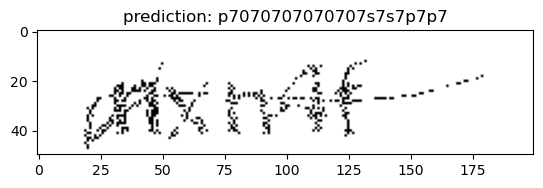

In [132]:
testing(MODEL, DEVICE)